In [386]:
import pandas as pd
import seaborn as sns

import string
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [287]:
# data_allowed_answers and data_allowed_guess are mutally exclusive lists of words
data_allowed_answers = pd.read_csv('wordle-answers-alphabetical.txt', sep="\n", header=None)
data_allowed_guess = pd.read_csv('wordle-allowed-guesses.txt',  sep="\n", header=None)


for data in [data_allowed_answers, data_allowed_guess]:
    data.columns = ['word']
# split word up into individual letters
    for i in range(5):
        name = 'letter_' + str(i+1)
        data[name] = data['word'].str[i]
data = pd.concat([data_allowed_answers, 
#                   data_allowed_guess
                 ], sort=False, ignore_index=True)

In [288]:
#create dataframe of letter counts

df_letter_counts = pd.DataFrame(columns=data.columns.values[1:],index=list(string.ascii_lowercase)).fillna(0)

for column in list(data.columns.values)[1:]:
    df_letter_counts[column] = data[column].value_counts()
    df_letter_counts[column] = df_letter_counts[column].fillna(0).astype('int')


In [289]:
# Relative occurences of each letter

letter_scores = 100*df_letter_counts/df_letter_counts.sum()
letter_scores.head()

letter_1   letter_2   letter_3   letter_4   letter_5
a  6.090713  13.131749  13.261339   7.041037   2.764579
b  7.473002   0.691145   2.462203   1.036717   0.475162
c  8.552916   1.727862   2.419006   6.565875   1.339093
d  4.794816   0.863931   3.239741   2.980562   5.097192
e  3.110151  10.453564   7.645788  13.736501  18.315335

In [298]:
# find the first best guesses
def get_scores(data):
    data = data.reset_index(drop=True)
    df_letter_counts = pd.DataFrame(columns=data.columns.values[1:],index=list(string.ascii_lowercase)).fillna(0)

    for column in list(data.columns.values)[1:]:
        df_letter_counts[column] = data[column].value_counts()
        df_letter_counts[column] = df_letter_counts[column].fillna(0).astype('int')
    
    scores = []
    for i in range(len(data)):
        word = data['word'][i]
        score = 0
        for j in range(5):
            letter_label = 'letter_' + str(j+1)
            temp_score = letter_scores.loc[word[j]][letter_label]
            score += temp_score
#         if len(set(word)) != len(word):
#             score = score - 1
        scores.append(score)
    data['positional_score'] = scores
    return data
    

data = get_scores(data)
data.sort_values(by='positional_score', ascending=False).head(10)

word letter_1 letter_2 letter_3 letter_4 letter_5  positional_score
1777  slate        s        l        a        t        e         62.073434
1648  sauce        s        a        u        c        e         60.950324
1783  slice        s        l        i        c        e         60.863931
1704  shale        s        h        a        l        e         60.604752
1651  saute        s        a        u        t        e         60.388769
1711  share        s        h        a        r        e         60.172786
1842  sooty        s        o        o        t        y         60.129590
1726  shine        s        h        i        n        e         59.697624
1963  suite        s        u        i        t        e         59.654428
458   crane        c        r        a        n        e         59.524838

Overall occurences of letters


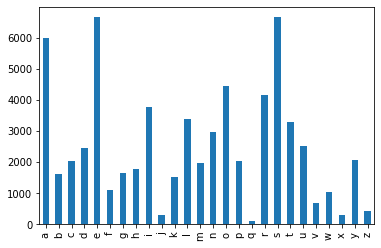

In [275]:
print('Overall occurences of letters')
df_letter_counts.sum(axis=1).plot(kind='bar')

In [6]:
# for column in df_letter_counts.columns:
#     print(column)
#     df_letter_counts[column].plot(kind='bar')
#     plt.show()

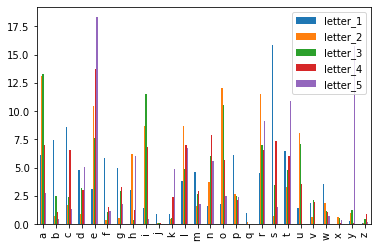

In [7]:
letter_scores.plot(kind='bar')

In [10]:
def string_splitter(string):
    split_string = ''
    for letter in string:
        sub_string = letter + '|'
        split_string += sub_string
    # remove extra '|'
    split_string =  split_string[:-1]
    return split_string

def initial_guess():
    guess = data[data['positional_score']==data.positional_score.max()].iloc[0]['word']
    return guess

def best_words_without(string):
    view =  data[~data.word.str.contains(
    string_splitter(string))].sort_values(
    by='positional_score', ascending=False).head()
    if len(view) > 0:
        return view.iloc[0,0]
    else: 
        print("no more possible words")
 

In [351]:
def answer_sampler(random_seed=1):
    answer = data_allowed_answers['word'].sample(n=1, random_state=random_seed).to_list()[0]
    return answer

def check_attempt(guess, answer):
    state = list('NNNNN')
    positions_to_check = [0,1,2,3,4]
    temp_answer = list(answer)
#     print(guess)
    temp_guess = list(guess)
    
    for i in range(5):
        if temp_guess[i] == temp_answer[i]:
            state[i] = 'G'
            temp_answer[i] = '_'
            positions_to_check.remove(i)
      
    for i in positions_to_check:
        if temp_guess[i] in temp_answer:
            state[i] = 'Y'
            temp_answer[temp_answer.index(temp_guess[i])] = '_'
            
    return state

In [400]:
def get_result_positions(result, letter):
    indices = [i for i, x in enumerate(result) if x == letter]
    return indices


def post_guess_df_filter(guess, df, state):
    green_positions = get_result_positions(state, 'G')
    yellow_positions = get_result_positions(state, 'Y')
    no_positions = get_result_positions(state, 'N')

    temp_df = df
    temp_df = temp_df.drop([temp_df[temp_df['word']==guess].index[0]])

    # greens
    for i in green_positions:
        column = 'letter_' + str(i+1)
        temp_df = temp_df[temp_df[column]==guess[i]]

    # nones    
    for i in no_positions:
        if i in green_positions:
            pass
        else:
            column1 = 'letter_' + str(i+1)
            temp_df = temp_df[temp_df[column1] != guess[i]]

    # yellows
    for i in yellow_positions:
        column = 'letter_' + str(i+1)
        temp_df = temp_df[temp_df[column] != guess[i]]
        temp_df = temp_df[temp_df.word.str.contains(guess[i])]

    return (temp_df.sort_values(by='positional_score', ascending=False))
    
    
def executor(initial_guess=initial_guess(), answer=answer, printer=False):
    temp_df = data
    attempt = 1
    guess = initial_guess
    state = ''
    while state!=['G', 'G', 'G', 'G', 'G']:
        state = check_attempt(guess, answer)
        if state == ['G', 'G', 'G', 'G', 'G']:
             print(f"Correct. Your guess of {guess} is right. Number of attempts: {attempt}")
        else:
            if printer == False:
                pass
            else:
                
                print(f"Your guess of {guess} is incorrect. Attempt number {attempt}. State is {state}")
            
            temp_df = post_guess_df_filter(guess, temp_df, state)         
#             temp_df = get_scores(temp_df)
            i = 0
            guess = temp_df.iloc[i,0]
            attempt += 1
            
            if len(temp_df)>1:
                if attempt <= 2:
                    if len(set(guess))!=len(guess):
#                     

                        i+=1
                        guess = temp_df.iloc[i,0]

            
    return attempt
  

In [352]:
answer = answer_sampler(random_seed=1118)
# executor(initial_guess(), answer)
executor('crane', answer)


Correct. Your guess of twice is right. Number of attempts: 5


5

In [358]:
performance_df = pd.DataFrame(columns = ['answer', "guesses_required", "first_guess"])


first_guesses = data['word'].sample(n=50, random_state=1).to_list()

for first_guess in first_guesses: 
    answer_dict = {}
    initial_guess_dict = {}
    for answer in data_allowed_answers.word:
    #     answer = answer_sampler(random_seed=i)
    #     answer_dict[answer] = executor(initial_guess(), answer)
        answer_dict[answer] = executor(first_guess, answer)
    df_temp = pd.DataFrame(answer_dict.items(), columns = ['answer', "guesses_required"])
    df_temp['first_guess'] = first_guess
    performance_df = pd.concat([performance_df, df_temp], ignore_index=True)

performance_df.guesses_required = pd.to_numeric(performance_df.guesses_required)

Correct. Your guess of aback is right. Number of attempts: 2
Correct. Your guess of abase is right. Number of attempts: 3
Correct. Your guess of abate is right. Number of attempts: 2
Correct. Your guess of abbey is right. Number of attempts: 2
Correct. Your guess of abbot is right. Number of attempts: 5
Correct. Your guess of abhor is right. Number of attempts: 3
Correct. Your guess of abide is right. Number of attempts: 4
Correct. Your guess of abled is right. Number of attempts: 3
Correct. Your guess of abode is right. Number of attempts: 5
Correct. Your guess of abort is right. Number of attempts: 2
Correct. Your guess of about is right. Number of attempts: 4
Correct. Your guess of above is right. Number of attempts: 5
Correct. Your guess of abuse is right. Number of attempts: 3
Correct. Your guess of abyss is right. Number of attempts: 5
Correct. Your guess of acorn is right. Number of attempts: 4
Correct. Your guess of acrid is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of bagel is right. Number of attempts: 3
Correct. Your guess of baggy is right. Number of attempts: 5
Correct. Your guess of baker is right. Number of attempts: 3
Correct. Your guess of baler is right. Number of attempts: 2
Correct. Your guess of balmy is right. Number of attempts: 3
Correct. Your guess of banal is right. Number of attempts: 4
Correct. Your guess of banjo is right. Number of attempts: 5
Correct. Your guess of barge is right. Number of attempts: 2
Correct. Your guess of baron is right. Number of attempts: 3
Correct. Your guess of basal is right. Number of attempts: 5
Correct. Your guess of basic is right. Number of attempts: 3
Correct. Your guess of basil is right. Number of attempts: 5
Correct. Your guess of basin is right. Number of attempts: 6
Correct. Your guess of basis is right. Number of attempts: 6
Correct. Your guess of baste is right. Number of attempts: 3
Correct. Your guess of batch is right. Number of attempts: 2
Correct. Your guess of b

Correct. Your guess of brown is right. Number of attempts: 3
Correct. Your guess of brunt is right. Number of attempts: 3
Correct. Your guess of brush is right. Number of attempts: 5
Correct. Your guess of brute is right. Number of attempts: 3
Correct. Your guess of buddy is right. Number of attempts: 6
Correct. Your guess of budge is right. Number of attempts: 6
Correct. Your guess of buggy is right. Number of attempts: 7
Correct. Your guess of bugle is right. Number of attempts: 6
Correct. Your guess of build is right. Number of attempts: 4
Correct. Your guess of built is right. Number of attempts: 3
Correct. Your guess of bulge is right. Number of attempts: 6
Correct. Your guess of bulky is right. Number of attempts: 6
Correct. Your guess of bully is right. Number of attempts: 6
Correct. Your guess of bunch is right. Number of attempts: 6
Correct. Your guess of bunny is right. Number of attempts: 3
Correct. Your guess of burly is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of comet is right. Number of attempts: 4
Correct. Your guess of comfy is right. Number of attempts: 5
Correct. Your guess of comic is right. Number of attempts: 7
Correct. Your guess of comma is right. Number of attempts: 7
Correct. Your guess of conch is right. Number of attempts: 4
Correct. Your guess of condo is right. Number of attempts: 6
Correct. Your guess of conic is right. Number of attempts: 5
Correct. Your guess of copse is right. Number of attempts: 4
Correct. Your guess of coral is right. Number of attempts: 3
Correct. Your guess of corer is right. Number of attempts: 3
Correct. Your guess of corny is right. Number of attempts: 2
Correct. Your guess of couch is right. Number of attempts: 3
Correct. Your guess of cough is right. Number of attempts: 4
Correct. Your guess of could is right. Number of attempts: 4
Correct. Your guess of count is right. Number of attempts: 3
Correct. Your guess of coupe is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of dowdy is right. Number of attempts: 9
Correct. Your guess of dowel is right. Number of attempts: 7
Correct. Your guess of downy is right. Number of attempts: 4
Correct. Your guess of dowry is right. Number of attempts: 5
Correct. Your guess of dozen is right. Number of attempts: 7
Correct. Your guess of draft is right. Number of attempts: 5
Correct. Your guess of drain is right. Number of attempts: 6
Correct. Your guess of drake is right. Number of attempts: 6
Correct. Your guess of drama is right. Number of attempts: 9
Correct. Your guess of drank is right. Number of attempts: 6
Correct. Your guess of drape is right. Number of attempts: 7
Correct. Your guess of drawl is right. Number of attempts: 6
Correct. Your guess of drawn is right. Number of attempts: 5
Correct. Your guess of dread is right. Number of attempts: 5
Correct. Your guess of dream is right. Number of attempts: 5
Correct. Your guess of dress is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of femme is right. Number of attempts: 6
Correct. Your guess of femur is right. Number of attempts: 5
Correct. Your guess of fence is right. Number of attempts: 5
Correct. Your guess of feral is right. Number of attempts: 4
Correct. Your guess of ferry is right. Number of attempts: 3
Correct. Your guess of fetal is right. Number of attempts: 5
Correct. Your guess of fetch is right. Number of attempts: 4
Correct. Your guess of fetid is right. Number of attempts: 5
Correct. Your guess of fetus is right. Number of attempts: 5
Correct. Your guess of fever is right. Number of attempts: 6
Correct. Your guess of fewer is right. Number of attempts: 7
Correct. Your guess of fiber is right. Number of attempts: 3
Correct. Your guess of fibre is right. Number of attempts: 2
Correct. Your guess of ficus is right. Number of attempts: 5
Correct. Your guess of field is right. Number of attempts: 5
Correct. Your guess of fiend is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of girly is right. Number of attempts: 5
Correct. Your guess of girth is right. Number of attempts: 5
Correct. Your guess of given is right. Number of attempts: 5
Correct. Your guess of giver is right. Number of attempts: 7
Correct. Your guess of glade is right. Number of attempts: 5
Correct. Your guess of gland is right. Number of attempts: 6
Correct. Your guess of glare is right. Number of attempts: 4
Correct. Your guess of glass is right. Number of attempts: 5
Correct. Your guess of glaze is right. Number of attempts: 6
Correct. Your guess of gleam is right. Number of attempts: 7
Correct. Your guess of glean is right. Number of attempts: 4
Correct. Your guess of glide is right. Number of attempts: 5
Correct. Your guess of glint is right. Number of attempts: 5
Correct. Your guess of gloat is right. Number of attempts: 4
Correct. Your guess of globe is right. Number of attempts: 3
Correct. Your guess of gloom is right. Number of attempts: 5
Correct. Your guess of g

Correct. Your guess of house is right. Number of attempts: 6
Correct. Your guess of hovel is right. Number of attempts: 7
Correct. Your guess of hover is right. Number of attempts: 11
Correct. Your guess of howdy is right. Number of attempts: 11
Correct. Your guess of human is right. Number of attempts: 4
Correct. Your guess of humid is right. Number of attempts: 5
Correct. Your guess of humor is right. Number of attempts: 4
Correct. Your guess of humph is right. Number of attempts: 7
Correct. Your guess of humus is right. Number of attempts: 5
Correct. Your guess of hunch is right. Number of attempts: 6
Correct. Your guess of hunky is right. Number of attempts: 6
Correct. Your guess of hurry is right. Number of attempts: 5
Correct. Your guess of husky is right. Number of attempts: 6
Correct. Your guess of hussy is right. Number of attempts: 6
Correct. Your guess of hutch is right. Number of attempts: 7
Correct. Your guess of hydro is right. Number of attempts: 4
Correct. Your guess of

Correct. Your guess of liner is right. Number of attempts: 7
Correct. Your guess of lingo is right. Number of attempts: 5
Correct. Your guess of lipid is right. Number of attempts: 4
Correct. Your guess of lithe is right. Number of attempts: 4
Correct. Your guess of liver is right. Number of attempts: 6
Correct. Your guess of livid is right. Number of attempts: 7
Correct. Your guess of llama is right. Number of attempts: 7
Correct. Your guess of loamy is right. Number of attempts: 4
Correct. Your guess of loath is right. Number of attempts: 4
Correct. Your guess of lobby is right. Number of attempts: 4
Correct. Your guess of local is right. Number of attempts: 5
Correct. Your guess of locus is right. Number of attempts: 5
Correct. Your guess of lodge is right. Number of attempts: 6
Correct. Your guess of lofty is right. Number of attempts: 5
Correct. Your guess of logic is right. Number of attempts: 3
Correct. Your guess of login is right. Number of attempts: 7
Correct. Your guess of l

Correct. Your guess of mulch is right. Number of attempts: 6
Correct. Your guess of mummy is right. Number of attempts: 10
Correct. Your guess of munch is right. Number of attempts: 4
Correct. Your guess of mural is right. Number of attempts: 4
Correct. Your guess of murky is right. Number of attempts: 6
Correct. Your guess of mushy is right. Number of attempts: 6
Correct. Your guess of music is right. Number of attempts: 5
Correct. Your guess of musky is right. Number of attempts: 7
Correct. Your guess of musty is right. Number of attempts: 6
Correct. Your guess of myrrh is right. Number of attempts: 4
Correct. Your guess of nadir is right. Number of attempts: 3
Correct. Your guess of naive is right. Number of attempts: 5
Correct. Your guess of nanny is right. Number of attempts: 5
Correct. Your guess of nasal is right. Number of attempts: 5
Correct. Your guess of nasty is right. Number of attempts: 3
Correct. Your guess of natal is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of pitch is right. Number of attempts: 6
Correct. Your guess of pithy is right. Number of attempts: 4
Correct. Your guess of pivot is right. Number of attempts: 6
Correct. Your guess of pixel is right. Number of attempts: 6
Correct. Your guess of pixie is right. Number of attempts: 4
Correct. Your guess of pizza is right. Number of attempts: 7
Correct. Your guess of place is right. Number of attempts: 4
Correct. Your guess of plaid is right. Number of attempts: 5
Correct. Your guess of plain is right. Number of attempts: 4
Correct. Your guess of plait is right. Number of attempts: 4
Correct. Your guess of plane is right. Number of attempts: 3
Correct. Your guess of plank is right. Number of attempts: 4
Correct. Your guess of plant is right. Number of attempts: 3
Correct. Your guess of plate is right. Number of attempts: 3
Correct. Your guess of plaza is right. Number of attempts: 5
Correct. Your guess of plead is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of recur is right. Number of attempts: 4
Correct. Your guess of recut is right. Number of attempts: 3
Correct. Your guess of reedy is right. Number of attempts: 5
Correct. Your guess of refer is right. Number of attempts: 7
Correct. Your guess of refit is right. Number of attempts: 4
Correct. Your guess of regal is right. Number of attempts: 4
Correct. Your guess of rehab is right. Number of attempts: 3
Correct. Your guess of reign is right. Number of attempts: 4
Correct. Your guess of relax is right. Number of attempts: 4
Correct. Your guess of relay is right. Number of attempts: 3
Correct. Your guess of relic is right. Number of attempts: 4
Correct. Your guess of remit is right. Number of attempts: 4
Correct. Your guess of renal is right. Number of attempts: 3
Correct. Your guess of renew is right. Number of attempts: 3
Correct. Your guess of repay is right. Number of attempts: 4
Correct. Your guess of repel is right. Number of attempts: 4
Correct. Your guess of r

Correct. Your guess of sever is right. Number of attempts: 6
Correct. Your guess of sewer is right. Number of attempts: 7
Correct. Your guess of shack is right. Number of attempts: 3
Correct. Your guess of shade is right. Number of attempts: 5
Correct. Your guess of shady is right. Number of attempts: 3
Correct. Your guess of shaft is right. Number of attempts: 5
Correct. Your guess of shake is right. Number of attempts: 7
Correct. Your guess of shaky is right. Number of attempts: 4
Correct. Your guess of shale is right. Number of attempts: 3
Correct. Your guess of shall is right. Number of attempts: 4
Correct. Your guess of shalt is right. Number of attempts: 4
Correct. Your guess of shame is right. Number of attempts: 6
Correct. Your guess of shank is right. Number of attempts: 4
Correct. Your guess of shape is right. Number of attempts: 8
Correct. Your guess of shard is right. Number of attempts: 4
Correct. Your guess of share is right. Number of attempts: 2
Correct. Your guess of s

Correct. Your guess of solar is right. Number of attempts: 3
Correct. Your guess of solid is right. Number of attempts: 4
Correct. Your guess of solve is right. Number of attempts: 7
Correct. Your guess of sonar is right. Number of attempts: 3
Correct. Your guess of sonic is right. Number of attempts: 4
Correct. Your guess of sooth is right. Number of attempts: 4
Correct. Your guess of sooty is right. Number of attempts: 3
Correct. Your guess of sorry is right. Number of attempts: 3
Correct. Your guess of sound is right. Number of attempts: 4
Correct. Your guess of south is right. Number of attempts: 4
Correct. Your guess of sower is right. Number of attempts: 5
Correct. Your guess of space is right. Number of attempts: 2
Correct. Your guess of spade is right. Number of attempts: 7
Correct. Your guess of spank is right. Number of attempts: 3
Correct. Your guess of spare is right. Number of attempts: 5
Correct. Your guess of spark is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of swath is right. Number of attempts: 5
Correct. Your guess of swear is right. Number of attempts: 5
Correct. Your guess of sweat is right. Number of attempts: 3
Correct. Your guess of sweep is right. Number of attempts: 7
Correct. Your guess of sweet is right. Number of attempts: 5
Correct. Your guess of swell is right. Number of attempts: 7
Correct. Your guess of swept is right. Number of attempts: 5
Correct. Your guess of swift is right. Number of attempts: 5
Correct. Your guess of swill is right. Number of attempts: 6
Correct. Your guess of swine is right. Number of attempts: 5
Correct. Your guess of swing is right. Number of attempts: 7
Correct. Your guess of swirl is right. Number of attempts: 5
Correct. Your guess of swish is right. Number of attempts: 5
Correct. Your guess of swoon is right. Number of attempts: 6
Correct. Your guess of swoop is right. Number of attempts: 10
Correct. Your guess of sword is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of trove is right. Number of attempts: 6
Correct. Your guess of truce is right. Number of attempts: 3
Correct. Your guess of truck is right. Number of attempts: 4
Correct. Your guess of truer is right. Number of attempts: 3
Correct. Your guess of truly is right. Number of attempts: 3
Correct. Your guess of trump is right. Number of attempts: 7
Correct. Your guess of trunk is right. Number of attempts: 5
Correct. Your guess of truss is right. Number of attempts: 6
Correct. Your guess of trust is right. Number of attempts: 5
Correct. Your guess of truth is right. Number of attempts: 5
Correct. Your guess of tryst is right. Number of attempts: 4
Correct. Your guess of tubal is right. Number of attempts: 3
Correct. Your guess of tuber is right. Number of attempts: 4
Correct. Your guess of tulip is right. Number of attempts: 5
Correct. Your guess of tulle is right. Number of attempts: 4
Correct. Your guess of tumor is right. Number of attempts: 7
Correct. Your guess of t

Correct. Your guess of whole is right. Number of attempts: 5
Correct. Your guess of whoop is right. Number of attempts: 7
Correct. Your guess of whose is right. Number of attempts: 6
Correct. Your guess of widen is right. Number of attempts: 7
Correct. Your guess of wider is right. Number of attempts: 9
Correct. Your guess of widow is right. Number of attempts: 7
Correct. Your guess of width is right. Number of attempts: 7
Correct. Your guess of wield is right. Number of attempts: 6
Correct. Your guess of wight is right. Number of attempts: 9
Correct. Your guess of willy is right. Number of attempts: 7
Correct. Your guess of wimpy is right. Number of attempts: 6
Correct. Your guess of wince is right. Number of attempts: 6
Correct. Your guess of winch is right. Number of attempts: 6
Correct. Your guess of windy is right. Number of attempts: 6
Correct. Your guess of wiser is right. Number of attempts: 6
Correct. Your guess of wispy is right. Number of attempts: 4
Correct. Your guess of w

Correct. Your guess of anode is right. Number of attempts: 4
Correct. Your guess of antic is right. Number of attempts: 5
Correct. Your guess of anvil is right. Number of attempts: 6
Correct. Your guess of aorta is right. Number of attempts: 5
Correct. Your guess of apart is right. Number of attempts: 4
Correct. Your guess of aphid is right. Number of attempts: 3
Correct. Your guess of aping is right. Number of attempts: 5
Correct. Your guess of apnea is right. Number of attempts: 4
Correct. Your guess of apple is right. Number of attempts: 6
Correct. Your guess of apply is right. Number of attempts: 7
Correct. Your guess of apron is right. Number of attempts: 6
Correct. Your guess of aptly is right. Number of attempts: 5
Correct. Your guess of arbor is right. Number of attempts: 4
Correct. Your guess of ardor is right. Number of attempts: 4
Correct. Your guess of arena is right. Number of attempts: 4
Correct. Your guess of argue is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of blush is right. Number of attempts: 4
Correct. Your guess of board is right. Number of attempts: 3
Correct. Your guess of boast is right. Number of attempts: 3
Correct. Your guess of bobby is right. Number of attempts: 5
Correct. Your guess of boney is right. Number of attempts: 2
Correct. Your guess of bongo is right. Number of attempts: 3
Correct. Your guess of bonus is right. Number of attempts: 4
Correct. Your guess of booby is right. Number of attempts: 4
Correct. Your guess of boost is right. Number of attempts: 3
Correct. Your guess of booth is right. Number of attempts: 3
Correct. Your guess of booty is right. Number of attempts: 3
Correct. Your guess of booze is right. Number of attempts: 4
Correct. Your guess of boozy is right. Number of attempts: 5
Correct. Your guess of borax is right. Number of attempts: 4
Correct. Your guess of borne is right. Number of attempts: 3
Correct. Your guess of bosom is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of chief is right. Number of attempts: 2
Correct. Your guess of child is right. Number of attempts: 5
Correct. Your guess of chili is right. Number of attempts: 6
Correct. Your guess of chill is right. Number of attempts: 4
Correct. Your guess of chime is right. Number of attempts: 4
Correct. Your guess of china is right. Number of attempts: 3
Correct. Your guess of chirp is right. Number of attempts: 3
Correct. Your guess of chock is right. Number of attempts: 3
Correct. Your guess of choir is right. Number of attempts: 3
Correct. Your guess of choke is right. Number of attempts: 2
Correct. Your guess of chord is right. Number of attempts: 4
Correct. Your guess of chore is right. Number of attempts: 3
Correct. Your guess of chose is right. Number of attempts: 2
Correct. Your guess of chuck is right. Number of attempts: 5
Correct. Your guess of chump is right. Number of attempts: 5
Correct. Your guess of chunk is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of cycle is right. Number of attempts: 5
Correct. Your guess of cynic is right. Number of attempts: 3
Correct. Your guess of daddy is right. Number of attempts: 9
Correct. Your guess of daily is right. Number of attempts: 6
Correct. Your guess of dairy is right. Number of attempts: 4
Correct. Your guess of daisy is right. Number of attempts: 2
Correct. Your guess of dally is right. Number of attempts: 7
Correct. Your guess of dance is right. Number of attempts: 5
Correct. Your guess of dandy is right. Number of attempts: 8
Correct. Your guess of datum is right. Number of attempts: 7
Correct. Your guess of daunt is right. Number of attempts: 5
Correct. Your guess of dealt is right. Number of attempts: 5
Correct. Your guess of death is right. Number of attempts: 3
Correct. Your guess of debar is right. Number of attempts: 5
Correct. Your guess of debit is right. Number of attempts: 3
Correct. Your guess of debug is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of elide is right. Number of attempts: 6
Correct. Your guess of elite is right. Number of attempts: 5
Correct. Your guess of elope is right. Number of attempts: 6
Correct. Your guess of elude is right. Number of attempts: 7
Correct. Your guess of email is right. Number of attempts: 4
Correct. Your guess of embed is right. Number of attempts: 5
Correct. Your guess of ember is right. Number of attempts: 7
Correct. Your guess of emcee is right. Number of attempts: 5
Correct. Your guess of empty is right. Number of attempts: 5
Correct. Your guess of enact is right. Number of attempts: 3
Correct. Your guess of endow is right. Number of attempts: 4
Correct. Your guess of enema is right. Number of attempts: 5
Correct. Your guess of enemy is right. Number of attempts: 4
Correct. Your guess of enjoy is right. Number of attempts: 5
Correct. Your guess of ennui is right. Number of attempts: 4
Correct. Your guess of ensue is right. Number of attempts: 5
Correct. Your guess of e

Correct. Your guess of foamy is right. Number of attempts: 4
Correct. Your guess of focal is right. Number of attempts: 3
Correct. Your guess of focus is right. Number of attempts: 5
Correct. Your guess of foggy is right. Number of attempts: 9
Correct. Your guess of foist is right. Number of attempts: 3
Correct. Your guess of folio is right. Number of attempts: 4
Correct. Your guess of folly is right. Number of attempts: 6
Correct. Your guess of foray is right. Number of attempts: 3
Correct. Your guess of force is right. Number of attempts: 3
Correct. Your guess of forge is right. Number of attempts: 5
Correct. Your guess of forgo is right. Number of attempts: 9
Correct. Your guess of forte is right. Number of attempts: 4
Correct. Your guess of forth is right. Number of attempts: 4
Correct. Your guess of forty is right. Number of attempts: 5
Correct. Your guess of forum is right. Number of attempts: 7
Correct. Your guess of found is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of groom is right. Number of attempts: 8
Correct. Your guess of grope is right. Number of attempts: 5
Correct. Your guess of gross is right. Number of attempts: 5
Correct. Your guess of group is right. Number of attempts: 9
Correct. Your guess of grout is right. Number of attempts: 6
Correct. Your guess of grove is right. Number of attempts: 6
Correct. Your guess of growl is right. Number of attempts: 8
Correct. Your guess of grown is right. Number of attempts: 6
Correct. Your guess of gruel is right. Number of attempts: 5
Correct. Your guess of gruff is right. Number of attempts: 6
Correct. Your guess of grunt is right. Number of attempts: 5
Correct. Your guess of guard is right. Number of attempts: 4
Correct. Your guess of guava is right. Number of attempts: 7
Correct. Your guess of guess is right. Number of attempts: 5
Correct. Your guess of guest is right. Number of attempts: 4
Correct. Your guess of guide is right. Number of attempts: 5
Correct. Your guess of g

Correct. Your guess of jiffy is right. Number of attempts: 5
Correct. Your guess of joint is right. Number of attempts: 4
Correct. Your guess of joist is right. Number of attempts: 6
Correct. Your guess of joker is right. Number of attempts: 4
Correct. Your guess of jolly is right. Number of attempts: 10
Correct. Your guess of joust is right. Number of attempts: 5
Correct. Your guess of judge is right. Number of attempts: 10
Correct. Your guess of juice is right. Number of attempts: 5
Correct. Your guess of juicy is right. Number of attempts: 5
Correct. Your guess of jumbo is right. Number of attempts: 6
Correct. Your guess of jumpy is right. Number of attempts: 9
Correct. Your guess of junta is right. Number of attempts: 6
Correct. Your guess of junto is right. Number of attempts: 5
Correct. Your guess of juror is right. Number of attempts: 6
Correct. Your guess of kappa is right. Number of attempts: 5
Correct. Your guess of karma is right. Number of attempts: 3
Correct. Your guess of

Correct. Your guess of manga is right. Number of attempts: 5
Correct. Your guess of mange is right. Number of attempts: 6
Correct. Your guess of mango is right. Number of attempts: 5
Correct. Your guess of mangy is right. Number of attempts: 5
Correct. Your guess of mania is right. Number of attempts: 7
Correct. Your guess of manic is right. Number of attempts: 5
Correct. Your guess of manly is right. Number of attempts: 5
Correct. Your guess of manor is right. Number of attempts: 5
Correct. Your guess of maple is right. Number of attempts: 4
Correct. Your guess of march is right. Number of attempts: 4
Correct. Your guess of marry is right. Number of attempts: 5
Correct. Your guess of marsh is right. Number of attempts: 3
Correct. Your guess of mason is right. Number of attempts: 5
Correct. Your guess of masse is right. Number of attempts: 6
Correct. Your guess of match is right. Number of attempts: 6
Correct. Your guess of matey is right. Number of attempts: 3
Correct. Your guess of m

Correct. Your guess of often is right. Number of attempts: 5
Correct. Your guess of olden is right. Number of attempts: 4
Correct. Your guess of older is right. Number of attempts: 5
Correct. Your guess of olive is right. Number of attempts: 4
Correct. Your guess of ombre is right. Number of attempts: 4
Correct. Your guess of omega is right. Number of attempts: 4
Correct. Your guess of onion is right. Number of attempts: 7
Correct. Your guess of onset is right. Number of attempts: 3
Correct. Your guess of opera is right. Number of attempts: 4
Correct. Your guess of opine is right. Number of attempts: 4
Correct. Your guess of opium is right. Number of attempts: 6
Correct. Your guess of optic is right. Number of attempts: 7
Correct. Your guess of orbit is right. Number of attempts: 4
Correct. Your guess of order is right. Number of attempts: 4
Correct. Your guess of organ is right. Number of attempts: 4
Correct. Your guess of other is right. Number of attempts: 3
Correct. Your guess of o

Correct. Your guess of pride is right. Number of attempts: 6
Correct. Your guess of pried is right. Number of attempts: 5
Correct. Your guess of prime is right. Number of attempts: 7
Correct. Your guess of primo is right. Number of attempts: 5
Correct. Your guess of print is right. Number of attempts: 4
Correct. Your guess of prior is right. Number of attempts: 4
Correct. Your guess of prism is right. Number of attempts: 6
Correct. Your guess of privy is right. Number of attempts: 6
Correct. Your guess of prize is right. Number of attempts: 8
Correct. Your guess of probe is right. Number of attempts: 5
Correct. Your guess of prone is right. Number of attempts: 3
Correct. Your guess of prong is right. Number of attempts: 4
Correct. Your guess of proof is right. Number of attempts: 4
Correct. Your guess of prose is right. Number of attempts: 3
Correct. Your guess of proud is right. Number of attempts: 7
Correct. Your guess of prove is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of rogue is right. Number of attempts: 5
Correct. Your guess of roomy is right. Number of attempts: 4
Correct. Your guess of roost is right. Number of attempts: 4
Correct. Your guess of rotor is right. Number of attempts: 6
Correct. Your guess of rouge is right. Number of attempts: 6
Correct. Your guess of rough is right. Number of attempts: 7
Correct. Your guess of round is right. Number of attempts: 6
Correct. Your guess of rouse is right. Number of attempts: 5
Correct. Your guess of route is right. Number of attempts: 5
Correct. Your guess of rover is right. Number of attempts: 8
Correct. Your guess of rowdy is right. Number of attempts: 5
Correct. Your guess of rower is right. Number of attempts: 8
Correct. Your guess of royal is right. Number of attempts: 3
Correct. Your guess of ruddy is right. Number of attempts: 7
Correct. Your guess of ruder is right. Number of attempts: 7
Correct. Your guess of rugby is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of shrug is right. Number of attempts: 6
Correct. Your guess of shuck is right. Number of attempts: 4
Correct. Your guess of shunt is right. Number of attempts: 3
Correct. Your guess of shush is right. Number of attempts: 5
Correct. Your guess of shyly is right. Number of attempts: 4
Correct. Your guess of siege is right. Number of attempts: 4
Correct. Your guess of sieve is right. Number of attempts: 5
Correct. Your guess of sight is right. Number of attempts: 3
Correct. Your guess of sigma is right. Number of attempts: 4
Correct. Your guess of silky is right. Number of attempts: 3
Correct. Your guess of silly is right. Number of attempts: 3
Correct. Your guess of since is right. Number of attempts: 4
Correct. Your guess of sinew is right. Number of attempts: 3
Correct. Your guess of singe is right. Number of attempts: 5
Correct. Your guess of siren is right. Number of attempts: 3
Correct. Your guess of sissy is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of spook is right. Number of attempts: 5
Correct. Your guess of spool is right. Number of attempts: 6
Correct. Your guess of spoon is right. Number of attempts: 6
Correct. Your guess of spore is right. Number of attempts: 6
Correct. Your guess of sport is right. Number of attempts: 5
Correct. Your guess of spout is right. Number of attempts: 6
Correct. Your guess of spray is right. Number of attempts: 5
Correct. Your guess of spree is right. Number of attempts: 5
Correct. Your guess of sprig is right. Number of attempts: 5
Correct. Your guess of spunk is right. Number of attempts: 5
Correct. Your guess of spurn is right. Number of attempts: 6
Correct. Your guess of spurt is right. Number of attempts: 5
Correct. Your guess of squad is right. Number of attempts: 6
Correct. Your guess of squat is right. Number of attempts: 5
Correct. Your guess of squib is right. Number of attempts: 8
Correct. Your guess of stack is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of tarot is right. Number of attempts: 4
Correct. Your guess of taste is right. Number of attempts: 5
Correct. Your guess of tasty is right. Number of attempts: 3
Correct. Your guess of tatty is right. Number of attempts: 6
Correct. Your guess of taunt is right. Number of attempts: 4
Correct. Your guess of tawny is right. Number of attempts: 5
Correct. Your guess of teach is right. Number of attempts: 4
Correct. Your guess of teary is right. Number of attempts: 2
Correct. Your guess of tease is right. Number of attempts: 2
Correct. Your guess of teddy is right. Number of attempts: 4
Correct. Your guess of teeth is right. Number of attempts: 5
Correct. Your guess of tempo is right. Number of attempts: 6
Correct. Your guess of tenet is right. Number of attempts: 3
Correct. Your guess of tenor is right. Number of attempts: 3
Correct. Your guess of tense is right. Number of attempts: 6
Correct. Your guess of tenth is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of undid is right. Number of attempts: 6
Correct. Your guess of undue is right. Number of attempts: 5
Correct. Your guess of unfed is right. Number of attempts: 9
Correct. Your guess of unfit is right. Number of attempts: 6
Correct. Your guess of unify is right. Number of attempts: 6
Correct. Your guess of union is right. Number of attempts: 8
Correct. Your guess of unite is right. Number of attempts: 5
Correct. Your guess of unity is right. Number of attempts: 5
Correct. Your guess of unlit is right. Number of attempts: 5
Correct. Your guess of unmet is right. Number of attempts: 7
Correct. Your guess of unset is right. Number of attempts: 6
Correct. Your guess of untie is right. Number of attempts: 5
Correct. Your guess of until is right. Number of attempts: 4
Correct. Your guess of unwed is right. Number of attempts: 8
Correct. Your guess of unzip is right. Number of attempts: 7
Correct. Your guess of upper is right. Number of attempts: 7
Correct. Your guess of u

Correct. Your guess of wrist is right. Number of attempts: 4
Correct. Your guess of write is right. Number of attempts: 5
Correct. Your guess of wrong is right. Number of attempts: 5
Correct. Your guess of wrote is right. Number of attempts: 4
Correct. Your guess of wrung is right. Number of attempts: 6
Correct. Your guess of wryly is right. Number of attempts: 6
Correct. Your guess of yacht is right. Number of attempts: 3
Correct. Your guess of yearn is right. Number of attempts: 3
Correct. Your guess of yeast is right. Number of attempts: 5
Correct. Your guess of yield is right. Number of attempts: 3
Correct. Your guess of young is right. Number of attempts: 3
Correct. Your guess of youth is right. Number of attempts: 3
Correct. Your guess of zebra is right. Number of attempts: 4
Correct. Your guess of zesty is right. Number of attempts: 4
Correct. Your guess of zonal is right. Number of attempts: 6
Correct. Your guess of aback is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of augur is right. Number of attempts: 5
Correct. Your guess of aunty is right. Number of attempts: 3
Correct. Your guess of avail is right. Number of attempts: 3
Correct. Your guess of avert is right. Number of attempts: 3
Correct. Your guess of avian is right. Number of attempts: 4
Correct. Your guess of avoid is right. Number of attempts: 4
Correct. Your guess of await is right. Number of attempts: 3
Correct. Your guess of awake is right. Number of attempts: 5
Correct. Your guess of award is right. Number of attempts: 4
Correct. Your guess of aware is right. Number of attempts: 3
Correct. Your guess of awash is right. Number of attempts: 3
Correct. Your guess of awful is right. Number of attempts: 6
Correct. Your guess of awoke is right. Number of attempts: 6
Correct. Your guess of axial is right. Number of attempts: 4
Correct. Your guess of axiom is right. Number of attempts: 5
Correct. Your guess of axion is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of brass is right. Number of attempts: 5
Correct. Your guess of brave is right. Number of attempts: 7
Correct. Your guess of bravo is right. Number of attempts: 5
Correct. Your guess of brawl is right. Number of attempts: 6
Correct. Your guess of brawn is right. Number of attempts: 6
Correct. Your guess of bread is right. Number of attempts: 4
Correct. Your guess of break is right. Number of attempts: 5
Correct. Your guess of breed is right. Number of attempts: 5
Correct. Your guess of briar is right. Number of attempts: 4
Correct. Your guess of bribe is right. Number of attempts: 7
Correct. Your guess of brick is right. Number of attempts: 5
Correct. Your guess of bride is right. Number of attempts: 6
Correct. Your guess of brief is right. Number of attempts: 5
Correct. Your guess of brine is right. Number of attempts: 4
Correct. Your guess of bring is right. Number of attempts: 6
Correct. Your guess of brink is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of clean is right. Number of attempts: 5
Correct. Your guess of clear is right. Number of attempts: 4
Correct. Your guess of cleat is right. Number of attempts: 3
Correct. Your guess of cleft is right. Number of attempts: 4
Correct. Your guess of clerk is right. Number of attempts: 4
Correct. Your guess of click is right. Number of attempts: 4
Correct. Your guess of cliff is right. Number of attempts: 4
Correct. Your guess of climb is right. Number of attempts: 5
Correct. Your guess of cling is right. Number of attempts: 5
Correct. Your guess of clink is right. Number of attempts: 4
Correct. Your guess of cloak is right. Number of attempts: 4
Correct. Your guess of clock is right. Number of attempts: 5
Correct. Your guess of clone is right. Number of attempts: 3
Correct. Your guess of close is right. Number of attempts: 3
Correct. Your guess of cloth is right. Number of attempts: 3
Correct. Your guess of cloud is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of depot is right. Number of attempts: 5
Correct. Your guess of depth is right. Number of attempts: 6
Correct. Your guess of derby is right. Number of attempts: 5
Correct. Your guess of deter is right. Number of attempts: 6
Correct. Your guess of detox is right. Number of attempts: 5
Correct. Your guess of deuce is right. Number of attempts: 4
Correct. Your guess of devil is right. Number of attempts: 4
Correct. Your guess of diary is right. Number of attempts: 4
Correct. Your guess of dicey is right. Number of attempts: 4
Correct. Your guess of digit is right. Number of attempts: 6
Correct. Your guess of dilly is right. Number of attempts: 5
Correct. Your guess of dimly is right. Number of attempts: 4
Correct. Your guess of diner is right. Number of attempts: 5
Correct. Your guess of dingo is right. Number of attempts: 7
Correct. Your guess of dingy is right. Number of attempts: 6
Correct. Your guess of diode is right. Number of attempts: 6
Correct. Your guess of d

Correct. Your guess of etude is right. Number of attempts: 7
Correct. Your guess of evade is right. Number of attempts: 8
Correct. Your guess of event is right. Number of attempts: 7
Correct. Your guess of every is right. Number of attempts: 5
Correct. Your guess of evict is right. Number of attempts: 6
Correct. Your guess of evoke is right. Number of attempts: 8
Correct. Your guess of exact is right. Number of attempts: 5
Correct. Your guess of exalt is right. Number of attempts: 4
Correct. Your guess of excel is right. Number of attempts: 4
Correct. Your guess of exert is right. Number of attempts: 6
Correct. Your guess of exile is right. Number of attempts: 6
Correct. Your guess of exist is right. Number of attempts: 5
Correct. Your guess of expel is right. Number of attempts: 5
Correct. Your guess of extol is right. Number of attempts: 5
Correct. Your guess of extra is right. Number of attempts: 5
Correct. Your guess of exult is right. Number of attempts: 4
Correct. Your guess of e

Correct. Your guess of frown is right. Number of attempts: 7
Correct. Your guess of froze is right. Number of attempts: 9
Correct. Your guess of fruit is right. Number of attempts: 5
Correct. Your guess of fudge is right. Number of attempts: 8
Correct. Your guess of fugue is right. Number of attempts: 8
Correct. Your guess of fully is right. Number of attempts: 6
Correct. Your guess of fungi is right. Number of attempts: 5
Correct. Your guess of funky is right. Number of attempts: 6
Correct. Your guess of funny is right. Number of attempts: 7
Correct. Your guess of furor is right. Number of attempts: 5
Correct. Your guess of furry is right. Number of attempts: 6
Correct. Your guess of fussy is right. Number of attempts: 5
Correct. Your guess of fuzzy is right. Number of attempts: 7
Correct. Your guess of gaffe is right. Number of attempts: 7
Correct. Your guess of gaily is right. Number of attempts: 3
Correct. Your guess of gamer is right. Number of attempts: 6
Correct. Your guess of g

Correct. Your guess of haste is right. Number of attempts: 9
Correct. Your guess of hasty is right. Number of attempts: 6
Correct. Your guess of hatch is right. Number of attempts: 9
Correct. Your guess of hater is right. Number of attempts: 7
Correct. Your guess of haunt is right. Number of attempts: 6
Correct. Your guess of haute is right. Number of attempts: 4
Correct. Your guess of haven is right. Number of attempts: 7
Correct. Your guess of havoc is right. Number of attempts: 5
Correct. Your guess of hazel is right. Number of attempts: 8
Correct. Your guess of heady is right. Number of attempts: 6
Correct. Your guess of heard is right. Number of attempts: 6
Correct. Your guess of heart is right. Number of attempts: 6
Correct. Your guess of heath is right. Number of attempts: 5
Correct. Your guess of heave is right. Number of attempts: 7
Correct. Your guess of heavy is right. Number of attempts: 6
Correct. Your guess of hedge is right. Number of attempts: 10
Correct. Your guess of 

Correct. Your guess of large is right. Number of attempts: 5
Correct. Your guess of larva is right. Number of attempts: 5
Correct. Your guess of lasso is right. Number of attempts: 4
Correct. Your guess of latch is right. Number of attempts: 3
Correct. Your guess of later is right. Number of attempts: 3
Correct. Your guess of lathe is right. Number of attempts: 3
Correct. Your guess of latte is right. Number of attempts: 4
Correct. Your guess of laugh is right. Number of attempts: 4
Correct. Your guess of layer is right. Number of attempts: 2
Correct. Your guess of leach is right. Number of attempts: 4
Correct. Your guess of leafy is right. Number of attempts: 4
Correct. Your guess of leaky is right. Number of attempts: 3
Correct. Your guess of leant is right. Number of attempts: 3
Correct. Your guess of leapt is right. Number of attempts: 5
Correct. Your guess of learn is right. Number of attempts: 4
Correct. Your guess of lease is right. Number of attempts: 3
Correct. Your guess of l

Correct. Your guess of minus is right. Number of attempts: 5
Correct. Your guess of mirth is right. Number of attempts: 7
Correct. Your guess of miser is right. Number of attempts: 4
Correct. Your guess of missy is right. Number of attempts: 5
Correct. Your guess of mocha is right. Number of attempts: 5
Correct. Your guess of modal is right. Number of attempts: 6
Correct. Your guess of model is right. Number of attempts: 6
Correct. Your guess of modem is right. Number of attempts: 6
Correct. Your guess of mogul is right. Number of attempts: 5
Correct. Your guess of moist is right. Number of attempts: 6
Correct. Your guess of molar is right. Number of attempts: 4
Correct. Your guess of moldy is right. Number of attempts: 4
Correct. Your guess of money is right. Number of attempts: 3
Correct. Your guess of month is right. Number of attempts: 6
Correct. Your guess of moody is right. Number of attempts: 6
Correct. Your guess of moose is right. Number of attempts: 6
Correct. Your guess of m

Correct. Your guess of parer is right. Number of attempts: 4
Correct. Your guess of parka is right. Number of attempts: 7
Correct. Your guess of parry is right. Number of attempts: 3
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 4
Correct. Your guess of paste is right. Number of attempts: 7
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of patch is right. Number of attempts: 5
Correct. Your guess of patio is right. Number of attempts: 4
Correct. Your guess of patsy is right. Number of attempts: 4
Correct. Your guess of patty is right. Number of attempts: 5
Correct. Your guess of pause is right. Number of attempts: 4
Correct. Your guess of payee is right. Number of attempts: 3
Correct. Your guess of payer is right. Number of attempts: 2
Correct. Your guess of peace is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of queue is right. Number of attempts: 7
Correct. Your guess of quick is right. Number of attempts: 5
Correct. Your guess of quiet is right. Number of attempts: 4
Correct. Your guess of quill is right. Number of attempts: 5
Correct. Your guess of quilt is right. Number of attempts: 5
Correct. Your guess of quirk is right. Number of attempts: 4
Correct. Your guess of quite is right. Number of attempts: 5
Correct. Your guess of quota is right. Number of attempts: 4
Correct. Your guess of quote is right. Number of attempts: 6
Correct. Your guess of quoth is right. Number of attempts: 5
Correct. Your guess of rabbi is right. Number of attempts: 5
Correct. Your guess of rabid is right. Number of attempts: 6
Correct. Your guess of racer is right. Number of attempts: 4
Correct. Your guess of radar is right. Number of attempts: 5
Correct. Your guess of radii is right. Number of attempts: 8
Correct. Your guess of radio is right. Number of attempts: 7
Correct. Your guess of r

Correct. Your guess of scant is right. Number of attempts: 3
Correct. Your guess of scare is right. Number of attempts: 4
Correct. Your guess of scarf is right. Number of attempts: 5
Correct. Your guess of scary is right. Number of attempts: 5
Correct. Your guess of scene is right. Number of attempts: 5
Correct. Your guess of scent is right. Number of attempts: 3
Correct. Your guess of scion is right. Number of attempts: 4
Correct. Your guess of scoff is right. Number of attempts: 9
Correct. Your guess of scold is right. Number of attempts: 4
Correct. Your guess of scone is right. Number of attempts: 4
Correct. Your guess of scoop is right. Number of attempts: 7
Correct. Your guess of scope is right. Number of attempts: 6
Correct. Your guess of score is right. Number of attempts: 5
Correct. Your guess of scorn is right. Number of attempts: 5
Correct. Your guess of scour is right. Number of attempts: 4
Correct. Your guess of scout is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of smell is right. Number of attempts: 5
Correct. Your guess of smelt is right. Number of attempts: 4
Correct. Your guess of smile is right. Number of attempts: 4
Correct. Your guess of smirk is right. Number of attempts: 7
Correct. Your guess of smite is right. Number of attempts: 6
Correct. Your guess of smith is right. Number of attempts: 5
Correct. Your guess of smock is right. Number of attempts: 5
Correct. Your guess of smoke is right. Number of attempts: 9
Correct. Your guess of smoky is right. Number of attempts: 5
Correct. Your guess of smote is right. Number of attempts: 5
Correct. Your guess of snack is right. Number of attempts: 4
Correct. Your guess of snail is right. Number of attempts: 3
Correct. Your guess of snake is right. Number of attempts: 5
Correct. Your guess of snaky is right. Number of attempts: 5
Correct. Your guess of snare is right. Number of attempts: 4
Correct. Your guess of snarl is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of strap is right. Number of attempts: 5
Correct. Your guess of straw is right. Number of attempts: 6
Correct. Your guess of stray is right. Number of attempts: 4
Correct. Your guess of strip is right. Number of attempts: 7
Correct. Your guess of strut is right. Number of attempts: 4
Correct. Your guess of stuck is right. Number of attempts: 5
Correct. Your guess of study is right. Number of attempts: 4
Correct. Your guess of stuff is right. Number of attempts: 6
Correct. Your guess of stump is right. Number of attempts: 5
Correct. Your guess of stung is right. Number of attempts: 5
Correct. Your guess of stunk is right. Number of attempts: 4
Correct. Your guess of stunt is right. Number of attempts: 4
Correct. Your guess of style is right. Number of attempts: 2
Correct. Your guess of suave is right. Number of attempts: 3
Correct. Your guess of sugar is right. Number of attempts: 3
Correct. Your guess of suing is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of toxin is right. Number of attempts: 6
Correct. Your guess of trace is right. Number of attempts: 4
Correct. Your guess of track is right. Number of attempts: 4
Correct. Your guess of tract is right. Number of attempts: 3
Correct. Your guess of trade is right. Number of attempts: 5
Correct. Your guess of trail is right. Number of attempts: 4
Correct. Your guess of train is right. Number of attempts: 5
Correct. Your guess of trait is right. Number of attempts: 4
Correct. Your guess of tramp is right. Number of attempts: 5
Correct. Your guess of trash is right. Number of attempts: 4
Correct. Your guess of trawl is right. Number of attempts: 5
Correct. Your guess of tread is right. Number of attempts: 4
Correct. Your guess of treat is right. Number of attempts: 4
Correct. Your guess of trend is right. Number of attempts: 4
Correct. Your guess of triad is right. Number of attempts: 5
Correct. Your guess of trial is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of water is right. Number of attempts: 5
Correct. Your guess of waver is right. Number of attempts: 10
Correct. Your guess of waxen is right. Number of attempts: 8
Correct. Your guess of weary is right. Number of attempts: 3
Correct. Your guess of weave is right. Number of attempts: 6
Correct. Your guess of wedge is right. Number of attempts: 9
Correct. Your guess of weedy is right. Number of attempts: 5
Correct. Your guess of weigh is right. Number of attempts: 7
Correct. Your guess of weird is right. Number of attempts: 5
Correct. Your guess of welch is right. Number of attempts: 4
Correct. Your guess of welsh is right. Number of attempts: 3
Correct. Your guess of wench is right. Number of attempts: 7
Correct. Your guess of whack is right. Number of attempts: 5
Correct. Your guess of whale is right. Number of attempts: 3
Correct. Your guess of wharf is right. Number of attempts: 8
Correct. Your guess of wheat is right. Number of attempts: 6
Correct. Your guess of 

Correct. Your guess of alone is right. Number of attempts: 3
Correct. Your guess of along is right. Number of attempts: 4
Correct. Your guess of aloof is right. Number of attempts: 9
Correct. Your guess of aloud is right. Number of attempts: 8
Correct. Your guess of alpha is right. Number of attempts: 3
Correct. Your guess of altar is right. Number of attempts: 4
Correct. Your guess of alter is right. Number of attempts: 4
Correct. Your guess of amass is right. Number of attempts: 3
Correct. Your guess of amaze is right. Number of attempts: 3
Correct. Your guess of amber is right. Number of attempts: 4
Correct. Your guess of amble is right. Number of attempts: 5
Correct. Your guess of amend is right. Number of attempts: 3
Correct. Your guess of amiss is right. Number of attempts: 4
Correct. Your guess of amity is right. Number of attempts: 3
Correct. Your guess of among is right. Number of attempts: 4
Correct. Your guess of ample is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of blame is right. Number of attempts: 4
Correct. Your guess of bland is right. Number of attempts: 4
Correct. Your guess of blank is right. Number of attempts: 5
Correct. Your guess of blare is right. Number of attempts: 3
Correct. Your guess of blast is right. Number of attempts: 3
Correct. Your guess of blaze is right. Number of attempts: 6
Correct. Your guess of bleak is right. Number of attempts: 5
Correct. Your guess of bleat is right. Number of attempts: 4
Correct. Your guess of bleed is right. Number of attempts: 6
Correct. Your guess of bleep is right. Number of attempts: 4
Correct. Your guess of blend is right. Number of attempts: 4
Correct. Your guess of bless is right. Number of attempts: 4
Correct. Your guess of blimp is right. Number of attempts: 3
Correct. Your guess of blind is right. Number of attempts: 4
Correct. Your guess of blink is right. Number of attempts: 5
Correct. Your guess of bliss is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of cater is right. Number of attempts: 5
Correct. Your guess of catty is right. Number of attempts: 5
Correct. Your guess of caulk is right. Number of attempts: 3
Correct. Your guess of cause is right. Number of attempts: 3
Correct. Your guess of cavil is right. Number of attempts: 4
Correct. Your guess of cease is right. Number of attempts: 3
Correct. Your guess of cedar is right. Number of attempts: 5
Correct. Your guess of cello is right. Number of attempts: 4
Correct. Your guess of chafe is right. Number of attempts: 5
Correct. Your guess of chaff is right. Number of attempts: 8
Correct. Your guess of chain is right. Number of attempts: 4
Correct. Your guess of chair is right. Number of attempts: 4
Correct. Your guess of chalk is right. Number of attempts: 5
Correct. Your guess of champ is right. Number of attempts: 3
Correct. Your guess of chant is right. Number of attempts: 3
Correct. Your guess of chaos is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of cress is right. Number of attempts: 5
Correct. Your guess of crest is right. Number of attempts: 3
Correct. Your guess of crick is right. Number of attempts: 3
Correct. Your guess of cried is right. Number of attempts: 4
Correct. Your guess of crier is right. Number of attempts: 3
Correct. Your guess of crime is right. Number of attempts: 3
Correct. Your guess of crimp is right. Number of attempts: 4
Correct. Your guess of crisp is right. Number of attempts: 3
Correct. Your guess of croak is right. Number of attempts: 4
Correct. Your guess of crock is right. Number of attempts: 6
Correct. Your guess of crone is right. Number of attempts: 4
Correct. Your guess of crony is right. Number of attempts: 3
Correct. Your guess of crook is right. Number of attempts: 7
Correct. Your guess of cross is right. Number of attempts: 5
Correct. Your guess of croup is right. Number of attempts: 8
Correct. Your guess of crowd is right. Number of attempts: 8
Correct. Your guess of c

Correct. Your guess of dunce is right. Number of attempts: 4
Correct. Your guess of dusky is right. Number of attempts: 5
Correct. Your guess of dusty is right. Number of attempts: 5
Correct. Your guess of dutch is right. Number of attempts: 5
Correct. Your guess of duvet is right. Number of attempts: 7
Correct. Your guess of dwarf is right. Number of attempts: 6
Correct. Your guess of dwell is right. Number of attempts: 6
Correct. Your guess of dwelt is right. Number of attempts: 4
Correct. Your guess of dying is right. Number of attempts: 5
Correct. Your guess of eager is right. Number of attempts: 7
Correct. Your guess of eagle is right. Number of attempts: 7
Correct. Your guess of early is right. Number of attempts: 4
Correct. Your guess of earth is right. Number of attempts: 4
Correct. Your guess of easel is right. Number of attempts: 3
Correct. Your guess of eaten is right. Number of attempts: 3
Correct. Your guess of eater is right. Number of attempts: 9
Correct. Your guess of e

Correct. Your guess of flair is right. Number of attempts: 4
Correct. Your guess of flake is right. Number of attempts: 6
Correct. Your guess of flaky is right. Number of attempts: 4
Correct. Your guess of flame is right. Number of attempts: 4
Correct. Your guess of flank is right. Number of attempts: 6
Correct. Your guess of flare is right. Number of attempts: 4
Correct. Your guess of flash is right. Number of attempts: 5
Correct. Your guess of flask is right. Number of attempts: 5
Correct. Your guess of fleck is right. Number of attempts: 5
Correct. Your guess of fleet is right. Number of attempts: 3
Correct. Your guess of flesh is right. Number of attempts: 3
Correct. Your guess of flick is right. Number of attempts: 4
Correct. Your guess of flier is right. Number of attempts: 4
Correct. Your guess of fling is right. Number of attempts: 6
Correct. Your guess of flint is right. Number of attempts: 5
Correct. Your guess of flirt is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of gourd is right. Number of attempts: 5
Correct. Your guess of grace is right. Number of attempts: 6
Correct. Your guess of grade is right. Number of attempts: 7
Correct. Your guess of graft is right. Number of attempts: 5
Correct. Your guess of grail is right. Number of attempts: 5
Correct. Your guess of grain is right. Number of attempts: 5
Correct. Your guess of grand is right. Number of attempts: 4
Correct. Your guess of grant is right. Number of attempts: 3
Correct. Your guess of grape is right. Number of attempts: 9
Correct. Your guess of graph is right. Number of attempts: 6
Correct. Your guess of grasp is right. Number of attempts: 5
Correct. Your guess of grass is right. Number of attempts: 6
Correct. Your guess of grate is right. Number of attempts: 4
Correct. Your guess of grave is right. Number of attempts: 10
Correct. Your guess of gravy is right. Number of attempts: 5
Correct. Your guess of graze is right. Number of attempts: 11
Correct. Your guess of

Correct. Your guess of infer is right. Number of attempts: 5
Correct. Your guess of ingot is right. Number of attempts: 6
Correct. Your guess of inlay is right. Number of attempts: 4
Correct. Your guess of inlet is right. Number of attempts: 4
Correct. Your guess of inner is right. Number of attempts: 3
Correct. Your guess of input is right. Number of attempts: 7
Correct. Your guess of inter is right. Number of attempts: 4
Correct. Your guess of intro is right. Number of attempts: 5
Correct. Your guess of ionic is right. Number of attempts: 5
Correct. Your guess of irate is right. Number of attempts: 3
Correct. Your guess of irony is right. Number of attempts: 3
Correct. Your guess of islet is right. Number of attempts: 3
Correct. Your guess of issue is right. Number of attempts: 4
Correct. Your guess of itchy is right. Number of attempts: 4
Correct. Your guess of ivory is right. Number of attempts: 4
Correct. Your guess of jaunt is right. Number of attempts: 8
Correct. Your guess of j

Correct. Your guess of lying is right. Number of attempts: 6
Correct. Your guess of lymph is right. Number of attempts: 4
Correct. Your guess of lynch is right. Number of attempts: 6
Correct. Your guess of lyric is right. Number of attempts: 6
Correct. Your guess of macaw is right. Number of attempts: 7
Correct. Your guess of macho is right. Number of attempts: 5
Correct. Your guess of macro is right. Number of attempts: 6
Correct. Your guess of madam is right. Number of attempts: 6
Correct. Your guess of madly is right. Number of attempts: 4
Correct. Your guess of mafia is right. Number of attempts: 2
Correct. Your guess of magic is right. Number of attempts: 2
Correct. Your guess of magma is right. Number of attempts: 3
Correct. Your guess of maize is right. Number of attempts: 2
Correct. Your guess of major is right. Number of attempts: 6
Correct. Your guess of maker is right. Number of attempts: 3
Correct. Your guess of mambo is right. Number of attempts: 7
Correct. Your guess of m

Correct. Your guess of nurse is right. Number of attempts: 4
Correct. Your guess of nutty is right. Number of attempts: 5
Correct. Your guess of nylon is right. Number of attempts: 4
Correct. Your guess of nymph is right. Number of attempts: 5
Correct. Your guess of oaken is right. Number of attempts: 7
Correct. Your guess of obese is right. Number of attempts: 5
Correct. Your guess of occur is right. Number of attempts: 5
Correct. Your guess of ocean is right. Number of attempts: 4
Correct. Your guess of octal is right. Number of attempts: 6
Correct. Your guess of octet is right. Number of attempts: 6
Correct. Your guess of odder is right. Number of attempts: 5
Correct. Your guess of oddly is right. Number of attempts: 4
Correct. Your guess of offal is right. Number of attempts: 6
Correct. Your guess of offer is right. Number of attempts: 7
Correct. Your guess of often is right. Number of attempts: 5
Correct. Your guess of olden is right. Number of attempts: 4
Correct. Your guess of o

Correct. Your guess of prank is right. Number of attempts: 5
Correct. Your guess of prawn is right. Number of attempts: 4
Correct. Your guess of preen is right. Number of attempts: 4
Correct. Your guess of press is right. Number of attempts: 4
Correct. Your guess of price is right. Number of attempts: 4
Correct. Your guess of prick is right. Number of attempts: 6
Correct. Your guess of pride is right. Number of attempts: 7
Correct. Your guess of pried is right. Number of attempts: 5
Correct. Your guess of prime is right. Number of attempts: 4
Correct. Your guess of primo is right. Number of attempts: 5
Correct. Your guess of print is right. Number of attempts: 4
Correct. Your guess of prior is right. Number of attempts: 5
Correct. Your guess of prism is right. Number of attempts: 3
Correct. Your guess of privy is right. Number of attempts: 5
Correct. Your guess of prize is right. Number of attempts: 8
Correct. Your guess of probe is right. Number of attempts: 6
Correct. Your guess of p

Correct. Your guess of risky is right. Number of attempts: 5
Correct. Your guess of rival is right. Number of attempts: 6
Correct. Your guess of river is right. Number of attempts: 9
Correct. Your guess of rivet is right. Number of attempts: 5
Correct. Your guess of roach is right. Number of attempts: 5
Correct. Your guess of roast is right. Number of attempts: 6
Correct. Your guess of robin is right. Number of attempts: 4
Correct. Your guess of robot is right. Number of attempts: 4
Correct. Your guess of rocky is right. Number of attempts: 5
Correct. Your guess of rodeo is right. Number of attempts: 5
Correct. Your guess of roger is right. Number of attempts: 4
Correct. Your guess of rogue is right. Number of attempts: 6
Correct. Your guess of roomy is right. Number of attempts: 4
Correct. Your guess of roost is right. Number of attempts: 4
Correct. Your guess of rotor is right. Number of attempts: 5
Correct. Your guess of rouge is right. Number of attempts: 6
Correct. Your guess of r

Correct. Your guess of shoot is right. Number of attempts: 5
Correct. Your guess of shore is right. Number of attempts: 4
Correct. Your guess of shorn is right. Number of attempts: 4
Correct. Your guess of short is right. Number of attempts: 5
Correct. Your guess of shout is right. Number of attempts: 6
Correct. Your guess of shove is right. Number of attempts: 5
Correct. Your guess of shown is right. Number of attempts: 5
Correct. Your guess of showy is right. Number of attempts: 5
Correct. Your guess of shrew is right. Number of attempts: 5
Correct. Your guess of shrub is right. Number of attempts: 8
Correct. Your guess of shrug is right. Number of attempts: 7
Correct. Your guess of shuck is right. Number of attempts: 7
Correct. Your guess of shunt is right. Number of attempts: 4
Correct. Your guess of shush is right. Number of attempts: 6
Correct. Your guess of shyly is right. Number of attempts: 5
Correct. Your guess of siege is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of splat is right. Number of attempts: 3
Correct. Your guess of split is right. Number of attempts: 4
Correct. Your guess of spoil is right. Number of attempts: 4
Correct. Your guess of spoke is right. Number of attempts: 6
Correct. Your guess of spoof is right. Number of attempts: 8
Correct. Your guess of spook is right. Number of attempts: 7
Correct. Your guess of spool is right. Number of attempts: 5
Correct. Your guess of spoon is right. Number of attempts: 6
Correct. Your guess of spore is right. Number of attempts: 5
Correct. Your guess of sport is right. Number of attempts: 6
Correct. Your guess of spout is right. Number of attempts: 6
Correct. Your guess of spray is right. Number of attempts: 4
Correct. Your guess of spree is right. Number of attempts: 4
Correct. Your guess of sprig is right. Number of attempts: 5
Correct. Your guess of spunk is right. Number of attempts: 6
Correct. Your guess of spurn is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of tangy is right. Number of attempts: 6
Correct. Your guess of taper is right. Number of attempts: 5
Correct. Your guess of tapir is right. Number of attempts: 4
Correct. Your guess of tardy is right. Number of attempts: 6
Correct. Your guess of tarot is right. Number of attempts: 5
Correct. Your guess of taste is right. Number of attempts: 6
Correct. Your guess of tasty is right. Number of attempts: 4
Correct. Your guess of tatty is right. Number of attempts: 7
Correct. Your guess of taunt is right. Number of attempts: 3
Correct. Your guess of tawny is right. Number of attempts: 3
Correct. Your guess of teach is right. Number of attempts: 4
Correct. Your guess of teary is right. Number of attempts: 3
Correct. Your guess of tease is right. Number of attempts: 3
Correct. Your guess of teddy is right. Number of attempts: 5
Correct. Your guess of teeth is right. Number of attempts: 5
Correct. Your guess of tempo is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of ulcer is right. Number of attempts: 5
Correct. Your guess of ultra is right. Number of attempts: 4
Correct. Your guess of umbra is right. Number of attempts: 4
Correct. Your guess of uncle is right. Number of attempts: 6
Correct. Your guess of uncut is right. Number of attempts: 6
Correct. Your guess of under is right. Number of attempts: 7
Correct. Your guess of undid is right. Number of attempts: 5
Correct. Your guess of undue is right. Number of attempts: 7
Correct. Your guess of unfed is right. Number of attempts: 8
Correct. Your guess of unfit is right. Number of attempts: 5
Correct. Your guess of unify is right. Number of attempts: 5
Correct. Your guess of union is right. Number of attempts: 6
Correct. Your guess of unite is right. Number of attempts: 5
Correct. Your guess of unity is right. Number of attempts: 4
Correct. Your guess of unlit is right. Number of attempts: 3
Correct. Your guess of unmet is right. Number of attempts: 3
Correct. Your guess of u

Correct. Your guess of worse is right. Number of attempts: 6
Correct. Your guess of worst is right. Number of attempts: 5
Correct. Your guess of worth is right. Number of attempts: 5
Correct. Your guess of would is right. Number of attempts: 4
Correct. Your guess of wound is right. Number of attempts: 8
Correct. Your guess of woven is right. Number of attempts: 5
Correct. Your guess of wrack is right. Number of attempts: 6
Correct. Your guess of wrath is right. Number of attempts: 5
Correct. Your guess of wreak is right. Number of attempts: 7
Correct. Your guess of wreck is right. Number of attempts: 5
Correct. Your guess of wrest is right. Number of attempts: 4
Correct. Your guess of wring is right. Number of attempts: 6
Correct. Your guess of wrist is right. Number of attempts: 4
Correct. Your guess of write is right. Number of attempts: 6
Correct. Your guess of wrong is right. Number of attempts: 6
Correct. Your guess of wrote is right. Number of attempts: 5
Correct. Your guess of w

Correct. Your guess of arrow is right. Number of attempts: 7
Correct. Your guess of arson is right. Number of attempts: 4
Correct. Your guess of artsy is right. Number of attempts: 4
Correct. Your guess of ascot is right. Number of attempts: 4
Correct. Your guess of ashen is right. Number of attempts: 3
Correct. Your guess of aside is right. Number of attempts: 4
Correct. Your guess of askew is right. Number of attempts: 5
Correct. Your guess of assay is right. Number of attempts: 4
Correct. Your guess of asset is right. Number of attempts: 3
Correct. Your guess of atoll is right. Number of attempts: 4
Correct. Your guess of atone is right. Number of attempts: 4
Correct. Your guess of attic is right. Number of attempts: 6
Correct. Your guess of audio is right. Number of attempts: 6
Correct. Your guess of audit is right. Number of attempts: 5
Correct. Your guess of augur is right. Number of attempts: 5
Correct. Your guess of aunty is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of bosom is right. Number of attempts: 7
Correct. Your guess of bossy is right. Number of attempts: 4
Correct. Your guess of botch is right. Number of attempts: 5
Correct. Your guess of bough is right. Number of attempts: 5
Correct. Your guess of boule is right. Number of attempts: 4
Correct. Your guess of bound is right. Number of attempts: 4
Correct. Your guess of bowel is right. Number of attempts: 4
Correct. Your guess of boxer is right. Number of attempts: 3
Correct. Your guess of brace is right. Number of attempts: 2
Correct. Your guess of braid is right. Number of attempts: 4
Correct. Your guess of brain is right. Number of attempts: 3
Correct. Your guess of brake is right. Number of attempts: 3
Correct. Your guess of brand is right. Number of attempts: 4
Correct. Your guess of brash is right. Number of attempts: 3
Correct. Your guess of brass is right. Number of attempts: 4
Correct. Your guess of brave is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of claim is right. Number of attempts: 3
Correct. Your guess of clamp is right. Number of attempts: 3
Correct. Your guess of clang is right. Number of attempts: 7
Correct. Your guess of clank is right. Number of attempts: 6
Correct. Your guess of clash is right. Number of attempts: 5
Correct. Your guess of clasp is right. Number of attempts: 3
Correct. Your guess of class is right. Number of attempts: 5
Correct. Your guess of clean is right. Number of attempts: 5
Correct. Your guess of clear is right. Number of attempts: 4
Correct. Your guess of cleat is right. Number of attempts: 3
Correct. Your guess of cleft is right. Number of attempts: 5
Correct. Your guess of clerk is right. Number of attempts: 5
Correct. Your guess of click is right. Number of attempts: 3
Correct. Your guess of cliff is right. Number of attempts: 5
Correct. Your guess of climb is right. Number of attempts: 3
Correct. Your guess of cling is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of demur is right. Number of attempts: 6
Correct. Your guess of denim is right. Number of attempts: 4
Correct. Your guess of dense is right. Number of attempts: 8
Correct. Your guess of depot is right. Number of attempts: 4
Correct. Your guess of depth is right. Number of attempts: 6
Correct. Your guess of derby is right. Number of attempts: 3
Correct. Your guess of deter is right. Number of attempts: 6
Correct. Your guess of detox is right. Number of attempts: 7
Correct. Your guess of deuce is right. Number of attempts: 4
Correct. Your guess of devil is right. Number of attempts: 4
Correct. Your guess of diary is right. Number of attempts: 3
Correct. Your guess of dicey is right. Number of attempts: 2
Correct. Your guess of digit is right. Number of attempts: 4
Correct. Your guess of dilly is right. Number of attempts: 5
Correct. Your guess of dimly is right. Number of attempts: 6
Correct. Your guess of diner is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of event is right. Number of attempts: 6
Correct. Your guess of every is right. Number of attempts: 6
Correct. Your guess of evict is right. Number of attempts: 4
Correct. Your guess of evoke is right. Number of attempts: 7
Correct. Your guess of exact is right. Number of attempts: 5
Correct. Your guess of exalt is right. Number of attempts: 4
Correct. Your guess of excel is right. Number of attempts: 4
Correct. Your guess of exert is right. Number of attempts: 6
Correct. Your guess of exile is right. Number of attempts: 7
Correct. Your guess of exist is right. Number of attempts: 4
Correct. Your guess of expel is right. Number of attempts: 6
Correct. Your guess of extol is right. Number of attempts: 4
Correct. Your guess of extra is right. Number of attempts: 4
Correct. Your guess of exult is right. Number of attempts: 5
Correct. Your guess of eying is right. Number of attempts: 4
Correct. Your guess of fable is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of fugue is right. Number of attempts: 8
Correct. Your guess of fully is right. Number of attempts: 7
Correct. Your guess of fungi is right. Number of attempts: 5
Correct. Your guess of funky is right. Number of attempts: 5
Correct. Your guess of funny is right. Number of attempts: 6
Correct. Your guess of furor is right. Number of attempts: 5
Correct. Your guess of furry is right. Number of attempts: 6
Correct. Your guess of fussy is right. Number of attempts: 6
Correct. Your guess of fuzzy is right. Number of attempts: 9
Correct. Your guess of gaffe is right. Number of attempts: 6
Correct. Your guess of gaily is right. Number of attempts: 3
Correct. Your guess of gamer is right. Number of attempts: 6
Correct. Your guess of gamma is right. Number of attempts: 7
Correct. Your guess of gamut is right. Number of attempts: 6
Correct. Your guess of gassy is right. Number of attempts: 5
Correct. Your guess of gaudy is right. Number of attempts: 7
Correct. Your guess of g

Correct. Your guess of haute is right. Number of attempts: 4
Correct. Your guess of haven is right. Number of attempts: 7
Correct. Your guess of havoc is right. Number of attempts: 5
Correct. Your guess of hazel is right. Number of attempts: 9
Correct. Your guess of heady is right. Number of attempts: 6
Correct. Your guess of heard is right. Number of attempts: 5
Correct. Your guess of heart is right. Number of attempts: 4
Correct. Your guess of heath is right. Number of attempts: 5
Correct. Your guess of heave is right. Number of attempts: 8
Correct. Your guess of heavy is right. Number of attempts: 7
Correct. Your guess of hedge is right. Number of attempts: 9
Correct. Your guess of hefty is right. Number of attempts: 7
Correct. Your guess of heist is right. Number of attempts: 3
Correct. Your guess of helix is right. Number of attempts: 5
Correct. Your guess of hello is right. Number of attempts: 5
Correct. Your guess of hence is right. Number of attempts: 7
Correct. Your guess of h

Correct. Your guess of lasso is right. Number of attempts: 4
Correct. Your guess of latch is right. Number of attempts: 7
Correct. Your guess of later is right. Number of attempts: 4
Correct. Your guess of lathe is right. Number of attempts: 4
Correct. Your guess of latte is right. Number of attempts: 3
Correct. Your guess of laugh is right. Number of attempts: 4
Correct. Your guess of layer is right. Number of attempts: 7
Correct. Your guess of leach is right. Number of attempts: 6
Correct. Your guess of leafy is right. Number of attempts: 5
Correct. Your guess of leaky is right. Number of attempts: 4
Correct. Your guess of leant is right. Number of attempts: 4
Correct. Your guess of leapt is right. Number of attempts: 4
Correct. Your guess of learn is right. Number of attempts: 5
Correct. Your guess of lease is right. Number of attempts: 3
Correct. Your guess of leash is right. Number of attempts: 4
Correct. Your guess of least is right. Number of attempts: 3
Correct. Your guess of l

Correct. Your guess of minor is right. Number of attempts: 4
Correct. Your guess of minty is right. Number of attempts: 3
Correct. Your guess of minus is right. Number of attempts: 3
Correct. Your guess of mirth is right. Number of attempts: 6
Correct. Your guess of miser is right. Number of attempts: 3
Correct. Your guess of missy is right. Number of attempts: 4
Correct. Your guess of mocha is right. Number of attempts: 4
Correct. Your guess of modal is right. Number of attempts: 6
Correct. Your guess of model is right. Number of attempts: 6
Correct. Your guess of modem is right. Number of attempts: 6
Correct. Your guess of mogul is right. Number of attempts: 5
Correct. Your guess of moist is right. Number of attempts: 5
Correct. Your guess of molar is right. Number of attempts: 6
Correct. Your guess of moldy is right. Number of attempts: 5
Correct. Your guess of money is right. Number of attempts: 3
Correct. Your guess of month is right. Number of attempts: 7
Correct. Your guess of m

Correct. Your guess of parry is right. Number of attempts: 3
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 4
Correct. Your guess of paste is right. Number of attempts: 4
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of patch is right. Number of attempts: 3
Correct. Your guess of patio is right. Number of attempts: 4
Correct. Your guess of patsy is right. Number of attempts: 5
Correct. Your guess of patty is right. Number of attempts: 5
Correct. Your guess of pause is right. Number of attempts: 3
Correct. Your guess of payee is right. Number of attempts: 3
Correct. Your guess of payer is right. Number of attempts: 6
Correct. Your guess of peace is right. Number of attempts: 3
Correct. Your guess of peach is right. Number of attempts: 3
Correct. Your guess of pearl is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of quest is right. Number of attempts: 5
Correct. Your guess of queue is right. Number of attempts: 8
Correct. Your guess of quick is right. Number of attempts: 5
Correct. Your guess of quiet is right. Number of attempts: 5
Correct. Your guess of quill is right. Number of attempts: 6
Correct. Your guess of quilt is right. Number of attempts: 5
Correct. Your guess of quirk is right. Number of attempts: 6
Correct. Your guess of quite is right. Number of attempts: 6
Correct. Your guess of quota is right. Number of attempts: 5
Correct. Your guess of quote is right. Number of attempts: 6
Correct. Your guess of quoth is right. Number of attempts: 6
Correct. Your guess of rabbi is right. Number of attempts: 3
Correct. Your guess of rabid is right. Number of attempts: 3
Correct. Your guess of racer is right. Number of attempts: 3
Correct. Your guess of radar is right. Number of attempts: 5
Correct. Your guess of radii is right. Number of attempts: 6
Correct. Your guess of r

Correct. Your guess of saute is right. Number of attempts: 3
Correct. Your guess of savor is right. Number of attempts: 7
Correct. Your guess of savoy is right. Number of attempts: 8
Correct. Your guess of savvy is right. Number of attempts: 9
Correct. Your guess of scald is right. Number of attempts: 4
Correct. Your guess of scale is right. Number of attempts: 3
Correct. Your guess of scalp is right. Number of attempts: 3
Correct. Your guess of scaly is right. Number of attempts: 3
Correct. Your guess of scamp is right. Number of attempts: 4
Correct. Your guess of scant is right. Number of attempts: 4
Correct. Your guess of scare is right. Number of attempts: 4
Correct. Your guess of scarf is right. Number of attempts: 5
Correct. Your guess of scary is right. Number of attempts: 4
Correct. Your guess of scene is right. Number of attempts: 5
Correct. Your guess of scent is right. Number of attempts: 3
Correct. Your guess of scion is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of slurp is right. Number of attempts: 3
Correct. Your guess of slush is right. Number of attempts: 5
Correct. Your guess of slyly is right. Number of attempts: 4
Correct. Your guess of smack is right. Number of attempts: 7
Correct. Your guess of small is right. Number of attempts: 6
Correct. Your guess of smart is right. Number of attempts: 5
Correct. Your guess of smash is right. Number of attempts: 7
Correct. Your guess of smear is right. Number of attempts: 6
Correct. Your guess of smell is right. Number of attempts: 6
Correct. Your guess of smelt is right. Number of attempts: 4
Correct. Your guess of smile is right. Number of attempts: 3
Correct. Your guess of smirk is right. Number of attempts: 6
Correct. Your guess of smite is right. Number of attempts: 6
Correct. Your guess of smith is right. Number of attempts: 5
Correct. Your guess of smock is right. Number of attempts: 7
Correct. Your guess of smoke is right. Number of attempts: 9
Correct. Your guess of s

Correct. Your guess of stomp is right. Number of attempts: 4
Correct. Your guess of stone is right. Number of attempts: 3
Correct. Your guess of stony is right. Number of attempts: 4
Correct. Your guess of stood is right. Number of attempts: 6
Correct. Your guess of stool is right. Number of attempts: 4
Correct. Your guess of stoop is right. Number of attempts: 5
Correct. Your guess of store is right. Number of attempts: 5
Correct. Your guess of stork is right. Number of attempts: 5
Correct. Your guess of storm is right. Number of attempts: 6
Correct. Your guess of story is right. Number of attempts: 4
Correct. Your guess of stout is right. Number of attempts: 6
Correct. Your guess of stove is right. Number of attempts: 7
Correct. Your guess of strap is right. Number of attempts: 3
Correct. Your guess of straw is right. Number of attempts: 5
Correct. Your guess of stray is right. Number of attempts: 4
Correct. Your guess of strip is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of tonal is right. Number of attempts: 5
Correct. Your guess of tonga is right. Number of attempts: 5
Correct. Your guess of tonic is right. Number of attempts: 5
Correct. Your guess of tooth is right. Number of attempts: 4
Correct. Your guess of topaz is right. Number of attempts: 4
Correct. Your guess of topic is right. Number of attempts: 4
Correct. Your guess of torch is right. Number of attempts: 4
Correct. Your guess of torso is right. Number of attempts: 4
Correct. Your guess of torus is right. Number of attempts: 4
Correct. Your guess of total is right. Number of attempts: 6
Correct. Your guess of totem is right. Number of attempts: 6
Correct. Your guess of touch is right. Number of attempts: 4
Correct. Your guess of tough is right. Number of attempts: 6
Correct. Your guess of towel is right. Number of attempts: 6
Correct. Your guess of tower is right. Number of attempts: 5
Correct. Your guess of toxic is right. Number of attempts: 6
Correct. Your guess of t

Correct. Your guess of vocal is right. Number of attempts: 5
Correct. Your guess of vodka is right. Number of attempts: 8
Correct. Your guess of vogue is right. Number of attempts: 8
Correct. Your guess of voice is right. Number of attempts: 4
Correct. Your guess of voila is right. Number of attempts: 4
Correct. Your guess of vomit is right. Number of attempts: 5
Correct. Your guess of voter is right. Number of attempts: 7
Correct. Your guess of vouch is right. Number of attempts: 6
Correct. Your guess of vowel is right. Number of attempts: 8
Correct. Your guess of vying is right. Number of attempts: 8
Correct. Your guess of wacky is right. Number of attempts: 4
Correct. Your guess of wafer is right. Number of attempts: 9
Correct. Your guess of wager is right. Number of attempts: 7
Correct. Your guess of wagon is right. Number of attempts: 7
Correct. Your guess of waist is right. Number of attempts: 4
Correct. Your guess of waive is right. Number of attempts: 6
Correct. Your guess of w

Correct. Your guess of agree is right. Number of attempts: 4
Correct. Your guess of ahead is right. Number of attempts: 5
Correct. Your guess of aider is right. Number of attempts: 4
Correct. Your guess of aisle is right. Number of attempts: 4
Correct. Your guess of alarm is right. Number of attempts: 7
Correct. Your guess of album is right. Number of attempts: 3
Correct. Your guess of alert is right. Number of attempts: 4
Correct. Your guess of algae is right. Number of attempts: 5
Correct. Your guess of alibi is right. Number of attempts: 4
Correct. Your guess of alien is right. Number of attempts: 4
Correct. Your guess of align is right. Number of attempts: 4
Correct. Your guess of alike is right. Number of attempts: 4
Correct. Your guess of alive is right. Number of attempts: 5
Correct. Your guess of allay is right. Number of attempts: 4
Correct. Your guess of alley is right. Number of attempts: 3
Correct. Your guess of allot is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of belle is right. Number of attempts: 4
Correct. Your guess of belly is right. Number of attempts: 4
Correct. Your guess of below is right. Number of attempts: 6
Correct. Your guess of bench is right. Number of attempts: 6
Correct. Your guess of beret is right. Number of attempts: 3
Correct. Your guess of berry is right. Number of attempts: 3
Correct. Your guess of berth is right. Number of attempts: 4
Correct. Your guess of beset is right. Number of attempts: 4
Correct. Your guess of betel is right. Number of attempts: 4
Correct. Your guess of bevel is right. Number of attempts: 5
Correct. Your guess of bezel is right. Number of attempts: 6
Correct. Your guess of bible is right. Number of attempts: 4
Correct. Your guess of bicep is right. Number of attempts: 3
Correct. Your guess of biddy is right. Number of attempts: 3
Correct. Your guess of bigot is right. Number of attempts: 3
Correct. Your guess of bilge is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of cairn is right. Number of attempts: 5
Correct. Your guess of camel is right. Number of attempts: 5
Correct. Your guess of cameo is right. Number of attempts: 7
Correct. Your guess of canal is right. Number of attempts: 5
Correct. Your guess of candy is right. Number of attempts: 3
Correct. Your guess of canny is right. Number of attempts: 4
Correct. Your guess of canoe is right. Number of attempts: 5
Correct. Your guess of canon is right. Number of attempts: 6
Correct. Your guess of caper is right. Number of attempts: 6
Correct. Your guess of caput is right. Number of attempts: 3
Correct. Your guess of carat is right. Number of attempts: 5
Correct. Your guess of cargo is right. Number of attempts: 4
Correct. Your guess of carol is right. Number of attempts: 5
Correct. Your guess of carry is right. Number of attempts: 5
Correct. Your guess of carve is right. Number of attempts: 5
Correct. Your guess of caste is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of crass is right. Number of attempts: 5
Correct. Your guess of crate is right. Number of attempts: 3
Correct. Your guess of crave is right. Number of attempts: 4
Correct. Your guess of crawl is right. Number of attempts: 5
Correct. Your guess of craze is right. Number of attempts: 5
Correct. Your guess of crazy is right. Number of attempts: 4
Correct. Your guess of creak is right. Number of attempts: 5
Correct. Your guess of cream is right. Number of attempts: 6
Correct. Your guess of credo is right. Number of attempts: 3
Correct. Your guess of creed is right. Number of attempts: 4
Correct. Your guess of creek is right. Number of attempts: 7
Correct. Your guess of creep is right. Number of attempts: 8
Correct. Your guess of creme is right. Number of attempts: 5
Correct. Your guess of crepe is right. Number of attempts: 6
Correct. Your guess of crept is right. Number of attempts: 5
Correct. Your guess of cress is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of drive is right. Number of attempts: 4
Correct. Your guess of droit is right. Number of attempts: 3
Correct. Your guess of droll is right. Number of attempts: 4
Correct. Your guess of drone is right. Number of attempts: 2
Correct. Your guess of drool is right. Number of attempts: 5
Correct. Your guess of droop is right. Number of attempts: 6
Correct. Your guess of dross is right. Number of attempts: 5
Correct. Your guess of drove is right. Number of attempts: 3
Correct. Your guess of drown is right. Number of attempts: 3
Correct. Your guess of druid is right. Number of attempts: 3
Correct. Your guess of drunk is right. Number of attempts: 3
Correct. Your guess of dryer is right. Number of attempts: 4
Correct. Your guess of dryly is right. Number of attempts: 5
Correct. Your guess of duchy is right. Number of attempts: 4
Correct. Your guess of dully is right. Number of attempts: 4
Correct. Your guess of dummy is right. Number of attempts: 6
Correct. Your guess of d

Correct. Your guess of filer is right. Number of attempts: 4
Correct. Your guess of filet is right. Number of attempts: 4
Correct. Your guess of filly is right. Number of attempts: 5
Correct. Your guess of filmy is right. Number of attempts: 4
Correct. Your guess of filth is right. Number of attempts: 4
Correct. Your guess of final is right. Number of attempts: 4
Correct. Your guess of finch is right. Number of attempts: 7
Correct. Your guess of finer is right. Number of attempts: 5
Correct. Your guess of first is right. Number of attempts: 5
Correct. Your guess of fishy is right. Number of attempts: 6
Correct. Your guess of fixer is right. Number of attempts: 7
Correct. Your guess of fizzy is right. Number of attempts: 8
Correct. Your guess of fjord is right. Number of attempts: 6
Correct. Your guess of flack is right. Number of attempts: 6
Correct. Your guess of flail is right. Number of attempts: 6
Correct. Your guess of flair is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of gloss is right. Number of attempts: 5
Correct. Your guess of glove is right. Number of attempts: 4
Correct. Your guess of glyph is right. Number of attempts: 4
Correct. Your guess of gnash is right. Number of attempts: 4
Correct. Your guess of gnome is right. Number of attempts: 5
Correct. Your guess of godly is right. Number of attempts: 3
Correct. Your guess of going is right. Number of attempts: 4
Correct. Your guess of golem is right. Number of attempts: 5
Correct. Your guess of golly is right. Number of attempts: 4
Correct. Your guess of gonad is right. Number of attempts: 3
Correct. Your guess of goner is right. Number of attempts: 3
Correct. Your guess of goody is right. Number of attempts: 3
Correct. Your guess of gooey is right. Number of attempts: 3
Correct. Your guess of goofy is right. Number of attempts: 5
Correct. Your guess of goose is right. Number of attempts: 3
Correct. Your guess of gorge is right. Number of attempts: 3
Correct. Your guess of g

Correct. Your guess of hymen is right. Number of attempts: 5
Correct. Your guess of hyper is right. Number of attempts: 5
Correct. Your guess of icily is right. Number of attempts: 4
Correct. Your guess of icing is right. Number of attempts: 10
Correct. Your guess of ideal is right. Number of attempts: 4
Correct. Your guess of idiom is right. Number of attempts: 5
Correct. Your guess of idiot is right. Number of attempts: 5
Correct. Your guess of idler is right. Number of attempts: 4
Correct. Your guess of idyll is right. Number of attempts: 4
Correct. Your guess of igloo is right. Number of attempts: 6
Correct. Your guess of iliac is right. Number of attempts: 6
Correct. Your guess of image is right. Number of attempts: 5
Correct. Your guess of imbue is right. Number of attempts: 2
Correct. Your guess of impel is right. Number of attempts: 6
Correct. Your guess of imply is right. Number of attempts: 5
Correct. Your guess of inane is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of loopy is right. Number of attempts: 6
Correct. Your guess of loose is right. Number of attempts: 3
Correct. Your guess of lorry is right. Number of attempts: 5
Correct. Your guess of loser is right. Number of attempts: 3
Correct. Your guess of louse is right. Number of attempts: 5
Correct. Your guess of lousy is right. Number of attempts: 3
Correct. Your guess of lover is right. Number of attempts: 5
Correct. Your guess of lower is right. Number of attempts: 6
Correct. Your guess of lowly is right. Number of attempts: 5
Correct. Your guess of loyal is right. Number of attempts: 5
Correct. Your guess of lucid is right. Number of attempts: 3
Correct. Your guess of lucky is right. Number of attempts: 4
Correct. Your guess of lumen is right. Number of attempts: 6
Correct. Your guess of lumpy is right. Number of attempts: 6
Correct. Your guess of lunar is right. Number of attempts: 4
Correct. Your guess of lunch is right. Number of attempts: 7
Correct. Your guess of l

Correct. Your guess of navel is right. Number of attempts: 5
Correct. Your guess of needy is right. Number of attempts: 6
Correct. Your guess of neigh is right. Number of attempts: 4
Correct. Your guess of nerdy is right. Number of attempts: 5
Correct. Your guess of nerve is right. Number of attempts: 3
Correct. Your guess of never is right. Number of attempts: 5
Correct. Your guess of newer is right. Number of attempts: 6
Correct. Your guess of newly is right. Number of attempts: 5
Correct. Your guess of nicer is right. Number of attempts: 5
Correct. Your guess of niche is right. Number of attempts: 6
Correct. Your guess of niece is right. Number of attempts: 5
Correct. Your guess of night is right. Number of attempts: 13
Correct. Your guess of ninja is right. Number of attempts: 7
Correct. Your guess of ninny is right. Number of attempts: 5
Correct. Your guess of ninth is right. Number of attempts: 6
Correct. Your guess of noble is right. Number of attempts: 3
Correct. Your guess of 

Correct. Your guess of plank is right. Number of attempts: 6
Correct. Your guess of plant is right. Number of attempts: 4
Correct. Your guess of plate is right. Number of attempts: 3
Correct. Your guess of plaza is right. Number of attempts: 7
Correct. Your guess of plead is right. Number of attempts: 5
Correct. Your guess of pleat is right. Number of attempts: 5
Correct. Your guess of plied is right. Number of attempts: 3
Correct. Your guess of plier is right. Number of attempts: 3
Correct. Your guess of pluck is right. Number of attempts: 5
Correct. Your guess of plumb is right. Number of attempts: 3
Correct. Your guess of plume is right. Number of attempts: 5
Correct. Your guess of plump is right. Number of attempts: 7
Correct. Your guess of plunk is right. Number of attempts: 6
Correct. Your guess of plush is right. Number of attempts: 5
Correct. Your guess of poesy is right. Number of attempts: 3
Correct. Your guess of point is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of relay is right. Number of attempts: 4
Correct. Your guess of relic is right. Number of attempts: 7
Correct. Your guess of remit is right. Number of attempts: 5
Correct. Your guess of renal is right. Number of attempts: 6
Correct. Your guess of renew is right. Number of attempts: 4
Correct. Your guess of repay is right. Number of attempts: 5
Correct. Your guess of repel is right. Number of attempts: 6
Correct. Your guess of reply is right. Number of attempts: 6
Correct. Your guess of rerun is right. Number of attempts: 3
Correct. Your guess of reset is right. Number of attempts: 4
Correct. Your guess of resin is right. Number of attempts: 3
Correct. Your guess of retch is right. Number of attempts: 5
Correct. Your guess of retro is right. Number of attempts: 5
Correct. Your guess of retry is right. Number of attempts: 4
Correct. Your guess of reuse is right. Number of attempts: 2
Correct. Your guess of revel is right. Number of attempts: 7
Correct. Your guess of r

Correct. Your guess of shank is right. Number of attempts: 5
Correct. Your guess of shape is right. Number of attempts: 8
Correct. Your guess of shard is right. Number of attempts: 4
Correct. Your guess of share is right. Number of attempts: 4
Correct. Your guess of shark is right. Number of attempts: 7
Correct. Your guess of sharp is right. Number of attempts: 5
Correct. Your guess of shave is right. Number of attempts: 9
Correct. Your guess of shawl is right. Number of attempts: 5
Correct. Your guess of shear is right. Number of attempts: 4
Correct. Your guess of sheen is right. Number of attempts: 5
Correct. Your guess of sheep is right. Number of attempts: 6
Correct. Your guess of sheer is right. Number of attempts: 5
Correct. Your guess of sheet is right. Number of attempts: 3
Correct. Your guess of sheik is right. Number of attempts: 6
Correct. Your guess of shelf is right. Number of attempts: 5
Correct. Your guess of shell is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of space is right. Number of attempts: 6
Correct. Your guess of spade is right. Number of attempts: 4
Correct. Your guess of spank is right. Number of attempts: 4
Correct. Your guess of spare is right. Number of attempts: 6
Correct. Your guess of spark is right. Number of attempts: 5
Correct. Your guess of spasm is right. Number of attempts: 5
Correct. Your guess of spawn is right. Number of attempts: 5
Correct. Your guess of speak is right. Number of attempts: 7
Correct. Your guess of spear is right. Number of attempts: 5
Correct. Your guess of speck is right. Number of attempts: 7
Correct. Your guess of speed is right. Number of attempts: 4
Correct. Your guess of spell is right. Number of attempts: 4
Correct. Your guess of spelt is right. Number of attempts: 4
Correct. Your guess of spend is right. Number of attempts: 4
Correct. Your guess of spent is right. Number of attempts: 4
Correct. Your guess of sperm is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of swine is right. Number of attempts: 6
Correct. Your guess of swing is right. Number of attempts: 5
Correct. Your guess of swirl is right. Number of attempts: 5
Correct. Your guess of swish is right. Number of attempts: 5
Correct. Your guess of swoon is right. Number of attempts: 7
Correct. Your guess of swoop is right. Number of attempts: 9
Correct. Your guess of sword is right. Number of attempts: 6
Correct. Your guess of swore is right. Number of attempts: 8
Correct. Your guess of sworn is right. Number of attempts: 6
Correct. Your guess of swung is right. Number of attempts: 5
Correct. Your guess of synod is right. Number of attempts: 4
Correct. Your guess of syrup is right. Number of attempts: 4
Correct. Your guess of tabby is right. Number of attempts: 4
Correct. Your guess of table is right. Number of attempts: 4
Correct. Your guess of taboo is right. Number of attempts: 4
Correct. Your guess of tacit is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of trunk is right. Number of attempts: 6
Correct. Your guess of truss is right. Number of attempts: 5
Correct. Your guess of trust is right. Number of attempts: 5
Correct. Your guess of truth is right. Number of attempts: 7
Correct. Your guess of tryst is right. Number of attempts: 7
Correct. Your guess of tubal is right. Number of attempts: 3
Correct. Your guess of tuber is right. Number of attempts: 2
Correct. Your guess of tulip is right. Number of attempts: 5
Correct. Your guess of tulle is right. Number of attempts: 6
Correct. Your guess of tumor is right. Number of attempts: 6
Correct. Your guess of tunic is right. Number of attempts: 4
Correct. Your guess of turbo is right. Number of attempts: 3
Correct. Your guess of tutor is right. Number of attempts: 5
Correct. Your guess of twang is right. Number of attempts: 3
Correct. Your guess of tweak is right. Number of attempts: 5
Correct. Your guess of tweed is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of widen is right. Number of attempts: 4
Correct. Your guess of wider is right. Number of attempts: 6
Correct. Your guess of widow is right. Number of attempts: 8
Correct. Your guess of width is right. Number of attempts: 7
Correct. Your guess of wield is right. Number of attempts: 4
Correct. Your guess of wight is right. Number of attempts: 11
Correct. Your guess of willy is right. Number of attempts: 6
Correct. Your guess of wimpy is right. Number of attempts: 9
Correct. Your guess of wince is right. Number of attempts: 6
Correct. Your guess of winch is right. Number of attempts: 8
Correct. Your guess of windy is right. Number of attempts: 4
Correct. Your guess of wiser is right. Number of attempts: 7
Correct. Your guess of wispy is right. Number of attempts: 5
Correct. Your guess of witch is right. Number of attempts: 7
Correct. Your guess of witty is right. Number of attempts: 6
Correct. Your guess of woken is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of annex is right. Number of attempts: 2
Correct. Your guess of annoy is right. Number of attempts: 3
Correct. Your guess of annul is right. Number of attempts: 3
Correct. Your guess of anode is right. Number of attempts: 4
Correct. Your guess of antic is right. Number of attempts: 4
Correct. Your guess of anvil is right. Number of attempts: 4
Correct. Your guess of aorta is right. Number of attempts: 4
Correct. Your guess of apart is right. Number of attempts: 5
Correct. Your guess of aphid is right. Number of attempts: 8
Correct. Your guess of aping is right. Number of attempts: 4
Correct. Your guess of apnea is right. Number of attempts: 3
Correct. Your guess of apple is right. Number of attempts: 6
Correct. Your guess of apply is right. Number of attempts: 6
Correct. Your guess of apron is right. Number of attempts: 4
Correct. Your guess of aptly is right. Number of attempts: 5
Correct. Your guess of arbor is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of bliss is right. Number of attempts: 6
Correct. Your guess of blitz is right. Number of attempts: 5
Correct. Your guess of bloat is right. Number of attempts: 4
Correct. Your guess of block is right. Number of attempts: 5
Correct. Your guess of bloke is right. Number of attempts: 5
Correct. Your guess of blond is right. Number of attempts: 5
Correct. Your guess of blood is right. Number of attempts: 6
Correct. Your guess of bloom is right. Number of attempts: 7
Correct. Your guess of blown is right. Number of attempts: 5
Correct. Your guess of bluer is right. Number of attempts: 4
Correct. Your guess of bluff is right. Number of attempts: 7
Correct. Your guess of blunt is right. Number of attempts: 4
Correct. Your guess of blurb is right. Number of attempts: 5
Correct. Your guess of blurt is right. Number of attempts: 4
Correct. Your guess of blush is right. Number of attempts: 5
Correct. Your guess of board is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of chasm is right. Number of attempts: 5
Correct. Your guess of cheap is right. Number of attempts: 4
Correct. Your guess of cheat is right. Number of attempts: 4
Correct. Your guess of check is right. Number of attempts: 4
Correct. Your guess of cheek is right. Number of attempts: 5
Correct. Your guess of cheer is right. Number of attempts: 4
Correct. Your guess of chess is right. Number of attempts: 5
Correct. Your guess of chest is right. Number of attempts: 4
Correct. Your guess of chick is right. Number of attempts: 6
Correct. Your guess of chide is right. Number of attempts: 5
Correct. Your guess of chief is right. Number of attempts: 5
Correct. Your guess of child is right. Number of attempts: 5
Correct. Your guess of chili is right. Number of attempts: 6
Correct. Your guess of chill is right. Number of attempts: 4
Correct. Your guess of chime is right. Number of attempts: 6
Correct. Your guess of china is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of curly is right. Number of attempts: 3
Correct. Your guess of curry is right. Number of attempts: 4
Correct. Your guess of curse is right. Number of attempts: 4
Correct. Your guess of curve is right. Number of attempts: 5
Correct. Your guess of curvy is right. Number of attempts: 5
Correct. Your guess of cutie is right. Number of attempts: 5
Correct. Your guess of cyber is right. Number of attempts: 6
Correct. Your guess of cycle is right. Number of attempts: 4
Correct. Your guess of cynic is right. Number of attempts: 4
Correct. Your guess of daddy is right. Number of attempts: 8
Correct. Your guess of daily is right. Number of attempts: 5
Correct. Your guess of dairy is right. Number of attempts: 4
Correct. Your guess of daisy is right. Number of attempts: 3
Correct. Your guess of dally is right. Number of attempts: 6
Correct. Your guess of dance is right. Number of attempts: 3
Correct. Your guess of dandy is right. Number of attempts: 7
Correct. Your guess of d

Correct. Your guess of elfin is right. Number of attempts: 4
Correct. Your guess of elide is right. Number of attempts: 6
Correct. Your guess of elite is right. Number of attempts: 5
Correct. Your guess of elope is right. Number of attempts: 4
Correct. Your guess of elude is right. Number of attempts: 6
Correct. Your guess of email is right. Number of attempts: 5
Correct. Your guess of embed is right. Number of attempts: 7
Correct. Your guess of ember is right. Number of attempts: 8
Correct. Your guess of emcee is right. Number of attempts: 4
Correct. Your guess of empty is right. Number of attempts: 5
Correct. Your guess of enact is right. Number of attempts: 3
Correct. Your guess of endow is right. Number of attempts: 4
Correct. Your guess of enema is right. Number of attempts: 4
Correct. Your guess of enemy is right. Number of attempts: 4
Correct. Your guess of enjoy is right. Number of attempts: 6
Correct. Your guess of ennui is right. Number of attempts: 3
Correct. Your guess of e

Correct. Your guess of foggy is right. Number of attempts: 7
Correct. Your guess of foist is right. Number of attempts: 4
Correct. Your guess of folio is right. Number of attempts: 5
Correct. Your guess of folly is right. Number of attempts: 6
Correct. Your guess of foray is right. Number of attempts: 3
Correct. Your guess of force is right. Number of attempts: 3
Correct. Your guess of forge is right. Number of attempts: 5
Correct. Your guess of forgo is right. Number of attempts: 5
Correct. Your guess of forte is right. Number of attempts: 4
Correct. Your guess of forth is right. Number of attempts: 4
Correct. Your guess of forty is right. Number of attempts: 4
Correct. Your guess of forum is right. Number of attempts: 6
Correct. Your guess of found is right. Number of attempts: 6
Correct. Your guess of foyer is right. Number of attempts: 9
Correct. Your guess of frail is right. Number of attempts: 5
Correct. Your guess of frame is right. Number of attempts: 7
Correct. Your guess of f

Correct. Your guess of gross is right. Number of attempts: 5
Correct. Your guess of group is right. Number of attempts: 5
Correct. Your guess of grout is right. Number of attempts: 4
Correct. Your guess of grove is right. Number of attempts: 7
Correct. Your guess of growl is right. Number of attempts: 7
Correct. Your guess of grown is right. Number of attempts: 5
Correct. Your guess of gruel is right. Number of attempts: 5
Correct. Your guess of gruff is right. Number of attempts: 5
Correct. Your guess of grunt is right. Number of attempts: 5
Correct. Your guess of guard is right. Number of attempts: 5
Correct. Your guess of guava is right. Number of attempts: 8
Correct. Your guess of guess is right. Number of attempts: 6
Correct. Your guess of guest is right. Number of attempts: 4
Correct. Your guess of guide is right. Number of attempts: 5
Correct. Your guess of guild is right. Number of attempts: 5
Correct. Your guess of guile is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of jolly is right. Number of attempts: 9
Correct. Your guess of joust is right. Number of attempts: 6
Correct. Your guess of judge is right. Number of attempts: 8
Correct. Your guess of juice is right. Number of attempts: 4
Correct. Your guess of juicy is right. Number of attempts: 4
Correct. Your guess of jumbo is right. Number of attempts: 7
Correct. Your guess of jumpy is right. Number of attempts: 6
Correct. Your guess of junta is right. Number of attempts: 3
Correct. Your guess of junto is right. Number of attempts: 5
Correct. Your guess of juror is right. Number of attempts: 7
Correct. Your guess of kappa is right. Number of attempts: 8
Correct. Your guess of karma is right. Number of attempts: 6
Correct. Your guess of kayak is right. Number of attempts: 6
Correct. Your guess of kebab is right. Number of attempts: 6
Correct. Your guess of khaki is right. Number of attempts: 6
Correct. Your guess of kinky is right. Number of attempts: 6
Correct. Your guess of k

Correct. Your guess of mania is right. Number of attempts: 7
Correct. Your guess of manic is right. Number of attempts: 5
Correct. Your guess of manly is right. Number of attempts: 5
Correct. Your guess of manor is right. Number of attempts: 2
Correct. Your guess of maple is right. Number of attempts: 5
Correct. Your guess of march is right. Number of attempts: 4
Correct. Your guess of marry is right. Number of attempts: 5
Correct. Your guess of marsh is right. Number of attempts: 3
Correct. Your guess of mason is right. Number of attempts: 4
Correct. Your guess of masse is right. Number of attempts: 6
Correct. Your guess of match is right. Number of attempts: 7
Correct. Your guess of matey is right. Number of attempts: 3
Correct. Your guess of mauve is right. Number of attempts: 7
Correct. Your guess of maxim is right. Number of attempts: 10
Correct. Your guess of maybe is right. Number of attempts: 6
Correct. Your guess of mayor is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of olive is right. Number of attempts: 4
Correct. Your guess of ombre is right. Number of attempts: 5
Correct. Your guess of omega is right. Number of attempts: 7
Correct. Your guess of onion is right. Number of attempts: 5
Correct. Your guess of onset is right. Number of attempts: 3
Correct. Your guess of opera is right. Number of attempts: 5
Correct. Your guess of opine is right. Number of attempts: 5
Correct. Your guess of opium is right. Number of attempts: 5
Correct. Your guess of optic is right. Number of attempts: 6
Correct. Your guess of orbit is right. Number of attempts: 5
Correct. Your guess of order is right. Number of attempts: 3
Correct. Your guess of organ is right. Number of attempts: 4
Correct. Your guess of other is right. Number of attempts: 5
Correct. Your guess of otter is right. Number of attempts: 5
Correct. Your guess of ought is right. Number of attempts: 6
Correct. Your guess of ounce is right. Number of attempts: 5
Correct. Your guess of o

Correct. Your guess of prism is right. Number of attempts: 6
Correct. Your guess of privy is right. Number of attempts: 5
Correct. Your guess of prize is right. Number of attempts: 8
Correct. Your guess of probe is right. Number of attempts: 5
Correct. Your guess of prone is right. Number of attempts: 4
Correct. Your guess of prong is right. Number of attempts: 5
Correct. Your guess of proof is right. Number of attempts: 5
Correct. Your guess of prose is right. Number of attempts: 3
Correct. Your guess of proud is right. Number of attempts: 5
Correct. Your guess of prove is right. Number of attempts: 6
Correct. Your guess of prowl is right. Number of attempts: 6
Correct. Your guess of proxy is right. Number of attempts: 6
Correct. Your guess of prude is right. Number of attempts: 6
Correct. Your guess of prune is right. Number of attempts: 5
Correct. Your guess of psalm is right. Number of attempts: 4
Correct. Your guess of pubic is right. Number of attempts: 6
Correct. Your guess of p

Correct. Your guess of roost is right. Number of attempts: 4
Correct. Your guess of rotor is right. Number of attempts: 5
Correct. Your guess of rouge is right. Number of attempts: 6
Correct. Your guess of rough is right. Number of attempts: 5
Correct. Your guess of round is right. Number of attempts: 4
Correct. Your guess of rouse is right. Number of attempts: 4
Correct. Your guess of route is right. Number of attempts: 5
Correct. Your guess of rover is right. Number of attempts: 9
Correct. Your guess of rowdy is right. Number of attempts: 6
Correct. Your guess of rower is right. Number of attempts: 8
Correct. Your guess of royal is right. Number of attempts: 4
Correct. Your guess of ruddy is right. Number of attempts: 6
Correct. Your guess of ruder is right. Number of attempts: 4
Correct. Your guess of rugby is right. Number of attempts: 5
Correct. Your guess of ruler is right. Number of attempts: 5
Correct. Your guess of rumba is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of shuck is right. Number of attempts: 7
Correct. Your guess of shunt is right. Number of attempts: 4
Correct. Your guess of shush is right. Number of attempts: 6
Correct. Your guess of shyly is right. Number of attempts: 5
Correct. Your guess of siege is right. Number of attempts: 4
Correct. Your guess of sieve is right. Number of attempts: 5
Correct. Your guess of sight is right. Number of attempts: 5
Correct. Your guess of sigma is right. Number of attempts: 5
Correct. Your guess of silky is right. Number of attempts: 4
Correct. Your guess of silly is right. Number of attempts: 4
Correct. Your guess of since is right. Number of attempts: 2
Correct. Your guess of sinew is right. Number of attempts: 2
Correct. Your guess of singe is right. Number of attempts: 3
Correct. Your guess of siren is right. Number of attempts: 2
Correct. Your guess of sissy is right. Number of attempts: 6
Correct. Your guess of sixth is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of sprig is right. Number of attempts: 6
Correct. Your guess of spunk is right. Number of attempts: 6
Correct. Your guess of spurn is right. Number of attempts: 5
Correct. Your guess of spurt is right. Number of attempts: 6
Correct. Your guess of squad is right. Number of attempts: 7
Correct. Your guess of squat is right. Number of attempts: 6
Correct. Your guess of squib is right. Number of attempts: 8
Correct. Your guess of stack is right. Number of attempts: 7
Correct. Your guess of staff is right. Number of attempts: 9
Correct. Your guess of stage is right. Number of attempts: 5
Correct. Your guess of staid is right. Number of attempts: 6
Correct. Your guess of stain is right. Number of attempts: 4
Correct. Your guess of stair is right. Number of attempts: 3
Correct. Your guess of stake is right. Number of attempts: 6
Correct. Your guess of stale is right. Number of attempts: 3
Correct. Your guess of stalk is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of teddy is right. Number of attempts: 5
Correct. Your guess of teeth is right. Number of attempts: 5
Correct. Your guess of tempo is right. Number of attempts: 5
Correct. Your guess of tenet is right. Number of attempts: 3
Correct. Your guess of tenor is right. Number of attempts: 2
Correct. Your guess of tense is right. Number of attempts: 3
Correct. Your guess of tenth is right. Number of attempts: 3
Correct. Your guess of tepee is right. Number of attempts: 3
Correct. Your guess of tepid is right. Number of attempts: 5
Correct. Your guess of terra is right. Number of attempts: 4
Correct. Your guess of terse is right. Number of attempts: 3
Correct. Your guess of testy is right. Number of attempts: 3
Correct. Your guess of thank is right. Number of attempts: 4
Correct. Your guess of theft is right. Number of attempts: 5
Correct. Your guess of their is right. Number of attempts: 3
Correct. Your guess of theme is right. Number of attempts: 7
Correct. Your guess of t

Correct. Your guess of unset is right. Number of attempts: 5
Correct. Your guess of untie is right. Number of attempts: 4
Correct. Your guess of until is right. Number of attempts: 6
Correct. Your guess of unwed is right. Number of attempts: 6
Correct. Your guess of unzip is right. Number of attempts: 8
Correct. Your guess of upper is right. Number of attempts: 8
Correct. Your guess of upset is right. Number of attempts: 6
Correct. Your guess of urban is right. Number of attempts: 5
Correct. Your guess of urine is right. Number of attempts: 4
Correct. Your guess of usage is right. Number of attempts: 3
Correct. Your guess of usher is right. Number of attempts: 4
Correct. Your guess of using is right. Number of attempts: 3
Correct. Your guess of usual is right. Number of attempts: 4
Correct. Your guess of usurp is right. Number of attempts: 5
Correct. Your guess of utile is right. Number of attempts: 5
Correct. Your guess of utter is right. Number of attempts: 6
Correct. Your guess of v

Correct. Your guess of wrung is right. Number of attempts: 7
Correct. Your guess of wryly is right. Number of attempts: 5
Correct. Your guess of yacht is right. Number of attempts: 4
Correct. Your guess of yearn is right. Number of attempts: 4
Correct. Your guess of yeast is right. Number of attempts: 6
Correct. Your guess of yield is right. Number of attempts: 4
Correct. Your guess of young is right. Number of attempts: 5
Correct. Your guess of youth is right. Number of attempts: 4
Correct. Your guess of zebra is right. Number of attempts: 5
Correct. Your guess of zesty is right. Number of attempts: 3
Correct. Your guess of zonal is right. Number of attempts: 4
Correct. Your guess of aback is right. Number of attempts: 7
Correct. Your guess of abase is right. Number of attempts: 5
Correct. Your guess of abate is right. Number of attempts: 4
Correct. Your guess of abbey is right. Number of attempts: 4
Correct. Your guess of abbot is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of audit is right. Number of attempts: 3
Correct. Your guess of augur is right. Number of attempts: 4
Correct. Your guess of aunty is right. Number of attempts: 3
Correct. Your guess of avail is right. Number of attempts: 6
Correct. Your guess of avert is right. Number of attempts: 5
Correct. Your guess of avian is right. Number of attempts: 5
Correct. Your guess of avoid is right. Number of attempts: 5
Correct. Your guess of await is right. Number of attempts: 5
Correct. Your guess of awake is right. Number of attempts: 6
Correct. Your guess of award is right. Number of attempts: 6
Correct. Your guess of aware is right. Number of attempts: 4
Correct. Your guess of awash is right. Number of attempts: 6
Correct. Your guess of awful is right. Number of attempts: 6
Correct. Your guess of awoke is right. Number of attempts: 7
Correct. Your guess of axial is right. Number of attempts: 5
Correct. Your guess of axiom is right. Number of attempts: 7
Correct. Your guess of a

Correct. Your guess of brash is right. Number of attempts: 4
Correct. Your guess of brass is right. Number of attempts: 4
Correct. Your guess of brave is right. Number of attempts: 6
Correct. Your guess of bravo is right. Number of attempts: 8
Correct. Your guess of brawl is right. Number of attempts: 6
Correct. Your guess of brawn is right. Number of attempts: 7
Correct. Your guess of bread is right. Number of attempts: 3
Correct. Your guess of break is right. Number of attempts: 5
Correct. Your guess of breed is right. Number of attempts: 4
Correct. Your guess of briar is right. Number of attempts: 4
Correct. Your guess of bribe is right. Number of attempts: 7
Correct. Your guess of brick is right. Number of attempts: 4
Correct. Your guess of bride is right. Number of attempts: 3
Correct. Your guess of brief is right. Number of attempts: 6
Correct. Your guess of brine is right. Number of attempts: 4
Correct. Your guess of bring is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of clank is right. Number of attempts: 4
Correct. Your guess of clash is right. Number of attempts: 3
Correct. Your guess of clasp is right. Number of attempts: 4
Correct. Your guess of class is right. Number of attempts: 5
Correct. Your guess of clean is right. Number of attempts: 4
Correct. Your guess of clear is right. Number of attempts: 4
Correct. Your guess of cleat is right. Number of attempts: 3
Correct. Your guess of cleft is right. Number of attempts: 3
Correct. Your guess of clerk is right. Number of attempts: 5
Correct. Your guess of click is right. Number of attempts: 3
Correct. Your guess of cliff is right. Number of attempts: 5
Correct. Your guess of climb is right. Number of attempts: 4
Correct. Your guess of cling is right. Number of attempts: 4
Correct. Your guess of clink is right. Number of attempts: 3
Correct. Your guess of cloak is right. Number of attempts: 4
Correct. Your guess of clock is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of dense is right. Number of attempts: 4
Correct. Your guess of depot is right. Number of attempts: 3
Correct. Your guess of depth is right. Number of attempts: 3
Correct. Your guess of derby is right. Number of attempts: 5
Correct. Your guess of deter is right. Number of attempts: 3
Correct. Your guess of detox is right. Number of attempts: 4
Correct. Your guess of deuce is right. Number of attempts: 3
Correct. Your guess of devil is right. Number of attempts: 3
Correct. Your guess of diary is right. Number of attempts: 3
Correct. Your guess of dicey is right. Number of attempts: 4
Correct. Your guess of digit is right. Number of attempts: 3
Correct. Your guess of dilly is right. Number of attempts: 3
Correct. Your guess of dimly is right. Number of attempts: 4
Correct. Your guess of diner is right. Number of attempts: 3
Correct. Your guess of dingo is right. Number of attempts: 4
Correct. Your guess of dingy is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of exact is right. Number of attempts: 3
Correct. Your guess of exalt is right. Number of attempts: 2
Correct. Your guess of excel is right. Number of attempts: 4
Correct. Your guess of exert is right. Number of attempts: 6
Correct. Your guess of exile is right. Number of attempts: 7
Correct. Your guess of exist is right. Number of attempts: 3
Correct. Your guess of expel is right. Number of attempts: 8
Correct. Your guess of extol is right. Number of attempts: 3
Correct. Your guess of extra is right. Number of attempts: 4
Correct. Your guess of exult is right. Number of attempts: 3
Correct. Your guess of eying is right. Number of attempts: 4
Correct. Your guess of fable is right. Number of attempts: 4
Correct. Your guess of facet is right. Number of attempts: 3
Correct. Your guess of faint is right. Number of attempts: 5
Correct. Your guess of fairy is right. Number of attempts: 4
Correct. Your guess of faith is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of fruit is right. Number of attempts: 4
Correct. Your guess of fudge is right. Number of attempts: 5
Correct. Your guess of fugue is right. Number of attempts: 6
Correct. Your guess of fully is right. Number of attempts: 7
Correct. Your guess of fungi is right. Number of attempts: 8
Correct. Your guess of funky is right. Number of attempts: 6
Correct. Your guess of funny is right. Number of attempts: 5
Correct. Your guess of furor is right. Number of attempts: 5
Correct. Your guess of furry is right. Number of attempts: 4
Correct. Your guess of fussy is right. Number of attempts: 3
Correct. Your guess of fuzzy is right. Number of attempts: 7
Correct. Your guess of gaffe is right. Number of attempts: 8
Correct. Your guess of gaily is right. Number of attempts: 3
Correct. Your guess of gamer is right. Number of attempts: 4
Correct. Your guess of gamma is right. Number of attempts: 5
Correct. Your guess of gamut is right. Number of attempts: 6
Correct. Your guess of g

Correct. Your guess of hasty is right. Number of attempts: 5
Correct. Your guess of hatch is right. Number of attempts: 9
Correct. Your guess of hater is right. Number of attempts: 8
Correct. Your guess of haunt is right. Number of attempts: 5
Correct. Your guess of haute is right. Number of attempts: 3
Correct. Your guess of haven is right. Number of attempts: 7
Correct. Your guess of havoc is right. Number of attempts: 5
Correct. Your guess of hazel is right. Number of attempts: 9
Correct. Your guess of heady is right. Number of attempts: 4
Correct. Your guess of heard is right. Number of attempts: 3
Correct. Your guess of heart is right. Number of attempts: 5
Correct. Your guess of heath is right. Number of attempts: 3
Correct. Your guess of heave is right. Number of attempts: 6
Correct. Your guess of heavy is right. Number of attempts: 7
Correct. Your guess of hedge is right. Number of attempts: 5
Correct. Your guess of hefty is right. Number of attempts: 5
Correct. Your guess of h

Correct. Your guess of lasso is right. Number of attempts: 4
Correct. Your guess of latch is right. Number of attempts: 5
Correct. Your guess of later is right. Number of attempts: 2
Correct. Your guess of lathe is right. Number of attempts: 4
Correct. Your guess of latte is right. Number of attempts: 3
Correct. Your guess of laugh is right. Number of attempts: 5
Correct. Your guess of layer is right. Number of attempts: 6
Correct. Your guess of leach is right. Number of attempts: 5
Correct. Your guess of leafy is right. Number of attempts: 4
Correct. Your guess of leaky is right. Number of attempts: 3
Correct. Your guess of leant is right. Number of attempts: 2
Correct. Your guess of leapt is right. Number of attempts: 4
Correct. Your guess of learn is right. Number of attempts: 5
Correct. Your guess of lease is right. Number of attempts: 3
Correct. Your guess of leash is right. Number of attempts: 4
Correct. Your guess of least is right. Number of attempts: 3
Correct. Your guess of l

Correct. Your guess of minim is right. Number of attempts: 7
Correct. Your guess of minor is right. Number of attempts: 5
Correct. Your guess of minty is right. Number of attempts: 5
Correct. Your guess of minus is right. Number of attempts: 5
Correct. Your guess of mirth is right. Number of attempts: 6
Correct. Your guess of miser is right. Number of attempts: 4
Correct. Your guess of missy is right. Number of attempts: 6
Correct. Your guess of mocha is right. Number of attempts: 5
Correct. Your guess of modal is right. Number of attempts: 3
Correct. Your guess of model is right. Number of attempts: 3
Correct. Your guess of modem is right. Number of attempts: 6
Correct. Your guess of mogul is right. Number of attempts: 5
Correct. Your guess of moist is right. Number of attempts: 4
Correct. Your guess of molar is right. Number of attempts: 4
Correct. Your guess of moldy is right. Number of attempts: 3
Correct. Your guess of money is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of parer is right. Number of attempts: 4
Correct. Your guess of parka is right. Number of attempts: 7
Correct. Your guess of parry is right. Number of attempts: 5
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 4
Correct. Your guess of paste is right. Number of attempts: 6
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of patch is right. Number of attempts: 6
Correct. Your guess of patio is right. Number of attempts: 7
Correct. Your guess of patsy is right. Number of attempts: 3
Correct. Your guess of patty is right. Number of attempts: 6
Correct. Your guess of pause is right. Number of attempts: 4
Correct. Your guess of payee is right. Number of attempts: 4
Correct. Your guess of payer is right. Number of attempts: 4
Correct. Your guess of peace is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of quart is right. Number of attempts: 5
Correct. Your guess of quash is right. Number of attempts: 4
Correct. Your guess of quasi is right. Number of attempts: 4
Correct. Your guess of queen is right. Number of attempts: 5
Correct. Your guess of queer is right. Number of attempts: 7
Correct. Your guess of quell is right. Number of attempts: 5
Correct. Your guess of query is right. Number of attempts: 4
Correct. Your guess of quest is right. Number of attempts: 5
Correct. Your guess of queue is right. Number of attempts: 7
Correct. Your guess of quick is right. Number of attempts: 4
Correct. Your guess of quiet is right. Number of attempts: 4
Correct. Your guess of quill is right. Number of attempts: 6
Correct. Your guess of quilt is right. Number of attempts: 5
Correct. Your guess of quirk is right. Number of attempts: 4
Correct. Your guess of quite is right. Number of attempts: 3
Correct. Your guess of quota is right. Number of attempts: 4
Correct. Your guess of q

Correct. Your guess of saner is right. Number of attempts: 3
Correct. Your guess of sappy is right. Number of attempts: 7
Correct. Your guess of sassy is right. Number of attempts: 5
Correct. Your guess of satin is right. Number of attempts: 3
Correct. Your guess of satyr is right. Number of attempts: 4
Correct. Your guess of sauce is right. Number of attempts: 2
Correct. Your guess of saucy is right. Number of attempts: 3
Correct. Your guess of sauna is right. Number of attempts: 3
Correct. Your guess of saute is right. Number of attempts: 2
Correct. Your guess of savor is right. Number of attempts: 4
Correct. Your guess of savoy is right. Number of attempts: 6
Correct. Your guess of savvy is right. Number of attempts: 7
Correct. Your guess of scald is right. Number of attempts: 2
Correct. Your guess of scale is right. Number of attempts: 4
Correct. Your guess of scalp is right. Number of attempts: 5
Correct. Your guess of scaly is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of sloop is right. Number of attempts: 5
Correct. Your guess of slope is right. Number of attempts: 3
Correct. Your guess of slosh is right. Number of attempts: 4
Correct. Your guess of sloth is right. Number of attempts: 3
Correct. Your guess of slump is right. Number of attempts: 7
Correct. Your guess of slung is right. Number of attempts: 5
Correct. Your guess of slunk is right. Number of attempts: 4
Correct. Your guess of slurp is right. Number of attempts: 6
Correct. Your guess of slush is right. Number of attempts: 5
Correct. Your guess of slyly is right. Number of attempts: 5
Correct. Your guess of smack is right. Number of attempts: 7
Correct. Your guess of small is right. Number of attempts: 5
Correct. Your guess of smart is right. Number of attempts: 4
Correct. Your guess of smash is right. Number of attempts: 7
Correct. Your guess of smear is right. Number of attempts: 6
Correct. Your guess of smell is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of stink is right. Number of attempts: 4
Correct. Your guess of stint is right. Number of attempts: 3
Correct. Your guess of stock is right. Number of attempts: 5
Correct. Your guess of stoic is right. Number of attempts: 6
Correct. Your guess of stoke is right. Number of attempts: 5
Correct. Your guess of stole is right. Number of attempts: 2
Correct. Your guess of stomp is right. Number of attempts: 7
Correct. Your guess of stone is right. Number of attempts: 3
Correct. Your guess of stony is right. Number of attempts: 3
Correct. Your guess of stood is right. Number of attempts: 3
Correct. Your guess of stool is right. Number of attempts: 4
Correct. Your guess of stoop is right. Number of attempts: 6
Correct. Your guess of store is right. Number of attempts: 4
Correct. Your guess of stork is right. Number of attempts: 6
Correct. Your guess of storm is right. Number of attempts: 6
Correct. Your guess of story is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of tight is right. Number of attempts: 5
Correct. Your guess of tilde is right. Number of attempts: 2
Correct. Your guess of timer is right. Number of attempts: 5
Correct. Your guess of timid is right. Number of attempts: 3
Correct. Your guess of tipsy is right. Number of attempts: 4
Correct. Your guess of titan is right. Number of attempts: 5
Correct. Your guess of tithe is right. Number of attempts: 5
Correct. Your guess of title is right. Number of attempts: 4
Correct. Your guess of toast is right. Number of attempts: 5
Correct. Your guess of today is right. Number of attempts: 3
Correct. Your guess of toddy is right. Number of attempts: 4
Correct. Your guess of token is right. Number of attempts: 6
Correct. Your guess of tonal is right. Number of attempts: 4
Correct. Your guess of tonga is right. Number of attempts: 5
Correct. Your guess of tonic is right. Number of attempts: 6
Correct. Your guess of tooth is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of vinyl is right. Number of attempts: 6
Correct. Your guess of viola is right. Number of attempts: 4
Correct. Your guess of viper is right. Number of attempts: 10
Correct. Your guess of viral is right. Number of attempts: 5
Correct. Your guess of virus is right. Number of attempts: 5
Correct. Your guess of visit is right. Number of attempts: 4
Correct. Your guess of visor is right. Number of attempts: 5
Correct. Your guess of vista is right. Number of attempts: 3
Correct. Your guess of vital is right. Number of attempts: 4
Correct. Your guess of vivid is right. Number of attempts: 8
Correct. Your guess of vixen is right. Number of attempts: 8
Correct. Your guess of vocal is right. Number of attempts: 7
Correct. Your guess of vodka is right. Number of attempts: 5
Correct. Your guess of vogue is right. Number of attempts: 6
Correct. Your guess of voice is right. Number of attempts: 4
Correct. Your guess of voila is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of after is right. Number of attempts: 4
Correct. Your guess of again is right. Number of attempts: 6
Correct. Your guess of agape is right. Number of attempts: 5
Correct. Your guess of agate is right. Number of attempts: 4
Correct. Your guess of agent is right. Number of attempts: 5
Correct. Your guess of agile is right. Number of attempts: 5
Correct. Your guess of aging is right. Number of attempts: 6
Correct. Your guess of aglow is right. Number of attempts: 4
Correct. Your guess of agony is right. Number of attempts: 3
Correct. Your guess of agora is right. Number of attempts: 6
Correct. Your guess of agree is right. Number of attempts: 4
Correct. Your guess of ahead is right. Number of attempts: 5
Correct. Your guess of aider is right. Number of attempts: 4
Correct. Your guess of aisle is right. Number of attempts: 3
Correct. Your guess of alarm is right. Number of attempts: 6
Correct. Your guess of album is right. Number of attempts: 7
Correct. Your guess of a

Correct. Your guess of begin is right. Number of attempts: 4
Correct. Your guess of begun is right. Number of attempts: 8
Correct. Your guess of being is right. Number of attempts: 5
Correct. Your guess of belch is right. Number of attempts: 2
Correct. Your guess of belie is right. Number of attempts: 2
Correct. Your guess of belle is right. Number of attempts: 3
Correct. Your guess of belly is right. Number of attempts: 2
Correct. Your guess of below is right. Number of attempts: 3
Correct. Your guess of bench is right. Number of attempts: 3
Correct. Your guess of beret is right. Number of attempts: 4
Correct. Your guess of berry is right. Number of attempts: 4
Correct. Your guess of berth is right. Number of attempts: 5
Correct. Your guess of beset is right. Number of attempts: 4
Correct. Your guess of betel is right. Number of attempts: 3
Correct. Your guess of bevel is right. Number of attempts: 3
Correct. Your guess of bezel is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of cable is right. Number of attempts: 2
Correct. Your guess of cacao is right. Number of attempts: 4
Correct. Your guess of cache is right. Number of attempts: 7
Correct. Your guess of cacti is right. Number of attempts: 6
Correct. Your guess of caddy is right. Number of attempts: 7
Correct. Your guess of cadet is right. Number of attempts: 4
Correct. Your guess of cagey is right. Number of attempts: 3
Correct. Your guess of cairn is right. Number of attempts: 3
Correct. Your guess of camel is right. Number of attempts: 4
Correct. Your guess of cameo is right. Number of attempts: 2
Correct. Your guess of canal is right. Number of attempts: 3
Correct. Your guess of candy is right. Number of attempts: 3
Correct. Your guess of canny is right. Number of attempts: 3
Correct. Your guess of canoe is right. Number of attempts: 3
Correct. Your guess of canon is right. Number of attempts: 4
Correct. Your guess of caper is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of crane is right. Number of attempts: 2
Correct. Your guess of crank is right. Number of attempts: 3
Correct. Your guess of crash is right. Number of attempts: 4
Correct. Your guess of crass is right. Number of attempts: 5
Correct. Your guess of crate is right. Number of attempts: 3
Correct. Your guess of crave is right. Number of attempts: 4
Correct. Your guess of crawl is right. Number of attempts: 4
Correct. Your guess of craze is right. Number of attempts: 5
Correct. Your guess of crazy is right. Number of attempts: 3
Correct. Your guess of creak is right. Number of attempts: 3
Correct. Your guess of cream is right. Number of attempts: 4
Correct. Your guess of credo is right. Number of attempts: 3
Correct. Your guess of creed is right. Number of attempts: 5
Correct. Your guess of creek is right. Number of attempts: 6
Correct. Your guess of creep is right. Number of attempts: 7
Correct. Your guess of creme is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of drift is right. Number of attempts: 6
Correct. Your guess of drill is right. Number of attempts: 6
Correct. Your guess of drink is right. Number of attempts: 6
Correct. Your guess of drive is right. Number of attempts: 7
Correct. Your guess of droit is right. Number of attempts: 5
Correct. Your guess of droll is right. Number of attempts: 5
Correct. Your guess of drone is right. Number of attempts: 4
Correct. Your guess of drool is right. Number of attempts: 4
Correct. Your guess of droop is right. Number of attempts: 5
Correct. Your guess of dross is right. Number of attempts: 6
Correct. Your guess of drove is right. Number of attempts: 8
Correct. Your guess of drown is right. Number of attempts: 7
Correct. Your guess of druid is right. Number of attempts: 6
Correct. Your guess of drunk is right. Number of attempts: 5
Correct. Your guess of dryer is right. Number of attempts: 5
Correct. Your guess of dryly is right. Number of attempts: 6
Correct. Your guess of d

Correct. Your guess of filet is right. Number of attempts: 4
Correct. Your guess of filly is right. Number of attempts: 4
Correct. Your guess of filmy is right. Number of attempts: 5
Correct. Your guess of filth is right. Number of attempts: 3
Correct. Your guess of final is right. Number of attempts: 5
Correct. Your guess of finch is right. Number of attempts: 7
Correct. Your guess of finer is right. Number of attempts: 5
Correct. Your guess of first is right. Number of attempts: 5
Correct. Your guess of fishy is right. Number of attempts: 4
Correct. Your guess of fixer is right. Number of attempts: 7
Correct. Your guess of fizzy is right. Number of attempts: 7
Correct. Your guess of fjord is right. Number of attempts: 5
Correct. Your guess of flack is right. Number of attempts: 4
Correct. Your guess of flail is right. Number of attempts: 6
Correct. Your guess of flair is right. Number of attempts: 5
Correct. Your guess of flake is right. Number of attempts: 6
Correct. Your guess of f

Correct. Your guess of glyph is right. Number of attempts: 4
Correct. Your guess of gnash is right. Number of attempts: 6
Correct. Your guess of gnome is right. Number of attempts: 5
Correct. Your guess of godly is right. Number of attempts: 3
Correct. Your guess of going is right. Number of attempts: 5
Correct. Your guess of golem is right. Number of attempts: 3
Correct. Your guess of golly is right. Number of attempts: 2
Correct. Your guess of gonad is right. Number of attempts: 4
Correct. Your guess of goner is right. Number of attempts: 4
Correct. Your guess of goody is right. Number of attempts: 4
Correct. Your guess of gooey is right. Number of attempts: 3
Correct. Your guess of goofy is right. Number of attempts: 5
Correct. Your guess of goose is right. Number of attempts: 4
Correct. Your guess of gorge is right. Number of attempts: 5
Correct. Your guess of gouge is right. Number of attempts: 6
Correct. Your guess of gourd is right. Number of attempts: 7
Correct. Your guess of g

Correct. Your guess of icily is right. Number of attempts: 3
Correct. Your guess of icing is right. Number of attempts: 5
Correct. Your guess of ideal is right. Number of attempts: 5
Correct. Your guess of idiom is right. Number of attempts: 7
Correct. Your guess of idiot is right. Number of attempts: 6
Correct. Your guess of idler is right. Number of attempts: 5
Correct. Your guess of idyll is right. Number of attempts: 5
Correct. Your guess of igloo is right. Number of attempts: 4
Correct. Your guess of iliac is right. Number of attempts: 3
Correct. Your guess of image is right. Number of attempts: 7
Correct. Your guess of imbue is right. Number of attempts: 5
Correct. Your guess of impel is right. Number of attempts: 5
Correct. Your guess of imply is right. Number of attempts: 5
Correct. Your guess of inane is right. Number of attempts: 6
Correct. Your guess of inbox is right. Number of attempts: 5
Correct. Your guess of incur is right. Number of attempts: 4
Correct. Your guess of i

Correct. Your guess of login is right. Number of attempts: 6
Correct. Your guess of loopy is right. Number of attempts: 3
Correct. Your guess of loose is right. Number of attempts: 3
Correct. Your guess of lorry is right. Number of attempts: 5
Correct. Your guess of loser is right. Number of attempts: 3
Correct. Your guess of louse is right. Number of attempts: 3
Correct. Your guess of lousy is right. Number of attempts: 3
Correct. Your guess of lover is right. Number of attempts: 4
Correct. Your guess of lower is right. Number of attempts: 5
Correct. Your guess of lowly is right. Number of attempts: 5
Correct. Your guess of loyal is right. Number of attempts: 4
Correct. Your guess of lucid is right. Number of attempts: 4
Correct. Your guess of lucky is right. Number of attempts: 4
Correct. Your guess of lumen is right. Number of attempts: 4
Correct. Your guess of lumpy is right. Number of attempts: 4
Correct. Your guess of lunar is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of natal is right. Number of attempts: 5
Correct. Your guess of naval is right. Number of attempts: 6
Correct. Your guess of navel is right. Number of attempts: 4
Correct. Your guess of needy is right. Number of attempts: 5
Correct. Your guess of neigh is right. Number of attempts: 6
Correct. Your guess of nerdy is right. Number of attempts: 7
Correct. Your guess of nerve is right. Number of attempts: 5
Correct. Your guess of never is right. Number of attempts: 8
Correct. Your guess of newer is right. Number of attempts: 9
Correct. Your guess of newly is right. Number of attempts: 4
Correct. Your guess of nicer is right. Number of attempts: 4
Correct. Your guess of niche is right. Number of attempts: 4
Correct. Your guess of niece is right. Number of attempts: 6
Correct. Your guess of night is right. Number of attempts: 6
Correct. Your guess of ninja is right. Number of attempts: 6
Correct. Your guess of ninny is right. Number of attempts: 5
Correct. Your guess of n

Correct. Your guess of plane is right. Number of attempts: 4
Correct. Your guess of plank is right. Number of attempts: 5
Correct. Your guess of plant is right. Number of attempts: 4
Correct. Your guess of plate is right. Number of attempts: 3
Correct. Your guess of plaza is right. Number of attempts: 7
Correct. Your guess of plead is right. Number of attempts: 5
Correct. Your guess of pleat is right. Number of attempts: 5
Correct. Your guess of plied is right. Number of attempts: 4
Correct. Your guess of plier is right. Number of attempts: 3
Correct. Your guess of pluck is right. Number of attempts: 5
Correct. Your guess of plumb is right. Number of attempts: 8
Correct. Your guess of plume is right. Number of attempts: 5
Correct. Your guess of plump is right. Number of attempts: 7
Correct. Your guess of plunk is right. Number of attempts: 6
Correct. Your guess of plush is right. Number of attempts: 4
Correct. Your guess of poesy is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of rehab is right. Number of attempts: 6
Correct. Your guess of reign is right. Number of attempts: 7
Correct. Your guess of relax is right. Number of attempts: 4
Correct. Your guess of relay is right. Number of attempts: 4
Correct. Your guess of relic is right. Number of attempts: 3
Correct. Your guess of remit is right. Number of attempts: 4
Correct. Your guess of renal is right. Number of attempts: 4
Correct. Your guess of renew is right. Number of attempts: 7
Correct. Your guess of repay is right. Number of attempts: 4
Correct. Your guess of repel is right. Number of attempts: 4
Correct. Your guess of reply is right. Number of attempts: 3
Correct. Your guess of rerun is right. Number of attempts: 7
Correct. Your guess of reset is right. Number of attempts: 4
Correct. Your guess of resin is right. Number of attempts: 3
Correct. Your guess of retch is right. Number of attempts: 4
Correct. Your guess of retro is right. Number of attempts: 4
Correct. Your guess of r

Correct. Your guess of shard is right. Number of attempts: 5
Correct. Your guess of share is right. Number of attempts: 3
Correct. Your guess of shark is right. Number of attempts: 6
Correct. Your guess of sharp is right. Number of attempts: 5
Correct. Your guess of shave is right. Number of attempts: 8
Correct. Your guess of shawl is right. Number of attempts: 4
Correct. Your guess of shear is right. Number of attempts: 4
Correct. Your guess of sheen is right. Number of attempts: 5
Correct. Your guess of sheep is right. Number of attempts: 6
Correct. Your guess of sheer is right. Number of attempts: 6
Correct. Your guess of sheet is right. Number of attempts: 3
Correct. Your guess of sheik is right. Number of attempts: 5
Correct. Your guess of shelf is right. Number of attempts: 4
Correct. Your guess of shell is right. Number of attempts: 3
Correct. Your guess of shied is right. Number of attempts: 5
Correct. Your guess of shift is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of speak is right. Number of attempts: 7
Correct. Your guess of spear is right. Number of attempts: 5
Correct. Your guess of speck is right. Number of attempts: 3
Correct. Your guess of speed is right. Number of attempts: 6
Correct. Your guess of spell is right. Number of attempts: 4
Correct. Your guess of spelt is right. Number of attempts: 3
Correct. Your guess of spend is right. Number of attempts: 5
Correct. Your guess of spent is right. Number of attempts: 4
Correct. Your guess of sperm is right. Number of attempts: 5
Correct. Your guess of spice is right. Number of attempts: 4
Correct. Your guess of spicy is right. Number of attempts: 3
Correct. Your guess of spied is right. Number of attempts: 7
Correct. Your guess of spiel is right. Number of attempts: 3
Correct. Your guess of spike is right. Number of attempts: 6
Correct. Your guess of spiky is right. Number of attempts: 6
Correct. Your guess of spill is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of swung is right. Number of attempts: 7
Correct. Your guess of synod is right. Number of attempts: 3
Correct. Your guess of syrup is right. Number of attempts: 5
Correct. Your guess of tabby is right. Number of attempts: 8
Correct. Your guess of table is right. Number of attempts: 3
Correct. Your guess of taboo is right. Number of attempts: 5
Correct. Your guess of tacit is right. Number of attempts: 4
Correct. Your guess of tacky is right. Number of attempts: 4
Correct. Your guess of taffy is right. Number of attempts: 9
Correct. Your guess of taint is right. Number of attempts: 4
Correct. Your guess of taken is right. Number of attempts: 6
Correct. Your guess of taker is right. Number of attempts: 7
Correct. Your guess of tally is right. Number of attempts: 3
Correct. Your guess of talon is right. Number of attempts: 4
Correct. Your guess of tamer is right. Number of attempts: 4
Correct. Your guess of tango is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of tweed is right. Number of attempts: 5
Correct. Your guess of tweet is right. Number of attempts: 5
Correct. Your guess of twice is right. Number of attempts: 6
Correct. Your guess of twine is right. Number of attempts: 4
Correct. Your guess of twirl is right. Number of attempts: 5
Correct. Your guess of twist is right. Number of attempts: 5
Correct. Your guess of twixt is right. Number of attempts: 6
Correct. Your guess of tying is right. Number of attempts: 5
Correct. Your guess of udder is right. Number of attempts: 8
Correct. Your guess of ulcer is right. Number of attempts: 3
Correct. Your guess of ultra is right. Number of attempts: 5
Correct. Your guess of umbra is right. Number of attempts: 5
Correct. Your guess of uncle is right. Number of attempts: 3
Correct. Your guess of uncut is right. Number of attempts: 4
Correct. Your guess of under is right. Number of attempts: 7
Correct. Your guess of undid is right. Number of attempts: 7
Correct. Your guess of u

Correct. Your guess of witch is right. Number of attempts: 7
Correct. Your guess of witty is right. Number of attempts: 7
Correct. Your guess of woken is right. Number of attempts: 5
Correct. Your guess of woman is right. Number of attempts: 4
Correct. Your guess of women is right. Number of attempts: 5
Correct. Your guess of woody is right. Number of attempts: 6
Correct. Your guess of wooer is right. Number of attempts: 4
Correct. Your guess of wooly is right. Number of attempts: 3
Correct. Your guess of woozy is right. Number of attempts: 7
Correct. Your guess of wordy is right. Number of attempts: 8
Correct. Your guess of world is right. Number of attempts: 5
Correct. Your guess of worry is right. Number of attempts: 8
Correct. Your guess of worse is right. Number of attempts: 5
Correct. Your guess of worst is right. Number of attempts: 5
Correct. Your guess of worth is right. Number of attempts: 5
Correct. Your guess of would is right. Number of attempts: 4
Correct. Your guess of w

Correct. Your guess of arbor is right. Number of attempts: 6
Correct. Your guess of ardor is right. Number of attempts: 4
Correct. Your guess of arena is right. Number of attempts: 4
Correct. Your guess of argue is right. Number of attempts: 4
Correct. Your guess of arise is right. Number of attempts: 4
Correct. Your guess of armor is right. Number of attempts: 5
Correct. Your guess of aroma is right. Number of attempts: 8
Correct. Your guess of arose is right. Number of attempts: 4
Correct. Your guess of array is right. Number of attempts: 5
Correct. Your guess of arrow is right. Number of attempts: 3
Correct. Your guess of arson is right. Number of attempts: 3
Correct. Your guess of artsy is right. Number of attempts: 4
Correct. Your guess of ascot is right. Number of attempts: 4
Correct. Your guess of ashen is right. Number of attempts: 3
Correct. Your guess of aside is right. Number of attempts: 5
Correct. Your guess of askew is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of boney is right. Number of attempts: 2
Correct. Your guess of bongo is right. Number of attempts: 3
Correct. Your guess of bonus is right. Number of attempts: 4
Correct. Your guess of booby is right. Number of attempts: 5
Correct. Your guess of boost is right. Number of attempts: 3
Correct. Your guess of booth is right. Number of attempts: 3
Correct. Your guess of booty is right. Number of attempts: 4
Correct. Your guess of booze is right. Number of attempts: 4
Correct. Your guess of boozy is right. Number of attempts: 6
Correct. Your guess of borax is right. Number of attempts: 5
Correct. Your guess of borne is right. Number of attempts: 3
Correct. Your guess of bosom is right. Number of attempts: 5
Correct. Your guess of bossy is right. Number of attempts: 6
Correct. Your guess of botch is right. Number of attempts: 5
Correct. Your guess of bough is right. Number of attempts: 5
Correct. Your guess of boule is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of chock is right. Number of attempts: 5
Correct. Your guess of choir is right. Number of attempts: 3
Correct. Your guess of choke is right. Number of attempts: 5
Correct. Your guess of chord is right. Number of attempts: 4
Correct. Your guess of chore is right. Number of attempts: 3
Correct. Your guess of chose is right. Number of attempts: 3
Correct. Your guess of chuck is right. Number of attempts: 5
Correct. Your guess of chump is right. Number of attempts: 6
Correct. Your guess of chunk is right. Number of attempts: 5
Correct. Your guess of churn is right. Number of attempts: 3
Correct. Your guess of chute is right. Number of attempts: 5
Correct. Your guess of cider is right. Number of attempts: 6
Correct. Your guess of cigar is right. Number of attempts: 5
Correct. Your guess of cinch is right. Number of attempts: 5
Correct. Your guess of circa is right. Number of attempts: 5
Correct. Your guess of civic is right. Number of attempts: 7
Correct. Your guess of c

Correct. Your guess of daddy is right. Number of attempts: 9
Correct. Your guess of daily is right. Number of attempts: 4
Correct. Your guess of dairy is right. Number of attempts: 4
Correct. Your guess of daisy is right. Number of attempts: 3
Correct. Your guess of dally is right. Number of attempts: 5
Correct. Your guess of dance is right. Number of attempts: 3
Correct. Your guess of dandy is right. Number of attempts: 8
Correct. Your guess of datum is right. Number of attempts: 4
Correct. Your guess of daunt is right. Number of attempts: 6
Correct. Your guess of dealt is right. Number of attempts: 4
Correct. Your guess of death is right. Number of attempts: 5
Correct. Your guess of debar is right. Number of attempts: 5
Correct. Your guess of debit is right. Number of attempts: 4
Correct. Your guess of debug is right. Number of attempts: 5
Correct. Your guess of debut is right. Number of attempts: 4
Correct. Your guess of decal is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of enema is right. Number of attempts: 5
Correct. Your guess of enemy is right. Number of attempts: 5
Correct. Your guess of enjoy is right. Number of attempts: 4
Correct. Your guess of ennui is right. Number of attempts: 5
Correct. Your guess of ensue is right. Number of attempts: 4
Correct. Your guess of enter is right. Number of attempts: 6
Correct. Your guess of entry is right. Number of attempts: 5
Correct. Your guess of envoy is right. Number of attempts: 3
Correct. Your guess of epoch is right. Number of attempts: 3
Correct. Your guess of epoxy is right. Number of attempts: 4
Correct. Your guess of equal is right. Number of attempts: 5
Correct. Your guess of equip is right. Number of attempts: 6
Correct. Your guess of erase is right. Number of attempts: 4
Correct. Your guess of erect is right. Number of attempts: 4
Correct. Your guess of erode is right. Number of attempts: 9
Correct. Your guess of error is right. Number of attempts: 4
Correct. Your guess of e

Correct. Your guess of forum is right. Number of attempts: 7
Correct. Your guess of found is right. Number of attempts: 6
Correct. Your guess of foyer is right. Number of attempts: 3
Correct. Your guess of frail is right. Number of attempts: 5
Correct. Your guess of frame is right. Number of attempts: 6
Correct. Your guess of frank is right. Number of attempts: 4
Correct. Your guess of fraud is right. Number of attempts: 4
Correct. Your guess of freak is right. Number of attempts: 6
Correct. Your guess of freed is right. Number of attempts: 5
Correct. Your guess of freer is right. Number of attempts: 5
Correct. Your guess of fresh is right. Number of attempts: 5
Correct. Your guess of friar is right. Number of attempts: 5
Correct. Your guess of fried is right. Number of attempts: 7
Correct. Your guess of frill is right. Number of attempts: 5
Correct. Your guess of frisk is right. Number of attempts: 5
Correct. Your guess of fritz is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of guise is right. Number of attempts: 3
Correct. Your guess of gulch is right. Number of attempts: 4
Correct. Your guess of gully is right. Number of attempts: 5
Correct. Your guess of gumbo is right. Number of attempts: 7
Correct. Your guess of gummy is right. Number of attempts: 9
Correct. Your guess of guppy is right. Number of attempts: 6
Correct. Your guess of gusto is right. Number of attempts: 6
Correct. Your guess of gusty is right. Number of attempts: 4
Correct. Your guess of gypsy is right. Number of attempts: 6
Correct. Your guess of habit is right. Number of attempts: 5
Correct. Your guess of hairy is right. Number of attempts: 5
Correct. Your guess of halve is right. Number of attempts: 4
Correct. Your guess of handy is right. Number of attempts: 4
Correct. Your guess of happy is right. Number of attempts: 7
Correct. Your guess of hardy is right. Number of attempts: 7
Correct. Your guess of harem is right. Number of attempts: 5
Correct. Your guess of h

Correct. Your guess of knack is right. Number of attempts: 4
Correct. Your guess of knave is right. Number of attempts: 4
Correct. Your guess of knead is right. Number of attempts: 5
Correct. Your guess of kneed is right. Number of attempts: 7
Correct. Your guess of kneel is right. Number of attempts: 5
Correct. Your guess of knelt is right. Number of attempts: 4
Correct. Your guess of knife is right. Number of attempts: 6
Correct. Your guess of knock is right. Number of attempts: 3
Correct. Your guess of knoll is right. Number of attempts: 2
Correct. Your guess of known is right. Number of attempts: 4
Correct. Your guess of koala is right. Number of attempts: 4
Correct. Your guess of krill is right. Number of attempts: 7
Correct. Your guess of label is right. Number of attempts: 4
Correct. Your guess of labor is right. Number of attempts: 3
Correct. Your guess of laden is right. Number of attempts: 3
Correct. Your guess of ladle is right. Number of attempts: 5
Correct. Your guess of l

Correct. Your guess of mercy is right. Number of attempts: 4
Correct. Your guess of merge is right. Number of attempts: 7
Correct. Your guess of merit is right. Number of attempts: 5
Correct. Your guess of merry is right. Number of attempts: 6
Correct. Your guess of metal is right. Number of attempts: 6
Correct. Your guess of meter is right. Number of attempts: 6
Correct. Your guess of metro is right. Number of attempts: 5
Correct. Your guess of micro is right. Number of attempts: 3
Correct. Your guess of midge is right. Number of attempts: 6
Correct. Your guess of midst is right. Number of attempts: 6
Correct. Your guess of might is right. Number of attempts: 7
Correct. Your guess of milky is right. Number of attempts: 6
Correct. Your guess of mimic is right. Number of attempts: 5
Correct. Your guess of mince is right. Number of attempts: 3
Correct. Your guess of miner is right. Number of attempts: 6
Correct. Your guess of minim is right. Number of attempts: 6
Correct. Your guess of m

Correct. Your guess of pagan is right. Number of attempts: 5
Correct. Your guess of paint is right. Number of attempts: 5
Correct. Your guess of paler is right. Number of attempts: 4
Correct. Your guess of palsy is right. Number of attempts: 3
Correct. Your guess of panel is right. Number of attempts: 3
Correct. Your guess of panic is right. Number of attempts: 3
Correct. Your guess of pansy is right. Number of attempts: 3
Correct. Your guess of papal is right. Number of attempts: 6
Correct. Your guess of paper is right. Number of attempts: 6
Correct. Your guess of parer is right. Number of attempts: 4
Correct. Your guess of parka is right. Number of attempts: 5
Correct. Your guess of parry is right. Number of attempts: 4
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 6
Correct. Your guess of paste is right. Number of attempts: 6
Correct. Your guess of p

Correct. Your guess of putty is right. Number of attempts: 5
Correct. Your guess of pygmy is right. Number of attempts: 9
Correct. Your guess of quack is right. Number of attempts: 3
Correct. Your guess of quail is right. Number of attempts: 5
Correct. Your guess of quake is right. Number of attempts: 3
Correct. Your guess of qualm is right. Number of attempts: 4
Correct. Your guess of quark is right. Number of attempts: 5
Correct. Your guess of quart is right. Number of attempts: 4
Correct. Your guess of quash is right. Number of attempts: 3
Correct. Your guess of quasi is right. Number of attempts: 4
Correct. Your guess of queen is right. Number of attempts: 4
Correct. Your guess of queer is right. Number of attempts: 4
Correct. Your guess of quell is right. Number of attempts: 6
Correct. Your guess of query is right. Number of attempts: 4
Correct. Your guess of quest is right. Number of attempts: 4
Correct. Your guess of queue is right. Number of attempts: 8
Correct. Your guess of q

Correct. Your guess of sauce is right. Number of attempts: 2
Correct. Your guess of saucy is right. Number of attempts: 3
Correct. Your guess of sauna is right. Number of attempts: 5
Correct. Your guess of saute is right. Number of attempts: 3
Correct. Your guess of savor is right. Number of attempts: 3
Correct. Your guess of savoy is right. Number of attempts: 3
Correct. Your guess of savvy is right. Number of attempts: 8
Correct. Your guess of scald is right. Number of attempts: 4
Correct. Your guess of scale is right. Number of attempts: 2
Correct. Your guess of scalp is right. Number of attempts: 5
Correct. Your guess of scaly is right. Number of attempts: 3
Correct. Your guess of scamp is right. Number of attempts: 6
Correct. Your guess of scant is right. Number of attempts: 3
Correct. Your guess of scare is right. Number of attempts: 4
Correct. Your guess of scarf is right. Number of attempts: 5
Correct. Your guess of scary is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of slurp is right. Number of attempts: 7
Correct. Your guess of slush is right. Number of attempts: 5
Correct. Your guess of slyly is right. Number of attempts: 5
Correct. Your guess of smack is right. Number of attempts: 6
Correct. Your guess of small is right. Number of attempts: 5
Correct. Your guess of smart is right. Number of attempts: 6
Correct. Your guess of smash is right. Number of attempts: 7
Correct. Your guess of smear is right. Number of attempts: 6
Correct. Your guess of smell is right. Number of attempts: 5
Correct. Your guess of smelt is right. Number of attempts: 4
Correct. Your guess of smile is right. Number of attempts: 3
Correct. Your guess of smirk is right. Number of attempts: 8
Correct. Your guess of smite is right. Number of attempts: 6
Correct. Your guess of smith is right. Number of attempts: 5
Correct. Your guess of smock is right. Number of attempts: 5
Correct. Your guess of smoke is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of stone is right. Number of attempts: 3
Correct. Your guess of stony is right. Number of attempts: 3
Correct. Your guess of stood is right. Number of attempts: 6
Correct. Your guess of stool is right. Number of attempts: 3
Correct. Your guess of stoop is right. Number of attempts: 7
Correct. Your guess of store is right. Number of attempts: 4
Correct. Your guess of stork is right. Number of attempts: 5
Correct. Your guess of storm is right. Number of attempts: 6
Correct. Your guess of story is right. Number of attempts: 4
Correct. Your guess of stout is right. Number of attempts: 5
Correct. Your guess of stove is right. Number of attempts: 6
Correct. Your guess of strap is right. Number of attempts: 5
Correct. Your guess of straw is right. Number of attempts: 4
Correct. Your guess of stray is right. Number of attempts: 4
Correct. Your guess of strip is right. Number of attempts: 6
Correct. Your guess of strut is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of tooth is right. Number of attempts: 4
Correct. Your guess of topaz is right. Number of attempts: 4
Correct. Your guess of topic is right. Number of attempts: 4
Correct. Your guess of torch is right. Number of attempts: 4
Correct. Your guess of torso is right. Number of attempts: 5
Correct. Your guess of torus is right. Number of attempts: 5
Correct. Your guess of total is right. Number of attempts: 5
Correct. Your guess of totem is right. Number of attempts: 6
Correct. Your guess of touch is right. Number of attempts: 4
Correct. Your guess of tough is right. Number of attempts: 6
Correct. Your guess of towel is right. Number of attempts: 3
Correct. Your guess of tower is right. Number of attempts: 3
Correct. Your guess of toxic is right. Number of attempts: 5
Correct. Your guess of toxin is right. Number of attempts: 4
Correct. Your guess of trace is right. Number of attempts: 4
Correct. Your guess of track is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of vomit is right. Number of attempts: 4
Correct. Your guess of voter is right. Number of attempts: 7
Correct. Your guess of vouch is right. Number of attempts: 3
Correct. Your guess of vowel is right. Number of attempts: 5
Correct. Your guess of vying is right. Number of attempts: 8
Correct. Your guess of wacky is right. Number of attempts: 4
Correct. Your guess of wafer is right. Number of attempts: 7
Correct. Your guess of wager is right. Number of attempts: 5
Correct. Your guess of wagon is right. Number of attempts: 3
Correct. Your guess of waist is right. Number of attempts: 3
Correct. Your guess of waive is right. Number of attempts: 4
Correct. Your guess of waltz is right. Number of attempts: 3
Correct. Your guess of warty is right. Number of attempts: 4
Correct. Your guess of waste is right. Number of attempts: 4
Correct. Your guess of watch is right. Number of attempts: 3
Correct. Your guess of water is right. Number of attempts: 4
Correct. Your guess of w

Correct. Your guess of agony is right. Number of attempts: 2
Correct. Your guess of agora is right. Number of attempts: 4
Correct. Your guess of agree is right. Number of attempts: 3
Correct. Your guess of ahead is right. Number of attempts: 6
Correct. Your guess of aider is right. Number of attempts: 3
Correct. Your guess of aisle is right. Number of attempts: 3
Correct. Your guess of alarm is right. Number of attempts: 7
Correct. Your guess of album is right. Number of attempts: 8
Correct. Your guess of alert is right. Number of attempts: 4
Correct. Your guess of algae is right. Number of attempts: 4
Correct. Your guess of alibi is right. Number of attempts: 7
Correct. Your guess of alien is right. Number of attempts: 3
Correct. Your guess of align is right. Number of attempts: 3
Correct. Your guess of alike is right. Number of attempts: 4
Correct. Your guess of alive is right. Number of attempts: 5
Correct. Your guess of allay is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of begun is right. Number of attempts: 6
Correct. Your guess of being is right. Number of attempts: 4
Correct. Your guess of belch is right. Number of attempts: 5
Correct. Your guess of belie is right. Number of attempts: 3
Correct. Your guess of belle is right. Number of attempts: 5
Correct. Your guess of belly is right. Number of attempts: 4
Correct. Your guess of below is right. Number of attempts: 6
Correct. Your guess of bench is right. Number of attempts: 4
Correct. Your guess of beret is right. Number of attempts: 4
Correct. Your guess of berry is right. Number of attempts: 4
Correct. Your guess of berth is right. Number of attempts: 4
Correct. Your guess of beset is right. Number of attempts: 3
Correct. Your guess of betel is right. Number of attempts: 4
Correct. Your guess of bevel is right. Number of attempts: 5
Correct. Your guess of bezel is right. Number of attempts: 6
Correct. Your guess of bible is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of cabal is right. Number of attempts: 5
Correct. Your guess of cabby is right. Number of attempts: 6
Correct. Your guess of cabin is right. Number of attempts: 4
Correct. Your guess of cable is right. Number of attempts: 4
Correct. Your guess of cacao is right. Number of attempts: 3
Correct. Your guess of cache is right. Number of attempts: 7
Correct. Your guess of cacti is right. Number of attempts: 4
Correct. Your guess of caddy is right. Number of attempts: 6
Correct. Your guess of cadet is right. Number of attempts: 3
Correct. Your guess of cagey is right. Number of attempts: 3
Correct. Your guess of cairn is right. Number of attempts: 5
Correct. Your guess of camel is right. Number of attempts: 4
Correct. Your guess of cameo is right. Number of attempts: 2
Correct. Your guess of canal is right. Number of attempts: 5
Correct. Your guess of candy is right. Number of attempts: 3
Correct. Your guess of canny is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of crack is right. Number of attempts: 6
Correct. Your guess of craft is right. Number of attempts: 5
Correct. Your guess of cramp is right. Number of attempts: 8
Correct. Your guess of crane is right. Number of attempts: 3
Correct. Your guess of crank is right. Number of attempts: 4
Correct. Your guess of crash is right. Number of attempts: 4
Correct. Your guess of crass is right. Number of attempts: 5
Correct. Your guess of crate is right. Number of attempts: 3
Correct. Your guess of crave is right. Number of attempts: 4
Correct. Your guess of crawl is right. Number of attempts: 5
Correct. Your guess of craze is right. Number of attempts: 5
Correct. Your guess of crazy is right. Number of attempts: 4
Correct. Your guess of creak is right. Number of attempts: 5
Correct. Your guess of cream is right. Number of attempts: 6
Correct. Your guess of credo is right. Number of attempts: 2
Correct. Your guess of creed is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of dread is right. Number of attempts: 4
Correct. Your guess of dream is right. Number of attempts: 5
Correct. Your guess of dress is right. Number of attempts: 5
Correct. Your guess of dried is right. Number of attempts: 4
Correct. Your guess of drier is right. Number of attempts: 3
Correct. Your guess of drift is right. Number of attempts: 7
Correct. Your guess of drill is right. Number of attempts: 5
Correct. Your guess of drink is right. Number of attempts: 3
Correct. Your guess of drive is right. Number of attempts: 4
Correct. Your guess of droit is right. Number of attempts: 2
Correct. Your guess of droll is right. Number of attempts: 4
Correct. Your guess of drone is right. Number of attempts: 2
Correct. Your guess of drool is right. Number of attempts: 5
Correct. Your guess of droop is right. Number of attempts: 6
Correct. Your guess of dross is right. Number of attempts: 5
Correct. Your guess of drove is right. Number of attempts: 3
Correct. Your guess of d

Correct. Your guess of fiber is right. Number of attempts: 4
Correct. Your guess of fibre is right. Number of attempts: 4
Correct. Your guess of ficus is right. Number of attempts: 4
Correct. Your guess of field is right. Number of attempts: 4
Correct. Your guess of fiend is right. Number of attempts: 2
Correct. Your guess of fiery is right. Number of attempts: 3
Correct. Your guess of fifth is right. Number of attempts: 7
Correct. Your guess of fifty is right. Number of attempts: 4
Correct. Your guess of fight is right. Number of attempts: 5
Correct. Your guess of filer is right. Number of attempts: 4
Correct. Your guess of filet is right. Number of attempts: 3
Correct. Your guess of filly is right. Number of attempts: 4
Correct. Your guess of filmy is right. Number of attempts: 3
Correct. Your guess of filth is right. Number of attempts: 4
Correct. Your guess of final is right. Number of attempts: 4
Correct. Your guess of finch is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of glare is right. Number of attempts: 3
Correct. Your guess of glass is right. Number of attempts: 4
Correct. Your guess of glaze is right. Number of attempts: 5
Correct. Your guess of gleam is right. Number of attempts: 4
Correct. Your guess of glean is right. Number of attempts: 3
Correct. Your guess of glide is right. Number of attempts: 2
Correct. Your guess of glint is right. Number of attempts: 3
Correct. Your guess of gloat is right. Number of attempts: 4
Correct. Your guess of globe is right. Number of attempts: 5
Correct. Your guess of gloom is right. Number of attempts: 5
Correct. Your guess of glory is right. Number of attempts: 3
Correct. Your guess of gloss is right. Number of attempts: 5
Correct. Your guess of glove is right. Number of attempts: 4
Correct. Your guess of glyph is right. Number of attempts: 4
Correct. Your guess of gnash is right. Number of attempts: 3
Correct. Your guess of gnome is right. Number of attempts: 3
Correct. Your guess of g

Correct. Your guess of hover is right. Number of attempts: 12
Correct. Your guess of howdy is right. Number of attempts: 6
Correct. Your guess of human is right. Number of attempts: 4
Correct. Your guess of humid is right. Number of attempts: 7
Correct. Your guess of humor is right. Number of attempts: 6
Correct. Your guess of humph is right. Number of attempts: 7
Correct. Your guess of humus is right. Number of attempts: 7
Correct. Your guess of hunch is right. Number of attempts: 8
Correct. Your guess of hunky is right. Number of attempts: 6
Correct. Your guess of hurry is right. Number of attempts: 7
Correct. Your guess of husky is right. Number of attempts: 6
Correct. Your guess of hussy is right. Number of attempts: 7
Correct. Your guess of hutch is right. Number of attempts: 7
Correct. Your guess of hydro is right. Number of attempts: 4
Correct. Your guess of hyena is right. Number of attempts: 3
Correct. Your guess of hymen is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of loamy is right. Number of attempts: 4
Correct. Your guess of loath is right. Number of attempts: 4
Correct. Your guess of lobby is right. Number of attempts: 8
Correct. Your guess of local is right. Number of attempts: 5
Correct. Your guess of locus is right. Number of attempts: 5
Correct. Your guess of lodge is right. Number of attempts: 2
Correct. Your guess of lofty is right. Number of attempts: 7
Correct. Your guess of logic is right. Number of attempts: 3
Correct. Your guess of login is right. Number of attempts: 3
Correct. Your guess of loopy is right. Number of attempts: 3
Correct. Your guess of loose is right. Number of attempts: 6
Correct. Your guess of lorry is right. Number of attempts: 6
Correct. Your guess of loser is right. Number of attempts: 4
Correct. Your guess of louse is right. Number of attempts: 7
Correct. Your guess of lousy is right. Number of attempts: 5
Correct. Your guess of lover is right. Number of attempts: 10
Correct. Your guess of 

Correct. Your guess of mushy is right. Number of attempts: 6
Correct. Your guess of music is right. Number of attempts: 4
Correct. Your guess of musky is right. Number of attempts: 6
Correct. Your guess of musty is right. Number of attempts: 5
Correct. Your guess of myrrh is right. Number of attempts: 5
Correct. Your guess of nadir is right. Number of attempts: 3
Correct. Your guess of naive is right. Number of attempts: 4
Correct. Your guess of nanny is right. Number of attempts: 5
Correct. Your guess of nasal is right. Number of attempts: 4
Correct. Your guess of nasty is right. Number of attempts: 4
Correct. Your guess of natal is right. Number of attempts: 5
Correct. Your guess of naval is right. Number of attempts: 6
Correct. Your guess of navel is right. Number of attempts: 4
Correct. Your guess of needy is right. Number of attempts: 3
Correct. Your guess of neigh is right. Number of attempts: 3
Correct. Your guess of nerdy is right. Number of attempts: 4
Correct. Your guess of n

Correct. Your guess of pivot is right. Number of attempts: 4
Correct. Your guess of pixel is right. Number of attempts: 4
Correct. Your guess of pixie is right. Number of attempts: 5
Correct. Your guess of pizza is right. Number of attempts: 9
Correct. Your guess of place is right. Number of attempts: 5
Correct. Your guess of plaid is right. Number of attempts: 3
Correct. Your guess of plain is right. Number of attempts: 4
Correct. Your guess of plait is right. Number of attempts: 3
Correct. Your guess of plane is right. Number of attempts: 4
Correct. Your guess of plank is right. Number of attempts: 6
Correct. Your guess of plant is right. Number of attempts: 5
Correct. Your guess of plate is right. Number of attempts: 3
Correct. Your guess of plaza is right. Number of attempts: 7
Correct. Your guess of plead is right. Number of attempts: 5
Correct. Your guess of pleat is right. Number of attempts: 5
Correct. Your guess of plied is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of recap is right. Number of attempts: 6
Correct. Your guess of recur is right. Number of attempts: 6
Correct. Your guess of recut is right. Number of attempts: 5
Correct. Your guess of reedy is right. Number of attempts: 4
Correct. Your guess of refer is right. Number of attempts: 8
Correct. Your guess of refit is right. Number of attempts: 5
Correct. Your guess of regal is right. Number of attempts: 4
Correct. Your guess of rehab is right. Number of attempts: 7
Correct. Your guess of reign is right. Number of attempts: 3
Correct. Your guess of relax is right. Number of attempts: 5
Correct. Your guess of relay is right. Number of attempts: 4
Correct. Your guess of relic is right. Number of attempts: 3
Correct. Your guess of remit is right. Number of attempts: 4
Correct. Your guess of renal is right. Number of attempts: 3
Correct. Your guess of renew is right. Number of attempts: 3
Correct. Your guess of repay is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of seven is right. Number of attempts: 5
Correct. Your guess of sever is right. Number of attempts: 7
Correct. Your guess of sewer is right. Number of attempts: 8
Correct. Your guess of shack is right. Number of attempts: 6
Correct. Your guess of shade is right. Number of attempts: 3
Correct. Your guess of shady is right. Number of attempts: 3
Correct. Your guess of shaft is right. Number of attempts: 4
Correct. Your guess of shake is right. Number of attempts: 7
Correct. Your guess of shaky is right. Number of attempts: 5
Correct. Your guess of shale is right. Number of attempts: 3
Correct. Your guess of shall is right. Number of attempts: 5
Correct. Your guess of shalt is right. Number of attempts: 3
Correct. Your guess of shame is right. Number of attempts: 6
Correct. Your guess of shank is right. Number of attempts: 3
Correct. Your guess of shape is right. Number of attempts: 8
Correct. Your guess of shard is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of sorry is right. Number of attempts: 4
Correct. Your guess of sound is right. Number of attempts: 2
Correct. Your guess of south is right. Number of attempts: 6
Correct. Your guess of sower is right. Number of attempts: 4
Correct. Your guess of space is right. Number of attempts: 6
Correct. Your guess of spade is right. Number of attempts: 4
Correct. Your guess of spank is right. Number of attempts: 5
Correct. Your guess of spare is right. Number of attempts: 6
Correct. Your guess of spark is right. Number of attempts: 5
Correct. Your guess of spasm is right. Number of attempts: 5
Correct. Your guess of spawn is right. Number of attempts: 5
Correct. Your guess of speak is right. Number of attempts: 7
Correct. Your guess of spear is right. Number of attempts: 5
Correct. Your guess of speck is right. Number of attempts: 8
Correct. Your guess of speed is right. Number of attempts: 4
Correct. Your guess of spell is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of swing is right. Number of attempts: 5
Correct. Your guess of swirl is right. Number of attempts: 5
Correct. Your guess of swish is right. Number of attempts: 5
Correct. Your guess of swoon is right. Number of attempts: 5
Correct. Your guess of swoop is right. Number of attempts: 7
Correct. Your guess of sword is right. Number of attempts: 5
Correct. Your guess of swore is right. Number of attempts: 7
Correct. Your guess of sworn is right. Number of attempts: 4
Correct. Your guess of swung is right. Number of attempts: 5
Correct. Your guess of synod is right. Number of attempts: 3
Correct. Your guess of syrup is right. Number of attempts: 5
Correct. Your guess of tabby is right. Number of attempts: 8
Correct. Your guess of table is right. Number of attempts: 3
Correct. Your guess of taboo is right. Number of attempts: 5
Correct. Your guess of tacit is right. Number of attempts: 4
Correct. Your guess of tacky is right. Number of attempts: 7
Correct. Your guess of t

Correct. Your guess of trust is right. Number of attempts: 6
Correct. Your guess of truth is right. Number of attempts: 5
Correct. Your guess of tryst is right. Number of attempts: 7
Correct. Your guess of tubal is right. Number of attempts: 6
Correct. Your guess of tuber is right. Number of attempts: 5
Correct. Your guess of tulip is right. Number of attempts: 4
Correct. Your guess of tulle is right. Number of attempts: 4
Correct. Your guess of tumor is right. Number of attempts: 6
Correct. Your guess of tunic is right. Number of attempts: 4
Correct. Your guess of turbo is right. Number of attempts: 4
Correct. Your guess of tutor is right. Number of attempts: 5
Correct. Your guess of twang is right. Number of attempts: 3
Correct. Your guess of tweak is right. Number of attempts: 5
Correct. Your guess of tweed is right. Number of attempts: 4
Correct. Your guess of tweet is right. Number of attempts: 6
Correct. Your guess of twice is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of wider is right. Number of attempts: 5
Correct. Your guess of widow is right. Number of attempts: 2
Correct. Your guess of width is right. Number of attempts: 6
Correct. Your guess of wield is right. Number of attempts: 5
Correct. Your guess of wight is right. Number of attempts: 9
Correct. Your guess of willy is right. Number of attempts: 5
Correct. Your guess of wimpy is right. Number of attempts: 8
Correct. Your guess of wince is right. Number of attempts: 4
Correct. Your guess of winch is right. Number of attempts: 6
Correct. Your guess of windy is right. Number of attempts: 2
Correct. Your guess of wiser is right. Number of attempts: 6
Correct. Your guess of wispy is right. Number of attempts: 4
Correct. Your guess of witch is right. Number of attempts: 8
Correct. Your guess of witty is right. Number of attempts: 5
Correct. Your guess of woken is right. Number of attempts: 6
Correct. Your guess of woman is right. Number of attempts: 6
Correct. Your guess of w

Correct. Your guess of anime is right. Number of attempts: 5
Correct. Your guess of ankle is right. Number of attempts: 7
Correct. Your guess of annex is right. Number of attempts: 4
Correct. Your guess of annoy is right. Number of attempts: 3
Correct. Your guess of annul is right. Number of attempts: 5
Correct. Your guess of anode is right. Number of attempts: 3
Correct. Your guess of antic is right. Number of attempts: 4
Correct. Your guess of anvil is right. Number of attempts: 4
Correct. Your guess of aorta is right. Number of attempts: 5
Correct. Your guess of apart is right. Number of attempts: 6
Correct. Your guess of aphid is right. Number of attempts: 6
Correct. Your guess of aping is right. Number of attempts: 4
Correct. Your guess of apnea is right. Number of attempts: 3
Correct. Your guess of apple is right. Number of attempts: 7
Correct. Your guess of apply is right. Number of attempts: 6
Correct. Your guess of apron is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of blink is right. Number of attempts: 5
Correct. Your guess of bliss is right. Number of attempts: 5
Correct. Your guess of blitz is right. Number of attempts: 5
Correct. Your guess of bloat is right. Number of attempts: 4
Correct. Your guess of block is right. Number of attempts: 4
Correct. Your guess of bloke is right. Number of attempts: 4
Correct. Your guess of blond is right. Number of attempts: 3
Correct. Your guess of blood is right. Number of attempts: 5
Correct. Your guess of bloom is right. Number of attempts: 6
Correct. Your guess of blown is right. Number of attempts: 4
Correct. Your guess of bluer is right. Number of attempts: 3
Correct. Your guess of bluff is right. Number of attempts: 6
Correct. Your guess of blunt is right. Number of attempts: 4
Correct. Your guess of blurb is right. Number of attempts: 5
Correct. Your guess of blurt is right. Number of attempts: 3
Correct. Your guess of blush is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of cheap is right. Number of attempts: 6
Correct. Your guess of cheat is right. Number of attempts: 5
Correct. Your guess of check is right. Number of attempts: 5
Correct. Your guess of cheek is right. Number of attempts: 4
Correct. Your guess of cheer is right. Number of attempts: 4
Correct. Your guess of chess is right. Number of attempts: 4
Correct. Your guess of chest is right. Number of attempts: 4
Correct. Your guess of chick is right. Number of attempts: 5
Correct. Your guess of chide is right. Number of attempts: 5
Correct. Your guess of chief is right. Number of attempts: 4
Correct. Your guess of child is right. Number of attempts: 6
Correct. Your guess of chili is right. Number of attempts: 7
Correct. Your guess of chill is right. Number of attempts: 5
Correct. Your guess of chime is right. Number of attempts: 6
Correct. Your guess of china is right. Number of attempts: 3
Correct. Your guess of chirp is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of crust is right. Number of attempts: 2
Correct. Your guess of crypt is right. Number of attempts: 4
Correct. Your guess of cubic is right. Number of attempts: 5
Correct. Your guess of cumin is right. Number of attempts: 4
Correct. Your guess of curio is right. Number of attempts: 4
Correct. Your guess of curly is right. Number of attempts: 3
Correct. Your guess of curry is right. Number of attempts: 3
Correct. Your guess of curse is right. Number of attempts: 2
Correct. Your guess of curve is right. Number of attempts: 4
Correct. Your guess of curvy is right. Number of attempts: 4
Correct. Your guess of cutie is right. Number of attempts: 3
Correct. Your guess of cyber is right. Number of attempts: 6
Correct. Your guess of cycle is right. Number of attempts: 6
Correct. Your guess of cynic is right. Number of attempts: 4
Correct. Your guess of daddy is right. Number of attempts: 8
Correct. Your guess of daily is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of eject is right. Number of attempts: 6
Correct. Your guess of eking is right. Number of attempts: 7
Correct. Your guess of elate is right. Number of attempts: 4
Correct. Your guess of elbow is right. Number of attempts: 6
Correct. Your guess of elder is right. Number of attempts: 7
Correct. Your guess of elect is right. Number of attempts: 5
Correct. Your guess of elegy is right. Number of attempts: 5
Correct. Your guess of elfin is right. Number of attempts: 5
Correct. Your guess of elide is right. Number of attempts: 6
Correct. Your guess of elite is right. Number of attempts: 3
Correct. Your guess of elope is right. Number of attempts: 6
Correct. Your guess of elude is right. Number of attempts: 6
Correct. Your guess of email is right. Number of attempts: 5
Correct. Your guess of embed is right. Number of attempts: 6
Correct. Your guess of ember is right. Number of attempts: 8
Correct. Your guess of emcee is right. Number of attempts: 5
Correct. Your guess of e

Correct. Your guess of fluid is right. Number of attempts: 5
Correct. Your guess of fluke is right. Number of attempts: 6
Correct. Your guess of flume is right. Number of attempts: 5
Correct. Your guess of flung is right. Number of attempts: 7
Correct. Your guess of flunk is right. Number of attempts: 6
Correct. Your guess of flush is right. Number of attempts: 6
Correct. Your guess of flute is right. Number of attempts: 5
Correct. Your guess of flyer is right. Number of attempts: 7
Correct. Your guess of foamy is right. Number of attempts: 3
Correct. Your guess of focal is right. Number of attempts: 4
Correct. Your guess of focus is right. Number of attempts: 4
Correct. Your guess of foggy is right. Number of attempts: 4
Correct. Your guess of foist is right. Number of attempts: 4
Correct. Your guess of folio is right. Number of attempts: 6
Correct. Your guess of folly is right. Number of attempts: 5
Correct. Your guess of foray is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of grimy is right. Number of attempts: 5
Correct. Your guess of grind is right. Number of attempts: 5
Correct. Your guess of gripe is right. Number of attempts: 8
Correct. Your guess of groan is right. Number of attempts: 3
Correct. Your guess of groin is right. Number of attempts: 4
Correct. Your guess of groom is right. Number of attempts: 8
Correct. Your guess of grope is right. Number of attempts: 7
Correct. Your guess of gross is right. Number of attempts: 4
Correct. Your guess of group is right. Number of attempts: 3
Correct. Your guess of grout is right. Number of attempts: 2
Correct. Your guess of grove is right. Number of attempts: 8
Correct. Your guess of growl is right. Number of attempts: 6
Correct. Your guess of grown is right. Number of attempts: 5
Correct. Your guess of gruel is right. Number of attempts: 3
Correct. Your guess of gruff is right. Number of attempts: 6
Correct. Your guess of grunt is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of jerky is right. Number of attempts: 6
Correct. Your guess of jetty is right. Number of attempts: 6
Correct. Your guess of jewel is right. Number of attempts: 6
Correct. Your guess of jiffy is right. Number of attempts: 9
Correct. Your guess of joint is right. Number of attempts: 5
Correct. Your guess of joist is right. Number of attempts: 7
Correct. Your guess of joker is right. Number of attempts: 13
Correct. Your guess of jolly is right. Number of attempts: 8
Correct. Your guess of joust is right. Number of attempts: 3
Correct. Your guess of judge is right. Number of attempts: 10
Correct. Your guess of juice is right. Number of attempts: 4
Correct. Your guess of juicy is right. Number of attempts: 4
Correct. Your guess of jumbo is right. Number of attempts: 6
Correct. Your guess of jumpy is right. Number of attempts: 5
Correct. Your guess of junta is right. Number of attempts: 6
Correct. Your guess of junto is right. Number of attempts: 6
Correct. Your guess of

Correct. Your guess of maker is right. Number of attempts: 7
Correct. Your guess of mambo is right. Number of attempts: 8
Correct. Your guess of mamma is right. Number of attempts: 9
Correct. Your guess of mammy is right. Number of attempts: 9
Correct. Your guess of manga is right. Number of attempts: 7
Correct. Your guess of mange is right. Number of attempts: 6
Correct. Your guess of mango is right. Number of attempts: 5
Correct. Your guess of mangy is right. Number of attempts: 5
Correct. Your guess of mania is right. Number of attempts: 6
Correct. Your guess of manic is right. Number of attempts: 5
Correct. Your guess of manly is right. Number of attempts: 4
Correct. Your guess of manor is right. Number of attempts: 4
Correct. Your guess of maple is right. Number of attempts: 4
Correct. Your guess of march is right. Number of attempts: 5
Correct. Your guess of marry is right. Number of attempts: 6
Correct. Your guess of marsh is right. Number of attempts: 3
Correct. Your guess of m

Correct. Your guess of odder is right. Number of attempts: 5
Correct. Your guess of oddly is right. Number of attempts: 5
Correct. Your guess of offal is right. Number of attempts: 6
Correct. Your guess of offer is right. Number of attempts: 6
Correct. Your guess of often is right. Number of attempts: 5
Correct. Your guess of olden is right. Number of attempts: 4
Correct. Your guess of older is right. Number of attempts: 4
Correct. Your guess of olive is right. Number of attempts: 4
Correct. Your guess of ombre is right. Number of attempts: 3
Correct. Your guess of omega is right. Number of attempts: 3
Correct. Your guess of onion is right. Number of attempts: 7
Correct. Your guess of onset is right. Number of attempts: 2
Correct. Your guess of opera is right. Number of attempts: 5
Correct. Your guess of opine is right. Number of attempts: 3
Correct. Your guess of opium is right. Number of attempts: 3
Correct. Your guess of optic is right. Number of attempts: 5
Correct. Your guess of o

Correct. Your guess of prawn is right. Number of attempts: 5
Correct. Your guess of preen is right. Number of attempts: 3
Correct. Your guess of press is right. Number of attempts: 4
Correct. Your guess of price is right. Number of attempts: 5
Correct. Your guess of prick is right. Number of attempts: 6
Correct. Your guess of pride is right. Number of attempts: 6
Correct. Your guess of pried is right. Number of attempts: 5
Correct. Your guess of prime is right. Number of attempts: 7
Correct. Your guess of primo is right. Number of attempts: 4
Correct. Your guess of print is right. Number of attempts: 5
Correct. Your guess of prior is right. Number of attempts: 3
Correct. Your guess of prism is right. Number of attempts: 6
Correct. Your guess of privy is right. Number of attempts: 5
Correct. Your guess of prize is right. Number of attempts: 8
Correct. Your guess of probe is right. Number of attempts: 5
Correct. Your guess of prone is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of riser is right. Number of attempts: 2
Correct. Your guess of risky is right. Number of attempts: 3
Correct. Your guess of rival is right. Number of attempts: 3
Correct. Your guess of river is right. Number of attempts: 8
Correct. Your guess of rivet is right. Number of attempts: 4
Correct. Your guess of roach is right. Number of attempts: 2
Correct. Your guess of roast is right. Number of attempts: 2
Correct. Your guess of robin is right. Number of attempts: 6
Correct. Your guess of robot is right. Number of attempts: 5
Correct. Your guess of rocky is right. Number of attempts: 3
Correct. Your guess of rodeo is right. Number of attempts: 3
Correct. Your guess of roger is right. Number of attempts: 3
Correct. Your guess of rogue is right. Number of attempts: 2
Correct. Your guess of roomy is right. Number of attempts: 3
Correct. Your guess of roost is right. Number of attempts: 3
Correct. Your guess of rotor is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of shown is right. Number of attempts: 5
Correct. Your guess of showy is right. Number of attempts: 3
Correct. Your guess of shrew is right. Number of attempts: 4
Correct. Your guess of shrub is right. Number of attempts: 6
Correct. Your guess of shrug is right. Number of attempts: 5
Correct. Your guess of shuck is right. Number of attempts: 3
Correct. Your guess of shunt is right. Number of attempts: 3
Correct. Your guess of shush is right. Number of attempts: 4
Correct. Your guess of shyly is right. Number of attempts: 5
Correct. Your guess of siege is right. Number of attempts: 5
Correct. Your guess of sieve is right. Number of attempts: 6
Correct. Your guess of sight is right. Number of attempts: 4
Correct. Your guess of sigma is right. Number of attempts: 4
Correct. Your guess of silky is right. Number of attempts: 4
Correct. Your guess of silly is right. Number of attempts: 3
Correct. Your guess of since is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of sport is right. Number of attempts: 5
Correct. Your guess of spout is right. Number of attempts: 5
Correct. Your guess of spray is right. Number of attempts: 5
Correct. Your guess of spree is right. Number of attempts: 3
Correct. Your guess of sprig is right. Number of attempts: 6
Correct. Your guess of spunk is right. Number of attempts: 6
Correct. Your guess of spurn is right. Number of attempts: 3
Correct. Your guess of spurt is right. Number of attempts: 2
Correct. Your guess of squad is right. Number of attempts: 4
Correct. Your guess of squat is right. Number of attempts: 3
Correct. Your guess of squib is right. Number of attempts: 7
Correct. Your guess of stack is right. Number of attempts: 6
Correct. Your guess of staff is right. Number of attempts: 8
Correct. Your guess of stage is right. Number of attempts: 5
Correct. Your guess of staid is right. Number of attempts: 5
Correct. Your guess of stain is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of teach is right. Number of attempts: 4
Correct. Your guess of teary is right. Number of attempts: 3
Correct. Your guess of tease is right. Number of attempts: 4
Correct. Your guess of teddy is right. Number of attempts: 5
Correct. Your guess of teeth is right. Number of attempts: 4
Correct. Your guess of tempo is right. Number of attempts: 3
Correct. Your guess of tenet is right. Number of attempts: 4
Correct. Your guess of tenor is right. Number of attempts: 2
Correct. Your guess of tense is right. Number of attempts: 3
Correct. Your guess of tenth is right. Number of attempts: 5
Correct. Your guess of tepee is right. Number of attempts: 5
Correct. Your guess of tepid is right. Number of attempts: 5
Correct. Your guess of terra is right. Number of attempts: 4
Correct. Your guess of terse is right. Number of attempts: 4
Correct. Your guess of testy is right. Number of attempts: 3
Correct. Your guess of thank is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of unwed is right. Number of attempts: 4
Correct. Your guess of unzip is right. Number of attempts: 8
Correct. Your guess of upper is right. Number of attempts: 3
Correct. Your guess of upset is right. Number of attempts: 3
Correct. Your guess of urban is right. Number of attempts: 4
Correct. Your guess of urine is right. Number of attempts: 3
Correct. Your guess of usage is right. Number of attempts: 3
Correct. Your guess of usher is right. Number of attempts: 3
Correct. Your guess of using is right. Number of attempts: 4
Correct. Your guess of usual is right. Number of attempts: 3
Correct. Your guess of usurp is right. Number of attempts: 3
Correct. Your guess of utile is right. Number of attempts: 3
Correct. Your guess of utter is right. Number of attempts: 4
Correct. Your guess of vague is right. Number of attempts: 4
Correct. Your guess of valet is right. Number of attempts: 5
Correct. Your guess of valid is right. Number of attempts: 5
Correct. Your guess of v

Correct. Your guess of wrong is right. Number of attempts: 5
Correct. Your guess of wrote is right. Number of attempts: 5
Correct. Your guess of wrung is right. Number of attempts: 6
Correct. Your guess of wryly is right. Number of attempts: 7
Correct. Your guess of yacht is right. Number of attempts: 5
Correct. Your guess of yearn is right. Number of attempts: 4
Correct. Your guess of yeast is right. Number of attempts: 5
Correct. Your guess of yield is right. Number of attempts: 4
Correct. Your guess of young is right. Number of attempts: 4
Correct. Your guess of youth is right. Number of attempts: 4
Correct. Your guess of zebra is right. Number of attempts: 4
Correct. Your guess of zesty is right. Number of attempts: 4
Correct. Your guess of zonal is right. Number of attempts: 5
Correct. Your guess of aback is right. Number of attempts: 7
Correct. Your guess of abase is right. Number of attempts: 6
Correct. Your guess of abate is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of audit is right. Number of attempts: 5
Correct. Your guess of augur is right. Number of attempts: 5
Correct. Your guess of aunty is right. Number of attempts: 3
Correct. Your guess of avail is right. Number of attempts: 6
Correct. Your guess of avert is right. Number of attempts: 4
Correct. Your guess of avian is right. Number of attempts: 5
Correct. Your guess of avoid is right. Number of attempts: 6
Correct. Your guess of await is right. Number of attempts: 6
Correct. Your guess of awake is right. Number of attempts: 7
Correct. Your guess of award is right. Number of attempts: 7
Correct. Your guess of aware is right. Number of attempts: 5
Correct. Your guess of awash is right. Number of attempts: 8
Correct. Your guess of awful is right. Number of attempts: 7
Correct. Your guess of awoke is right. Number of attempts: 8
Correct. Your guess of axial is right. Number of attempts: 5
Correct. Your guess of axiom is right. Number of attempts: 6
Correct. Your guess of a

Correct. Your guess of brand is right. Number of attempts: 4
Correct. Your guess of brash is right. Number of attempts: 4
Correct. Your guess of brass is right. Number of attempts: 5
Correct. Your guess of brave is right. Number of attempts: 6
Correct. Your guess of bravo is right. Number of attempts: 5
Correct. Your guess of brawl is right. Number of attempts: 6
Correct. Your guess of brawn is right. Number of attempts: 4
Correct. Your guess of bread is right. Number of attempts: 5
Correct. Your guess of break is right. Number of attempts: 5
Correct. Your guess of breed is right. Number of attempts: 5
Correct. Your guess of briar is right. Number of attempts: 4
Correct. Your guess of bribe is right. Number of attempts: 7
Correct. Your guess of brick is right. Number of attempts: 5
Correct. Your guess of bride is right. Number of attempts: 6
Correct. Your guess of brief is right. Number of attempts: 6
Correct. Your guess of brine is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of clang is right. Number of attempts: 5
Correct. Your guess of clank is right. Number of attempts: 4
Correct. Your guess of clash is right. Number of attempts: 3
Correct. Your guess of clasp is right. Number of attempts: 5
Correct. Your guess of class is right. Number of attempts: 6
Correct. Your guess of clean is right. Number of attempts: 3
Correct. Your guess of clear is right. Number of attempts: 3
Correct. Your guess of cleat is right. Number of attempts: 4
Correct. Your guess of cleft is right. Number of attempts: 5
Correct. Your guess of clerk is right. Number of attempts: 5
Correct. Your guess of click is right. Number of attempts: 5
Correct. Your guess of cliff is right. Number of attempts: 5
Correct. Your guess of climb is right. Number of attempts: 6
Correct. Your guess of cling is right. Number of attempts: 6
Correct. Your guess of clink is right. Number of attempts: 5
Correct. Your guess of cloak is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of delve is right. Number of attempts: 6
Correct. Your guess of demon is right. Number of attempts: 5
Correct. Your guess of demur is right. Number of attempts: 6
Correct. Your guess of denim is right. Number of attempts: 6
Correct. Your guess of dense is right. Number of attempts: 4
Correct. Your guess of depot is right. Number of attempts: 6
Correct. Your guess of depth is right. Number of attempts: 5
Correct. Your guess of derby is right. Number of attempts: 3
Correct. Your guess of deter is right. Number of attempts: 5
Correct. Your guess of detox is right. Number of attempts: 7
Correct. Your guess of deuce is right. Number of attempts: 5
Correct. Your guess of devil is right. Number of attempts: 6
Correct. Your guess of diary is right. Number of attempts: 4
Correct. Your guess of dicey is right. Number of attempts: 4
Correct. Your guess of digit is right. Number of attempts: 6
Correct. Your guess of dilly is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of etude is right. Number of attempts: 5
Correct. Your guess of evade is right. Number of attempts: 8
Correct. Your guess of event is right. Number of attempts: 4
Correct. Your guess of every is right. Number of attempts: 6
Correct. Your guess of evict is right. Number of attempts: 8
Correct. Your guess of evoke is right. Number of attempts: 7
Correct. Your guess of exact is right. Number of attempts: 5
Correct. Your guess of exalt is right. Number of attempts: 4
Correct. Your guess of excel is right. Number of attempts: 5
Correct. Your guess of exert is right. Number of attempts: 6
Correct. Your guess of exile is right. Number of attempts: 9
Correct. Your guess of exist is right. Number of attempts: 4
Correct. Your guess of expel is right. Number of attempts: 7
Correct. Your guess of extol is right. Number of attempts: 5
Correct. Your guess of extra is right. Number of attempts: 4
Correct. Your guess of exult is right. Number of attempts: 4
Correct. Your guess of e

Correct. Your guess of frond is right. Number of attempts: 5
Correct. Your guess of front is right. Number of attempts: 4
Correct. Your guess of frost is right. Number of attempts: 4
Correct. Your guess of froth is right. Number of attempts: 4
Correct. Your guess of frown is right. Number of attempts: 6
Correct. Your guess of froze is right. Number of attempts: 8
Correct. Your guess of fruit is right. Number of attempts: 6
Correct. Your guess of fudge is right. Number of attempts: 8
Correct. Your guess of fugue is right. Number of attempts: 9
Correct. Your guess of fully is right. Number of attempts: 7
Correct. Your guess of fungi is right. Number of attempts: 6
Correct. Your guess of funky is right. Number of attempts: 5
Correct. Your guess of funny is right. Number of attempts: 5
Correct. Your guess of furor is right. Number of attempts: 6
Correct. Your guess of furry is right. Number of attempts: 6
Correct. Your guess of fussy is right. Number of attempts: 6
Correct. Your guess of f

Correct. Your guess of harem is right. Number of attempts: 4
Correct. Your guess of harpy is right. Number of attempts: 4
Correct. Your guess of harry is right. Number of attempts: 3
Correct. Your guess of harsh is right. Number of attempts: 4
Correct. Your guess of haste is right. Number of attempts: 3
Correct. Your guess of hasty is right. Number of attempts: 4
Correct. Your guess of hatch is right. Number of attempts: 5
Correct. Your guess of hater is right. Number of attempts: 3
Correct. Your guess of haunt is right. Number of attempts: 2
Correct. Your guess of haute is right. Number of attempts: 2
Correct. Your guess of haven is right. Number of attempts: 2
Correct. Your guess of havoc is right. Number of attempts: 7
Correct. Your guess of hazel is right. Number of attempts: 6
Correct. Your guess of heady is right. Number of attempts: 2
Correct. Your guess of heard is right. Number of attempts: 4
Correct. Your guess of heart is right. Number of attempts: 3
Correct. Your guess of h

Correct. Your guess of labor is right. Number of attempts: 5
Correct. Your guess of laden is right. Number of attempts: 5
Correct. Your guess of ladle is right. Number of attempts: 6
Correct. Your guess of lager is right. Number of attempts: 5
Correct. Your guess of lance is right. Number of attempts: 5
Correct. Your guess of lanky is right. Number of attempts: 6
Correct. Your guess of lapel is right. Number of attempts: 5
Correct. Your guess of lapse is right. Number of attempts: 4
Correct. Your guess of large is right. Number of attempts: 6
Correct. Your guess of larva is right. Number of attempts: 6
Correct. Your guess of lasso is right. Number of attempts: 4
Correct. Your guess of latch is right. Number of attempts: 3
Correct. Your guess of later is right. Number of attempts: 3
Correct. Your guess of lathe is right. Number of attempts: 3
Correct. Your guess of latte is right. Number of attempts: 3
Correct. Your guess of laugh is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of midge is right. Number of attempts: 6
Correct. Your guess of midst is right. Number of attempts: 6
Correct. Your guess of might is right. Number of attempts: 6
Correct. Your guess of milky is right. Number of attempts: 7
Correct. Your guess of mimic is right. Number of attempts: 8
Correct. Your guess of mince is right. Number of attempts: 4
Correct. Your guess of miner is right. Number of attempts: 6
Correct. Your guess of minim is right. Number of attempts: 8
Correct. Your guess of minor is right. Number of attempts: 5
Correct. Your guess of minty is right. Number of attempts: 5
Correct. Your guess of minus is right. Number of attempts: 5
Correct. Your guess of mirth is right. Number of attempts: 6
Correct. Your guess of miser is right. Number of attempts: 6
Correct. Your guess of missy is right. Number of attempts: 5
Correct. Your guess of mocha is right. Number of attempts: 2
Correct. Your guess of modal is right. Number of attempts: 7
Correct. Your guess of m

Correct. Your guess of paper is right. Number of attempts: 6
Correct. Your guess of parer is right. Number of attempts: 4
Correct. Your guess of parka is right. Number of attempts: 5
Correct. Your guess of parry is right. Number of attempts: 3
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 3
Correct. Your guess of paste is right. Number of attempts: 6
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of patch is right. Number of attempts: 6
Correct. Your guess of patio is right. Number of attempts: 7
Correct. Your guess of patsy is right. Number of attempts: 5
Correct. Your guess of patty is right. Number of attempts: 5
Correct. Your guess of pause is right. Number of attempts: 5
Correct. Your guess of payee is right. Number of attempts: 3
Correct. Your guess of payer is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of quark is right. Number of attempts: 6
Correct. Your guess of quart is right. Number of attempts: 5
Correct. Your guess of quash is right. Number of attempts: 6
Correct. Your guess of quasi is right. Number of attempts: 5
Correct. Your guess of queen is right. Number of attempts: 4
Correct. Your guess of queer is right. Number of attempts: 4
Correct. Your guess of quell is right. Number of attempts: 7
Correct. Your guess of query is right. Number of attempts: 5
Correct. Your guess of quest is right. Number of attempts: 5
Correct. Your guess of queue is right. Number of attempts: 6
Correct. Your guess of quick is right. Number of attempts: 7
Correct. Your guess of quiet is right. Number of attempts: 6
Correct. Your guess of quill is right. Number of attempts: 5
Correct. Your guess of quilt is right. Number of attempts: 6
Correct. Your guess of quirk is right. Number of attempts: 8
Correct. Your guess of quite is right. Number of attempts: 5
Correct. Your guess of q

Correct. Your guess of scald is right. Number of attempts: 4
Correct. Your guess of scale is right. Number of attempts: 5
Correct. Your guess of scalp is right. Number of attempts: 5
Correct. Your guess of scaly is right. Number of attempts: 4
Correct. Your guess of scamp is right. Number of attempts: 6
Correct. Your guess of scant is right. Number of attempts: 3
Correct. Your guess of scare is right. Number of attempts: 7
Correct. Your guess of scarf is right. Number of attempts: 9
Correct. Your guess of scary is right. Number of attempts: 5
Correct. Your guess of scene is right. Number of attempts: 3
Correct. Your guess of scent is right. Number of attempts: 3
Correct. Your guess of scion is right. Number of attempts: 5
Correct. Your guess of scoff is right. Number of attempts: 9
Correct. Your guess of scold is right. Number of attempts: 5
Correct. Your guess of scone is right. Number of attempts: 4
Correct. Your guess of scoop is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of sloop is right. Number of attempts: 5
Correct. Your guess of slope is right. Number of attempts: 4
Correct. Your guess of slosh is right. Number of attempts: 3
Correct. Your guess of sloth is right. Number of attempts: 4
Correct. Your guess of slump is right. Number of attempts: 4
Correct. Your guess of slung is right. Number of attempts: 5
Correct. Your guess of slunk is right. Number of attempts: 4
Correct. Your guess of slurp is right. Number of attempts: 5
Correct. Your guess of slush is right. Number of attempts: 4
Correct. Your guess of slyly is right. Number of attempts: 5
Correct. Your guess of smack is right. Number of attempts: 8
Correct. Your guess of small is right. Number of attempts: 6
Correct. Your guess of smart is right. Number of attempts: 5
Correct. Your guess of smash is right. Number of attempts: 6
Correct. Your guess of smear is right. Number of attempts: 5
Correct. Your guess of smell is right. Number of attempts: 8
Correct. Your guess of s

Correct. Your guess of stiff is right. Number of attempts: 6
Correct. Your guess of still is right. Number of attempts: 4
Correct. Your guess of stilt is right. Number of attempts: 3
Correct. Your guess of sting is right. Number of attempts: 5
Correct. Your guess of stink is right. Number of attempts: 4
Correct. Your guess of stint is right. Number of attempts: 4
Correct. Your guess of stock is right. Number of attempts: 6
Correct. Your guess of stoic is right. Number of attempts: 7
Correct. Your guess of stoke is right. Number of attempts: 5
Correct. Your guess of stole is right. Number of attempts: 3
Correct. Your guess of stomp is right. Number of attempts: 8
Correct. Your guess of stone is right. Number of attempts: 3
Correct. Your guess of stony is right. Number of attempts: 4
Correct. Your guess of stood is right. Number of attempts: 6
Correct. Your guess of stool is right. Number of attempts: 4
Correct. Your guess of stoop is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of tipsy is right. Number of attempts: 4
Correct. Your guess of titan is right. Number of attempts: 5
Correct. Your guess of tithe is right. Number of attempts: 4
Correct. Your guess of title is right. Number of attempts: 4
Correct. Your guess of toast is right. Number of attempts: 5
Correct. Your guess of today is right. Number of attempts: 4
Correct. Your guess of toddy is right. Number of attempts: 7
Correct. Your guess of token is right. Number of attempts: 5
Correct. Your guess of tonal is right. Number of attempts: 4
Correct. Your guess of tonga is right. Number of attempts: 4
Correct. Your guess of tonic is right. Number of attempts: 5
Correct. Your guess of tooth is right. Number of attempts: 5
Correct. Your guess of topaz is right. Number of attempts: 5
Correct. Your guess of topic is right. Number of attempts: 7
Correct. Your guess of torch is right. Number of attempts: 5
Correct. Your guess of torso is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of virus is right. Number of attempts: 5
Correct. Your guess of visit is right. Number of attempts: 5
Correct. Your guess of visor is right. Number of attempts: 5
Correct. Your guess of vista is right. Number of attempts: 3
Correct. Your guess of vital is right. Number of attempts: 5
Correct. Your guess of vivid is right. Number of attempts: 9
Correct. Your guess of vixen is right. Number of attempts: 6
Correct. Your guess of vocal is right. Number of attempts: 7
Correct. Your guess of vodka is right. Number of attempts: 5
Correct. Your guess of vogue is right. Number of attempts: 6
Correct. Your guess of voice is right. Number of attempts: 4
Correct. Your guess of voila is right. Number of attempts: 4
Correct. Your guess of vomit is right. Number of attempts: 5
Correct. Your guess of voter is right. Number of attempts: 5
Correct. Your guess of vouch is right. Number of attempts: 7
Correct. Your guess of vowel is right. Number of attempts: 8
Correct. Your guess of v

Correct. Your guess of agape is right. Number of attempts: 8
Correct. Your guess of agate is right. Number of attempts: 5
Correct. Your guess of agent is right. Number of attempts: 4
Correct. Your guess of agile is right. Number of attempts: 4
Correct. Your guess of aging is right. Number of attempts: 7
Correct. Your guess of aglow is right. Number of attempts: 4
Correct. Your guess of agony is right. Number of attempts: 5
Correct. Your guess of agora is right. Number of attempts: 6
Correct. Your guess of agree is right. Number of attempts: 3
Correct. Your guess of ahead is right. Number of attempts: 5
Correct. Your guess of aider is right. Number of attempts: 5
Correct. Your guess of aisle is right. Number of attempts: 2
Correct. Your guess of alarm is right. Number of attempts: 7
Correct. Your guess of album is right. Number of attempts: 3
Correct. Your guess of alert is right. Number of attempts: 4
Correct. Your guess of algae is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of beget is right. Number of attempts: 5
Correct. Your guess of begin is right. Number of attempts: 3
Correct. Your guess of begun is right. Number of attempts: 7
Correct. Your guess of being is right. Number of attempts: 3
Correct. Your guess of belch is right. Number of attempts: 4
Correct. Your guess of belie is right. Number of attempts: 2
Correct. Your guess of belle is right. Number of attempts: 4
Correct. Your guess of belly is right. Number of attempts: 3
Correct. Your guess of below is right. Number of attempts: 5
Correct. Your guess of bench is right. Number of attempts: 4
Correct. Your guess of beret is right. Number of attempts: 3
Correct. Your guess of berry is right. Number of attempts: 3
Correct. Your guess of berth is right. Number of attempts: 4
Correct. Your guess of beset is right. Number of attempts: 4
Correct. Your guess of betel is right. Number of attempts: 3
Correct. Your guess of bevel is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of butch is right. Number of attempts: 6
Correct. Your guess of butte is right. Number of attempts: 5
Correct. Your guess of buxom is right. Number of attempts: 6
Correct. Your guess of buyer is right. Number of attempts: 3
Correct. Your guess of bylaw is right. Number of attempts: 4
Correct. Your guess of cabal is right. Number of attempts: 3
Correct. Your guess of cabby is right. Number of attempts: 3
Correct. Your guess of cabin is right. Number of attempts: 2
Correct. Your guess of cable is right. Number of attempts: 2
Correct. Your guess of cacao is right. Number of attempts: 5
Correct. Your guess of cache is right. Number of attempts: 6
Correct. Your guess of cacti is right. Number of attempts: 4
Correct. Your guess of caddy is right. Number of attempts: 5
Correct. Your guess of cadet is right. Number of attempts: 4
Correct. Your guess of cagey is right. Number of attempts: 3
Correct. Your guess of cairn is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of coyly is right. Number of attempts: 6
Correct. Your guess of crack is right. Number of attempts: 6
Correct. Your guess of craft is right. Number of attempts: 5
Correct. Your guess of cramp is right. Number of attempts: 7
Correct. Your guess of crane is right. Number of attempts: 3
Correct. Your guess of crank is right. Number of attempts: 5
Correct. Your guess of crash is right. Number of attempts: 4
Correct. Your guess of crass is right. Number of attempts: 5
Correct. Your guess of crate is right. Number of attempts: 3
Correct. Your guess of crave is right. Number of attempts: 4
Correct. Your guess of crawl is right. Number of attempts: 4
Correct. Your guess of craze is right. Number of attempts: 5
Correct. Your guess of crazy is right. Number of attempts: 4
Correct. Your guess of creak is right. Number of attempts: 5
Correct. Your guess of cream is right. Number of attempts: 6
Correct. Your guess of credo is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of dream is right. Number of attempts: 7
Correct. Your guess of dress is right. Number of attempts: 6
Correct. Your guess of dried is right. Number of attempts: 7
Correct. Your guess of drier is right. Number of attempts: 3
Correct. Your guess of drift is right. Number of attempts: 5
Correct. Your guess of drill is right. Number of attempts: 6
Correct. Your guess of drink is right. Number of attempts: 6
Correct. Your guess of drive is right. Number of attempts: 8
Correct. Your guess of droit is right. Number of attempts: 4
Correct. Your guess of droll is right. Number of attempts: 4
Correct. Your guess of drone is right. Number of attempts: 5
Correct. Your guess of drool is right. Number of attempts: 5
Correct. Your guess of droop is right. Number of attempts: 6
Correct. Your guess of dross is right. Number of attempts: 4
Correct. Your guess of drove is right. Number of attempts: 8
Correct. Your guess of drown is right. Number of attempts: 7
Correct. Your guess of d

Correct. Your guess of filer is right. Number of attempts: 3
Correct. Your guess of filet is right. Number of attempts: 2
Correct. Your guess of filly is right. Number of attempts: 4
Correct. Your guess of filmy is right. Number of attempts: 4
Correct. Your guess of filth is right. Number of attempts: 5
Correct. Your guess of final is right. Number of attempts: 2
Correct. Your guess of finch is right. Number of attempts: 5
Correct. Your guess of finer is right. Number of attempts: 3
Correct. Your guess of first is right. Number of attempts: 4
Correct. Your guess of fishy is right. Number of attempts: 4
Correct. Your guess of fixer is right. Number of attempts: 5
Correct. Your guess of fizzy is right. Number of attempts: 9
Correct. Your guess of fjord is right. Number of attempts: 6
Correct. Your guess of flack is right. Number of attempts: 6
Correct. Your guess of flail is right. Number of attempts: 4
Correct. Your guess of flair is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of gnome is right. Number of attempts: 6
Correct. Your guess of godly is right. Number of attempts: 5
Correct. Your guess of going is right. Number of attempts: 5
Correct. Your guess of golem is right. Number of attempts: 3
Correct. Your guess of golly is right. Number of attempts: 4
Correct. Your guess of gonad is right. Number of attempts: 6
Correct. Your guess of goner is right. Number of attempts: 3
Correct. Your guess of goody is right. Number of attempts: 6
Correct. Your guess of gooey is right. Number of attempts: 3
Correct. Your guess of goofy is right. Number of attempts: 7
Correct. Your guess of goose is right. Number of attempts: 4
Correct. Your guess of gorge is right. Number of attempts: 6
Correct. Your guess of gouge is right. Number of attempts: 6
Correct. Your guess of gourd is right. Number of attempts: 7
Correct. Your guess of grace is right. Number of attempts: 6
Correct. Your guess of grade is right. Number of attempts: 7
Correct. Your guess of g

Correct. Your guess of idiot is right. Number of attempts: 5
Correct. Your guess of idler is right. Number of attempts: 3
Correct. Your guess of idyll is right. Number of attempts: 4
Correct. Your guess of igloo is right. Number of attempts: 4
Correct. Your guess of iliac is right. Number of attempts: 4
Correct. Your guess of image is right. Number of attempts: 5
Correct. Your guess of imbue is right. Number of attempts: 3
Correct. Your guess of impel is right. Number of attempts: 3
Correct. Your guess of imply is right. Number of attempts: 4
Correct. Your guess of inane is right. Number of attempts: 4
Correct. Your guess of inbox is right. Number of attempts: 3
Correct. Your guess of incur is right. Number of attempts: 4
Correct. Your guess of index is right. Number of attempts: 4
Correct. Your guess of inept is right. Number of attempts: 5
Correct. Your guess of inert is right. Number of attempts: 4
Correct. Your guess of infer is right. Number of attempts: 6
Correct. Your guess of i

Correct. Your guess of lucid is right. Number of attempts: 4
Correct. Your guess of lucky is right. Number of attempts: 5
Correct. Your guess of lumen is right. Number of attempts: 3
Correct. Your guess of lumpy is right. Number of attempts: 6
Correct. Your guess of lunar is right. Number of attempts: 5
Correct. Your guess of lunch is right. Number of attempts: 6
Correct. Your guess of lunge is right. Number of attempts: 5
Correct. Your guess of lupus is right. Number of attempts: 4
Correct. Your guess of lurch is right. Number of attempts: 5
Correct. Your guess of lurid is right. Number of attempts: 3
Correct. Your guess of lusty is right. Number of attempts: 3
Correct. Your guess of lying is right. Number of attempts: 3
Correct. Your guess of lymph is right. Number of attempts: 6
Correct. Your guess of lynch is right. Number of attempts: 5
Correct. Your guess of lyric is right. Number of attempts: 4
Correct. Your guess of macaw is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of noble is right. Number of attempts: 3
Correct. Your guess of nobly is right. Number of attempts: 3
Correct. Your guess of noise is right. Number of attempts: 4
Correct. Your guess of noisy is right. Number of attempts: 4
Correct. Your guess of nomad is right. Number of attempts: 7
Correct. Your guess of noose is right. Number of attempts: 6
Correct. Your guess of north is right. Number of attempts: 6
Correct. Your guess of nosey is right. Number of attempts: 3
Correct. Your guess of notch is right. Number of attempts: 5
Correct. Your guess of novel is right. Number of attempts: 5
Correct. Your guess of nudge is right. Number of attempts: 6
Correct. Your guess of nurse is right. Number of attempts: 5
Correct. Your guess of nutty is right. Number of attempts: 7
Correct. Your guess of nylon is right. Number of attempts: 5
Correct. Your guess of nymph is right. Number of attempts: 5
Correct. Your guess of oaken is right. Number of attempts: 6
Correct. Your guess of o

Correct. Your guess of point is right. Number of attempts: 5
Correct. Your guess of poise is right. Number of attempts: 3
Correct. Your guess of poker is right. Number of attempts: 7
Correct. Your guess of polar is right. Number of attempts: 4
Correct. Your guess of polka is right. Number of attempts: 5
Correct. Your guess of polyp is right. Number of attempts: 4
Correct. Your guess of pooch is right. Number of attempts: 4
Correct. Your guess of poppy is right. Number of attempts: 5
Correct. Your guess of porch is right. Number of attempts: 5
Correct. Your guess of poser is right. Number of attempts: 3
Correct. Your guess of posit is right. Number of attempts: 3
Correct. Your guess of posse is right. Number of attempts: 4
Correct. Your guess of pouch is right. Number of attempts: 5
Correct. Your guess of pound is right. Number of attempts: 5
Correct. Your guess of pouty is right. Number of attempts: 4
Correct. Your guess of power is right. Number of attempts: 6
Correct. Your guess of p

Correct. Your guess of revel is right. Number of attempts: 5
Correct. Your guess of revue is right. Number of attempts: 6
Correct. Your guess of rhino is right. Number of attempts: 4
Correct. Your guess of rhyme is right. Number of attempts: 7
Correct. Your guess of rider is right. Number of attempts: 6
Correct. Your guess of ridge is right. Number of attempts: 6
Correct. Your guess of rifle is right. Number of attempts: 4
Correct. Your guess of right is right. Number of attempts: 5
Correct. Your guess of rigid is right. Number of attempts: 4
Correct. Your guess of rigor is right. Number of attempts: 6
Correct. Your guess of rinse is right. Number of attempts: 3
Correct. Your guess of ripen is right. Number of attempts: 4
Correct. Your guess of riper is right. Number of attempts: 7
Correct. Your guess of risen is right. Number of attempts: 3
Correct. Your guess of riser is right. Number of attempts: 4
Correct. Your guess of risky is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of sheer is right. Number of attempts: 4
Correct. Your guess of sheet is right. Number of attempts: 5
Correct. Your guess of sheik is right. Number of attempts: 3
Correct. Your guess of shelf is right. Number of attempts: 4
Correct. Your guess of shell is right. Number of attempts: 3
Correct. Your guess of shied is right. Number of attempts: 2
Correct. Your guess of shift is right. Number of attempts: 5
Correct. Your guess of shine is right. Number of attempts: 3
Correct. Your guess of shiny is right. Number of attempts: 4
Correct. Your guess of shire is right. Number of attempts: 4
Correct. Your guess of shirk is right. Number of attempts: 5
Correct. Your guess of shirt is right. Number of attempts: 4
Correct. Your guess of shoal is right. Number of attempts: 3
Correct. Your guess of shock is right. Number of attempts: 5
Correct. Your guess of shone is right. Number of attempts: 5
Correct. Your guess of shook is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of speed is right. Number of attempts: 5
Correct. Your guess of spell is right. Number of attempts: 3
Correct. Your guess of spelt is right. Number of attempts: 3
Correct. Your guess of spend is right. Number of attempts: 4
Correct. Your guess of spent is right. Number of attempts: 3
Correct. Your guess of sperm is right. Number of attempts: 6
Correct. Your guess of spice is right. Number of attempts: 3
Correct. Your guess of spicy is right. Number of attempts: 3
Correct. Your guess of spied is right. Number of attempts: 3
Correct. Your guess of spiel is right. Number of attempts: 2
Correct. Your guess of spike is right. Number of attempts: 7
Correct. Your guess of spiky is right. Number of attempts: 4
Correct. Your guess of spill is right. Number of attempts: 4
Correct. Your guess of spilt is right. Number of attempts: 4
Correct. Your guess of spine is right. Number of attempts: 4
Correct. Your guess of spiny is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of sworn is right. Number of attempts: 6
Correct. Your guess of swung is right. Number of attempts: 7
Correct. Your guess of synod is right. Number of attempts: 5
Correct. Your guess of syrup is right. Number of attempts: 5
Correct. Your guess of tabby is right. Number of attempts: 3
Correct. Your guess of table is right. Number of attempts: 3
Correct. Your guess of taboo is right. Number of attempts: 4
Correct. Your guess of tacit is right. Number of attempts: 4
Correct. Your guess of tacky is right. Number of attempts: 7
Correct. Your guess of taffy is right. Number of attempts: 8
Correct. Your guess of taint is right. Number of attempts: 4
Correct. Your guess of taken is right. Number of attempts: 4
Correct. Your guess of taker is right. Number of attempts: 6
Correct. Your guess of tally is right. Number of attempts: 3
Correct. Your guess of talon is right. Number of attempts: 4
Correct. Your guess of tamer is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of tulle is right. Number of attempts: 3
Correct. Your guess of tumor is right. Number of attempts: 6
Correct. Your guess of tunic is right. Number of attempts: 6
Correct. Your guess of turbo is right. Number of attempts: 4
Correct. Your guess of tutor is right. Number of attempts: 5
Correct. Your guess of twang is right. Number of attempts: 7
Correct. Your guess of tweak is right. Number of attempts: 4
Correct. Your guess of tweed is right. Number of attempts: 7
Correct. Your guess of tweet is right. Number of attempts: 7
Correct. Your guess of twice is right. Number of attempts: 4
Correct. Your guess of twine is right. Number of attempts: 5
Correct. Your guess of twirl is right. Number of attempts: 4
Correct. Your guess of twist is right. Number of attempts: 6
Correct. Your guess of twixt is right. Number of attempts: 6
Correct. Your guess of tying is right. Number of attempts: 4
Correct. Your guess of udder is right. Number of attempts: 9
Correct. Your guess of u

Correct. Your guess of wince is right. Number of attempts: 4
Correct. Your guess of winch is right. Number of attempts: 6
Correct. Your guess of windy is right. Number of attempts: 7
Correct. Your guess of wiser is right. Number of attempts: 5
Correct. Your guess of wispy is right. Number of attempts: 4
Correct. Your guess of witch is right. Number of attempts: 6
Correct. Your guess of witty is right. Number of attempts: 6
Correct. Your guess of woken is right. Number of attempts: 6
Correct. Your guess of woman is right. Number of attempts: 7
Correct. Your guess of women is right. Number of attempts: 6
Correct. Your guess of woody is right. Number of attempts: 5
Correct. Your guess of wooer is right. Number of attempts: 4
Correct. Your guess of wooly is right. Number of attempts: 4
Correct. Your guess of woozy is right. Number of attempts: 6
Correct. Your guess of wordy is right. Number of attempts: 6
Correct. Your guess of world is right. Number of attempts: 5
Correct. Your guess of w

Correct. Your guess of aphid is right. Number of attempts: 8
Correct. Your guess of aping is right. Number of attempts: 4
Correct. Your guess of apnea is right. Number of attempts: 3
Correct. Your guess of apple is right. Number of attempts: 7
Correct. Your guess of apply is right. Number of attempts: 5
Correct. Your guess of apron is right. Number of attempts: 5
Correct. Your guess of aptly is right. Number of attempts: 4
Correct. Your guess of arbor is right. Number of attempts: 7
Correct. Your guess of ardor is right. Number of attempts: 5
Correct. Your guess of arena is right. Number of attempts: 5
Correct. Your guess of argue is right. Number of attempts: 5
Correct. Your guess of arise is right. Number of attempts: 4
Correct. Your guess of armor is right. Number of attempts: 4
Correct. Your guess of aroma is right. Number of attempts: 3
Correct. Your guess of arose is right. Number of attempts: 4
Correct. Your guess of array is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of boast is right. Number of attempts: 4
Correct. Your guess of bobby is right. Number of attempts: 5
Correct. Your guess of boney is right. Number of attempts: 2
Correct. Your guess of bongo is right. Number of attempts: 5
Correct. Your guess of bonus is right. Number of attempts: 4
Correct. Your guess of booby is right. Number of attempts: 4
Correct. Your guess of boost is right. Number of attempts: 4
Correct. Your guess of booth is right. Number of attempts: 5
Correct. Your guess of booty is right. Number of attempts: 3
Correct. Your guess of booze is right. Number of attempts: 5
Correct. Your guess of boozy is right. Number of attempts: 5
Correct. Your guess of borax is right. Number of attempts: 4
Correct. Your guess of borne is right. Number of attempts: 3
Correct. Your guess of bosom is right. Number of attempts: 3
Correct. Your guess of bossy is right. Number of attempts: 6
Correct. Your guess of botch is right. Number of attempts: 6
Correct. Your guess of b

Correct. Your guess of chime is right. Number of attempts: 4
Correct. Your guess of china is right. Number of attempts: 5
Correct. Your guess of chirp is right. Number of attempts: 5
Correct. Your guess of chock is right. Number of attempts: 5
Correct. Your guess of choir is right. Number of attempts: 3
Correct. Your guess of choke is right. Number of attempts: 5
Correct. Your guess of chord is right. Number of attempts: 4
Correct. Your guess of chore is right. Number of attempts: 4
Correct. Your guess of chose is right. Number of attempts: 3
Correct. Your guess of chuck is right. Number of attempts: 7
Correct. Your guess of chump is right. Number of attempts: 5
Correct. Your guess of chunk is right. Number of attempts: 5
Correct. Your guess of churn is right. Number of attempts: 5
Correct. Your guess of chute is right. Number of attempts: 5
Correct. Your guess of cider is right. Number of attempts: 4
Correct. Your guess of cigar is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of cynic is right. Number of attempts: 4
Correct. Your guess of daddy is right. Number of attempts: 7
Correct. Your guess of daily is right. Number of attempts: 3
Correct. Your guess of dairy is right. Number of attempts: 4
Correct. Your guess of daisy is right. Number of attempts: 3
Correct. Your guess of dally is right. Number of attempts: 5
Correct. Your guess of dance is right. Number of attempts: 5
Correct. Your guess of dandy is right. Number of attempts: 8
Correct. Your guess of datum is right. Number of attempts: 4
Correct. Your guess of daunt is right. Number of attempts: 4
Correct. Your guess of dealt is right. Number of attempts: 3
Correct. Your guess of death is right. Number of attempts: 4
Correct. Your guess of debar is right. Number of attempts: 6
Correct. Your guess of debit is right. Number of attempts: 6
Correct. Your guess of debug is right. Number of attempts: 4
Correct. Your guess of debut is right. Number of attempts: 6
Correct. Your guess of d

Correct. Your guess of embed is right. Number of attempts: 6
Correct. Your guess of ember is right. Number of attempts: 5
Correct. Your guess of emcee is right. Number of attempts: 4
Correct. Your guess of empty is right. Number of attempts: 4
Correct. Your guess of enact is right. Number of attempts: 4
Correct. Your guess of endow is right. Number of attempts: 5
Correct. Your guess of enema is right. Number of attempts: 4
Correct. Your guess of enemy is right. Number of attempts: 3
Correct. Your guess of enjoy is right. Number of attempts: 5
Correct. Your guess of ennui is right. Number of attempts: 7
Correct. Your guess of ensue is right. Number of attempts: 5
Correct. Your guess of enter is right. Number of attempts: 5
Correct. Your guess of entry is right. Number of attempts: 5
Correct. Your guess of envoy is right. Number of attempts: 4
Correct. Your guess of epoch is right. Number of attempts: 3
Correct. Your guess of epoxy is right. Number of attempts: 3
Correct. Your guess of e

Correct. Your guess of folio is right. Number of attempts: 4
Correct. Your guess of folly is right. Number of attempts: 3
Correct. Your guess of foray is right. Number of attempts: 3
Correct. Your guess of force is right. Number of attempts: 4
Correct. Your guess of forge is right. Number of attempts: 2
Correct. Your guess of forgo is right. Number of attempts: 3
Correct. Your guess of forte is right. Number of attempts: 5
Correct. Your guess of forth is right. Number of attempts: 6
Correct. Your guess of forty is right. Number of attempts: 5
Correct. Your guess of forum is right. Number of attempts: 2
Correct. Your guess of found is right. Number of attempts: 6
Correct. Your guess of foyer is right. Number of attempts: 3
Correct. Your guess of frail is right. Number of attempts: 5
Correct. Your guess of frame is right. Number of attempts: 3
Correct. Your guess of frank is right. Number of attempts: 7
Correct. Your guess of fraud is right. Number of attempts: 6
Correct. Your guess of f

Correct. Your guess of guess is right. Number of attempts: 5
Correct. Your guess of guest is right. Number of attempts: 4
Correct. Your guess of guide is right. Number of attempts: 5
Correct. Your guess of guild is right. Number of attempts: 5
Correct. Your guess of guile is right. Number of attempts: 3
Correct. Your guess of guilt is right. Number of attempts: 4
Correct. Your guess of guise is right. Number of attempts: 3
Correct. Your guess of gulch is right. Number of attempts: 2
Correct. Your guess of gully is right. Number of attempts: 3
Correct. Your guess of gumbo is right. Number of attempts: 3
Correct. Your guess of gummy is right. Number of attempts: 3
Correct. Your guess of guppy is right. Number of attempts: 7
Correct. Your guess of gusto is right. Number of attempts: 3
Correct. Your guess of gusty is right. Number of attempts: 7
Correct. Your guess of gypsy is right. Number of attempts: 7
Correct. Your guess of habit is right. Number of attempts: 4
Correct. Your guess of h

Correct. Your guess of karma is right. Number of attempts: 4
Correct. Your guess of kayak is right. Number of attempts: 5
Correct. Your guess of kebab is right. Number of attempts: 9
Correct. Your guess of khaki is right. Number of attempts: 6
Correct. Your guess of kinky is right. Number of attempts: 7
Correct. Your guess of kiosk is right. Number of attempts: 4
Correct. Your guess of kitty is right. Number of attempts: 7
Correct. Your guess of knack is right. Number of attempts: 5
Correct. Your guess of knave is right. Number of attempts: 4
Correct. Your guess of knead is right. Number of attempts: 6
Correct. Your guess of kneed is right. Number of attempts: 6
Correct. Your guess of kneel is right. Number of attempts: 3
Correct. Your guess of knelt is right. Number of attempts: 5
Correct. Your guess of knife is right. Number of attempts: 6
Correct. Your guess of knock is right. Number of attempts: 4
Correct. Your guess of knoll is right. Number of attempts: 5
Correct. Your guess of k

Correct. Your guess of maxim is right. Number of attempts: 5
Correct. Your guess of maybe is right. Number of attempts: 7
Correct. Your guess of mayor is right. Number of attempts: 4
Correct. Your guess of mealy is right. Number of attempts: 3
Correct. Your guess of meant is right. Number of attempts: 4
Correct. Your guess of meaty is right. Number of attempts: 4
Correct. Your guess of mecca is right. Number of attempts: 6
Correct. Your guess of medal is right. Number of attempts: 5
Correct. Your guess of media is right. Number of attempts: 4
Correct. Your guess of medic is right. Number of attempts: 5
Correct. Your guess of melee is right. Number of attempts: 2
Correct. Your guess of melon is right. Number of attempts: 2
Correct. Your guess of mercy is right. Number of attempts: 5
Correct. Your guess of merge is right. Number of attempts: 3
Correct. Your guess of merit is right. Number of attempts: 3
Correct. Your guess of merry is right. Number of attempts: 4
Correct. Your guess of m

Correct. Your guess of otter is right. Number of attempts: 5
Correct. Your guess of ought is right. Number of attempts: 4
Correct. Your guess of ounce is right. Number of attempts: 4
Correct. Your guess of outdo is right. Number of attempts: 7
Correct. Your guess of outer is right. Number of attempts: 4
Correct. Your guess of outgo is right. Number of attempts: 5
Correct. Your guess of ovary is right. Number of attempts: 4
Correct. Your guess of ovate is right. Number of attempts: 4
Correct. Your guess of overt is right. Number of attempts: 5
Correct. Your guess of ovine is right. Number of attempts: 4
Correct. Your guess of ovoid is right. Number of attempts: 7
Correct. Your guess of owing is right. Number of attempts: 3
Correct. Your guess of owner is right. Number of attempts: 5
Correct. Your guess of oxide is right. Number of attempts: 5
Correct. Your guess of ozone is right. Number of attempts: 5
Correct. Your guess of paddy is right. Number of attempts: 6
Correct. Your guess of p

Correct. Your guess of prune is right. Number of attempts: 5
Correct. Your guess of psalm is right. Number of attempts: 5
Correct. Your guess of pubic is right. Number of attempts: 7
Correct. Your guess of pudgy is right. Number of attempts: 6
Correct. Your guess of puffy is right. Number of attempts: 6
Correct. Your guess of pulpy is right. Number of attempts: 6
Correct. Your guess of pulse is right. Number of attempts: 3
Correct. Your guess of punch is right. Number of attempts: 7
Correct. Your guess of pupal is right. Number of attempts: 6
Correct. Your guess of pupil is right. Number of attempts: 6
Correct. Your guess of puppy is right. Number of attempts: 8
Correct. Your guess of puree is right. Number of attempts: 3
Correct. Your guess of purer is right. Number of attempts: 5
Correct. Your guess of purge is right. Number of attempts: 5
Correct. Your guess of purse is right. Number of attempts: 5
Correct. Your guess of pushy is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of royal is right. Number of attempts: 4
Correct. Your guess of ruddy is right. Number of attempts: 6
Correct. Your guess of ruder is right. Number of attempts: 8
Correct. Your guess of rugby is right. Number of attempts: 4
Correct. Your guess of ruler is right. Number of attempts: 6
Correct. Your guess of rumba is right. Number of attempts: 5
Correct. Your guess of rumor is right. Number of attempts: 6
Correct. Your guess of rupee is right. Number of attempts: 4
Correct. Your guess of rural is right. Number of attempts: 6
Correct. Your guess of rusty is right. Number of attempts: 6
Correct. Your guess of sadly is right. Number of attempts: 3
Correct. Your guess of safer is right. Number of attempts: 3
Correct. Your guess of saint is right. Number of attempts: 3
Correct. Your guess of salad is right. Number of attempts: 4
Correct. Your guess of sally is right. Number of attempts: 3
Correct. Your guess of salon is right. Number of attempts: 2
Correct. Your guess of s

Correct. Your guess of singe is right. Number of attempts: 4
Correct. Your guess of siren is right. Number of attempts: 3
Correct. Your guess of sissy is right. Number of attempts: 4
Correct. Your guess of sixth is right. Number of attempts: 4
Correct. Your guess of sixty is right. Number of attempts: 3
Correct. Your guess of skate is right. Number of attempts: 4
Correct. Your guess of skier is right. Number of attempts: 6
Correct. Your guess of skiff is right. Number of attempts: 8
Correct. Your guess of skill is right. Number of attempts: 7
Correct. Your guess of skimp is right. Number of attempts: 3
Correct. Your guess of skirt is right. Number of attempts: 5
Correct. Your guess of skulk is right. Number of attempts: 7
Correct. Your guess of skull is right. Number of attempts: 6
Correct. Your guess of skunk is right. Number of attempts: 7
Correct. Your guess of slack is right. Number of attempts: 6
Correct. Your guess of slain is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of stage is right. Number of attempts: 2
Correct. Your guess of staid is right. Number of attempts: 6
Correct. Your guess of stain is right. Number of attempts: 5
Correct. Your guess of stair is right. Number of attempts: 4
Correct. Your guess of stake is right. Number of attempts: 6
Correct. Your guess of stale is right. Number of attempts: 3
Correct. Your guess of stalk is right. Number of attempts: 5
Correct. Your guess of stall is right. Number of attempts: 4
Correct. Your guess of stamp is right. Number of attempts: 3
Correct. Your guess of stand is right. Number of attempts: 6
Correct. Your guess of stank is right. Number of attempts: 7
Correct. Your guess of stare is right. Number of attempts: 4
Correct. Your guess of stark is right. Number of attempts: 5
Correct. Your guess of start is right. Number of attempts: 4
Correct. Your guess of stash is right. Number of attempts: 4
Correct. Your guess of state is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of terra is right. Number of attempts: 4
Correct. Your guess of terse is right. Number of attempts: 3
Correct. Your guess of testy is right. Number of attempts: 3
Correct. Your guess of thank is right. Number of attempts: 5
Correct. Your guess of theft is right. Number of attempts: 5
Correct. Your guess of their is right. Number of attempts: 4
Correct. Your guess of theme is right. Number of attempts: 5
Correct. Your guess of there is right. Number of attempts: 5
Correct. Your guess of these is right. Number of attempts: 5
Correct. Your guess of theta is right. Number of attempts: 4
Correct. Your guess of thick is right. Number of attempts: 6
Correct. Your guess of thief is right. Number of attempts: 6
Correct. Your guess of thigh is right. Number of attempts: 4
Correct. Your guess of thing is right. Number of attempts: 4
Correct. Your guess of think is right. Number of attempts: 4
Correct. Your guess of third is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of upper is right. Number of attempts: 6
Correct. Your guess of upset is right. Number of attempts: 6
Correct. Your guess of urban is right. Number of attempts: 7
Correct. Your guess of urine is right. Number of attempts: 5
Correct. Your guess of usage is right. Number of attempts: 3
Correct. Your guess of usher is right. Number of attempts: 5
Correct. Your guess of using is right. Number of attempts: 4
Correct. Your guess of usual is right. Number of attempts: 4
Correct. Your guess of usurp is right. Number of attempts: 6
Correct. Your guess of utile is right. Number of attempts: 4
Correct. Your guess of utter is right. Number of attempts: 6
Correct. Your guess of vague is right. Number of attempts: 4
Correct. Your guess of valet is right. Number of attempts: 4
Correct. Your guess of valid is right. Number of attempts: 5
Correct. Your guess of valor is right. Number of attempts: 3
Correct. Your guess of value is right. Number of attempts: 3
Correct. Your guess of v

Correct. Your guess of yacht is right. Number of attempts: 5
Correct. Your guess of yearn is right. Number of attempts: 4
Correct. Your guess of yeast is right. Number of attempts: 6
Correct. Your guess of yield is right. Number of attempts: 4
Correct. Your guess of young is right. Number of attempts: 4
Correct. Your guess of youth is right. Number of attempts: 4
Correct. Your guess of zebra is right. Number of attempts: 5
Correct. Your guess of zesty is right. Number of attempts: 4
Correct. Your guess of zonal is right. Number of attempts: 6
Correct. Your guess of aback is right. Number of attempts: 7
Correct. Your guess of abase is right. Number of attempts: 6
Correct. Your guess of abate is right. Number of attempts: 4
Correct. Your guess of abbey is right. Number of attempts: 4
Correct. Your guess of abbot is right. Number of attempts: 5
Correct. Your guess of abhor is right. Number of attempts: 5
Correct. Your guess of abide is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of avert is right. Number of attempts: 7
Correct. Your guess of avian is right. Number of attempts: 6
Correct. Your guess of avoid is right. Number of attempts: 5
Correct. Your guess of await is right. Number of attempts: 5
Correct. Your guess of awake is right. Number of attempts: 7
Correct. Your guess of award is right. Number of attempts: 7
Correct. Your guess of aware is right. Number of attempts: 4
Correct. Your guess of awash is right. Number of attempts: 8
Correct. Your guess of awful is right. Number of attempts: 6
Correct. Your guess of awoke is right. Number of attempts: 7
Correct. Your guess of axial is right. Number of attempts: 5
Correct. Your guess of axiom is right. Number of attempts: 4
Correct. Your guess of axion is right. Number of attempts: 6
Correct. Your guess of azure is right. Number of attempts: 6
Correct. Your guess of bacon is right. Number of attempts: 6
Correct. Your guess of badge is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of brave is right. Number of attempts: 6
Correct. Your guess of bravo is right. Number of attempts: 8
Correct. Your guess of brawl is right. Number of attempts: 6
Correct. Your guess of brawn is right. Number of attempts: 7
Correct. Your guess of bread is right. Number of attempts: 5
Correct. Your guess of break is right. Number of attempts: 6
Correct. Your guess of breed is right. Number of attempts: 5
Correct. Your guess of briar is right. Number of attempts: 4
Correct. Your guess of bribe is right. Number of attempts: 5
Correct. Your guess of brick is right. Number of attempts: 4
Correct. Your guess of bride is right. Number of attempts: 4
Correct. Your guess of brief is right. Number of attempts: 5
Correct. Your guess of brine is right. Number of attempts: 3
Correct. Your guess of bring is right. Number of attempts: 4
Correct. Your guess of brink is right. Number of attempts: 5
Correct. Your guess of briny is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of clear is right. Number of attempts: 4
Correct. Your guess of cleat is right. Number of attempts: 4
Correct. Your guess of cleft is right. Number of attempts: 5
Correct. Your guess of clerk is right. Number of attempts: 4
Correct. Your guess of click is right. Number of attempts: 3
Correct. Your guess of cliff is right. Number of attempts: 5
Correct. Your guess of climb is right. Number of attempts: 4
Correct. Your guess of cling is right. Number of attempts: 4
Correct. Your guess of clink is right. Number of attempts: 3
Correct. Your guess of cloak is right. Number of attempts: 5
Correct. Your guess of clock is right. Number of attempts: 6
Correct. Your guess of clone is right. Number of attempts: 3
Correct. Your guess of close is right. Number of attempts: 3
Correct. Your guess of cloth is right. Number of attempts: 4
Correct. Your guess of cloud is right. Number of attempts: 6
Correct. Your guess of clout is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of derby is right. Number of attempts: 5
Correct. Your guess of deter is right. Number of attempts: 4
Correct. Your guess of detox is right. Number of attempts: 7
Correct. Your guess of deuce is right. Number of attempts: 7
Correct. Your guess of devil is right. Number of attempts: 4
Correct. Your guess of diary is right. Number of attempts: 3
Correct. Your guess of dicey is right. Number of attempts: 3
Correct. Your guess of digit is right. Number of attempts: 3
Correct. Your guess of dilly is right. Number of attempts: 6
Correct. Your guess of dimly is right. Number of attempts: 4
Correct. Your guess of diner is right. Number of attempts: 5
Correct. Your guess of dingo is right. Number of attempts: 4
Correct. Your guess of dingy is right. Number of attempts: 3
Correct. Your guess of diode is right. Number of attempts: 4
Correct. Your guess of dirge is right. Number of attempts: 4
Correct. Your guess of dirty is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of exact is right. Number of attempts: 7
Correct. Your guess of exalt is right. Number of attempts: 6
Correct. Your guess of excel is right. Number of attempts: 5
Correct. Your guess of exert is right. Number of attempts: 8
Correct. Your guess of exile is right. Number of attempts: 7
Correct. Your guess of exist is right. Number of attempts: 6
Correct. Your guess of expel is right. Number of attempts: 7
Correct. Your guess of extol is right. Number of attempts: 5
Correct. Your guess of extra is right. Number of attempts: 4
Correct. Your guess of exult is right. Number of attempts: 6
Correct. Your guess of eying is right. Number of attempts: 6
Correct. Your guess of fable is right. Number of attempts: 4
Correct. Your guess of facet is right. Number of attempts: 4
Correct. Your guess of faint is right. Number of attempts: 5
Correct. Your guess of fairy is right. Number of attempts: 4
Correct. Your guess of faith is right. Number of attempts: 3
Correct. Your guess of f

Correct. Your guess of fully is right. Number of attempts: 8
Correct. Your guess of fungi is right. Number of attempts: 4
Correct. Your guess of funky is right. Number of attempts: 6
Correct. Your guess of funny is right. Number of attempts: 7
Correct. Your guess of furor is right. Number of attempts: 7
Correct. Your guess of furry is right. Number of attempts: 7
Correct. Your guess of fussy is right. Number of attempts: 6
Correct. Your guess of fuzzy is right. Number of attempts: 9
Correct. Your guess of gaffe is right. Number of attempts: 4
Correct. Your guess of gaily is right. Number of attempts: 2
Correct. Your guess of gamer is right. Number of attempts: 3
Correct. Your guess of gamma is right. Number of attempts: 4
Correct. Your guess of gamut is right. Number of attempts: 2
Correct. Your guess of gassy is right. Number of attempts: 4
Correct. Your guess of gaudy is right. Number of attempts: 5
Correct. Your guess of gauge is right. Number of attempts: 3
Correct. Your guess of g

Correct. Your guess of heave is right. Number of attempts: 3
Correct. Your guess of heavy is right. Number of attempts: 4
Correct. Your guess of hedge is right. Number of attempts: 3
Correct. Your guess of hefty is right. Number of attempts: 4
Correct. Your guess of heist is right. Number of attempts: 4
Correct. Your guess of helix is right. Number of attempts: 3
Correct. Your guess of hello is right. Number of attempts: 3
Correct. Your guess of hence is right. Number of attempts: 4
Correct. Your guess of heron is right. Number of attempts: 4
Correct. Your guess of hilly is right. Number of attempts: 3
Correct. Your guess of hinge is right. Number of attempts: 2
Correct. Your guess of hippo is right. Number of attempts: 5
Correct. Your guess of hippy is right. Number of attempts: 4
Correct. Your guess of hitch is right. Number of attempts: 6
Correct. Your guess of hoard is right. Number of attempts: 4
Correct. Your guess of hobby is right. Number of attempts: 6
Correct. Your guess of h

Correct. Your guess of leant is right. Number of attempts: 5
Correct. Your guess of leapt is right. Number of attempts: 6
Correct. Your guess of learn is right. Number of attempts: 5
Correct. Your guess of lease is right. Number of attempts: 3
Correct. Your guess of leash is right. Number of attempts: 3
Correct. Your guess of least is right. Number of attempts: 6
Correct. Your guess of leave is right. Number of attempts: 4
Correct. Your guess of ledge is right. Number of attempts: 6
Correct. Your guess of leech is right. Number of attempts: 5
Correct. Your guess of leery is right. Number of attempts: 4
Correct. Your guess of lefty is right. Number of attempts: 3
Correct. Your guess of legal is right. Number of attempts: 5
Correct. Your guess of leggy is right. Number of attempts: 3
Correct. Your guess of lemon is right. Number of attempts: 5
Correct. Your guess of lemur is right. Number of attempts: 4
Correct. Your guess of leper is right. Number of attempts: 5
Correct. Your guess of l

Correct. Your guess of motif is right. Number of attempts: 2
Correct. Your guess of motor is right. Number of attempts: 3
Correct. Your guess of motto is right. Number of attempts: 4
Correct. Your guess of moult is right. Number of attempts: 4
Correct. Your guess of mound is right. Number of attempts: 3
Correct. Your guess of mount is right. Number of attempts: 3
Correct. Your guess of mourn is right. Number of attempts: 4
Correct. Your guess of mouse is right. Number of attempts: 4
Correct. Your guess of mouth is right. Number of attempts: 2
Correct. Your guess of mover is right. Number of attempts: 4
Correct. Your guess of movie is right. Number of attempts: 3
Correct. Your guess of mower is right. Number of attempts: 5
Correct. Your guess of mucky is right. Number of attempts: 8
Correct. Your guess of mucus is right. Number of attempts: 7
Correct. Your guess of muddy is right. Number of attempts: 6
Correct. Your guess of mulch is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of penny is right. Number of attempts: 5
Correct. Your guess of perch is right. Number of attempts: 6
Correct. Your guess of peril is right. Number of attempts: 3
Correct. Your guess of perky is right. Number of attempts: 5
Correct. Your guess of pesky is right. Number of attempts: 4
Correct. Your guess of pesto is right. Number of attempts: 4
Correct. Your guess of petal is right. Number of attempts: 4
Correct. Your guess of petty is right. Number of attempts: 4
Correct. Your guess of phase is right. Number of attempts: 4
Correct. Your guess of phone is right. Number of attempts: 5
Correct. Your guess of phony is right. Number of attempts: 3
Correct. Your guess of photo is right. Number of attempts: 3
Correct. Your guess of piano is right. Number of attempts: 3
Correct. Your guess of picky is right. Number of attempts: 4
Correct. Your guess of piece is right. Number of attempts: 3
Correct. Your guess of piety is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of radio is right. Number of attempts: 6
Correct. Your guess of rainy is right. Number of attempts: 5
Correct. Your guess of raise is right. Number of attempts: 4
Correct. Your guess of rajah is right. Number of attempts: 5
Correct. Your guess of rally is right. Number of attempts: 6
Correct. Your guess of ralph is right. Number of attempts: 5
Correct. Your guess of ramen is right. Number of attempts: 4
Correct. Your guess of ranch is right. Number of attempts: 4
Correct. Your guess of randy is right. Number of attempts: 5
Correct. Your guess of range is right. Number of attempts: 4
Correct. Your guess of rapid is right. Number of attempts: 5
Correct. Your guess of rarer is right. Number of attempts: 5
Correct. Your guess of raspy is right. Number of attempts: 4
Correct. Your guess of ratio is right. Number of attempts: 4
Correct. Your guess of ratty is right. Number of attempts: 8
Correct. Your guess of raven is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of scour is right. Number of attempts: 4
Correct. Your guess of scout is right. Number of attempts: 8
Correct. Your guess of scowl is right. Number of attempts: 7
Correct. Your guess of scram is right. Number of attempts: 7
Correct. Your guess of scrap is right. Number of attempts: 5
Correct. Your guess of scree is right. Number of attempts: 4
Correct. Your guess of screw is right. Number of attempts: 5
Correct. Your guess of scrub is right. Number of attempts: 6
Correct. Your guess of scrum is right. Number of attempts: 7
Correct. Your guess of scuba is right. Number of attempts: 4
Correct. Your guess of sedan is right. Number of attempts: 4
Correct. Your guess of seedy is right. Number of attempts: 4
Correct. Your guess of segue is right. Number of attempts: 3
Correct. Your guess of seize is right. Number of attempts: 5
Correct. Your guess of semen is right. Number of attempts: 3
Correct. Your guess of sense is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of snail is right. Number of attempts: 3
Correct. Your guess of snake is right. Number of attempts: 5
Correct. Your guess of snaky is right. Number of attempts: 6
Correct. Your guess of snare is right. Number of attempts: 4
Correct. Your guess of snarl is right. Number of attempts: 5
Correct. Your guess of sneak is right. Number of attempts: 5
Correct. Your guess of sneer is right. Number of attempts: 4
Correct. Your guess of snide is right. Number of attempts: 4
Correct. Your guess of sniff is right. Number of attempts: 5
Correct. Your guess of snipe is right. Number of attempts: 5
Correct. Your guess of snoop is right. Number of attempts: 8
Correct. Your guess of snore is right. Number of attempts: 6
Correct. Your guess of snort is right. Number of attempts: 3
Correct. Your guess of snout is right. Number of attempts: 4
Correct. Your guess of snowy is right. Number of attempts: 6
Correct. Your guess of snuck is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of style is right. Number of attempts: 4
Correct. Your guess of suave is right. Number of attempts: 5
Correct. Your guess of sugar is right. Number of attempts: 4
Correct. Your guess of suing is right. Number of attempts: 4
Correct. Your guess of suite is right. Number of attempts: 2
Correct. Your guess of sulky is right. Number of attempts: 4
Correct. Your guess of sully is right. Number of attempts: 4
Correct. Your guess of sumac is right. Number of attempts: 4
Correct. Your guess of sunny is right. Number of attempts: 5
Correct. Your guess of super is right. Number of attempts: 5
Correct. Your guess of surer is right. Number of attempts: 4
Correct. Your guess of surge is right. Number of attempts: 3
Correct. Your guess of surly is right. Number of attempts: 4
Correct. Your guess of sushi is right. Number of attempts: 3
Correct. Your guess of swami is right. Number of attempts: 3
Correct. Your guess of swamp is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of tract is right. Number of attempts: 4
Correct. Your guess of trade is right. Number of attempts: 4
Correct. Your guess of trail is right. Number of attempts: 3
Correct. Your guess of train is right. Number of attempts: 4
Correct. Your guess of trait is right. Number of attempts: 3
Correct. Your guess of tramp is right. Number of attempts: 4
Correct. Your guess of trash is right. Number of attempts: 3
Correct. Your guess of trawl is right. Number of attempts: 4
Correct. Your guess of tread is right. Number of attempts: 4
Correct. Your guess of treat is right. Number of attempts: 5
Correct. Your guess of trend is right. Number of attempts: 4
Correct. Your guess of triad is right. Number of attempts: 4
Correct. Your guess of trial is right. Number of attempts: 4
Correct. Your guess of tribe is right. Number of attempts: 5
Correct. Your guess of trice is right. Number of attempts: 3
Correct. Your guess of trick is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of waver is right. Number of attempts: 9
Correct. Your guess of waxen is right. Number of attempts: 9
Correct. Your guess of weary is right. Number of attempts: 4
Correct. Your guess of weave is right. Number of attempts: 7
Correct. Your guess of wedge is right. Number of attempts: 7
Correct. Your guess of weedy is right. Number of attempts: 8
Correct. Your guess of weigh is right. Number of attempts: 2
Correct. Your guess of weird is right. Number of attempts: 4
Correct. Your guess of welch is right. Number of attempts: 6
Correct. Your guess of welsh is right. Number of attempts: 4
Correct. Your guess of wench is right. Number of attempts: 5
Correct. Your guess of whack is right. Number of attempts: 4
Correct. Your guess of whale is right. Number of attempts: 3
Correct. Your guess of wharf is right. Number of attempts: 4
Correct. Your guess of wheat is right. Number of attempts: 4
Correct. Your guess of wheel is right. Number of attempts: 3
Correct. Your guess of w

Correct. Your guess of allow is right. Number of attempts: 5
Correct. Your guess of alloy is right. Number of attempts: 3
Correct. Your guess of aloft is right. Number of attempts: 2
Correct. Your guess of alone is right. Number of attempts: 2
Correct. Your guess of along is right. Number of attempts: 3
Correct. Your guess of aloof is right. Number of attempts: 3
Correct. Your guess of aloud is right. Number of attempts: 4
Correct. Your guess of alpha is right. Number of attempts: 8
Correct. Your guess of altar is right. Number of attempts: 5
Correct. Your guess of alter is right. Number of attempts: 5
Correct. Your guess of amass is right. Number of attempts: 6
Correct. Your guess of amaze is right. Number of attempts: 9
Correct. Your guess of amber is right. Number of attempts: 7
Correct. Your guess of amble is right. Number of attempts: 7
Correct. Your guess of amend is right. Number of attempts: 4
Correct. Your guess of amiss is right. Number of attempts: 3
Correct. Your guess of a

Correct. Your guess of birch is right. Number of attempts: 5
Correct. Your guess of birth is right. Number of attempts: 6
Correct. Your guess of bison is right. Number of attempts: 5
Correct. Your guess of bitty is right. Number of attempts: 6
Correct. Your guess of black is right. Number of attempts: 4
Correct. Your guess of blade is right. Number of attempts: 4
Correct. Your guess of blame is right. Number of attempts: 5
Correct. Your guess of bland is right. Number of attempts: 4
Correct. Your guess of blank is right. Number of attempts: 4
Correct. Your guess of blare is right. Number of attempts: 3
Correct. Your guess of blast is right. Number of attempts: 2
Correct. Your guess of blaze is right. Number of attempts: 6
Correct. Your guess of bleak is right. Number of attempts: 3
Correct. Your guess of bleat is right. Number of attempts: 4
Correct. Your guess of bleed is right. Number of attempts: 5
Correct. Your guess of bleep is right. Number of attempts: 6
Correct. Your guess of b

Correct. Your guess of cater is right. Number of attempts: 5
Correct. Your guess of catty is right. Number of attempts: 6
Correct. Your guess of caulk is right. Number of attempts: 2
Correct. Your guess of cause is right. Number of attempts: 3
Correct. Your guess of cavil is right. Number of attempts: 7
Correct. Your guess of cease is right. Number of attempts: 3
Correct. Your guess of cedar is right. Number of attempts: 4
Correct. Your guess of cello is right. Number of attempts: 5
Correct. Your guess of chafe is right. Number of attempts: 2
Correct. Your guess of chaff is right. Number of attempts: 3
Correct. Your guess of chain is right. Number of attempts: 4
Correct. Your guess of chair is right. Number of attempts: 4
Correct. Your guess of chalk is right. Number of attempts: 3
Correct. Your guess of champ is right. Number of attempts: 7
Correct. Your guess of chant is right. Number of attempts: 3
Correct. Your guess of chaos is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of cress is right. Number of attempts: 5
Correct. Your guess of crest is right. Number of attempts: 4
Correct. Your guess of crick is right. Number of attempts: 4
Correct. Your guess of cried is right. Number of attempts: 4
Correct. Your guess of crier is right. Number of attempts: 3
Correct. Your guess of crime is right. Number of attempts: 4
Correct. Your guess of crimp is right. Number of attempts: 4
Correct. Your guess of crisp is right. Number of attempts: 4
Correct. Your guess of croak is right. Number of attempts: 2
Correct. Your guess of crock is right. Number of attempts: 5
Correct. Your guess of crone is right. Number of attempts: 3
Correct. Your guess of crony is right. Number of attempts: 4
Correct. Your guess of crook is right. Number of attempts: 6
Correct. Your guess of cross is right. Number of attempts: 5
Correct. Your guess of croup is right. Number of attempts: 4
Correct. Your guess of crowd is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of dummy is right. Number of attempts: 8
Correct. Your guess of dumpy is right. Number of attempts: 7
Correct. Your guess of dunce is right. Number of attempts: 4
Correct. Your guess of dusky is right. Number of attempts: 5
Correct. Your guess of dusty is right. Number of attempts: 4
Correct. Your guess of dutch is right. Number of attempts: 7
Correct. Your guess of duvet is right. Number of attempts: 4
Correct. Your guess of dwarf is right. Number of attempts: 4
Correct. Your guess of dwell is right. Number of attempts: 5
Correct. Your guess of dwelt is right. Number of attempts: 4
Correct. Your guess of dying is right. Number of attempts: 5
Correct. Your guess of eager is right. Number of attempts: 7
Correct. Your guess of eagle is right. Number of attempts: 6
Correct. Your guess of early is right. Number of attempts: 6
Correct. Your guess of earth is right. Number of attempts: 4
Correct. Your guess of easel is right. Number of attempts: 3
Correct. Your guess of e

Correct. Your guess of fling is right. Number of attempts: 4
Correct. Your guess of flint is right. Number of attempts: 3
Correct. Your guess of flirt is right. Number of attempts: 3
Correct. Your guess of float is right. Number of attempts: 2
Correct. Your guess of flock is right. Number of attempts: 3
Correct. Your guess of flood is right. Number of attempts: 5
Correct. Your guess of floor is right. Number of attempts: 3
Correct. Your guess of flora is right. Number of attempts: 3
Correct. Your guess of floss is right. Number of attempts: 3
Correct. Your guess of flour is right. Number of attempts: 4
Correct. Your guess of flout is right. Number of attempts: 4
Correct. Your guess of flown is right. Number of attempts: 7
Correct. Your guess of fluff is right. Number of attempts: 6
Correct. Your guess of fluid is right. Number of attempts: 3
Correct. Your guess of fluke is right. Number of attempts: 2
Correct. Your guess of flume is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of grate is right. Number of attempts: 5
Correct. Your guess of grave is right. Number of attempts: 8
Correct. Your guess of gravy is right. Number of attempts: 5
Correct. Your guess of graze is right. Number of attempts: 9
Correct. Your guess of great is right. Number of attempts: 4
Correct. Your guess of greed is right. Number of attempts: 6
Correct. Your guess of green is right. Number of attempts: 5
Correct. Your guess of greet is right. Number of attempts: 4
Correct. Your guess of grief is right. Number of attempts: 4
Correct. Your guess of grill is right. Number of attempts: 5
Correct. Your guess of grime is right. Number of attempts: 7
Correct. Your guess of grimy is right. Number of attempts: 4
Correct. Your guess of grind is right. Number of attempts: 5
Correct. Your guess of gripe is right. Number of attempts: 7
Correct. Your guess of groan is right. Number of attempts: 6
Correct. Your guess of groin is right. Number of attempts: 6
Correct. Your guess of g

Correct. Your guess of intro is right. Number of attempts: 7
Correct. Your guess of ionic is right. Number of attempts: 6
Correct. Your guess of irate is right. Number of attempts: 6
Correct. Your guess of irony is right. Number of attempts: 5
Correct. Your guess of islet is right. Number of attempts: 3
Correct. Your guess of issue is right. Number of attempts: 4
Correct. Your guess of itchy is right. Number of attempts: 5
Correct. Your guess of ivory is right. Number of attempts: 5
Correct. Your guess of jaunt is right. Number of attempts: 8
Correct. Your guess of jazzy is right. Number of attempts: 12
Correct. Your guess of jelly is right. Number of attempts: 4
Correct. Your guess of jerky is right. Number of attempts: 5
Correct. Your guess of jetty is right. Number of attempts: 6
Correct. Your guess of jewel is right. Number of attempts: 6
Correct. Your guess of jiffy is right. Number of attempts: 4
Correct. Your guess of joint is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of magic is right. Number of attempts: 4
Correct. Your guess of magma is right. Number of attempts: 6
Correct. Your guess of maize is right. Number of attempts: 7
Correct. Your guess of major is right. Number of attempts: 10
Correct. Your guess of maker is right. Number of attempts: 4
Correct. Your guess of mambo is right. Number of attempts: 7
Correct. Your guess of mamma is right. Number of attempts: 10
Correct. Your guess of mammy is right. Number of attempts: 9
Correct. Your guess of manga is right. Number of attempts: 5
Correct. Your guess of mange is right. Number of attempts: 5
Correct. Your guess of mango is right. Number of attempts: 6
Correct. Your guess of mangy is right. Number of attempts: 6
Correct. Your guess of mania is right. Number of attempts: 8
Correct. Your guess of manic is right. Number of attempts: 6
Correct. Your guess of manly is right. Number of attempts: 5
Correct. Your guess of manor is right. Number of attempts: 6
Correct. Your guess of

Correct. Your guess of octet is right. Number of attempts: 5
Correct. Your guess of odder is right. Number of attempts: 5
Correct. Your guess of oddly is right. Number of attempts: 4
Correct. Your guess of offal is right. Number of attempts: 3
Correct. Your guess of offer is right. Number of attempts: 5
Correct. Your guess of often is right. Number of attempts: 4
Correct. Your guess of olden is right. Number of attempts: 5
Correct. Your guess of older is right. Number of attempts: 6
Correct. Your guess of olive is right. Number of attempts: 6
Correct. Your guess of ombre is right. Number of attempts: 5
Correct. Your guess of omega is right. Number of attempts: 5
Correct. Your guess of onion is right. Number of attempts: 7
Correct. Your guess of onset is right. Number of attempts: 4
Correct. Your guess of opera is right. Number of attempts: 4
Correct. Your guess of opine is right. Number of attempts: 5
Correct. Your guess of opium is right. Number of attempts: 6
Correct. Your guess of o

Correct. Your guess of prick is right. Number of attempts: 6
Correct. Your guess of pride is right. Number of attempts: 6
Correct. Your guess of pried is right. Number of attempts: 6
Correct. Your guess of prime is right. Number of attempts: 6
Correct. Your guess of primo is right. Number of attempts: 5
Correct. Your guess of print is right. Number of attempts: 4
Correct. Your guess of prior is right. Number of attempts: 4
Correct. Your guess of prism is right. Number of attempts: 4
Correct. Your guess of privy is right. Number of attempts: 5
Correct. Your guess of prize is right. Number of attempts: 7
Correct. Your guess of probe is right. Number of attempts: 5
Correct. Your guess of prone is right. Number of attempts: 4
Correct. Your guess of prong is right. Number of attempts: 4
Correct. Your guess of proof is right. Number of attempts: 4
Correct. Your guess of prose is right. Number of attempts: 4
Correct. Your guess of proud is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of rivet is right. Number of attempts: 5
Correct. Your guess of roach is right. Number of attempts: 4
Correct. Your guess of roast is right. Number of attempts: 5
Correct. Your guess of robin is right. Number of attempts: 6
Correct. Your guess of robot is right. Number of attempts: 6
Correct. Your guess of rocky is right. Number of attempts: 4
Correct. Your guess of rodeo is right. Number of attempts: 5
Correct. Your guess of roger is right. Number of attempts: 4
Correct. Your guess of rogue is right. Number of attempts: 5
Correct. Your guess of roomy is right. Number of attempts: 7
Correct. Your guess of roost is right. Number of attempts: 5
Correct. Your guess of rotor is right. Number of attempts: 7
Correct. Your guess of rouge is right. Number of attempts: 6
Correct. Your guess of rough is right. Number of attempts: 6
Correct. Your guess of round is right. Number of attempts: 5
Correct. Your guess of rouse is right. Number of attempts: 6
Correct. Your guess of r

Correct. Your guess of showy is right. Number of attempts: 5
Correct. Your guess of shrew is right. Number of attempts: 5
Correct. Your guess of shrub is right. Number of attempts: 7
Correct. Your guess of shrug is right. Number of attempts: 6
Correct. Your guess of shuck is right. Number of attempts: 4
Correct. Your guess of shunt is right. Number of attempts: 3
Correct. Your guess of shush is right. Number of attempts: 5
Correct. Your guess of shyly is right. Number of attempts: 4
Correct. Your guess of siege is right. Number of attempts: 4
Correct. Your guess of sieve is right. Number of attempts: 5
Correct. Your guess of sight is right. Number of attempts: 5
Correct. Your guess of sigma is right. Number of attempts: 5
Correct. Your guess of silky is right. Number of attempts: 2
Correct. Your guess of silly is right. Number of attempts: 3
Correct. Your guess of since is right. Number of attempts: 3
Correct. Your guess of sinew is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of spoke is right. Number of attempts: 4
Correct. Your guess of spoof is right. Number of attempts: 5
Correct. Your guess of spook is right. Number of attempts: 4
Correct. Your guess of spool is right. Number of attempts: 6
Correct. Your guess of spoon is right. Number of attempts: 6
Correct. Your guess of spore is right. Number of attempts: 5
Correct. Your guess of sport is right. Number of attempts: 6
Correct. Your guess of spout is right. Number of attempts: 7
Correct. Your guess of spray is right. Number of attempts: 5
Correct. Your guess of spree is right. Number of attempts: 4
Correct. Your guess of sprig is right. Number of attempts: 6
Correct. Your guess of spunk is right. Number of attempts: 5
Correct. Your guess of spurn is right. Number of attempts: 4
Correct. Your guess of spurt is right. Number of attempts: 4
Correct. Your guess of squad is right. Number of attempts: 4
Correct. Your guess of squat is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of taste is right. Number of attempts: 5
Correct. Your guess of tasty is right. Number of attempts: 3
Correct. Your guess of tatty is right. Number of attempts: 7
Correct. Your guess of taunt is right. Number of attempts: 3
Correct. Your guess of tawny is right. Number of attempts: 6
Correct. Your guess of teach is right. Number of attempts: 5
Correct. Your guess of teary is right. Number of attempts: 3
Correct. Your guess of tease is right. Number of attempts: 2
Correct. Your guess of teddy is right. Number of attempts: 5
Correct. Your guess of teeth is right. Number of attempts: 5
Correct. Your guess of tempo is right. Number of attempts: 5
Correct. Your guess of tenet is right. Number of attempts: 6
Correct. Your guess of tenor is right. Number of attempts: 4
Correct. Your guess of tense is right. Number of attempts: 6
Correct. Your guess of tenth is right. Number of attempts: 6
Correct. Your guess of tepee is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of uncle is right. Number of attempts: 5
Correct. Your guess of uncut is right. Number of attempts: 5
Correct. Your guess of under is right. Number of attempts: 5
Correct. Your guess of undid is right. Number of attempts: 7
Correct. Your guess of undue is right. Number of attempts: 7
Correct. Your guess of unfed is right. Number of attempts: 3
Correct. Your guess of unfit is right. Number of attempts: 5
Correct. Your guess of unify is right. Number of attempts: 5
Correct. Your guess of union is right. Number of attempts: 5
Correct. Your guess of unite is right. Number of attempts: 5
Correct. Your guess of unity is right. Number of attempts: 4
Correct. Your guess of unlit is right. Number of attempts: 4
Correct. Your guess of unmet is right. Number of attempts: 5
Correct. Your guess of unset is right. Number of attempts: 4
Correct. Your guess of untie is right. Number of attempts: 5
Correct. Your guess of until is right. Number of attempts: 4
Correct. Your guess of u

Correct. Your guess of worse is right. Number of attempts: 7
Correct. Your guess of worst is right. Number of attempts: 5
Correct. Your guess of worth is right. Number of attempts: 7
Correct. Your guess of would is right. Number of attempts: 6
Correct. Your guess of wound is right. Number of attempts: 9
Correct. Your guess of woven is right. Number of attempts: 8
Correct. Your guess of wrack is right. Number of attempts: 5
Correct. Your guess of wrath is right. Number of attempts: 5
Correct. Your guess of wreak is right. Number of attempts: 4
Correct. Your guess of wreck is right. Number of attempts: 4
Correct. Your guess of wrest is right. Number of attempts: 5
Correct. Your guess of wring is right. Number of attempts: 5
Correct. Your guess of wrist is right. Number of attempts: 4
Correct. Your guess of write is right. Number of attempts: 5
Correct. Your guess of wrong is right. Number of attempts: 5
Correct. Your guess of wrote is right. Number of attempts: 5
Correct. Your guess of w

Correct. Your guess of array is right. Number of attempts: 6
Correct. Your guess of arrow is right. Number of attempts: 6
Correct. Your guess of arson is right. Number of attempts: 4
Correct. Your guess of artsy is right. Number of attempts: 3
Correct. Your guess of ascot is right. Number of attempts: 4
Correct. Your guess of ashen is right. Number of attempts: 4
Correct. Your guess of aside is right. Number of attempts: 3
Correct. Your guess of askew is right. Number of attempts: 3
Correct. Your guess of assay is right. Number of attempts: 3
Correct. Your guess of asset is right. Number of attempts: 3
Correct. Your guess of atoll is right. Number of attempts: 5
Correct. Your guess of atone is right. Number of attempts: 4
Correct. Your guess of attic is right. Number of attempts: 6
Correct. Your guess of audio is right. Number of attempts: 6
Correct. Your guess of audit is right. Number of attempts: 5
Correct. Your guess of augur is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of bowel is right. Number of attempts: 5
Correct. Your guess of boxer is right. Number of attempts: 6
Correct. Your guess of brace is right. Number of attempts: 3
Correct. Your guess of braid is right. Number of attempts: 4
Correct. Your guess of brain is right. Number of attempts: 3
Correct. Your guess of brake is right. Number of attempts: 2
Correct. Your guess of brand is right. Number of attempts: 4
Correct. Your guess of brash is right. Number of attempts: 4
Correct. Your guess of brass is right. Number of attempts: 5
Correct. Your guess of brave is right. Number of attempts: 4
Correct. Your guess of bravo is right. Number of attempts: 6
Correct. Your guess of brawl is right. Number of attempts: 3
Correct. Your guess of brawn is right. Number of attempts: 4
Correct. Your guess of bread is right. Number of attempts: 4
Correct. Your guess of break is right. Number of attempts: 3
Correct. Your guess of breed is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of clamp is right. Number of attempts: 5
Correct. Your guess of clang is right. Number of attempts: 5
Correct. Your guess of clank is right. Number of attempts: 2
Correct. Your guess of clash is right. Number of attempts: 3
Correct. Your guess of clasp is right. Number of attempts: 4
Correct. Your guess of class is right. Number of attempts: 5
Correct. Your guess of clean is right. Number of attempts: 4
Correct. Your guess of clear is right. Number of attempts: 4
Correct. Your guess of cleat is right. Number of attempts: 4
Correct. Your guess of cleft is right. Number of attempts: 5
Correct. Your guess of clerk is right. Number of attempts: 5
Correct. Your guess of click is right. Number of attempts: 3
Correct. Your guess of cliff is right. Number of attempts: 5
Correct. Your guess of climb is right. Number of attempts: 6
Correct. Your guess of cling is right. Number of attempts: 3
Correct. Your guess of clink is right. Number of attempts: 2
Correct. Your guess of c

Correct. Your guess of denim is right. Number of attempts: 4
Correct. Your guess of dense is right. Number of attempts: 5
Correct. Your guess of depot is right. Number of attempts: 6
Correct. Your guess of depth is right. Number of attempts: 6
Correct. Your guess of derby is right. Number of attempts: 3
Correct. Your guess of deter is right. Number of attempts: 4
Correct. Your guess of detox is right. Number of attempts: 5
Correct. Your guess of deuce is right. Number of attempts: 6
Correct. Your guess of devil is right. Number of attempts: 4
Correct. Your guess of diary is right. Number of attempts: 3
Correct. Your guess of dicey is right. Number of attempts: 3
Correct. Your guess of digit is right. Number of attempts: 4
Correct. Your guess of dilly is right. Number of attempts: 4
Correct. Your guess of dimly is right. Number of attempts: 3
Correct. Your guess of diner is right. Number of attempts: 4
Correct. Your guess of dingo is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of etude is right. Number of attempts: 7
Correct. Your guess of evade is right. Number of attempts: 7
Correct. Your guess of event is right. Number of attempts: 5
Correct. Your guess of every is right. Number of attempts: 5
Correct. Your guess of evict is right. Number of attempts: 6
Correct. Your guess of evoke is right. Number of attempts: 5
Correct. Your guess of exact is right. Number of attempts: 5
Correct. Your guess of exalt is right. Number of attempts: 4
Correct. Your guess of excel is right. Number of attempts: 4
Correct. Your guess of exert is right. Number of attempts: 6
Correct. Your guess of exile is right. Number of attempts: 6
Correct. Your guess of exist is right. Number of attempts: 4
Correct. Your guess of expel is right. Number of attempts: 6
Correct. Your guess of extol is right. Number of attempts: 6
Correct. Your guess of extra is right. Number of attempts: 5
Correct. Your guess of exult is right. Number of attempts: 4
Correct. Your guess of e

Correct. Your guess of fudge is right. Number of attempts: 8
Correct. Your guess of fugue is right. Number of attempts: 8
Correct. Your guess of fully is right. Number of attempts: 5
Correct. Your guess of fungi is right. Number of attempts: 5
Correct. Your guess of funky is right. Number of attempts: 3
Correct. Your guess of funny is right. Number of attempts: 5
Correct. Your guess of furor is right. Number of attempts: 5
Correct. Your guess of furry is right. Number of attempts: 6
Correct. Your guess of fussy is right. Number of attempts: 5
Correct. Your guess of fuzzy is right. Number of attempts: 6
Correct. Your guess of gaffe is right. Number of attempts: 6
Correct. Your guess of gaily is right. Number of attempts: 2
Correct. Your guess of gamer is right. Number of attempts: 5
Correct. Your guess of gamma is right. Number of attempts: 7
Correct. Your guess of gamut is right. Number of attempts: 6
Correct. Your guess of gassy is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of haunt is right. Number of attempts: 6
Correct. Your guess of haute is right. Number of attempts: 7
Correct. Your guess of haven is right. Number of attempts: 8
Correct. Your guess of havoc is right. Number of attempts: 5
Correct. Your guess of hazel is right. Number of attempts: 8
Correct. Your guess of heady is right. Number of attempts: 6
Correct. Your guess of heard is right. Number of attempts: 6
Correct. Your guess of heart is right. Number of attempts: 4
Correct. Your guess of heath is right. Number of attempts: 6
Correct. Your guess of heave is right. Number of attempts: 7
Correct. Your guess of heavy is right. Number of attempts: 7
Correct. Your guess of hedge is right. Number of attempts: 7
Correct. Your guess of hefty is right. Number of attempts: 7
Correct. Your guess of heist is right. Number of attempts: 3
Correct. Your guess of helix is right. Number of attempts: 5
Correct. Your guess of hello is right. Number of attempts: 5
Correct. Your guess of h

Correct. Your guess of lance is right. Number of attempts: 4
Correct. Your guess of lanky is right. Number of attempts: 3
Correct. Your guess of lapel is right. Number of attempts: 4
Correct. Your guess of lapse is right. Number of attempts: 4
Correct. Your guess of large is right. Number of attempts: 3
Correct. Your guess of larva is right. Number of attempts: 4
Correct. Your guess of lasso is right. Number of attempts: 3
Correct. Your guess of latch is right. Number of attempts: 5
Correct. Your guess of later is right. Number of attempts: 3
Correct. Your guess of lathe is right. Number of attempts: 6
Correct. Your guess of latte is right. Number of attempts: 5
Correct. Your guess of laugh is right. Number of attempts: 5
Correct. Your guess of layer is right. Number of attempts: 2
Correct. Your guess of leach is right. Number of attempts: 5
Correct. Your guess of leafy is right. Number of attempts: 4
Correct. Your guess of leaky is right. Number of attempts: 3
Correct. Your guess of l

Correct. Your guess of miner is right. Number of attempts: 3
Correct. Your guess of minim is right. Number of attempts: 4
Correct. Your guess of minor is right. Number of attempts: 3
Correct. Your guess of minty is right. Number of attempts: 3
Correct. Your guess of minus is right. Number of attempts: 3
Correct. Your guess of mirth is right. Number of attempts: 4
Correct. Your guess of miser is right. Number of attempts: 3
Correct. Your guess of missy is right. Number of attempts: 3
Correct. Your guess of mocha is right. Number of attempts: 5
Correct. Your guess of modal is right. Number of attempts: 7
Correct. Your guess of model is right. Number of attempts: 6
Correct. Your guess of modem is right. Number of attempts: 6
Correct. Your guess of mogul is right. Number of attempts: 6
Correct. Your guess of moist is right. Number of attempts: 4
Correct. Your guess of molar is right. Number of attempts: 4
Correct. Your guess of moldy is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of pasta is right. Number of attempts: 4
Correct. Your guess of paste is right. Number of attempts: 5
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of patch is right. Number of attempts: 5
Correct. Your guess of patio is right. Number of attempts: 4
Correct. Your guess of patsy is right. Number of attempts: 4
Correct. Your guess of patty is right. Number of attempts: 6
Correct. Your guess of pause is right. Number of attempts: 5
Correct. Your guess of payee is right. Number of attempts: 3
Correct. Your guess of payer is right. Number of attempts: 2
Correct. Your guess of peace is right. Number of attempts: 3
Correct. Your guess of peach is right. Number of attempts: 6
Correct. Your guess of pearl is right. Number of attempts: 3
Correct. Your guess of pecan is right. Number of attempts: 3
Correct. Your guess of pedal is right. Number of attempts: 5
Correct. Your guess of penal is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of queer is right. Number of attempts: 7
Correct. Your guess of quell is right. Number of attempts: 4
Correct. Your guess of query is right. Number of attempts: 4
Correct. Your guess of quest is right. Number of attempts: 5
Correct. Your guess of queue is right. Number of attempts: 8
Correct. Your guess of quick is right. Number of attempts: 5
Correct. Your guess of quiet is right. Number of attempts: 4
Correct. Your guess of quill is right. Number of attempts: 4
Correct. Your guess of quilt is right. Number of attempts: 4
Correct. Your guess of quirk is right. Number of attempts: 3
Correct. Your guess of quite is right. Number of attempts: 6
Correct. Your guess of quota is right. Number of attempts: 6
Correct. Your guess of quote is right. Number of attempts: 6
Correct. Your guess of quoth is right. Number of attempts: 6
Correct. Your guess of rabbi is right. Number of attempts: 4
Correct. Your guess of rabid is right. Number of attempts: 3
Correct. Your guess of r

Correct. Your guess of saute is right. Number of attempts: 3
Correct. Your guess of savor is right. Number of attempts: 5
Correct. Your guess of savoy is right. Number of attempts: 3
Correct. Your guess of savvy is right. Number of attempts: 8
Correct. Your guess of scald is right. Number of attempts: 5
Correct. Your guess of scale is right. Number of attempts: 5
Correct. Your guess of scalp is right. Number of attempts: 6
Correct. Your guess of scaly is right. Number of attempts: 3
Correct. Your guess of scamp is right. Number of attempts: 8
Correct. Your guess of scant is right. Number of attempts: 5
Correct. Your guess of scare is right. Number of attempts: 7
Correct. Your guess of scarf is right. Number of attempts: 8
Correct. Your guess of scary is right. Number of attempts: 5
Correct. Your guess of scene is right. Number of attempts: 6
Correct. Your guess of scent is right. Number of attempts: 5
Correct. Your guess of scion is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of sloth is right. Number of attempts: 3
Correct. Your guess of slump is right. Number of attempts: 7
Correct. Your guess of slung is right. Number of attempts: 5
Correct. Your guess of slunk is right. Number of attempts: 5
Correct. Your guess of slurp is right. Number of attempts: 6
Correct. Your guess of slush is right. Number of attempts: 6
Correct. Your guess of slyly is right. Number of attempts: 5
Correct. Your guess of smack is right. Number of attempts: 7
Correct. Your guess of small is right. Number of attempts: 5
Correct. Your guess of smart is right. Number of attempts: 5
Correct. Your guess of smash is right. Number of attempts: 6
Correct. Your guess of smear is right. Number of attempts: 7
Correct. Your guess of smell is right. Number of attempts: 6
Correct. Your guess of smelt is right. Number of attempts: 5
Correct. Your guess of smile is right. Number of attempts: 3
Correct. Your guess of smirk is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of stink is right. Number of attempts: 4
Correct. Your guess of stint is right. Number of attempts: 4
Correct. Your guess of stock is right. Number of attempts: 5
Correct. Your guess of stoic is right. Number of attempts: 4
Correct. Your guess of stoke is right. Number of attempts: 4
Correct. Your guess of stole is right. Number of attempts: 3
Correct. Your guess of stomp is right. Number of attempts: 8
Correct. Your guess of stone is right. Number of attempts: 3
Correct. Your guess of stony is right. Number of attempts: 3
Correct. Your guess of stood is right. Number of attempts: 6
Correct. Your guess of stool is right. Number of attempts: 5
Correct. Your guess of stoop is right. Number of attempts: 7
Correct. Your guess of store is right. Number of attempts: 5
Correct. Your guess of stork is right. Number of attempts: 4
Correct. Your guess of storm is right. Number of attempts: 6
Correct. Your guess of story is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of toast is right. Number of attempts: 3
Correct. Your guess of today is right. Number of attempts: 5
Correct. Your guess of toddy is right. Number of attempts: 8
Correct. Your guess of token is right. Number of attempts: 4
Correct. Your guess of tonal is right. Number of attempts: 4
Correct. Your guess of tonga is right. Number of attempts: 5
Correct. Your guess of tonic is right. Number of attempts: 5
Correct. Your guess of tooth is right. Number of attempts: 5
Correct. Your guess of topaz is right. Number of attempts: 5
Correct. Your guess of topic is right. Number of attempts: 6
Correct. Your guess of torch is right. Number of attempts: 4
Correct. Your guess of torso is right. Number of attempts: 4
Correct. Your guess of torus is right. Number of attempts: 3
Correct. Your guess of total is right. Number of attempts: 5
Correct. Your guess of totem is right. Number of attempts: 5
Correct. Your guess of touch is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of vista is right. Number of attempts: 5
Correct. Your guess of vital is right. Number of attempts: 6
Correct. Your guess of vivid is right. Number of attempts: 10
Correct. Your guess of vixen is right. Number of attempts: 6
Correct. Your guess of vocal is right. Number of attempts: 8
Correct. Your guess of vodka is right. Number of attempts: 4
Correct. Your guess of vogue is right. Number of attempts: 6
Correct. Your guess of voice is right. Number of attempts: 4
Correct. Your guess of voila is right. Number of attempts: 5
Correct. Your guess of vomit is right. Number of attempts: 5
Correct. Your guess of voter is right. Number of attempts: 6
Correct. Your guess of vouch is right. Number of attempts: 6
Correct. Your guess of vowel is right. Number of attempts: 8
Correct. Your guess of vying is right. Number of attempts: 6
Correct. Your guess of wacky is right. Number of attempts: 5
Correct. Your guess of wafer is right. Number of attempts: 10
Correct. Your guess of

Correct. Your guess of agile is right. Number of attempts: 4
Correct. Your guess of aging is right. Number of attempts: 8
Correct. Your guess of aglow is right. Number of attempts: 5
Correct. Your guess of agony is right. Number of attempts: 4
Correct. Your guess of agora is right. Number of attempts: 5
Correct. Your guess of agree is right. Number of attempts: 4
Correct. Your guess of ahead is right. Number of attempts: 3
Correct. Your guess of aider is right. Number of attempts: 3
Correct. Your guess of aisle is right. Number of attempts: 3
Correct. Your guess of alarm is right. Number of attempts: 6
Correct. Your guess of album is right. Number of attempts: 8
Correct. Your guess of alert is right. Number of attempts: 4
Correct. Your guess of algae is right. Number of attempts: 5
Correct. Your guess of alibi is right. Number of attempts: 7
Correct. Your guess of alien is right. Number of attempts: 4
Correct. Your guess of align is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of belch is right. Number of attempts: 5
Correct. Your guess of belie is right. Number of attempts: 3
Correct. Your guess of belle is right. Number of attempts: 4
Correct. Your guess of belly is right. Number of attempts: 4
Correct. Your guess of below is right. Number of attempts: 6
Correct. Your guess of bench is right. Number of attempts: 5
Correct. Your guess of beret is right. Number of attempts: 4
Correct. Your guess of berry is right. Number of attempts: 4
Correct. Your guess of berth is right. Number of attempts: 4
Correct. Your guess of beset is right. Number of attempts: 4
Correct. Your guess of betel is right. Number of attempts: 4
Correct. Your guess of bevel is right. Number of attempts: 3
Correct. Your guess of bezel is right. Number of attempts: 5
Correct. Your guess of bible is right. Number of attempts: 4
Correct. Your guess of bicep is right. Number of attempts: 5
Correct. Your guess of biddy is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of cacti is right. Number of attempts: 3
Correct. Your guess of caddy is right. Number of attempts: 5
Correct. Your guess of cadet is right. Number of attempts: 3
Correct. Your guess of cagey is right. Number of attempts: 3
Correct. Your guess of cairn is right. Number of attempts: 4
Correct. Your guess of camel is right. Number of attempts: 5
Correct. Your guess of cameo is right. Number of attempts: 7
Correct. Your guess of canal is right. Number of attempts: 5
Correct. Your guess of candy is right. Number of attempts: 4
Correct. Your guess of canny is right. Number of attempts: 4
Correct. Your guess of canoe is right. Number of attempts: 5
Correct. Your guess of canon is right. Number of attempts: 6
Correct. Your guess of caper is right. Number of attempts: 6
Correct. Your guess of caput is right. Number of attempts: 6
Correct. Your guess of carat is right. Number of attempts: 5
Correct. Your guess of cargo is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of crack is right. Number of attempts: 6
Correct. Your guess of craft is right. Number of attempts: 5
Correct. Your guess of cramp is right. Number of attempts: 8
Correct. Your guess of crane is right. Number of attempts: 3
Correct. Your guess of crank is right. Number of attempts: 5
Correct. Your guess of crash is right. Number of attempts: 4
Correct. Your guess of crass is right. Number of attempts: 5
Correct. Your guess of crate is right. Number of attempts: 3
Correct. Your guess of crave is right. Number of attempts: 3
Correct. Your guess of crawl is right. Number of attempts: 4
Correct. Your guess of craze is right. Number of attempts: 5
Correct. Your guess of crazy is right. Number of attempts: 4
Correct. Your guess of creak is right. Number of attempts: 5
Correct. Your guess of cream is right. Number of attempts: 6
Correct. Your guess of credo is right. Number of attempts: 4
Correct. Your guess of creed is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of drill is right. Number of attempts: 4
Correct. Your guess of drink is right. Number of attempts: 6
Correct. Your guess of drive is right. Number of attempts: 2
Correct. Your guess of droit is right. Number of attempts: 2
Correct. Your guess of droll is right. Number of attempts: 5
Correct. Your guess of drone is right. Number of attempts: 3
Correct. Your guess of drool is right. Number of attempts: 4
Correct. Your guess of droop is right. Number of attempts: 6
Correct. Your guess of dross is right. Number of attempts: 4
Correct. Your guess of drove is right. Number of attempts: 3
Correct. Your guess of drown is right. Number of attempts: 7
Correct. Your guess of druid is right. Number of attempts: 4
Correct. Your guess of drunk is right. Number of attempts: 6
Correct. Your guess of dryer is right. Number of attempts: 5
Correct. Your guess of dryly is right. Number of attempts: 5
Correct. Your guess of duchy is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of finch is right. Number of attempts: 5
Correct. Your guess of finer is right. Number of attempts: 4
Correct. Your guess of first is right. Number of attempts: 4
Correct. Your guess of fishy is right. Number of attempts: 4
Correct. Your guess of fixer is right. Number of attempts: 6
Correct. Your guess of fizzy is right. Number of attempts: 9
Correct. Your guess of fjord is right. Number of attempts: 5
Correct. Your guess of flack is right. Number of attempts: 6
Correct. Your guess of flail is right. Number of attempts: 5
Correct. Your guess of flair is right. Number of attempts: 4
Correct. Your guess of flake is right. Number of attempts: 6
Correct. Your guess of flaky is right. Number of attempts: 4
Correct. Your guess of flame is right. Number of attempts: 5
Correct. Your guess of flank is right. Number of attempts: 5
Correct. Your guess of flare is right. Number of attempts: 4
Correct. Your guess of flash is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of gonad is right. Number of attempts: 4
Correct. Your guess of goner is right. Number of attempts: 4
Correct. Your guess of goody is right. Number of attempts: 5
Correct. Your guess of gooey is right. Number of attempts: 3
Correct. Your guess of goofy is right. Number of attempts: 5
Correct. Your guess of goose is right. Number of attempts: 4
Correct. Your guess of gorge is right. Number of attempts: 6
Correct. Your guess of gouge is right. Number of attempts: 6
Correct. Your guess of gourd is right. Number of attempts: 4
Correct. Your guess of grace is right. Number of attempts: 6
Correct. Your guess of grade is right. Number of attempts: 4
Correct. Your guess of graft is right. Number of attempts: 5
Correct. Your guess of grail is right. Number of attempts: 5
Correct. Your guess of grain is right. Number of attempts: 5
Correct. Your guess of grand is right. Number of attempts: 4
Correct. Your guess of grant is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of iliac is right. Number of attempts: 4
Correct. Your guess of image is right. Number of attempts: 5
Correct. Your guess of imbue is right. Number of attempts: 5
Correct. Your guess of impel is right. Number of attempts: 4
Correct. Your guess of imply is right. Number of attempts: 4
Correct. Your guess of inane is right. Number of attempts: 4
Correct. Your guess of inbox is right. Number of attempts: 5
Correct. Your guess of incur is right. Number of attempts: 5
Correct. Your guess of index is right. Number of attempts: 4
Correct. Your guess of inept is right. Number of attempts: 5
Correct. Your guess of inert is right. Number of attempts: 4
Correct. Your guess of infer is right. Number of attempts: 6
Correct. Your guess of ingot is right. Number of attempts: 4
Correct. Your guess of inlay is right. Number of attempts: 4
Correct. Your guess of inlet is right. Number of attempts: 3
Correct. Your guess of inner is right. Number of attempts: 4
Correct. Your guess of i

Correct. Your guess of lumen is right. Number of attempts: 5
Correct. Your guess of lumpy is right. Number of attempts: 6
Correct. Your guess of lunar is right. Number of attempts: 5
Correct. Your guess of lunch is right. Number of attempts: 6
Correct. Your guess of lunge is right. Number of attempts: 5
Correct. Your guess of lupus is right. Number of attempts: 4
Correct. Your guess of lurch is right. Number of attempts: 5
Correct. Your guess of lurid is right. Number of attempts: 2
Correct. Your guess of lusty is right. Number of attempts: 3
Correct. Your guess of lying is right. Number of attempts: 2
Correct. Your guess of lymph is right. Number of attempts: 7
Correct. Your guess of lynch is right. Number of attempts: 5
Correct. Your guess of lyric is right. Number of attempts: 3
Correct. Your guess of macaw is right. Number of attempts: 6
Correct. Your guess of macho is right. Number of attempts: 6
Correct. Your guess of macro is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of noise is right. Number of attempts: 4
Correct. Your guess of noisy is right. Number of attempts: 4
Correct. Your guess of nomad is right. Number of attempts: 5
Correct. Your guess of noose is right. Number of attempts: 6
Correct. Your guess of north is right. Number of attempts: 6
Correct. Your guess of nosey is right. Number of attempts: 4
Correct. Your guess of notch is right. Number of attempts: 6
Correct. Your guess of novel is right. Number of attempts: 5
Correct. Your guess of nudge is right. Number of attempts: 4
Correct. Your guess of nurse is right. Number of attempts: 5
Correct. Your guess of nutty is right. Number of attempts: 7
Correct. Your guess of nylon is right. Number of attempts: 5
Correct. Your guess of nymph is right. Number of attempts: 7
Correct. Your guess of oaken is right. Number of attempts: 9
Correct. Your guess of obese is right. Number of attempts: 5
Correct. Your guess of occur is right. Number of attempts: 5
Correct. Your guess of o

Correct. Your guess of point is right. Number of attempts: 5
Correct. Your guess of poise is right. Number of attempts: 3
Correct. Your guess of poker is right. Number of attempts: 7
Correct. Your guess of polar is right. Number of attempts: 5
Correct. Your guess of polka is right. Number of attempts: 5
Correct. Your guess of polyp is right. Number of attempts: 5
Correct. Your guess of pooch is right. Number of attempts: 5
Correct. Your guess of poppy is right. Number of attempts: 6
Correct. Your guess of porch is right. Number of attempts: 6
Correct. Your guess of poser is right. Number of attempts: 4
Correct. Your guess of posit is right. Number of attempts: 3
Correct. Your guess of posse is right. Number of attempts: 4
Correct. Your guess of pouch is right. Number of attempts: 6
Correct. Your guess of pound is right. Number of attempts: 4
Correct. Your guess of pouty is right. Number of attempts: 4
Correct. Your guess of power is right. Number of attempts: 6
Correct. Your guess of p

Correct. Your guess of rider is right. Number of attempts: 5
Correct. Your guess of ridge is right. Number of attempts: 4
Correct. Your guess of rifle is right. Number of attempts: 6
Correct. Your guess of right is right. Number of attempts: 6
Correct. Your guess of rigid is right. Number of attempts: 2
Correct. Your guess of rigor is right. Number of attempts: 5
Correct. Your guess of rinse is right. Number of attempts: 3
Correct. Your guess of ripen is right. Number of attempts: 4
Correct. Your guess of riper is right. Number of attempts: 8
Correct. Your guess of risen is right. Number of attempts: 3
Correct. Your guess of riser is right. Number of attempts: 4
Correct. Your guess of risky is right. Number of attempts: 5
Correct. Your guess of rival is right. Number of attempts: 2
Correct. Your guess of river is right. Number of attempts: 3
Correct. Your guess of rivet is right. Number of attempts: 2
Correct. Your guess of roach is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of shirk is right. Number of attempts: 5
Correct. Your guess of shirt is right. Number of attempts: 4
Correct. Your guess of shoal is right. Number of attempts: 4
Correct. Your guess of shock is right. Number of attempts: 6
Correct. Your guess of shone is right. Number of attempts: 5
Correct. Your guess of shook is right. Number of attempts: 7
Correct. Your guess of shoot is right. Number of attempts: 6
Correct. Your guess of shore is right. Number of attempts: 5
Correct. Your guess of shorn is right. Number of attempts: 5
Correct. Your guess of short is right. Number of attempts: 5
Correct. Your guess of shout is right. Number of attempts: 7
Correct. Your guess of shove is right. Number of attempts: 5
Correct. Your guess of shown is right. Number of attempts: 6
Correct. Your guess of showy is right. Number of attempts: 5
Correct. Your guess of shrew is right. Number of attempts: 4
Correct. Your guess of shrub is right. Number of attempts: 8
Correct. Your guess of s

Correct. Your guess of spite is right. Number of attempts: 5
Correct. Your guess of splat is right. Number of attempts: 3
Correct. Your guess of split is right. Number of attempts: 4
Correct. Your guess of spoil is right. Number of attempts: 3
Correct. Your guess of spoke is right. Number of attempts: 8
Correct. Your guess of spoof is right. Number of attempts: 9
Correct. Your guess of spook is right. Number of attempts: 7
Correct. Your guess of spool is right. Number of attempts: 5
Correct. Your guess of spoon is right. Number of attempts: 6
Correct. Your guess of spore is right. Number of attempts: 7
Correct. Your guess of sport is right. Number of attempts: 6
Correct. Your guess of spout is right. Number of attempts: 7
Correct. Your guess of spray is right. Number of attempts: 6
Correct. Your guess of spree is right. Number of attempts: 6
Correct. Your guess of sprig is right. Number of attempts: 5
Correct. Your guess of spunk is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of taper is right. Number of attempts: 6
Correct. Your guess of tapir is right. Number of attempts: 4
Correct. Your guess of tardy is right. Number of attempts: 5
Correct. Your guess of tarot is right. Number of attempts: 5
Correct. Your guess of taste is right. Number of attempts: 5
Correct. Your guess of tasty is right. Number of attempts: 3
Correct. Your guess of tatty is right. Number of attempts: 5
Correct. Your guess of taunt is right. Number of attempts: 5
Correct. Your guess of tawny is right. Number of attempts: 7
Correct. Your guess of teach is right. Number of attempts: 4
Correct. Your guess of teary is right. Number of attempts: 3
Correct. Your guess of tease is right. Number of attempts: 3
Correct. Your guess of teddy is right. Number of attempts: 5
Correct. Your guess of teeth is right. Number of attempts: 5
Correct. Your guess of tempo is right. Number of attempts: 4
Correct. Your guess of tenet is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of undid is right. Number of attempts: 6
Correct. Your guess of undue is right. Number of attempts: 5
Correct. Your guess of unfed is right. Number of attempts: 6
Correct. Your guess of unfit is right. Number of attempts: 6
Correct. Your guess of unify is right. Number of attempts: 5
Correct. Your guess of union is right. Number of attempts: 8
Correct. Your guess of unite is right. Number of attempts: 6
Correct. Your guess of unity is right. Number of attempts: 7
Correct. Your guess of unlit is right. Number of attempts: 3
Correct. Your guess of unmet is right. Number of attempts: 5
Correct. Your guess of unset is right. Number of attempts: 7
Correct. Your guess of untie is right. Number of attempts: 4
Correct. Your guess of until is right. Number of attempts: 4
Correct. Your guess of unwed is right. Number of attempts: 5
Correct. Your guess of unzip is right. Number of attempts: 7
Correct. Your guess of upper is right. Number of attempts: 6
Correct. Your guess of u

Correct. Your guess of woven is right. Number of attempts: 6
Correct. Your guess of wrack is right. Number of attempts: 6
Correct. Your guess of wrath is right. Number of attempts: 4
Correct. Your guess of wreak is right. Number of attempts: 7
Correct. Your guess of wreck is right. Number of attempts: 5
Correct. Your guess of wrest is right. Number of attempts: 4
Correct. Your guess of wring is right. Number of attempts: 7
Correct. Your guess of wrist is right. Number of attempts: 5
Correct. Your guess of write is right. Number of attempts: 6
Correct. Your guess of wrong is right. Number of attempts: 5
Correct. Your guess of wrote is right. Number of attempts: 5
Correct. Your guess of wrung is right. Number of attempts: 5
Correct. Your guess of wryly is right. Number of attempts: 5
Correct. Your guess of yacht is right. Number of attempts: 4
Correct. Your guess of yearn is right. Number of attempts: 4
Correct. Your guess of yeast is right. Number of attempts: 5
Correct. Your guess of y

Correct. Your guess of ascot is right. Number of attempts: 7
Correct. Your guess of ashen is right. Number of attempts: 4
Correct. Your guess of aside is right. Number of attempts: 2
Correct. Your guess of askew is right. Number of attempts: 5
Correct. Your guess of assay is right. Number of attempts: 4
Correct. Your guess of asset is right. Number of attempts: 3
Correct. Your guess of atoll is right. Number of attempts: 4
Correct. Your guess of atone is right. Number of attempts: 4
Correct. Your guess of attic is right. Number of attempts: 5
Correct. Your guess of audio is right. Number of attempts: 4
Correct. Your guess of audit is right. Number of attempts: 3
Correct. Your guess of augur is right. Number of attempts: 4
Correct. Your guess of aunty is right. Number of attempts: 4
Correct. Your guess of avail is right. Number of attempts: 4
Correct. Your guess of avert is right. Number of attempts: 3
Correct. Your guess of avian is right. Number of attempts: 3
Correct. Your guess of a

Correct. Your guess of bowel is right. Number of attempts: 4
Correct. Your guess of boxer is right. Number of attempts: 3
Correct. Your guess of brace is right. Number of attempts: 2
Correct. Your guess of braid is right. Number of attempts: 2
Correct. Your guess of brain is right. Number of attempts: 2
Correct. Your guess of brake is right. Number of attempts: 3
Correct. Your guess of brand is right. Number of attempts: 3
Correct. Your guess of brash is right. Number of attempts: 3
Correct. Your guess of brass is right. Number of attempts: 4
Correct. Your guess of brave is right. Number of attempts: 4
Correct. Your guess of bravo is right. Number of attempts: 3
Correct. Your guess of brawl is right. Number of attempts: 5
Correct. Your guess of brawn is right. Number of attempts: 5
Correct. Your guess of bread is right. Number of attempts: 3
Correct. Your guess of break is right. Number of attempts: 5
Correct. Your guess of breed is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of claim is right. Number of attempts: 5
Correct. Your guess of clamp is right. Number of attempts: 5
Correct. Your guess of clang is right. Number of attempts: 5
Correct. Your guess of clank is right. Number of attempts: 5
Correct. Your guess of clash is right. Number of attempts: 5
Correct. Your guess of clasp is right. Number of attempts: 3
Correct. Your guess of class is right. Number of attempts: 6
Correct. Your guess of clean is right. Number of attempts: 4
Correct. Your guess of clear is right. Number of attempts: 3
Correct. Your guess of cleat is right. Number of attempts: 4
Correct. Your guess of cleft is right. Number of attempts: 6
Correct. Your guess of clerk is right. Number of attempts: 4
Correct. Your guess of click is right. Number of attempts: 4
Correct. Your guess of cliff is right. Number of attempts: 6
Correct. Your guess of climb is right. Number of attempts: 3
Correct. Your guess of cling is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of demon is right. Number of attempts: 6
Correct. Your guess of demur is right. Number of attempts: 6
Correct. Your guess of denim is right. Number of attempts: 5
Correct. Your guess of dense is right. Number of attempts: 4
Correct. Your guess of depot is right. Number of attempts: 5
Correct. Your guess of depth is right. Number of attempts: 4
Correct. Your guess of derby is right. Number of attempts: 3
Correct. Your guess of deter is right. Number of attempts: 4
Correct. Your guess of detox is right. Number of attempts: 4
Correct. Your guess of deuce is right. Number of attempts: 4
Correct. Your guess of devil is right. Number of attempts: 4
Correct. Your guess of diary is right. Number of attempts: 2
Correct. Your guess of dicey is right. Number of attempts: 2
Correct. Your guess of digit is right. Number of attempts: 4
Correct. Your guess of dilly is right. Number of attempts: 5
Correct. Your guess of dimly is right. Number of attempts: 6
Correct. Your guess of d

Correct. Your guess of essay is right. Number of attempts: 4
Correct. Your guess of ester is right. Number of attempts: 4
Correct. Your guess of ether is right. Number of attempts: 6
Correct. Your guess of ethic is right. Number of attempts: 5
Correct. Your guess of ethos is right. Number of attempts: 4
Correct. Your guess of etude is right. Number of attempts: 5
Correct. Your guess of evade is right. Number of attempts: 5
Correct. Your guess of event is right. Number of attempts: 4
Correct. Your guess of every is right. Number of attempts: 6
Correct. Your guess of evict is right. Number of attempts: 6
Correct. Your guess of evoke is right. Number of attempts: 7
Correct. Your guess of exact is right. Number of attempts: 5
Correct. Your guess of exalt is right. Number of attempts: 5
Correct. Your guess of excel is right. Number of attempts: 6
Correct. Your guess of exert is right. Number of attempts: 5
Correct. Your guess of exile is right. Number of attempts: 6
Correct. Your guess of e

Correct. Your guess of friar is right. Number of attempts: 4
Correct. Your guess of fried is right. Number of attempts: 6
Correct. Your guess of frill is right. Number of attempts: 6
Correct. Your guess of frisk is right. Number of attempts: 5
Correct. Your guess of fritz is right. Number of attempts: 4
Correct. Your guess of frock is right. Number of attempts: 5
Correct. Your guess of frond is right. Number of attempts: 5
Correct. Your guess of front is right. Number of attempts: 3
Correct. Your guess of frost is right. Number of attempts: 3
Correct. Your guess of froth is right. Number of attempts: 4
Correct. Your guess of frown is right. Number of attempts: 4
Correct. Your guess of froze is right. Number of attempts: 8
Correct. Your guess of fruit is right. Number of attempts: 5
Correct. Your guess of fudge is right. Number of attempts: 5
Correct. Your guess of fugue is right. Number of attempts: 8
Correct. Your guess of fully is right. Number of attempts: 7
Correct. Your guess of f

Correct. Your guess of gypsy is right. Number of attempts: 5
Correct. Your guess of habit is right. Number of attempts: 3
Correct. Your guess of hairy is right. Number of attempts: 5
Correct. Your guess of halve is right. Number of attempts: 5
Correct. Your guess of handy is right. Number of attempts: 4
Correct. Your guess of happy is right. Number of attempts: 4
Correct. Your guess of hardy is right. Number of attempts: 3
Correct. Your guess of harem is right. Number of attempts: 4
Correct. Your guess of harpy is right. Number of attempts: 3
Correct. Your guess of harry is right. Number of attempts: 7
Correct. Your guess of harsh is right. Number of attempts: 5
Correct. Your guess of haste is right. Number of attempts: 8
Correct. Your guess of hasty is right. Number of attempts: 5
Correct. Your guess of hatch is right. Number of attempts: 9
Correct. Your guess of hater is right. Number of attempts: 7
Correct. Your guess of haunt is right. Number of attempts: 7
Correct. Your guess of h

Correct. Your guess of koala is right. Number of attempts: 6
Correct. Your guess of krill is right. Number of attempts: 9
Correct. Your guess of label is right. Number of attempts: 3
Correct. Your guess of labor is right. Number of attempts: 3
Correct. Your guess of laden is right. Number of attempts: 3
Correct. Your guess of ladle is right. Number of attempts: 3
Correct. Your guess of lager is right. Number of attempts: 6
Correct. Your guess of lance is right. Number of attempts: 5
Correct. Your guess of lanky is right. Number of attempts: 7
Correct. Your guess of lapel is right. Number of attempts: 7
Correct. Your guess of lapse is right. Number of attempts: 4
Correct. Your guess of large is right. Number of attempts: 6
Correct. Your guess of larva is right. Number of attempts: 8
Correct. Your guess of lasso is right. Number of attempts: 4
Correct. Your guess of latch is right. Number of attempts: 7
Correct. Your guess of later is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of metro is right. Number of attempts: 4
Correct. Your guess of micro is right. Number of attempts: 6
Correct. Your guess of midge is right. Number of attempts: 3
Correct. Your guess of midst is right. Number of attempts: 4
Correct. Your guess of might is right. Number of attempts: 8
Correct. Your guess of milky is right. Number of attempts: 7
Correct. Your guess of mimic is right. Number of attempts: 7
Correct. Your guess of mince is right. Number of attempts: 3
Correct. Your guess of miner is right. Number of attempts: 5
Correct. Your guess of minim is right. Number of attempts: 7
Correct. Your guess of minor is right. Number of attempts: 5
Correct. Your guess of minty is right. Number of attempts: 4
Correct. Your guess of minus is right. Number of attempts: 3
Correct. Your guess of mirth is right. Number of attempts: 6
Correct. Your guess of miser is right. Number of attempts: 3
Correct. Your guess of missy is right. Number of attempts: 3
Correct. Your guess of m

Correct. Your guess of parer is right. Number of attempts: 4
Correct. Your guess of parka is right. Number of attempts: 4
Correct. Your guess of parry is right. Number of attempts: 3
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 3
Correct. Your guess of paste is right. Number of attempts: 6
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of patch is right. Number of attempts: 4
Correct. Your guess of patio is right. Number of attempts: 4
Correct. Your guess of patsy is right. Number of attempts: 5
Correct. Your guess of patty is right. Number of attempts: 5
Correct. Your guess of pause is right. Number of attempts: 4
Correct. Your guess of payee is right. Number of attempts: 4
Correct. Your guess of payer is right. Number of attempts: 7
Correct. Your guess of peace is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of queer is right. Number of attempts: 7
Correct. Your guess of quell is right. Number of attempts: 6
Correct. Your guess of query is right. Number of attempts: 5
Correct. Your guess of quest is right. Number of attempts: 6
Correct. Your guess of queue is right. Number of attempts: 9
Correct. Your guess of quick is right. Number of attempts: 5
Correct. Your guess of quiet is right. Number of attempts: 4
Correct. Your guess of quill is right. Number of attempts: 6
Correct. Your guess of quilt is right. Number of attempts: 5
Correct. Your guess of quirk is right. Number of attempts: 6
Correct. Your guess of quite is right. Number of attempts: 6
Correct. Your guess of quota is right. Number of attempts: 4
Correct. Your guess of quote is right. Number of attempts: 4
Correct. Your guess of quoth is right. Number of attempts: 5
Correct. Your guess of rabbi is right. Number of attempts: 3
Correct. Your guess of rabid is right. Number of attempts: 3
Correct. Your guess of r

Correct. Your guess of scale is right. Number of attempts: 5
Correct. Your guess of scalp is right. Number of attempts: 5
Correct. Your guess of scaly is right. Number of attempts: 3
Correct. Your guess of scamp is right. Number of attempts: 6
Correct. Your guess of scant is right. Number of attempts: 4
Correct. Your guess of scare is right. Number of attempts: 7
Correct. Your guess of scarf is right. Number of attempts: 8
Correct. Your guess of scary is right. Number of attempts: 4
Correct. Your guess of scene is right. Number of attempts: 6
Correct. Your guess of scent is right. Number of attempts: 4
Correct. Your guess of scion is right. Number of attempts: 3
Correct. Your guess of scoff is right. Number of attempts: 10
Correct. Your guess of scold is right. Number of attempts: 4
Correct. Your guess of scone is right. Number of attempts: 5
Correct. Your guess of scoop is right. Number of attempts: 8
Correct. Your guess of scope is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of slunk is right. Number of attempts: 5
Correct. Your guess of slurp is right. Number of attempts: 5
Correct. Your guess of slush is right. Number of attempts: 5
Correct. Your guess of slyly is right. Number of attempts: 6
Correct. Your guess of smack is right. Number of attempts: 8
Correct. Your guess of small is right. Number of attempts: 6
Correct. Your guess of smart is right. Number of attempts: 6
Correct. Your guess of smash is right. Number of attempts: 7
Correct. Your guess of smear is right. Number of attempts: 6
Correct. Your guess of smell is right. Number of attempts: 7
Correct. Your guess of smelt is right. Number of attempts: 5
Correct. Your guess of smile is right. Number of attempts: 3
Correct. Your guess of smirk is right. Number of attempts: 5
Correct. Your guess of smite is right. Number of attempts: 6
Correct. Your guess of smith is right. Number of attempts: 4
Correct. Your guess of smock is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of stoop is right. Number of attempts: 4
Correct. Your guess of store is right. Number of attempts: 5
Correct. Your guess of stork is right. Number of attempts: 4
Correct. Your guess of storm is right. Number of attempts: 5
Correct. Your guess of story is right. Number of attempts: 4
Correct. Your guess of stout is right. Number of attempts: 5
Correct. Your guess of stove is right. Number of attempts: 7
Correct. Your guess of strap is right. Number of attempts: 4
Correct. Your guess of straw is right. Number of attempts: 5
Correct. Your guess of stray is right. Number of attempts: 4
Correct. Your guess of strip is right. Number of attempts: 7
Correct. Your guess of strut is right. Number of attempts: 5
Correct. Your guess of stuck is right. Number of attempts: 7
Correct. Your guess of study is right. Number of attempts: 5
Correct. Your guess of stuff is right. Number of attempts: 8
Correct. Your guess of stump is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of topic is right. Number of attempts: 6
Correct. Your guess of torch is right. Number of attempts: 4
Correct. Your guess of torso is right. Number of attempts: 4
Correct. Your guess of torus is right. Number of attempts: 4
Correct. Your guess of total is right. Number of attempts: 5
Correct. Your guess of totem is right. Number of attempts: 6
Correct. Your guess of touch is right. Number of attempts: 5
Correct. Your guess of tough is right. Number of attempts: 7
Correct. Your guess of towel is right. Number of attempts: 6
Correct. Your guess of tower is right. Number of attempts: 5
Correct. Your guess of toxic is right. Number of attempts: 6
Correct. Your guess of toxin is right. Number of attempts: 6
Correct. Your guess of trace is right. Number of attempts: 3
Correct. Your guess of track is right. Number of attempts: 5
Correct. Your guess of tract is right. Number of attempts: 5
Correct. Your guess of trade is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of vowel is right. Number of attempts: 9
Correct. Your guess of vying is right. Number of attempts: 8
Correct. Your guess of wacky is right. Number of attempts: 6
Correct. Your guess of wafer is right. Number of attempts: 11
Correct. Your guess of wager is right. Number of attempts: 9
Correct. Your guess of wagon is right. Number of attempts: 7
Correct. Your guess of waist is right. Number of attempts: 3
Correct. Your guess of waive is right. Number of attempts: 3
Correct. Your guess of waltz is right. Number of attempts: 7
Correct. Your guess of warty is right. Number of attempts: 7
Correct. Your guess of waste is right. Number of attempts: 7
Correct. Your guess of watch is right. Number of attempts: 8
Correct. Your guess of water is right. Number of attempts: 5
Correct. Your guess of waver is right. Number of attempts: 10
Correct. Your guess of waxen is right. Number of attempts: 8
Correct. Your guess of weary is right. Number of attempts: 4
Correct. Your guess of

Correct. Your guess of ahead is right. Number of attempts: 4
Correct. Your guess of aider is right. Number of attempts: 3
Correct. Your guess of aisle is right. Number of attempts: 2
Correct. Your guess of alarm is right. Number of attempts: 2
Correct. Your guess of album is right. Number of attempts: 1
Correct. Your guess of alert is right. Number of attempts: 4
Correct. Your guess of algae is right. Number of attempts: 4
Correct. Your guess of alibi is right. Number of attempts: 2
Correct. Your guess of alien is right. Number of attempts: 3
Correct. Your guess of align is right. Number of attempts: 4
Correct. Your guess of alike is right. Number of attempts: 3
Correct. Your guess of alive is right. Number of attempts: 4
Correct. Your guess of allay is right. Number of attempts: 4
Correct. Your guess of alley is right. Number of attempts: 3
Correct. Your guess of allot is right. Number of attempts: 4
Correct. Your guess of allow is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of below is right. Number of attempts: 3
Correct. Your guess of bench is right. Number of attempts: 4
Correct. Your guess of beret is right. Number of attempts: 3
Correct. Your guess of berry is right. Number of attempts: 4
Correct. Your guess of berth is right. Number of attempts: 4
Correct. Your guess of beset is right. Number of attempts: 5
Correct. Your guess of betel is right. Number of attempts: 4
Correct. Your guess of bevel is right. Number of attempts: 5
Correct. Your guess of bezel is right. Number of attempts: 6
Correct. Your guess of bible is right. Number of attempts: 3
Correct. Your guess of bicep is right. Number of attempts: 3
Correct. Your guess of biddy is right. Number of attempts: 7
Correct. Your guess of bigot is right. Number of attempts: 5
Correct. Your guess of bilge is right. Number of attempts: 4
Correct. Your guess of billy is right. Number of attempts: 5
Correct. Your guess of binge is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of cache is right. Number of attempts: 6
Correct. Your guess of cacti is right. Number of attempts: 5
Correct. Your guess of caddy is right. Number of attempts: 7
Correct. Your guess of cadet is right. Number of attempts: 4
Correct. Your guess of cagey is right. Number of attempts: 3
Correct. Your guess of cairn is right. Number of attempts: 5
Correct. Your guess of camel is right. Number of attempts: 3
Correct. Your guess of cameo is right. Number of attempts: 6
Correct. Your guess of canal is right. Number of attempts: 4
Correct. Your guess of candy is right. Number of attempts: 5
Correct. Your guess of canny is right. Number of attempts: 4
Correct. Your guess of canoe is right. Number of attempts: 3
Correct. Your guess of canon is right. Number of attempts: 6
Correct. Your guess of caper is right. Number of attempts: 6
Correct. Your guess of caput is right. Number of attempts: 3
Correct. Your guess of carat is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of crave is right. Number of attempts: 5
Correct. Your guess of crawl is right. Number of attempts: 5
Correct. Your guess of craze is right. Number of attempts: 6
Correct. Your guess of crazy is right. Number of attempts: 4
Correct. Your guess of creak is right. Number of attempts: 5
Correct. Your guess of cream is right. Number of attempts: 4
Correct. Your guess of credo is right. Number of attempts: 6
Correct. Your guess of creed is right. Number of attempts: 4
Correct. Your guess of creek is right. Number of attempts: 5
Correct. Your guess of creep is right. Number of attempts: 6
Correct. Your guess of creme is right. Number of attempts: 4
Correct. Your guess of crepe is right. Number of attempts: 5
Correct. Your guess of crept is right. Number of attempts: 5
Correct. Your guess of cress is right. Number of attempts: 4
Correct. Your guess of crest is right. Number of attempts: 3
Correct. Your guess of crick is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of dross is right. Number of attempts: 5
Correct. Your guess of drove is right. Number of attempts: 9
Correct. Your guess of drown is right. Number of attempts: 7
Correct. Your guess of druid is right. Number of attempts: 6
Correct. Your guess of drunk is right. Number of attempts: 5
Correct. Your guess of dryer is right. Number of attempts: 4
Correct. Your guess of dryly is right. Number of attempts: 6
Correct. Your guess of duchy is right. Number of attempts: 5
Correct. Your guess of dully is right. Number of attempts: 6
Correct. Your guess of dummy is right. Number of attempts: 5
Correct. Your guess of dumpy is right. Number of attempts: 5
Correct. Your guess of dunce is right. Number of attempts: 4
Correct. Your guess of dusky is right. Number of attempts: 6
Correct. Your guess of dusty is right. Number of attempts: 5
Correct. Your guess of dutch is right. Number of attempts: 7
Correct. Your guess of duvet is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of fizzy is right. Number of attempts: 9
Correct. Your guess of fjord is right. Number of attempts: 5
Correct. Your guess of flack is right. Number of attempts: 6
Correct. Your guess of flail is right. Number of attempts: 6
Correct. Your guess of flair is right. Number of attempts: 5
Correct. Your guess of flake is right. Number of attempts: 6
Correct. Your guess of flaky is right. Number of attempts: 4
Correct. Your guess of flame is right. Number of attempts: 3
Correct. Your guess of flank is right. Number of attempts: 5
Correct. Your guess of flare is right. Number of attempts: 4
Correct. Your guess of flash is right. Number of attempts: 5
Correct. Your guess of flask is right. Number of attempts: 5
Correct. Your guess of fleck is right. Number of attempts: 5
Correct. Your guess of fleet is right. Number of attempts: 3
Correct. Your guess of flesh is right. Number of attempts: 3
Correct. Your guess of flick is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of gorge is right. Number of attempts: 7
Correct. Your guess of gouge is right. Number of attempts: 7
Correct. Your guess of gourd is right. Number of attempts: 6
Correct. Your guess of grace is right. Number of attempts: 5
Correct. Your guess of grade is right. Number of attempts: 5
Correct. Your guess of graft is right. Number of attempts: 5
Correct. Your guess of grail is right. Number of attempts: 6
Correct. Your guess of grain is right. Number of attempts: 5
Correct. Your guess of grand is right. Number of attempts: 5
Correct. Your guess of grant is right. Number of attempts: 4
Correct. Your guess of grape is right. Number of attempts: 6
Correct. Your guess of graph is right. Number of attempts: 7
Correct. Your guess of grasp is right. Number of attempts: 5
Correct. Your guess of grass is right. Number of attempts: 6
Correct. Your guess of grate is right. Number of attempts: 4
Correct. Your guess of grave is right. Number of attempts: 7
Correct. Your guess of g

Correct. Your guess of inbox is right. Number of attempts: 4
Correct. Your guess of incur is right. Number of attempts: 6
Correct. Your guess of index is right. Number of attempts: 7
Correct. Your guess of inept is right. Number of attempts: 8
Correct. Your guess of inert is right. Number of attempts: 6
Correct. Your guess of infer is right. Number of attempts: 6
Correct. Your guess of ingot is right. Number of attempts: 5
Correct. Your guess of inlay is right. Number of attempts: 5
Correct. Your guess of inlet is right. Number of attempts: 5
Correct. Your guess of inner is right. Number of attempts: 6
Correct. Your guess of input is right. Number of attempts: 4
Correct. Your guess of inter is right. Number of attempts: 6
Correct. Your guess of intro is right. Number of attempts: 7
Correct. Your guess of ionic is right. Number of attempts: 6
Correct. Your guess of irate is right. Number of attempts: 5
Correct. Your guess of irony is right. Number of attempts: 5
Correct. Your guess of i

Correct. Your guess of lunch is right. Number of attempts: 6
Correct. Your guess of lunge is right. Number of attempts: 4
Correct. Your guess of lupus is right. Number of attempts: 6
Correct. Your guess of lurch is right. Number of attempts: 4
Correct. Your guess of lurid is right. Number of attempts: 5
Correct. Your guess of lusty is right. Number of attempts: 3
Correct. Your guess of lying is right. Number of attempts: 5
Correct. Your guess of lymph is right. Number of attempts: 4
Correct. Your guess of lynch is right. Number of attempts: 6
Correct. Your guess of lyric is right. Number of attempts: 5
Correct. Your guess of macaw is right. Number of attempts: 7
Correct. Your guess of macho is right. Number of attempts: 4
Correct. Your guess of macro is right. Number of attempts: 5
Correct. Your guess of madam is right. Number of attempts: 4
Correct. Your guess of madly is right. Number of attempts: 4
Correct. Your guess of mafia is right. Number of attempts: 8
Correct. Your guess of m

Correct. Your guess of nomad is right. Number of attempts: 5
Correct. Your guess of noose is right. Number of attempts: 8
Correct. Your guess of north is right. Number of attempts: 6
Correct. Your guess of nosey is right. Number of attempts: 4
Correct. Your guess of notch is right. Number of attempts: 5
Correct. Your guess of novel is right. Number of attempts: 8
Correct. Your guess of nudge is right. Number of attempts: 7
Correct. Your guess of nurse is right. Number of attempts: 6
Correct. Your guess of nutty is right. Number of attempts: 5
Correct. Your guess of nylon is right. Number of attempts: 6
Correct. Your guess of nymph is right. Number of attempts: 5
Correct. Your guess of oaken is right. Number of attempts: 11
Correct. Your guess of obese is right. Number of attempts: 4
Correct. Your guess of occur is right. Number of attempts: 4
Correct. Your guess of ocean is right. Number of attempts: 5
Correct. Your guess of octal is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of polyp is right. Number of attempts: 5
Correct. Your guess of pooch is right. Number of attempts: 5
Correct. Your guess of poppy is right. Number of attempts: 7
Correct. Your guess of porch is right. Number of attempts: 5
Correct. Your guess of poser is right. Number of attempts: 5
Correct. Your guess of posit is right. Number of attempts: 4
Correct. Your guess of posse is right. Number of attempts: 5
Correct. Your guess of pouch is right. Number of attempts: 5
Correct. Your guess of pound is right. Number of attempts: 5
Correct. Your guess of pouty is right. Number of attempts: 4
Correct. Your guess of power is right. Number of attempts: 6
Correct. Your guess of prank is right. Number of attempts: 6
Correct. Your guess of prawn is right. Number of attempts: 6
Correct. Your guess of preen is right. Number of attempts: 6
Correct. Your guess of press is right. Number of attempts: 5
Correct. Your guess of price is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of revel is right. Number of attempts: 6
Correct. Your guess of revue is right. Number of attempts: 4
Correct. Your guess of rhino is right. Number of attempts: 5
Correct. Your guess of rhyme is right. Number of attempts: 5
Correct. Your guess of rider is right. Number of attempts: 9
Correct. Your guess of ridge is right. Number of attempts: 6
Correct. Your guess of rifle is right. Number of attempts: 6
Correct. Your guess of right is right. Number of attempts: 6
Correct. Your guess of rigid is right. Number of attempts: 7
Correct. Your guess of rigor is right. Number of attempts: 5
Correct. Your guess of rinse is right. Number of attempts: 5
Correct. Your guess of ripen is right. Number of attempts: 7
Correct. Your guess of riper is right. Number of attempts: 8
Correct. Your guess of risen is right. Number of attempts: 5
Correct. Your guess of riser is right. Number of attempts: 6
Correct. Your guess of risky is right. Number of attempts: 6
Correct. Your guess of r

Correct. Your guess of shelf is right. Number of attempts: 4
Correct. Your guess of shell is right. Number of attempts: 3
Correct. Your guess of shied is right. Number of attempts: 4
Correct. Your guess of shift is right. Number of attempts: 7
Correct. Your guess of shine is right. Number of attempts: 4
Correct. Your guess of shiny is right. Number of attempts: 4
Correct. Your guess of shire is right. Number of attempts: 5
Correct. Your guess of shirk is right. Number of attempts: 6
Correct. Your guess of shirt is right. Number of attempts: 6
Correct. Your guess of shoal is right. Number of attempts: 3
Correct. Your guess of shock is right. Number of attempts: 5
Correct. Your guess of shone is right. Number of attempts: 5
Correct. Your guess of shook is right. Number of attempts: 6
Correct. Your guess of shoot is right. Number of attempts: 5
Correct. Your guess of shore is right. Number of attempts: 5
Correct. Your guess of shorn is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of spice is right. Number of attempts: 4
Correct. Your guess of spicy is right. Number of attempts: 3
Correct. Your guess of spied is right. Number of attempts: 6
Correct. Your guess of spiel is right. Number of attempts: 3
Correct. Your guess of spike is right. Number of attempts: 8
Correct. Your guess of spiky is right. Number of attempts: 5
Correct. Your guess of spill is right. Number of attempts: 5
Correct. Your guess of spilt is right. Number of attempts: 5
Correct. Your guess of spine is right. Number of attempts: 6
Correct. Your guess of spiny is right. Number of attempts: 5
Correct. Your guess of spire is right. Number of attempts: 7
Correct. Your guess of spite is right. Number of attempts: 5
Correct. Your guess of splat is right. Number of attempts: 4
Correct. Your guess of split is right. Number of attempts: 5
Correct. Your guess of spoil is right. Number of attempts: 5
Correct. Your guess of spoke is right. Number of attempts: 8
Correct. Your guess of s

Correct. Your guess of taker is right. Number of attempts: 8
Correct. Your guess of tally is right. Number of attempts: 4
Correct. Your guess of talon is right. Number of attempts: 5
Correct. Your guess of tamer is right. Number of attempts: 4
Correct. Your guess of tango is right. Number of attempts: 4
Correct. Your guess of tangy is right. Number of attempts: 5
Correct. Your guess of taper is right. Number of attempts: 5
Correct. Your guess of tapir is right. Number of attempts: 5
Correct. Your guess of tardy is right. Number of attempts: 6
Correct. Your guess of tarot is right. Number of attempts: 5
Correct. Your guess of taste is right. Number of attempts: 6
Correct. Your guess of tasty is right. Number of attempts: 4
Correct. Your guess of tatty is right. Number of attempts: 7
Correct. Your guess of taunt is right. Number of attempts: 3
Correct. Your guess of tawny is right. Number of attempts: 6
Correct. Your guess of teach is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of twice is right. Number of attempts: 6
Correct. Your guess of twine is right. Number of attempts: 6
Correct. Your guess of twirl is right. Number of attempts: 5
Correct. Your guess of twist is right. Number of attempts: 6
Correct. Your guess of twixt is right. Number of attempts: 7
Correct. Your guess of tying is right. Number of attempts: 4
Correct. Your guess of udder is right. Number of attempts: 6
Correct. Your guess of ulcer is right. Number of attempts: 3
Correct. Your guess of ultra is right. Number of attempts: 2
Correct. Your guess of umbra is right. Number of attempts: 2
Correct. Your guess of uncle is right. Number of attempts: 5
Correct. Your guess of uncut is right. Number of attempts: 5
Correct. Your guess of under is right. Number of attempts: 5
Correct. Your guess of undid is right. Number of attempts: 7
Correct. Your guess of undue is right. Number of attempts: 8
Correct. Your guess of unfed is right. Number of attempts: 6
Correct. Your guess of u

Correct. Your guess of woken is right. Number of attempts: 7
Correct. Your guess of woman is right. Number of attempts: 4
Correct. Your guess of women is right. Number of attempts: 4
Correct. Your guess of woody is right. Number of attempts: 6
Correct. Your guess of wooer is right. Number of attempts: 4
Correct. Your guess of wooly is right. Number of attempts: 4
Correct. Your guess of woozy is right. Number of attempts: 7
Correct. Your guess of wordy is right. Number of attempts: 7
Correct. Your guess of world is right. Number of attempts: 5
Correct. Your guess of worry is right. Number of attempts: 7
Correct. Your guess of worse is right. Number of attempts: 6
Correct. Your guess of worst is right. Number of attempts: 6
Correct. Your guess of worth is right. Number of attempts: 7
Correct. Your guess of would is right. Number of attempts: 6
Correct. Your guess of wound is right. Number of attempts: 10
Correct. Your guess of woven is right. Number of attempts: 8
Correct. Your guess of 

Correct. Your guess of aptly is right. Number of attempts: 4
Correct. Your guess of arbor is right. Number of attempts: 6
Correct. Your guess of ardor is right. Number of attempts: 4
Correct. Your guess of arena is right. Number of attempts: 5
Correct. Your guess of argue is right. Number of attempts: 4
Correct. Your guess of arise is right. Number of attempts: 4
Correct. Your guess of armor is right. Number of attempts: 3
Correct. Your guess of aroma is right. Number of attempts: 4
Correct. Your guess of arose is right. Number of attempts: 4
Correct. Your guess of array is right. Number of attempts: 5
Correct. Your guess of arrow is right. Number of attempts: 6
Correct. Your guess of arson is right. Number of attempts: 3
Correct. Your guess of artsy is right. Number of attempts: 3
Correct. Your guess of ascot is right. Number of attempts: 4
Correct. Your guess of ashen is right. Number of attempts: 3
Correct. Your guess of aside is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of board is right. Number of attempts: 4
Correct. Your guess of boast is right. Number of attempts: 4
Correct. Your guess of bobby is right. Number of attempts: 9
Correct. Your guess of boney is right. Number of attempts: 3
Correct. Your guess of bongo is right. Number of attempts: 5
Correct. Your guess of bonus is right. Number of attempts: 4
Correct. Your guess of booby is right. Number of attempts: 5
Correct. Your guess of boost is right. Number of attempts: 3
Correct. Your guess of booth is right. Number of attempts: 4
Correct. Your guess of booty is right. Number of attempts: 3
Correct. Your guess of booze is right. Number of attempts: 5
Correct. Your guess of boozy is right. Number of attempts: 6
Correct. Your guess of borax is right. Number of attempts: 6
Correct. Your guess of borne is right. Number of attempts: 4
Correct. Your guess of bosom is right. Number of attempts: 2
Correct. Your guess of bossy is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of chime is right. Number of attempts: 4
Correct. Your guess of china is right. Number of attempts: 4
Correct. Your guess of chirp is right. Number of attempts: 4
Correct. Your guess of chock is right. Number of attempts: 5
Correct. Your guess of choir is right. Number of attempts: 3
Correct. Your guess of choke is right. Number of attempts: 6
Correct. Your guess of chord is right. Number of attempts: 3
Correct. Your guess of chore is right. Number of attempts: 3
Correct. Your guess of chose is right. Number of attempts: 5
Correct. Your guess of chuck is right. Number of attempts: 6
Correct. Your guess of chump is right. Number of attempts: 5
Correct. Your guess of chunk is right. Number of attempts: 5
Correct. Your guess of churn is right. Number of attempts: 5
Correct. Your guess of chute is right. Number of attempts: 6
Correct. Your guess of cider is right. Number of attempts: 3
Correct. Your guess of cigar is right. Number of attempts: 2
Correct. Your guess of c

Correct. Your guess of dally is right. Number of attempts: 5
Correct. Your guess of dance is right. Number of attempts: 5
Correct. Your guess of dandy is right. Number of attempts: 7
Correct. Your guess of datum is right. Number of attempts: 6
Correct. Your guess of daunt is right. Number of attempts: 5
Correct. Your guess of dealt is right. Number of attempts: 3
Correct. Your guess of death is right. Number of attempts: 3
Correct. Your guess of debar is right. Number of attempts: 4
Correct. Your guess of debit is right. Number of attempts: 5
Correct. Your guess of debug is right. Number of attempts: 5
Correct. Your guess of debut is right. Number of attempts: 6
Correct. Your guess of decal is right. Number of attempts: 7
Correct. Your guess of decay is right. Number of attempts: 5
Correct. Your guess of decor is right. Number of attempts: 4
Correct. Your guess of decoy is right. Number of attempts: 4
Correct. Your guess of decry is right. Number of attempts: 6
Correct. Your guess of d

Correct. Your guess of emcee is right. Number of attempts: 3
Correct. Your guess of empty is right. Number of attempts: 4
Correct. Your guess of enact is right. Number of attempts: 4
Correct. Your guess of endow is right. Number of attempts: 5
Correct. Your guess of enema is right. Number of attempts: 4
Correct. Your guess of enemy is right. Number of attempts: 3
Correct. Your guess of enjoy is right. Number of attempts: 6
Correct. Your guess of ennui is right. Number of attempts: 5
Correct. Your guess of ensue is right. Number of attempts: 4
Correct. Your guess of enter is right. Number of attempts: 5
Correct. Your guess of entry is right. Number of attempts: 5
Correct. Your guess of envoy is right. Number of attempts: 5
Correct. Your guess of epoch is right. Number of attempts: 5
Correct. Your guess of epoxy is right. Number of attempts: 4
Correct. Your guess of equal is right. Number of attempts: 5
Correct. Your guess of equip is right. Number of attempts: 4
Correct. Your guess of e

Correct. Your guess of forge is right. Number of attempts: 6
Correct. Your guess of forgo is right. Number of attempts: 9
Correct. Your guess of forte is right. Number of attempts: 5
Correct. Your guess of forth is right. Number of attempts: 5
Correct. Your guess of forty is right. Number of attempts: 5
Correct. Your guess of forum is right. Number of attempts: 4
Correct. Your guess of found is right. Number of attempts: 6
Correct. Your guess of foyer is right. Number of attempts: 8
Correct. Your guess of frail is right. Number of attempts: 5
Correct. Your guess of frame is right. Number of attempts: 3
Correct. Your guess of frank is right. Number of attempts: 7
Correct. Your guess of fraud is right. Number of attempts: 7
Correct. Your guess of freak is right. Number of attempts: 7
Correct. Your guess of freed is right. Number of attempts: 5
Correct. Your guess of freer is right. Number of attempts: 5
Correct. Your guess of fresh is right. Number of attempts: 3
Correct. Your guess of f

Correct. Your guess of guest is right. Number of attempts: 4
Correct. Your guess of guide is right. Number of attempts: 6
Correct. Your guess of guild is right. Number of attempts: 5
Correct. Your guess of guile is right. Number of attempts: 3
Correct. Your guess of guilt is right. Number of attempts: 4
Correct. Your guess of guise is right. Number of attempts: 6
Correct. Your guess of gulch is right. Number of attempts: 5
Correct. Your guess of gully is right. Number of attempts: 5
Correct. Your guess of gumbo is right. Number of attempts: 5
Correct. Your guess of gummy is right. Number of attempts: 5
Correct. Your guess of guppy is right. Number of attempts: 8
Correct. Your guess of gusto is right. Number of attempts: 4
Correct. Your guess of gusty is right. Number of attempts: 4
Correct. Your guess of gypsy is right. Number of attempts: 5
Correct. Your guess of habit is right. Number of attempts: 4
Correct. Your guess of hairy is right. Number of attempts: 3
Correct. Your guess of h

Correct. Your guess of kappa is right. Number of attempts: 8
Correct. Your guess of karma is right. Number of attempts: 4
Correct. Your guess of kayak is right. Number of attempts: 5
Correct. Your guess of kebab is right. Number of attempts: 8
Correct. Your guess of khaki is right. Number of attempts: 5
Correct. Your guess of kinky is right. Number of attempts: 5
Correct. Your guess of kiosk is right. Number of attempts: 5
Correct. Your guess of kitty is right. Number of attempts: 7
Correct. Your guess of knack is right. Number of attempts: 8
Correct. Your guess of knave is right. Number of attempts: 4
Correct. Your guess of knead is right. Number of attempts: 6
Correct. Your guess of kneed is right. Number of attempts: 7
Correct. Your guess of kneel is right. Number of attempts: 8
Correct. Your guess of knelt is right. Number of attempts: 5
Correct. Your guess of knife is right. Number of attempts: 7
Correct. Your guess of knock is right. Number of attempts: 5
Correct. Your guess of k

Correct. Your guess of match is right. Number of attempts: 5
Correct. Your guess of matey is right. Number of attempts: 3
Correct. Your guess of mauve is right. Number of attempts: 5
Correct. Your guess of maxim is right. Number of attempts: 5
Correct. Your guess of maybe is right. Number of attempts: 3
Correct. Your guess of mayor is right. Number of attempts: 3
Correct. Your guess of mealy is right. Number of attempts: 2
Correct. Your guess of meant is right. Number of attempts: 3
Correct. Your guess of meaty is right. Number of attempts: 3
Correct. Your guess of mecca is right. Number of attempts: 5
Correct. Your guess of medal is right. Number of attempts: 4
Correct. Your guess of media is right. Number of attempts: 3
Correct. Your guess of medic is right. Number of attempts: 5
Correct. Your guess of melee is right. Number of attempts: 3
Correct. Your guess of melon is right. Number of attempts: 4
Correct. Your guess of mercy is right. Number of attempts: 2
Correct. Your guess of m

Correct. Your guess of orbit is right. Number of attempts: 5
Correct. Your guess of order is right. Number of attempts: 7
Correct. Your guess of organ is right. Number of attempts: 5
Correct. Your guess of other is right. Number of attempts: 6
Correct. Your guess of otter is right. Number of attempts: 6
Correct. Your guess of ought is right. Number of attempts: 8
Correct. Your guess of ounce is right. Number of attempts: 4
Correct. Your guess of outdo is right. Number of attempts: 8
Correct. Your guess of outer is right. Number of attempts: 5
Correct. Your guess of outgo is right. Number of attempts: 7
Correct. Your guess of ovary is right. Number of attempts: 4
Correct. Your guess of ovate is right. Number of attempts: 5
Correct. Your guess of overt is right. Number of attempts: 7
Correct. Your guess of ovine is right. Number of attempts: 7
Correct. Your guess of ovoid is right. Number of attempts: 6
Correct. Your guess of owing is right. Number of attempts: 6
Correct. Your guess of o

Correct. Your guess of prong is right. Number of attempts: 5
Correct. Your guess of proof is right. Number of attempts: 5
Correct. Your guess of prose is right. Number of attempts: 4
Correct. Your guess of proud is right. Number of attempts: 7
Correct. Your guess of prove is right. Number of attempts: 5
Correct. Your guess of prowl is right. Number of attempts: 8
Correct. Your guess of proxy is right. Number of attempts: 4
Correct. Your guess of prude is right. Number of attempts: 7
Correct. Your guess of prune is right. Number of attempts: 5
Correct. Your guess of psalm is right. Number of attempts: 3
Correct. Your guess of pubic is right. Number of attempts: 7
Correct. Your guess of pudgy is right. Number of attempts: 8
Correct. Your guess of puffy is right. Number of attempts: 6
Correct. Your guess of pulpy is right. Number of attempts: 6
Correct. Your guess of pulse is right. Number of attempts: 5
Correct. Your guess of punch is right. Number of attempts: 6
Correct. Your guess of p

Correct. Your guess of rouge is right. Number of attempts: 7
Correct. Your guess of rough is right. Number of attempts: 4
Correct. Your guess of round is right. Number of attempts: 4
Correct. Your guess of rouse is right. Number of attempts: 4
Correct. Your guess of route is right. Number of attempts: 6
Correct. Your guess of rover is right. Number of attempts: 8
Correct. Your guess of rowdy is right. Number of attempts: 6
Correct. Your guess of rower is right. Number of attempts: 7
Correct. Your guess of royal is right. Number of attempts: 4
Correct. Your guess of ruddy is right. Number of attempts: 7
Correct. Your guess of ruder is right. Number of attempts: 8
Correct. Your guess of rugby is right. Number of attempts: 8
Correct. Your guess of ruler is right. Number of attempts: 6
Correct. Your guess of rumba is right. Number of attempts: 4
Correct. Your guess of rumor is right. Number of attempts: 5
Correct. Your guess of rupee is right. Number of attempts: 3
Correct. Your guess of r

Correct. Your guess of silky is right. Number of attempts: 4
Correct. Your guess of silly is right. Number of attempts: 3
Correct. Your guess of since is right. Number of attempts: 2
Correct. Your guess of sinew is right. Number of attempts: 3
Correct. Your guess of singe is right. Number of attempts: 3
Correct. Your guess of siren is right. Number of attempts: 2
Correct. Your guess of sissy is right. Number of attempts: 3
Correct. Your guess of sixth is right. Number of attempts: 5
Correct. Your guess of sixty is right. Number of attempts: 4
Correct. Your guess of skate is right. Number of attempts: 4
Correct. Your guess of skier is right. Number of attempts: 2
Correct. Your guess of skiff is right. Number of attempts: 8
Correct. Your guess of skill is right. Number of attempts: 6
Correct. Your guess of skimp is right. Number of attempts: 3
Correct. Your guess of skirt is right. Number of attempts: 3
Correct. Your guess of skulk is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of squat is right. Number of attempts: 6
Correct. Your guess of squib is right. Number of attempts: 9
Correct. Your guess of stack is right. Number of attempts: 8
Correct. Your guess of staff is right. Number of attempts: 9
Correct. Your guess of stage is right. Number of attempts: 5
Correct. Your guess of staid is right. Number of attempts: 5
Correct. Your guess of stain is right. Number of attempts: 4
Correct. Your guess of stair is right. Number of attempts: 2
Correct. Your guess of stake is right. Number of attempts: 6
Correct. Your guess of stale is right. Number of attempts: 3
Correct. Your guess of stalk is right. Number of attempts: 5
Correct. Your guess of stall is right. Number of attempts: 4
Correct. Your guess of stamp is right. Number of attempts: 3
Correct. Your guess of stand is right. Number of attempts: 5
Correct. Your guess of stank is right. Number of attempts: 6
Correct. Your guess of stare is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of tepid is right. Number of attempts: 4
Correct. Your guess of terra is right. Number of attempts: 4
Correct. Your guess of terse is right. Number of attempts: 5
Correct. Your guess of testy is right. Number of attempts: 3
Correct. Your guess of thank is right. Number of attempts: 6
Correct. Your guess of theft is right. Number of attempts: 5
Correct. Your guess of their is right. Number of attempts: 2
Correct. Your guess of theme is right. Number of attempts: 4
Correct. Your guess of there is right. Number of attempts: 4
Correct. Your guess of these is right. Number of attempts: 5
Correct. Your guess of theta is right. Number of attempts: 4
Correct. Your guess of thick is right. Number of attempts: 4
Correct. Your guess of thief is right. Number of attempts: 4
Correct. Your guess of thigh is right. Number of attempts: 6
Correct. Your guess of thing is right. Number of attempts: 6
Correct. Your guess of think is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of upper is right. Number of attempts: 7
Correct. Your guess of upset is right. Number of attempts: 6
Correct. Your guess of urban is right. Number of attempts: 6
Correct. Your guess of urine is right. Number of attempts: 4
Correct. Your guess of usage is right. Number of attempts: 4
Correct. Your guess of usher is right. Number of attempts: 4
Correct. Your guess of using is right. Number of attempts: 4
Correct. Your guess of usual is right. Number of attempts: 4
Correct. Your guess of usurp is right. Number of attempts: 3
Correct. Your guess of utile is right. Number of attempts: 4
Correct. Your guess of utter is right. Number of attempts: 7
Correct. Your guess of vague is right. Number of attempts: 8
Correct. Your guess of valet is right. Number of attempts: 7
Correct. Your guess of valid is right. Number of attempts: 4
Correct. Your guess of valor is right. Number of attempts: 4
Correct. Your guess of value is right. Number of attempts: 4
Correct. Your guess of v

Correct. Your guess of zebra is right. Number of attempts: 5
Correct. Your guess of zesty is right. Number of attempts: 4
Correct. Your guess of zonal is right. Number of attempts: 6
Correct. Your guess of aback is right. Number of attempts: 4
Correct. Your guess of abase is right. Number of attempts: 6
Correct. Your guess of abate is right. Number of attempts: 4
Correct. Your guess of abbey is right. Number of attempts: 4
Correct. Your guess of abbot is right. Number of attempts: 4
Correct. Your guess of abhor is right. Number of attempts: 4
Correct. Your guess of abide is right. Number of attempts: 8
Correct. Your guess of abled is right. Number of attempts: 4
Correct. Your guess of abode is right. Number of attempts: 6
Correct. Your guess of abort is right. Number of attempts: 3
Correct. Your guess of about is right. Number of attempts: 5
Correct. Your guess of above is right. Number of attempts: 7
Correct. Your guess of abuse is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of awoke is right. Number of attempts: 6
Correct. Your guess of axial is right. Number of attempts: 4
Correct. Your guess of axiom is right. Number of attempts: 4
Correct. Your guess of axion is right. Number of attempts: 4
Correct. Your guess of azure is right. Number of attempts: 5
Correct. Your guess of bacon is right. Number of attempts: 6
Correct. Your guess of badge is right. Number of attempts: 7
Correct. Your guess of badly is right. Number of attempts: 4
Correct. Your guess of bagel is right. Number of attempts: 5
Correct. Your guess of baggy is right. Number of attempts: 4
Correct. Your guess of baker is right. Number of attempts: 6
Correct. Your guess of baler is right. Number of attempts: 3
Correct. Your guess of balmy is right. Number of attempts: 2
Correct. Your guess of banal is right. Number of attempts: 5
Correct. Your guess of banjo is right. Number of attempts: 7
Correct. Your guess of barge is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of bribe is right. Number of attempts: 7
Correct. Your guess of brick is right. Number of attempts: 4
Correct. Your guess of bride is right. Number of attempts: 6
Correct. Your guess of brief is right. Number of attempts: 5
Correct. Your guess of brine is right. Number of attempts: 4
Correct. Your guess of bring is right. Number of attempts: 6
Correct. Your guess of brink is right. Number of attempts: 5
Correct. Your guess of briny is right. Number of attempts: 4
Correct. Your guess of brisk is right. Number of attempts: 4
Correct. Your guess of broad is right. Number of attempts: 4
Correct. Your guess of broil is right. Number of attempts: 3
Correct. Your guess of broke is right. Number of attempts: 4
Correct. Your guess of brood is right. Number of attempts: 6
Correct. Your guess of brook is right. Number of attempts: 7
Correct. Your guess of broom is right. Number of attempts: 3
Correct. Your guess of broth is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of cloak is right. Number of attempts: 4
Correct. Your guess of clock is right. Number of attempts: 6
Correct. Your guess of clone is right. Number of attempts: 3
Correct. Your guess of close is right. Number of attempts: 3
Correct. Your guess of cloth is right. Number of attempts: 4
Correct. Your guess of cloud is right. Number of attempts: 7
Correct. Your guess of clout is right. Number of attempts: 4
Correct. Your guess of clove is right. Number of attempts: 5
Correct. Your guess of clown is right. Number of attempts: 8
Correct. Your guess of cluck is right. Number of attempts: 4
Correct. Your guess of clued is right. Number of attempts: 3
Correct. Your guess of clump is right. Number of attempts: 3
Correct. Your guess of clung is right. Number of attempts: 4
Correct. Your guess of coach is right. Number of attempts: 3
Correct. Your guess of coast is right. Number of attempts: 2
Correct. Your guess of cobra is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of dimly is right. Number of attempts: 3
Correct. Your guess of diner is right. Number of attempts: 5
Correct. Your guess of dingo is right. Number of attempts: 7
Correct. Your guess of dingy is right. Number of attempts: 6
Correct. Your guess of diode is right. Number of attempts: 5
Correct. Your guess of dirge is right. Number of attempts: 6
Correct. Your guess of dirty is right. Number of attempts: 6
Correct. Your guess of disco is right. Number of attempts: 6
Correct. Your guess of ditch is right. Number of attempts: 6
Correct. Your guess of ditto is right. Number of attempts: 6
Correct. Your guess of ditty is right. Number of attempts: 8
Correct. Your guess of diver is right. Number of attempts: 7
Correct. Your guess of dizzy is right. Number of attempts: 8
Correct. Your guess of dodge is right. Number of attempts: 7
Correct. Your guess of dodgy is right. Number of attempts: 5
Correct. Your guess of dogma is right. Number of attempts: 2
Correct. Your guess of d

Correct. Your guess of eying is right. Number of attempts: 4
Correct. Your guess of fable is right. Number of attempts: 5
Correct. Your guess of facet is right. Number of attempts: 4
Correct. Your guess of faint is right. Number of attempts: 5
Correct. Your guess of fairy is right. Number of attempts: 4
Correct. Your guess of faith is right. Number of attempts: 4
Correct. Your guess of false is right. Number of attempts: 3
Correct. Your guess of fancy is right. Number of attempts: 3
Correct. Your guess of fanny is right. Number of attempts: 5
Correct. Your guess of farce is right. Number of attempts: 3
Correct. Your guess of fatal is right. Number of attempts: 6
Correct. Your guess of fatty is right. Number of attempts: 6
Correct. Your guess of fault is right. Number of attempts: 4
Correct. Your guess of fauna is right. Number of attempts: 4
Correct. Your guess of favor is right. Number of attempts: 4
Correct. Your guess of feast is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of gaffe is right. Number of attempts: 8
Correct. Your guess of gaily is right. Number of attempts: 3
Correct. Your guess of gamer is right. Number of attempts: 4
Correct. Your guess of gamma is right. Number of attempts: 4
Correct. Your guess of gamut is right. Number of attempts: 4
Correct. Your guess of gassy is right. Number of attempts: 5
Correct. Your guess of gaudy is right. Number of attempts: 3
Correct. Your guess of gauge is right. Number of attempts: 5
Correct. Your guess of gaunt is right. Number of attempts: 4
Correct. Your guess of gauze is right. Number of attempts: 6
Correct. Your guess of gavel is right. Number of attempts: 3
Correct. Your guess of gawky is right. Number of attempts: 6
Correct. Your guess of gayer is right. Number of attempts: 3
Correct. Your guess of gayly is right. Number of attempts: 4
Correct. Your guess of gazer is right. Number of attempts: 10
Correct. Your guess of gecko is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of heavy is right. Number of attempts: 3
Correct. Your guess of hedge is right. Number of attempts: 7
Correct. Your guess of hefty is right. Number of attempts: 8
Correct. Your guess of heist is right. Number of attempts: 4
Correct. Your guess of helix is right. Number of attempts: 5
Correct. Your guess of hello is right. Number of attempts: 4
Correct. Your guess of hence is right. Number of attempts: 6
Correct. Your guess of heron is right. Number of attempts: 3
Correct. Your guess of hilly is right. Number of attempts: 8
Correct. Your guess of hinge is right. Number of attempts: 6
Correct. Your guess of hippo is right. Number of attempts: 4
Correct. Your guess of hippy is right. Number of attempts: 6
Correct. Your guess of hitch is right. Number of attempts: 8
Correct. Your guess of hoard is right. Number of attempts: 4
Correct. Your guess of hobby is right. Number of attempts: 10
Correct. Your guess of hoist is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of least is right. Number of attempts: 4
Correct. Your guess of leave is right. Number of attempts: 2
Correct. Your guess of ledge is right. Number of attempts: 4
Correct. Your guess of leech is right. Number of attempts: 3
Correct. Your guess of leery is right. Number of attempts: 3
Correct. Your guess of lefty is right. Number of attempts: 4
Correct. Your guess of legal is right. Number of attempts: 3
Correct. Your guess of leggy is right. Number of attempts: 5
Correct. Your guess of lemon is right. Number of attempts: 2
Correct. Your guess of lemur is right. Number of attempts: 3
Correct. Your guess of leper is right. Number of attempts: 3
Correct. Your guess of level is right. Number of attempts: 4
Correct. Your guess of lever is right. Number of attempts: 4
Correct. Your guess of libel is right. Number of attempts: 4
Correct. Your guess of liege is right. Number of attempts: 3
Correct. Your guess of light is right. Number of attempts: 5
Correct. Your guess of l

Correct. Your guess of morph is right. Number of attempts: 6
Correct. Your guess of mossy is right. Number of attempts: 4
Correct. Your guess of motel is right. Number of attempts: 2
Correct. Your guess of motif is right. Number of attempts: 6
Correct. Your guess of motor is right. Number of attempts: 4
Correct. Your guess of motto is right. Number of attempts: 5
Correct. Your guess of moult is right. Number of attempts: 3
Correct. Your guess of mound is right. Number of attempts: 4
Correct. Your guess of mount is right. Number of attempts: 3
Correct. Your guess of mourn is right. Number of attempts: 4
Correct. Your guess of mouse is right. Number of attempts: 2
Correct. Your guess of mouth is right. Number of attempts: 4
Correct. Your guess of mover is right. Number of attempts: 4
Correct. Your guess of movie is right. Number of attempts: 3
Correct. Your guess of mower is right. Number of attempts: 5
Correct. Your guess of mucky is right. Number of attempts: 4
Correct. Your guess of m

Correct. Your guess of pence is right. Number of attempts: 4
Correct. Your guess of penne is right. Number of attempts: 4
Correct. Your guess of penny is right. Number of attempts: 4
Correct. Your guess of perch is right. Number of attempts: 4
Correct. Your guess of peril is right. Number of attempts: 4
Correct. Your guess of perky is right. Number of attempts: 5
Correct. Your guess of pesky is right. Number of attempts: 5
Correct. Your guess of pesto is right. Number of attempts: 4
Correct. Your guess of petal is right. Number of attempts: 6
Correct. Your guess of petty is right. Number of attempts: 5
Correct. Your guess of phase is right. Number of attempts: 5
Correct. Your guess of phone is right. Number of attempts: 3
Correct. Your guess of phony is right. Number of attempts: 4
Correct. Your guess of photo is right. Number of attempts: 6
Correct. Your guess of piano is right. Number of attempts: 3
Correct. Your guess of picky is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of rainy is right. Number of attempts: 5
Correct. Your guess of raise is right. Number of attempts: 3
Correct. Your guess of rajah is right. Number of attempts: 7
Correct. Your guess of rally is right. Number of attempts: 6
Correct. Your guess of ralph is right. Number of attempts: 4
Correct. Your guess of ramen is right. Number of attempts: 4
Correct. Your guess of ranch is right. Number of attempts: 5
Correct. Your guess of randy is right. Number of attempts: 7
Correct. Your guess of range is right. Number of attempts: 4
Correct. Your guess of rapid is right. Number of attempts: 7
Correct. Your guess of rarer is right. Number of attempts: 5
Correct. Your guess of raspy is right. Number of attempts: 5
Correct. Your guess of ratio is right. Number of attempts: 5
Correct. Your guess of ratty is right. Number of attempts: 6
Correct. Your guess of raven is right. Number of attempts: 6
Correct. Your guess of rayon is right. Number of attempts: 3
Correct. Your guess of r

Correct. Your guess of scoff is right. Number of attempts: 10
Correct. Your guess of scold is right. Number of attempts: 4
Correct. Your guess of scone is right. Number of attempts: 4
Correct. Your guess of scoop is right. Number of attempts: 8
Correct. Your guess of scope is right. Number of attempts: 4
Correct. Your guess of score is right. Number of attempts: 8
Correct. Your guess of scorn is right. Number of attempts: 5
Correct. Your guess of scour is right. Number of attempts: 5
Correct. Your guess of scout is right. Number of attempts: 7
Correct. Your guess of scowl is right. Number of attempts: 6
Correct. Your guess of scram is right. Number of attempts: 4
Correct. Your guess of scrap is right. Number of attempts: 4
Correct. Your guess of scree is right. Number of attempts: 3
Correct. Your guess of screw is right. Number of attempts: 4
Correct. Your guess of scrub is right. Number of attempts: 5
Correct. Your guess of scrum is right. Number of attempts: 6
Correct. Your guess of 

Correct. Your guess of smelt is right. Number of attempts: 3
Correct. Your guess of smile is right. Number of attempts: 2
Correct. Your guess of smirk is right. Number of attempts: 4
Correct. Your guess of smite is right. Number of attempts: 3
Correct. Your guess of smith is right. Number of attempts: 3
Correct. Your guess of smock is right. Number of attempts: 3
Correct. Your guess of smoke is right. Number of attempts: 3
Correct. Your guess of smoky is right. Number of attempts: 2
Correct. Your guess of smote is right. Number of attempts: 2
Correct. Your guess of snack is right. Number of attempts: 6
Correct. Your guess of snail is right. Number of attempts: 4
Correct. Your guess of snake is right. Number of attempts: 5
Correct. Your guess of snaky is right. Number of attempts: 4
Correct. Your guess of snare is right. Number of attempts: 4
Correct. Your guess of snarl is right. Number of attempts: 5
Correct. Your guess of sneak is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of strut is right. Number of attempts: 4
Correct. Your guess of stuck is right. Number of attempts: 5
Correct. Your guess of study is right. Number of attempts: 3
Correct. Your guess of stuff is right. Number of attempts: 4
Correct. Your guess of stump is right. Number of attempts: 4
Correct. Your guess of stung is right. Number of attempts: 5
Correct. Your guess of stunk is right. Number of attempts: 4
Correct. Your guess of stunt is right. Number of attempts: 4
Correct. Your guess of style is right. Number of attempts: 2
Correct. Your guess of suave is right. Number of attempts: 5
Correct. Your guess of sugar is right. Number of attempts: 3
Correct. Your guess of suing is right. Number of attempts: 4
Correct. Your guess of suite is right. Number of attempts: 3
Correct. Your guess of sulky is right. Number of attempts: 4
Correct. Your guess of sully is right. Number of attempts: 4
Correct. Your guess of sumac is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of tower is right. Number of attempts: 6
Correct. Your guess of toxic is right. Number of attempts: 6
Correct. Your guess of toxin is right. Number of attempts: 6
Correct. Your guess of trace is right. Number of attempts: 3
Correct. Your guess of track is right. Number of attempts: 5
Correct. Your guess of tract is right. Number of attempts: 5
Correct. Your guess of trade is right. Number of attempts: 4
Correct. Your guess of trail is right. Number of attempts: 4
Correct. Your guess of train is right. Number of attempts: 5
Correct. Your guess of trait is right. Number of attempts: 4
Correct. Your guess of tramp is right. Number of attempts: 4
Correct. Your guess of trash is right. Number of attempts: 4
Correct. Your guess of trawl is right. Number of attempts: 5
Correct. Your guess of tread is right. Number of attempts: 5
Correct. Your guess of treat is right. Number of attempts: 4
Correct. Your guess of trend is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of wagon is right. Number of attempts: 8
Correct. Your guess of waist is right. Number of attempts: 3
Correct. Your guess of waive is right. Number of attempts: 4
Correct. Your guess of waltz is right. Number of attempts: 5
Correct. Your guess of warty is right. Number of attempts: 6
Correct. Your guess of waste is right. Number of attempts: 8
Correct. Your guess of watch is right. Number of attempts: 7
Correct. Your guess of water is right. Number of attempts: 5
Correct. Your guess of waver is right. Number of attempts: 9
Correct. Your guess of waxen is right. Number of attempts: 10
Correct. Your guess of weary is right. Number of attempts: 4
Correct. Your guess of weave is right. Number of attempts: 6
Correct. Your guess of wedge is right. Number of attempts: 6
Correct. Your guess of weedy is right. Number of attempts: 7
Correct. Your guess of weigh is right. Number of attempts: 5
Correct. Your guess of weird is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of allay is right. Number of attempts: 4
Correct. Your guess of alley is right. Number of attempts: 3
Correct. Your guess of allot is right. Number of attempts: 4
Correct. Your guess of allow is right. Number of attempts: 7
Correct. Your guess of alloy is right. Number of attempts: 5
Correct. Your guess of aloft is right. Number of attempts: 4
Correct. Your guess of alone is right. Number of attempts: 3
Correct. Your guess of along is right. Number of attempts: 4
Correct. Your guess of aloof is right. Number of attempts: 8
Correct. Your guess of aloud is right. Number of attempts: 5
Correct. Your guess of alpha is right. Number of attempts: 9
Correct. Your guess of altar is right. Number of attempts: 4
Correct. Your guess of alter is right. Number of attempts: 3
Correct. Your guess of amass is right. Number of attempts: 5
Correct. Your guess of amaze is right. Number of attempts: 8
Correct. Your guess of amber is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of bezel is right. Number of attempts: 6
Correct. Your guess of bible is right. Number of attempts: 4
Correct. Your guess of bicep is right. Number of attempts: 3
Correct. Your guess of biddy is right. Number of attempts: 5
Correct. Your guess of bigot is right. Number of attempts: 4
Correct. Your guess of bilge is right. Number of attempts: 4
Correct. Your guess of billy is right. Number of attempts: 4
Correct. Your guess of binge is right. Number of attempts: 6
Correct. Your guess of bingo is right. Number of attempts: 5
Correct. Your guess of biome is right. Number of attempts: 4
Correct. Your guess of birch is right. Number of attempts: 5
Correct. Your guess of birth is right. Number of attempts: 4
Correct. Your guess of bison is right. Number of attempts: 4
Correct. Your guess of bitty is right. Number of attempts: 4
Correct. Your guess of black is right. Number of attempts: 5
Correct. Your guess of blade is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of canoe is right. Number of attempts: 5
Correct. Your guess of canon is right. Number of attempts: 5
Correct. Your guess of caper is right. Number of attempts: 4
Correct. Your guess of caput is right. Number of attempts: 3
Correct. Your guess of carat is right. Number of attempts: 3
Correct. Your guess of cargo is right. Number of attempts: 5
Correct. Your guess of carol is right. Number of attempts: 3
Correct. Your guess of carry is right. Number of attempts: 3
Correct. Your guess of carve is right. Number of attempts: 4
Correct. Your guess of caste is right. Number of attempts: 3
Correct. Your guess of catch is right. Number of attempts: 5
Correct. Your guess of cater is right. Number of attempts: 3
Correct. Your guess of catty is right. Number of attempts: 5
Correct. Your guess of caulk is right. Number of attempts: 3
Correct. Your guess of cause is right. Number of attempts: 3
Correct. Your guess of cavil is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of credo is right. Number of attempts: 6
Correct. Your guess of creed is right. Number of attempts: 5
Correct. Your guess of creek is right. Number of attempts: 6
Correct. Your guess of creep is right. Number of attempts: 7
Correct. Your guess of creme is right. Number of attempts: 5
Correct. Your guess of crepe is right. Number of attempts: 6
Correct. Your guess of crept is right. Number of attempts: 5
Correct. Your guess of cress is right. Number of attempts: 4
Correct. Your guess of crest is right. Number of attempts: 3
Correct. Your guess of crick is right. Number of attempts: 4
Correct. Your guess of cried is right. Number of attempts: 4
Correct. Your guess of crier is right. Number of attempts: 3
Correct. Your guess of crime is right. Number of attempts: 4
Correct. Your guess of crimp is right. Number of attempts: 6
Correct. Your guess of crisp is right. Number of attempts: 4
Correct. Your guess of croak is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of druid is right. Number of attempts: 5
Correct. Your guess of drunk is right. Number of attempts: 5
Correct. Your guess of dryer is right. Number of attempts: 4
Correct. Your guess of dryly is right. Number of attempts: 3
Correct. Your guess of duchy is right. Number of attempts: 5
Correct. Your guess of dully is right. Number of attempts: 5
Correct. Your guess of dummy is right. Number of attempts: 9
Correct. Your guess of dumpy is right. Number of attempts: 7
Correct. Your guess of dunce is right. Number of attempts: 5
Correct. Your guess of dusky is right. Number of attempts: 3
Correct. Your guess of dusty is right. Number of attempts: 5
Correct. Your guess of dutch is right. Number of attempts: 5
Correct. Your guess of duvet is right. Number of attempts: 4
Correct. Your guess of dwarf is right. Number of attempts: 6
Correct. Your guess of dwell is right. Number of attempts: 5
Correct. Your guess of dwelt is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of fixer is right. Number of attempts: 7
Correct. Your guess of fizzy is right. Number of attempts: 8
Correct. Your guess of fjord is right. Number of attempts: 6
Correct. Your guess of flack is right. Number of attempts: 5
Correct. Your guess of flail is right. Number of attempts: 6
Correct. Your guess of flair is right. Number of attempts: 3
Correct. Your guess of flake is right. Number of attempts: 6
Correct. Your guess of flaky is right. Number of attempts: 4
Correct. Your guess of flame is right. Number of attempts: 5
Correct. Your guess of flank is right. Number of attempts: 5
Correct. Your guess of flare is right. Number of attempts: 2
Correct. Your guess of flash is right. Number of attempts: 4
Correct. Your guess of flask is right. Number of attempts: 4
Correct. Your guess of fleck is right. Number of attempts: 5
Correct. Your guess of fleet is right. Number of attempts: 3
Correct. Your guess of flesh is right. Number of attempts: 3
Correct. Your guess of f

Correct. Your guess of gonad is right. Number of attempts: 5
Correct. Your guess of goner is right. Number of attempts: 5
Correct. Your guess of goody is right. Number of attempts: 4
Correct. Your guess of gooey is right. Number of attempts: 3
Correct. Your guess of goofy is right. Number of attempts: 5
Correct. Your guess of goose is right. Number of attempts: 4
Correct. Your guess of gorge is right. Number of attempts: 5
Correct. Your guess of gouge is right. Number of attempts: 7
Correct. Your guess of gourd is right. Number of attempts: 5
Correct. Your guess of grace is right. Number of attempts: 5
Correct. Your guess of grade is right. Number of attempts: 6
Correct. Your guess of graft is right. Number of attempts: 5
Correct. Your guess of grail is right. Number of attempts: 4
Correct. Your guess of grain is right. Number of attempts: 5
Correct. Your guess of grand is right. Number of attempts: 6
Correct. Your guess of grant is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of idler is right. Number of attempts: 5
Correct. Your guess of idyll is right. Number of attempts: 3
Correct. Your guess of igloo is right. Number of attempts: 7
Correct. Your guess of iliac is right. Number of attempts: 4
Correct. Your guess of image is right. Number of attempts: 8
Correct. Your guess of imbue is right. Number of attempts: 3
Correct. Your guess of impel is right. Number of attempts: 7
Correct. Your guess of imply is right. Number of attempts: 5
Correct. Your guess of inane is right. Number of attempts: 4
Correct. Your guess of inbox is right. Number of attempts: 4
Correct. Your guess of incur is right. Number of attempts: 4
Correct. Your guess of index is right. Number of attempts: 6
Correct. Your guess of inept is right. Number of attempts: 7
Correct. Your guess of inert is right. Number of attempts: 4
Correct. Your guess of infer is right. Number of attempts: 5
Correct. Your guess of ingot is right. Number of attempts: 6
Correct. Your guess of i

Correct. Your guess of lucky is right. Number of attempts: 3
Correct. Your guess of lumen is right. Number of attempts: 3
Correct. Your guess of lumpy is right. Number of attempts: 4
Correct. Your guess of lunar is right. Number of attempts: 2
Correct. Your guess of lunch is right. Number of attempts: 5
Correct. Your guess of lunge is right. Number of attempts: 3
Correct. Your guess of lupus is right. Number of attempts: 3
Correct. Your guess of lurch is right. Number of attempts: 3
Correct. Your guess of lurid is right. Number of attempts: 4
Correct. Your guess of lusty is right. Number of attempts: 3
Correct. Your guess of lying is right. Number of attempts: 3
Correct. Your guess of lymph is right. Number of attempts: 5
Correct. Your guess of lynch is right. Number of attempts: 4
Correct. Your guess of lyric is right. Number of attempts: 2
Correct. Your guess of macaw is right. Number of attempts: 7
Correct. Your guess of macho is right. Number of attempts: 7
Correct. Your guess of m

Correct. Your guess of ninja is right. Number of attempts: 5
Correct. Your guess of ninny is right. Number of attempts: 5
Correct. Your guess of ninth is right. Number of attempts: 4
Correct. Your guess of noble is right. Number of attempts: 3
Correct. Your guess of nobly is right. Number of attempts: 2
Correct. Your guess of noise is right. Number of attempts: 4
Correct. Your guess of noisy is right. Number of attempts: 4
Correct. Your guess of nomad is right. Number of attempts: 6
Correct. Your guess of noose is right. Number of attempts: 7
Correct. Your guess of north is right. Number of attempts: 7
Correct. Your guess of nosey is right. Number of attempts: 4
Correct. Your guess of notch is right. Number of attempts: 5
Correct. Your guess of novel is right. Number of attempts: 5
Correct. Your guess of nudge is right. Number of attempts: 7
Correct. Your guess of nurse is right. Number of attempts: 5
Correct. Your guess of nutty is right. Number of attempts: 4
Correct. Your guess of n

Correct. Your guess of pluck is right. Number of attempts: 4
Correct. Your guess of plumb is right. Number of attempts: 2
Correct. Your guess of plume is right. Number of attempts: 4
Correct. Your guess of plump is right. Number of attempts: 6
Correct. Your guess of plunk is right. Number of attempts: 5
Correct. Your guess of plush is right. Number of attempts: 4
Correct. Your guess of poesy is right. Number of attempts: 3
Correct. Your guess of point is right. Number of attempts: 4
Correct. Your guess of poise is right. Number of attempts: 3
Correct. Your guess of poker is right. Number of attempts: 8
Correct. Your guess of polar is right. Number of attempts: 4
Correct. Your guess of polka is right. Number of attempts: 4
Correct. Your guess of polyp is right. Number of attempts: 3
Correct. Your guess of pooch is right. Number of attempts: 4
Correct. Your guess of poppy is right. Number of attempts: 4
Correct. Your guess of porch is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of repay is right. Number of attempts: 6
Correct. Your guess of repel is right. Number of attempts: 4
Correct. Your guess of reply is right. Number of attempts: 4
Correct. Your guess of rerun is right. Number of attempts: 3
Correct. Your guess of reset is right. Number of attempts: 4
Correct. Your guess of resin is right. Number of attempts: 5
Correct. Your guess of retch is right. Number of attempts: 4
Correct. Your guess of retro is right. Number of attempts: 5
Correct. Your guess of retry is right. Number of attempts: 6
Correct. Your guess of reuse is right. Number of attempts: 4
Correct. Your guess of revel is right. Number of attempts: 6
Correct. Your guess of revue is right. Number of attempts: 4
Correct. Your guess of rhino is right. Number of attempts: 4
Correct. Your guess of rhyme is right. Number of attempts: 3
Correct. Your guess of rider is right. Number of attempts: 7
Correct. Your guess of ridge is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of shard is right. Number of attempts: 3
Correct. Your guess of share is right. Number of attempts: 2
Correct. Your guess of shark is right. Number of attempts: 4
Correct. Your guess of sharp is right. Number of attempts: 5
Correct. Your guess of shave is right. Number of attempts: 8
Correct. Your guess of shawl is right. Number of attempts: 4
Correct. Your guess of shear is right. Number of attempts: 3
Correct. Your guess of sheen is right. Number of attempts: 4
Correct. Your guess of sheep is right. Number of attempts: 6
Correct. Your guess of sheer is right. Number of attempts: 3
Correct. Your guess of sheet is right. Number of attempts: 3
Correct. Your guess of sheik is right. Number of attempts: 5
Correct. Your guess of shelf is right. Number of attempts: 4
Correct. Your guess of shell is right. Number of attempts: 3
Correct. Your guess of shied is right. Number of attempts: 5
Correct. Your guess of shift is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of spark is right. Number of attempts: 5
Correct. Your guess of spasm is right. Number of attempts: 7
Correct. Your guess of spawn is right. Number of attempts: 6
Correct. Your guess of speak is right. Number of attempts: 7
Correct. Your guess of spear is right. Number of attempts: 4
Correct. Your guess of speck is right. Number of attempts: 6
Correct. Your guess of speed is right. Number of attempts: 6
Correct. Your guess of spell is right. Number of attempts: 4
Correct. Your guess of spelt is right. Number of attempts: 3
Correct. Your guess of spend is right. Number of attempts: 5
Correct. Your guess of spent is right. Number of attempts: 4
Correct. Your guess of sperm is right. Number of attempts: 4
Correct. Your guess of spice is right. Number of attempts: 5
Correct. Your guess of spicy is right. Number of attempts: 4
Correct. Your guess of spied is right. Number of attempts: 6
Correct. Your guess of spiel is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of swing is right. Number of attempts: 5
Correct. Your guess of swirl is right. Number of attempts: 3
Correct. Your guess of swish is right. Number of attempts: 5
Correct. Your guess of swoon is right. Number of attempts: 7
Correct. Your guess of swoop is right. Number of attempts: 9
Correct. Your guess of sword is right. Number of attempts: 6
Correct. Your guess of swore is right. Number of attempts: 6
Correct. Your guess of sworn is right. Number of attempts: 4
Correct. Your guess of swung is right. Number of attempts: 7
Correct. Your guess of synod is right. Number of attempts: 4
Correct. Your guess of syrup is right. Number of attempts: 2
Correct. Your guess of tabby is right. Number of attempts: 2
Correct. Your guess of table is right. Number of attempts: 3
Correct. Your guess of taboo is right. Number of attempts: 4
Correct. Your guess of tacit is right. Number of attempts: 4
Correct. Your guess of tacky is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of trust is right. Number of attempts: 4
Correct. Your guess of truth is right. Number of attempts: 5
Correct. Your guess of tryst is right. Number of attempts: 3
Correct. Your guess of tubal is right. Number of attempts: 2
Correct. Your guess of tuber is right. Number of attempts: 2
Correct. Your guess of tulip is right. Number of attempts: 3
Correct. Your guess of tulle is right. Number of attempts: 3
Correct. Your guess of tumor is right. Number of attempts: 4
Correct. Your guess of tunic is right. Number of attempts: 4
Correct. Your guess of turbo is right. Number of attempts: 2
Correct. Your guess of tutor is right. Number of attempts: 3
Correct. Your guess of twang is right. Number of attempts: 7
Correct. Your guess of tweak is right. Number of attempts: 5
Correct. Your guess of tweed is right. Number of attempts: 5
Correct. Your guess of tweet is right. Number of attempts: 5
Correct. Your guess of twice is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of whoop is right. Number of attempts: 6
Correct. Your guess of whose is right. Number of attempts: 7
Correct. Your guess of widen is right. Number of attempts: 8
Correct. Your guess of wider is right. Number of attempts: 8
Correct. Your guess of widow is right. Number of attempts: 7
Correct. Your guess of width is right. Number of attempts: 5
Correct. Your guess of wield is right. Number of attempts: 4
Correct. Your guess of wight is right. Number of attempts: 10
Correct. Your guess of willy is right. Number of attempts: 5
Correct. Your guess of wimpy is right. Number of attempts: 4
Correct. Your guess of wince is right. Number of attempts: 7
Correct. Your guess of winch is right. Number of attempts: 7
Correct. Your guess of windy is right. Number of attempts: 7
Correct. Your guess of wiser is right. Number of attempts: 7
Correct. Your guess of wispy is right. Number of attempts: 4
Correct. Your guess of witch is right. Number of attempts: 8
Correct. Your guess of 

Correct. Your guess of annex is right. Number of attempts: 4
Correct. Your guess of annoy is right. Number of attempts: 3
Correct. Your guess of annul is right. Number of attempts: 4
Correct. Your guess of anode is right. Number of attempts: 4
Correct. Your guess of antic is right. Number of attempts: 6
Correct. Your guess of anvil is right. Number of attempts: 5
Correct. Your guess of aorta is right. Number of attempts: 4
Correct. Your guess of apart is right. Number of attempts: 6
Correct. Your guess of aphid is right. Number of attempts: 7
Correct. Your guess of aping is right. Number of attempts: 4
Correct. Your guess of apnea is right. Number of attempts: 3
Correct. Your guess of apple is right. Number of attempts: 7
Correct. Your guess of apply is right. Number of attempts: 5
Correct. Your guess of apron is right. Number of attempts: 6
Correct. Your guess of aptly is right. Number of attempts: 5
Correct. Your guess of arbor is right. Number of attempts: 7
Correct. Your guess of a

Correct. Your guess of blood is right. Number of attempts: 6
Correct. Your guess of bloom is right. Number of attempts: 7
Correct. Your guess of blown is right. Number of attempts: 5
Correct. Your guess of bluer is right. Number of attempts: 4
Correct. Your guess of bluff is right. Number of attempts: 4
Correct. Your guess of blunt is right. Number of attempts: 6
Correct. Your guess of blurb is right. Number of attempts: 5
Correct. Your guess of blurt is right. Number of attempts: 5
Correct. Your guess of blush is right. Number of attempts: 4
Correct. Your guess of board is right. Number of attempts: 4
Correct. Your guess of boast is right. Number of attempts: 4
Correct. Your guess of bobby is right. Number of attempts: 8
Correct. Your guess of boney is right. Number of attempts: 2
Correct. Your guess of bongo is right. Number of attempts: 7
Correct. Your guess of bonus is right. Number of attempts: 3
Correct. Your guess of booby is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of cheer is right. Number of attempts: 6
Correct. Your guess of chess is right. Number of attempts: 4
Correct. Your guess of chest is right. Number of attempts: 4
Correct. Your guess of chick is right. Number of attempts: 5
Correct. Your guess of chide is right. Number of attempts: 5
Correct. Your guess of chief is right. Number of attempts: 4
Correct. Your guess of child is right. Number of attempts: 5
Correct. Your guess of chili is right. Number of attempts: 6
Correct. Your guess of chill is right. Number of attempts: 5
Correct. Your guess of chime is right. Number of attempts: 6
Correct. Your guess of china is right. Number of attempts: 3
Correct. Your guess of chirp is right. Number of attempts: 5
Correct. Your guess of chock is right. Number of attempts: 6
Correct. Your guess of choir is right. Number of attempts: 4
Correct. Your guess of choke is right. Number of attempts: 3
Correct. Your guess of chord is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of dairy is right. Number of attempts: 5
Correct. Your guess of daisy is right. Number of attempts: 3
Correct. Your guess of dally is right. Number of attempts: 8
Correct. Your guess of dance is right. Number of attempts: 4
Correct. Your guess of dandy is right. Number of attempts: 5
Correct. Your guess of datum is right. Number of attempts: 4
Correct. Your guess of daunt is right. Number of attempts: 7
Correct. Your guess of dealt is right. Number of attempts: 3
Correct. Your guess of death is right. Number of attempts: 3
Correct. Your guess of debar is right. Number of attempts: 5
Correct. Your guess of debit is right. Number of attempts: 4
Correct. Your guess of debug is right. Number of attempts: 5
Correct. Your guess of debut is right. Number of attempts: 4
Correct. Your guess of decal is right. Number of attempts: 6
Correct. Your guess of decay is right. Number of attempts: 4
Correct. Your guess of decor is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of enact is right. Number of attempts: 4
Correct. Your guess of endow is right. Number of attempts: 5
Correct. Your guess of enema is right. Number of attempts: 6
Correct. Your guess of enemy is right. Number of attempts: 5
Correct. Your guess of enjoy is right. Number of attempts: 5
Correct. Your guess of ennui is right. Number of attempts: 4
Correct. Your guess of ensue is right. Number of attempts: 4
Correct. Your guess of enter is right. Number of attempts: 6
Correct. Your guess of entry is right. Number of attempts: 4
Correct. Your guess of envoy is right. Number of attempts: 4
Correct. Your guess of epoch is right. Number of attempts: 5
Correct. Your guess of epoxy is right. Number of attempts: 4
Correct. Your guess of equal is right. Number of attempts: 3
Correct. Your guess of equip is right. Number of attempts: 6
Correct. Your guess of erase is right. Number of attempts: 4
Correct. Your guess of erect is right. Number of attempts: 5
Correct. Your guess of e

Correct. Your guess of frame is right. Number of attempts: 3
Correct. Your guess of frank is right. Number of attempts: 2
Correct. Your guess of fraud is right. Number of attempts: 3
Correct. Your guess of freak is right. Number of attempts: 3
Correct. Your guess of freed is right. Number of attempts: 4
Correct. Your guess of freer is right. Number of attempts: 3
Correct. Your guess of fresh is right. Number of attempts: 4
Correct. Your guess of friar is right. Number of attempts: 3
Correct. Your guess of fried is right. Number of attempts: 4
Correct. Your guess of frill is right. Number of attempts: 3
Correct. Your guess of frisk is right. Number of attempts: 3
Correct. Your guess of fritz is right. Number of attempts: 5
Correct. Your guess of frock is right. Number of attempts: 4
Correct. Your guess of frond is right. Number of attempts: 4
Correct. Your guess of front is right. Number of attempts: 3
Correct. Your guess of frost is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of guise is right. Number of attempts: 3
Correct. Your guess of gulch is right. Number of attempts: 6
Correct. Your guess of gully is right. Number of attempts: 4
Correct. Your guess of gumbo is right. Number of attempts: 7
Correct. Your guess of gummy is right. Number of attempts: 8
Correct. Your guess of guppy is right. Number of attempts: 5
Correct. Your guess of gusto is right. Number of attempts: 3
Correct. Your guess of gusty is right. Number of attempts: 3
Correct. Your guess of gypsy is right. Number of attempts: 5
Correct. Your guess of habit is right. Number of attempts: 4
Correct. Your guess of hairy is right. Number of attempts: 6
Correct. Your guess of halve is right. Number of attempts: 6
Correct. Your guess of handy is right. Number of attempts: 7
Correct. Your guess of happy is right. Number of attempts: 4
Correct. Your guess of hardy is right. Number of attempts: 9
Correct. Your guess of harem is right. Number of attempts: 5
Correct. Your guess of h

Correct. Your guess of knife is right. Number of attempts: 2
Correct. Your guess of knock is right. Number of attempts: 4
Correct. Your guess of knoll is right. Number of attempts: 5
Correct. Your guess of known is right. Number of attempts: 4
Correct. Your guess of koala is right. Number of attempts: 4
Correct. Your guess of krill is right. Number of attempts: 4
Correct. Your guess of label is right. Number of attempts: 4
Correct. Your guess of labor is right. Number of attempts: 4
Correct. Your guess of laden is right. Number of attempts: 7
Correct. Your guess of ladle is right. Number of attempts: 5
Correct. Your guess of lager is right. Number of attempts: 5
Correct. Your guess of lance is right. Number of attempts: 5
Correct. Your guess of lanky is right. Number of attempts: 2
Correct. Your guess of lapel is right. Number of attempts: 7
Correct. Your guess of lapse is right. Number of attempts: 3
Correct. Your guess of large is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of meter is right. Number of attempts: 5
Correct. Your guess of metro is right. Number of attempts: 5
Correct. Your guess of micro is right. Number of attempts: 5
Correct. Your guess of midge is right. Number of attempts: 9
Correct. Your guess of midst is right. Number of attempts: 5
Correct. Your guess of might is right. Number of attempts: 8
Correct. Your guess of milky is right. Number of attempts: 5
Correct. Your guess of mimic is right. Number of attempts: 7
Correct. Your guess of mince is right. Number of attempts: 5
Correct. Your guess of miner is right. Number of attempts: 5
Correct. Your guess of minim is right. Number of attempts: 6
Correct. Your guess of minor is right. Number of attempts: 5
Correct. Your guess of minty is right. Number of attempts: 5
Correct. Your guess of minus is right. Number of attempts: 5
Correct. Your guess of mirth is right. Number of attempts: 7
Correct. Your guess of miser is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of paddy is right. Number of attempts: 6
Correct. Your guess of pagan is right. Number of attempts: 6
Correct. Your guess of paint is right. Number of attempts: 4
Correct. Your guess of paler is right. Number of attempts: 4
Correct. Your guess of palsy is right. Number of attempts: 3
Correct. Your guess of panel is right. Number of attempts: 3
Correct. Your guess of panic is right. Number of attempts: 5
Correct. Your guess of pansy is right. Number of attempts: 4
Correct. Your guess of papal is right. Number of attempts: 5
Correct. Your guess of paper is right. Number of attempts: 6
Correct. Your guess of parer is right. Number of attempts: 4
Correct. Your guess of parka is right. Number of attempts: 3
Correct. Your guess of parry is right. Number of attempts: 3
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of quack is right. Number of attempts: 2
Correct. Your guess of quail is right. Number of attempts: 3
Correct. Your guess of quake is right. Number of attempts: 2
Correct. Your guess of qualm is right. Number of attempts: 6
Correct. Your guess of quark is right. Number of attempts: 3
Correct. Your guess of quart is right. Number of attempts: 4
Correct. Your guess of quash is right. Number of attempts: 4
Correct. Your guess of quasi is right. Number of attempts: 3
Correct. Your guess of queen is right. Number of attempts: 4
Correct. Your guess of queer is right. Number of attempts: 7
Correct. Your guess of quell is right. Number of attempts: 5
Correct. Your guess of query is right. Number of attempts: 3
Correct. Your guess of quest is right. Number of attempts: 4
Correct. Your guess of queue is right. Number of attempts: 7
Correct. Your guess of quick is right. Number of attempts: 3
Correct. Your guess of quiet is right. Number of attempts: 3
Correct. Your guess of q

Correct. Your guess of saner is right. Number of attempts: 2
Correct. Your guess of sappy is right. Number of attempts: 3
Correct. Your guess of sassy is right. Number of attempts: 5
Correct. Your guess of satin is right. Number of attempts: 5
Correct. Your guess of satyr is right. Number of attempts: 3
Correct. Your guess of sauce is right. Number of attempts: 2
Correct. Your guess of saucy is right. Number of attempts: 2
Correct. Your guess of sauna is right. Number of attempts: 5
Correct. Your guess of saute is right. Number of attempts: 3
Correct. Your guess of savor is right. Number of attempts: 5
Correct. Your guess of savoy is right. Number of attempts: 3
Correct. Your guess of savvy is right. Number of attempts: 7
Correct. Your guess of scald is right. Number of attempts: 5
Correct. Your guess of scale is right. Number of attempts: 5
Correct. Your guess of scalp is right. Number of attempts: 6
Correct. Your guess of scaly is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of slide is right. Number of attempts: 4
Correct. Your guess of slime is right. Number of attempts: 5
Correct. Your guess of slimy is right. Number of attempts: 5
Correct. Your guess of sling is right. Number of attempts: 5
Correct. Your guess of slink is right. Number of attempts: 2
Correct. Your guess of sloop is right. Number of attempts: 6
Correct. Your guess of slope is right. Number of attempts: 4
Correct. Your guess of slosh is right. Number of attempts: 5
Correct. Your guess of sloth is right. Number of attempts: 3
Correct. Your guess of slump is right. Number of attempts: 6
Correct. Your guess of slung is right. Number of attempts: 7
Correct. Your guess of slunk is right. Number of attempts: 2
Correct. Your guess of slurp is right. Number of attempts: 5
Correct. Your guess of slush is right. Number of attempts: 5
Correct. Your guess of slyly is right. Number of attempts: 7
Correct. Your guess of smack is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of steep is right. Number of attempts: 7
Correct. Your guess of steer is right. Number of attempts: 4
Correct. Your guess of stein is right. Number of attempts: 4
Correct. Your guess of stern is right. Number of attempts: 4
Correct. Your guess of stick is right. Number of attempts: 4
Correct. Your guess of stiff is right. Number of attempts: 4
Correct. Your guess of still is right. Number of attempts: 4
Correct. Your guess of stilt is right. Number of attempts: 3
Correct. Your guess of sting is right. Number of attempts: 5
Correct. Your guess of stink is right. Number of attempts: 3
Correct. Your guess of stint is right. Number of attempts: 4
Correct. Your guess of stock is right. Number of attempts: 5
Correct. Your guess of stoic is right. Number of attempts: 5
Correct. Your guess of stoke is right. Number of attempts: 4
Correct. Your guess of stole is right. Number of attempts: 3
Correct. Your guess of stomp is right. Number of attempts: 8
Correct. Your guess of s

Correct. Your guess of tidal is right. Number of attempts: 5
Correct. Your guess of tiger is right. Number of attempts: 7
Correct. Your guess of tight is right. Number of attempts: 4
Correct. Your guess of tilde is right. Number of attempts: 4
Correct. Your guess of timer is right. Number of attempts: 8
Correct. Your guess of timid is right. Number of attempts: 6
Correct. Your guess of tipsy is right. Number of attempts: 4
Correct. Your guess of titan is right. Number of attempts: 4
Correct. Your guess of tithe is right. Number of attempts: 5
Correct. Your guess of title is right. Number of attempts: 4
Correct. Your guess of toast is right. Number of attempts: 5
Correct. Your guess of today is right. Number of attempts: 3
Correct. Your guess of toddy is right. Number of attempts: 7
Correct. Your guess of token is right. Number of attempts: 4
Correct. Your guess of tonal is right. Number of attempts: 3
Correct. Your guess of tonga is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of vigil is right. Number of attempts: 7
Correct. Your guess of vigor is right. Number of attempts: 6
Correct. Your guess of villa is right. Number of attempts: 5
Correct. Your guess of vinyl is right. Number of attempts: 3
Correct. Your guess of viola is right. Number of attempts: 5
Correct. Your guess of viper is right. Number of attempts: 8
Correct. Your guess of viral is right. Number of attempts: 5
Correct. Your guess of virus is right. Number of attempts: 5
Correct. Your guess of visit is right. Number of attempts: 5
Correct. Your guess of visor is right. Number of attempts: 5
Correct. Your guess of vista is right. Number of attempts: 4
Correct. Your guess of vital is right. Number of attempts: 6
Correct. Your guess of vivid is right. Number of attempts: 9
Correct. Your guess of vixen is right. Number of attempts: 5
Correct. Your guess of vocal is right. Number of attempts: 7
Correct. Your guess of vodka is right. Number of attempts: 4
Correct. Your guess of v

Correct. Your guess of adorn is right. Number of attempts: 7
Correct. Your guess of adult is right. Number of attempts: 5
Correct. Your guess of affix is right. Number of attempts: 8
Correct. Your guess of afire is right. Number of attempts: 5
Correct. Your guess of afoot is right. Number of attempts: 8
Correct. Your guess of afoul is right. Number of attempts: 5
Correct. Your guess of after is right. Number of attempts: 4
Correct. Your guess of again is right. Number of attempts: 5
Correct. Your guess of agape is right. Number of attempts: 8
Correct. Your guess of agate is right. Number of attempts: 5
Correct. Your guess of agent is right. Number of attempts: 5
Correct. Your guess of agile is right. Number of attempts: 6
Correct. Your guess of aging is right. Number of attempts: 6
Correct. Your guess of aglow is right. Number of attempts: 5
Correct. Your guess of agony is right. Number of attempts: 4
Correct. Your guess of agora is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of beard is right. Number of attempts: 5
Correct. Your guess of beast is right. Number of attempts: 3
Correct. Your guess of beech is right. Number of attempts: 3
Correct. Your guess of beefy is right. Number of attempts: 6
Correct. Your guess of befit is right. Number of attempts: 4
Correct. Your guess of began is right. Number of attempts: 5
Correct. Your guess of begat is right. Number of attempts: 5
Correct. Your guess of beget is right. Number of attempts: 5
Correct. Your guess of begin is right. Number of attempts: 4
Correct. Your guess of begun is right. Number of attempts: 7
Correct. Your guess of being is right. Number of attempts: 3
Correct. Your guess of belch is right. Number of attempts: 5
Correct. Your guess of belie is right. Number of attempts: 4
Correct. Your guess of belle is right. Number of attempts: 5
Correct. Your guess of belly is right. Number of attempts: 4
Correct. Your guess of below is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of burly is right. Number of attempts: 7
Correct. Your guess of burnt is right. Number of attempts: 5
Correct. Your guess of burst is right. Number of attempts: 4
Correct. Your guess of bused is right. Number of attempts: 5
Correct. Your guess of bushy is right. Number of attempts: 3
Correct. Your guess of butch is right. Number of attempts: 4
Correct. Your guess of butte is right. Number of attempts: 4
Correct. Your guess of buxom is right. Number of attempts: 7
Correct. Your guess of buyer is right. Number of attempts: 6
Correct. Your guess of bylaw is right. Number of attempts: 5
Correct. Your guess of cabal is right. Number of attempts: 6
Correct. Your guess of cabby is right. Number of attempts: 6
Correct. Your guess of cabin is right. Number of attempts: 5
Correct. Your guess of cable is right. Number of attempts: 5
Correct. Your guess of cacao is right. Number of attempts: 6
Correct. Your guess of cache is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of count is right. Number of attempts: 4
Correct. Your guess of coupe is right. Number of attempts: 4
Correct. Your guess of court is right. Number of attempts: 4
Correct. Your guess of coven is right. Number of attempts: 3
Correct. Your guess of cover is right. Number of attempts: 4
Correct. Your guess of covet is right. Number of attempts: 5
Correct. Your guess of covey is right. Number of attempts: 4
Correct. Your guess of cower is right. Number of attempts: 5
Correct. Your guess of coyly is right. Number of attempts: 5
Correct. Your guess of crack is right. Number of attempts: 4
Correct. Your guess of craft is right. Number of attempts: 3
Correct. Your guess of cramp is right. Number of attempts: 7
Correct. Your guess of crane is right. Number of attempts: 2
Correct. Your guess of crank is right. Number of attempts: 3
Correct. Your guess of crash is right. Number of attempts: 2
Correct. Your guess of crass is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of drank is right. Number of attempts: 8
Correct. Your guess of drape is right. Number of attempts: 7
Correct. Your guess of drawl is right. Number of attempts: 7
Correct. Your guess of drawn is right. Number of attempts: 7
Correct. Your guess of dread is right. Number of attempts: 6
Correct. Your guess of dream is right. Number of attempts: 6
Correct. Your guess of dress is right. Number of attempts: 5
Correct. Your guess of dried is right. Number of attempts: 7
Correct. Your guess of drier is right. Number of attempts: 4
Correct. Your guess of drift is right. Number of attempts: 5
Correct. Your guess of drill is right. Number of attempts: 9
Correct. Your guess of drink is right. Number of attempts: 6
Correct. Your guess of drive is right. Number of attempts: 7
Correct. Your guess of droit is right. Number of attempts: 4
Correct. Your guess of droll is right. Number of attempts: 5
Correct. Your guess of drone is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of fewer is right. Number of attempts: 7
Correct. Your guess of fiber is right. Number of attempts: 5
Correct. Your guess of fibre is right. Number of attempts: 4
Correct. Your guess of ficus is right. Number of attempts: 6
Correct. Your guess of field is right. Number of attempts: 5
Correct. Your guess of fiend is right. Number of attempts: 4
Correct. Your guess of fiery is right. Number of attempts: 3
Correct. Your guess of fifth is right. Number of attempts: 5
Correct. Your guess of fifty is right. Number of attempts: 6
Correct. Your guess of fight is right. Number of attempts: 4
Correct. Your guess of filer is right. Number of attempts: 5
Correct. Your guess of filet is right. Number of attempts: 4
Correct. Your guess of filly is right. Number of attempts: 6
Correct. Your guess of filmy is right. Number of attempts: 6
Correct. Your guess of filth is right. Number of attempts: 4
Correct. Your guess of final is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of gland is right. Number of attempts: 6
Correct. Your guess of glare is right. Number of attempts: 5
Correct. Your guess of glass is right. Number of attempts: 6
Correct. Your guess of glaze is right. Number of attempts: 7
Correct. Your guess of gleam is right. Number of attempts: 8
Correct. Your guess of glean is right. Number of attempts: 7
Correct. Your guess of glide is right. Number of attempts: 6
Correct. Your guess of glint is right. Number of attempts: 6
Correct. Your guess of gloat is right. Number of attempts: 5
Correct. Your guess of globe is right. Number of attempts: 5
Correct. Your guess of gloom is right. Number of attempts: 7
Correct. Your guess of glory is right. Number of attempts: 4
Correct. Your guess of gloss is right. Number of attempts: 5
Correct. Your guess of glove is right. Number of attempts: 5
Correct. Your guess of glyph is right. Number of attempts: 5
Correct. Your guess of gnash is right. Number of attempts: 7
Correct. Your guess of g

Correct. Your guess of hunch is right. Number of attempts: 2
Correct. Your guess of hunky is right. Number of attempts: 4
Correct. Your guess of hurry is right. Number of attempts: 4
Correct. Your guess of husky is right. Number of attempts: 6
Correct. Your guess of hussy is right. Number of attempts: 5
Correct. Your guess of hutch is right. Number of attempts: 2
Correct. Your guess of hydro is right. Number of attempts: 3
Correct. Your guess of hyena is right. Number of attempts: 3
Correct. Your guess of hymen is right. Number of attempts: 3
Correct. Your guess of hyper is right. Number of attempts: 3
Correct. Your guess of icily is right. Number of attempts: 4
Correct. Your guess of icing is right. Number of attempts: 4
Correct. Your guess of ideal is right. Number of attempts: 5
Correct. Your guess of idiom is right. Number of attempts: 7
Correct. Your guess of idiot is right. Number of attempts: 5
Correct. Your guess of idler is right. Number of attempts: 5
Correct. Your guess of i

Correct. Your guess of lobby is right. Number of attempts: 7
Correct. Your guess of local is right. Number of attempts: 5
Correct. Your guess of locus is right. Number of attempts: 6
Correct. Your guess of lodge is right. Number of attempts: 4
Correct. Your guess of lofty is right. Number of attempts: 3
Correct. Your guess of logic is right. Number of attempts: 5
Correct. Your guess of login is right. Number of attempts: 6
Correct. Your guess of loopy is right. Number of attempts: 6
Correct. Your guess of loose is right. Number of attempts: 3
Correct. Your guess of lorry is right. Number of attempts: 5
Correct. Your guess of loser is right. Number of attempts: 3
Correct. Your guess of louse is right. Number of attempts: 4
Correct. Your guess of lousy is right. Number of attempts: 4
Correct. Your guess of lover is right. Number of attempts: 5
Correct. Your guess of lower is right. Number of attempts: 6
Correct. Your guess of lowly is right. Number of attempts: 5
Correct. Your guess of l

Correct. Your guess of musky is right. Number of attempts: 6
Correct. Your guess of musty is right. Number of attempts: 6
Correct. Your guess of myrrh is right. Number of attempts: 5
Correct. Your guess of nadir is right. Number of attempts: 4
Correct. Your guess of naive is right. Number of attempts: 4
Correct. Your guess of nanny is right. Number of attempts: 8
Correct. Your guess of nasal is right. Number of attempts: 6
Correct. Your guess of nasty is right. Number of attempts: 5
Correct. Your guess of natal is right. Number of attempts: 4
Correct. Your guess of naval is right. Number of attempts: 7
Correct. Your guess of navel is right. Number of attempts: 5
Correct. Your guess of needy is right. Number of attempts: 6
Correct. Your guess of neigh is right. Number of attempts: 5
Correct. Your guess of nerdy is right. Number of attempts: 7
Correct. Your guess of nerve is right. Number of attempts: 5
Correct. Your guess of never is right. Number of attempts: 8
Correct. Your guess of n

Correct. Your guess of pixie is right. Number of attempts: 9
Correct. Your guess of pizza is right. Number of attempts: 5
Correct. Your guess of place is right. Number of attempts: 5
Correct. Your guess of plaid is right. Number of attempts: 6
Correct. Your guess of plain is right. Number of attempts: 4
Correct. Your guess of plait is right. Number of attempts: 4
Correct. Your guess of plane is right. Number of attempts: 4
Correct. Your guess of plank is right. Number of attempts: 6
Correct. Your guess of plant is right. Number of attempts: 4
Correct. Your guess of plate is right. Number of attempts: 3
Correct. Your guess of plaza is right. Number of attempts: 7
Correct. Your guess of plead is right. Number of attempts: 6
Correct. Your guess of pleat is right. Number of attempts: 5
Correct. Your guess of plied is right. Number of attempts: 5
Correct. Your guess of plier is right. Number of attempts: 4
Correct. Your guess of pluck is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of refit is right. Number of attempts: 5
Correct. Your guess of regal is right. Number of attempts: 6
Correct. Your guess of rehab is right. Number of attempts: 4
Correct. Your guess of reign is right. Number of attempts: 6
Correct. Your guess of relax is right. Number of attempts: 5
Correct. Your guess of relay is right. Number of attempts: 4
Correct. Your guess of relic is right. Number of attempts: 3
Correct. Your guess of remit is right. Number of attempts: 4
Correct. Your guess of renal is right. Number of attempts: 5
Correct. Your guess of renew is right. Number of attempts: 7
Correct. Your guess of repay is right. Number of attempts: 5
Correct. Your guess of repel is right. Number of attempts: 5
Correct. Your guess of reply is right. Number of attempts: 5
Correct. Your guess of rerun is right. Number of attempts: 7
Correct. Your guess of reset is right. Number of attempts: 4
Correct. Your guess of resin is right. Number of attempts: 3
Correct. Your guess of r

Correct. Your guess of shake is right. Number of attempts: 6
Correct. Your guess of shaky is right. Number of attempts: 4
Correct. Your guess of shale is right. Number of attempts: 2
Correct. Your guess of shall is right. Number of attempts: 4
Correct. Your guess of shalt is right. Number of attempts: 2
Correct. Your guess of shame is right. Number of attempts: 5
Correct. Your guess of shank is right. Number of attempts: 4
Correct. Your guess of shape is right. Number of attempts: 7
Correct. Your guess of shard is right. Number of attempts: 4
Correct. Your guess of share is right. Number of attempts: 3
Correct. Your guess of shark is right. Number of attempts: 5
Correct. Your guess of sharp is right. Number of attempts: 7
Correct. Your guess of shave is right. Number of attempts: 8
Correct. Your guess of shawl is right. Number of attempts: 3
Correct. Your guess of shear is right. Number of attempts: 3
Correct. Your guess of sheen is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of south is right. Number of attempts: 3
Correct. Your guess of sower is right. Number of attempts: 6
Correct. Your guess of space is right. Number of attempts: 3
Correct. Your guess of spade is right. Number of attempts: 7
Correct. Your guess of spank is right. Number of attempts: 4
Correct. Your guess of spare is right. Number of attempts: 6
Correct. Your guess of spark is right. Number of attempts: 5
Correct. Your guess of spasm is right. Number of attempts: 5
Correct. Your guess of spawn is right. Number of attempts: 5
Correct. Your guess of speak is right. Number of attempts: 7
Correct. Your guess of spear is right. Number of attempts: 5
Correct. Your guess of speck is right. Number of attempts: 3
Correct. Your guess of speed is right. Number of attempts: 6
Correct. Your guess of spell is right. Number of attempts: 4
Correct. Your guess of spelt is right. Number of attempts: 4
Correct. Your guess of spend is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of swirl is right. Number of attempts: 6
Correct. Your guess of swish is right. Number of attempts: 3
Correct. Your guess of swoon is right. Number of attempts: 7
Correct. Your guess of swoop is right. Number of attempts: 10
Correct. Your guess of sword is right. Number of attempts: 7
Correct. Your guess of swore is right. Number of attempts: 8
Correct. Your guess of sworn is right. Number of attempts: 6
Correct. Your guess of swung is right. Number of attempts: 7
Correct. Your guess of synod is right. Number of attempts: 7
Correct. Your guess of syrup is right. Number of attempts: 5
Correct. Your guess of tabby is right. Number of attempts: 8
Correct. Your guess of table is right. Number of attempts: 3
Correct. Your guess of taboo is right. Number of attempts: 7
Correct. Your guess of tacit is right. Number of attempts: 3
Correct. Your guess of tacky is right. Number of attempts: 4
Correct. Your guess of taffy is right. Number of attempts: 9
Correct. Your guess of 

Correct. Your guess of truss is right. Number of attempts: 4
Correct. Your guess of trust is right. Number of attempts: 6
Correct. Your guess of truth is right. Number of attempts: 5
Correct. Your guess of tryst is right. Number of attempts: 7
Correct. Your guess of tubal is right. Number of attempts: 6
Correct. Your guess of tuber is right. Number of attempts: 4
Correct. Your guess of tulip is right. Number of attempts: 5
Correct. Your guess of tulle is right. Number of attempts: 4
Correct. Your guess of tumor is right. Number of attempts: 5
Correct. Your guess of tunic is right. Number of attempts: 4
Correct. Your guess of turbo is right. Number of attempts: 6
Correct. Your guess of tutor is right. Number of attempts: 4
Correct. Your guess of twang is right. Number of attempts: 7
Correct. Your guess of tweak is right. Number of attempts: 5
Correct. Your guess of tweed is right. Number of attempts: 5
Correct. Your guess of tweet is right. Number of attempts: 6
Correct. Your guess of t

Correct. Your guess of widen is right. Number of attempts: 6
Correct. Your guess of wider is right. Number of attempts: 8
Correct. Your guess of widow is right. Number of attempts: 8
Correct. Your guess of width is right. Number of attempts: 6
Correct. Your guess of wield is right. Number of attempts: 4
Correct. Your guess of wight is right. Number of attempts: 8
Correct. Your guess of willy is right. Number of attempts: 7
Correct. Your guess of wimpy is right. Number of attempts: 6
Correct. Your guess of wince is right. Number of attempts: 4
Correct. Your guess of winch is right. Number of attempts: 6
Correct. Your guess of windy is right. Number of attempts: 7
Correct. Your guess of wiser is right. Number of attempts: 5
Correct. Your guess of wispy is right. Number of attempts: 4
Correct. Your guess of witch is right. Number of attempts: 4
Correct. Your guess of witty is right. Number of attempts: 4
Correct. Your guess of woken is right. Number of attempts: 8
Correct. Your guess of w

Correct. Your guess of ankle is right. Number of attempts: 4
Correct. Your guess of annex is right. Number of attempts: 4
Correct. Your guess of annoy is right. Number of attempts: 3
Correct. Your guess of annul is right. Number of attempts: 3
Correct. Your guess of anode is right. Number of attempts: 2
Correct. Your guess of antic is right. Number of attempts: 4
Correct. Your guess of anvil is right. Number of attempts: 3
Correct. Your guess of aorta is right. Number of attempts: 2
Correct. Your guess of apart is right. Number of attempts: 4
Correct. Your guess of aphid is right. Number of attempts: 6
Correct. Your guess of aping is right. Number of attempts: 3
Correct. Your guess of apnea is right. Number of attempts: 4
Correct. Your guess of apple is right. Number of attempts: 7
Correct. Your guess of apply is right. Number of attempts: 5
Correct. Your guess of apron is right. Number of attempts: 3
Correct. Your guess of aptly is right. Number of attempts: 3
Correct. Your guess of a

Correct. Your guess of blink is right. Number of attempts: 5
Correct. Your guess of bliss is right. Number of attempts: 5
Correct. Your guess of blitz is right. Number of attempts: 4
Correct. Your guess of bloat is right. Number of attempts: 2
Correct. Your guess of block is right. Number of attempts: 5
Correct. Your guess of bloke is right. Number of attempts: 6
Correct. Your guess of blond is right. Number of attempts: 3
Correct. Your guess of blood is right. Number of attempts: 6
Correct. Your guess of bloom is right. Number of attempts: 7
Correct. Your guess of blown is right. Number of attempts: 5
Correct. Your guess of bluer is right. Number of attempts: 4
Correct. Your guess of bluff is right. Number of attempts: 5
Correct. Your guess of blunt is right. Number of attempts: 5
Correct. Your guess of blurb is right. Number of attempts: 6
Correct. Your guess of blurt is right. Number of attempts: 5
Correct. Your guess of blush is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of chant is right. Number of attempts: 6
Correct. Your guess of chaos is right. Number of attempts: 3
Correct. Your guess of chard is right. Number of attempts: 5
Correct. Your guess of charm is right. Number of attempts: 6
Correct. Your guess of chart is right. Number of attempts: 5
Correct. Your guess of chase is right. Number of attempts: 4
Correct. Your guess of chasm is right. Number of attempts: 5
Correct. Your guess of cheap is right. Number of attempts: 6
Correct. Your guess of cheat is right. Number of attempts: 5
Correct. Your guess of check is right. Number of attempts: 6
Correct. Your guess of cheek is right. Number of attempts: 5
Correct. Your guess of cheer is right. Number of attempts: 5
Correct. Your guess of chess is right. Number of attempts: 6
Correct. Your guess of chest is right. Number of attempts: 3
Correct. Your guess of chick is right. Number of attempts: 6
Correct. Your guess of chide is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of crown is right. Number of attempts: 4
Correct. Your guess of crude is right. Number of attempts: 7
Correct. Your guess of cruel is right. Number of attempts: 4
Correct. Your guess of crumb is right. Number of attempts: 6
Correct. Your guess of crump is right. Number of attempts: 4
Correct. Your guess of crush is right. Number of attempts: 4
Correct. Your guess of crust is right. Number of attempts: 5
Correct. Your guess of crypt is right. Number of attempts: 4
Correct. Your guess of cubic is right. Number of attempts: 7
Correct. Your guess of cumin is right. Number of attempts: 5
Correct. Your guess of curio is right. Number of attempts: 4
Correct. Your guess of curly is right. Number of attempts: 4
Correct. Your guess of curry is right. Number of attempts: 5
Correct. Your guess of curse is right. Number of attempts: 5
Correct. Your guess of curve is right. Number of attempts: 7
Correct. Your guess of curvy is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of ebony is right. Number of attempts: 2
Correct. Your guess of eclat is right. Number of attempts: 4
Correct. Your guess of edict is right. Number of attempts: 5
Correct. Your guess of edify is right. Number of attempts: 5
Correct. Your guess of eerie is right. Number of attempts: 6
Correct. Your guess of egret is right. Number of attempts: 4
Correct. Your guess of eight is right. Number of attempts: 4
Correct. Your guess of eject is right. Number of attempts: 5
Correct. Your guess of eking is right. Number of attempts: 5
Correct. Your guess of elate is right. Number of attempts: 4
Correct. Your guess of elbow is right. Number of attempts: 3
Correct. Your guess of elder is right. Number of attempts: 6
Correct. Your guess of elect is right. Number of attempts: 4
Correct. Your guess of elegy is right. Number of attempts: 5
Correct. Your guess of elfin is right. Number of attempts: 5
Correct. Your guess of elide is right. Number of attempts: 4
Correct. Your guess of e

Correct. Your guess of fluff is right. Number of attempts: 7
Correct. Your guess of fluid is right. Number of attempts: 5
Correct. Your guess of fluke is right. Number of attempts: 5
Correct. Your guess of flume is right. Number of attempts: 5
Correct. Your guess of flung is right. Number of attempts: 6
Correct. Your guess of flunk is right. Number of attempts: 6
Correct. Your guess of flush is right. Number of attempts: 7
Correct. Your guess of flute is right. Number of attempts: 4
Correct. Your guess of flyer is right. Number of attempts: 5
Correct. Your guess of foamy is right. Number of attempts: 3
Correct. Your guess of focal is right. Number of attempts: 4
Correct. Your guess of focus is right. Number of attempts: 4
Correct. Your guess of foggy is right. Number of attempts: 7
Correct. Your guess of foist is right. Number of attempts: 3
Correct. Your guess of folio is right. Number of attempts: 5
Correct. Your guess of folly is right. Number of attempts: 6
Correct. Your guess of f

Correct. Your guess of grief is right. Number of attempts: 5
Correct. Your guess of grill is right. Number of attempts: 7
Correct. Your guess of grime is right. Number of attempts: 6
Correct. Your guess of grimy is right. Number of attempts: 4
Correct. Your guess of grind is right. Number of attempts: 4
Correct. Your guess of gripe is right. Number of attempts: 5
Correct. Your guess of groan is right. Number of attempts: 2
Correct. Your guess of groin is right. Number of attempts: 4
Correct. Your guess of groom is right. Number of attempts: 7
Correct. Your guess of grope is right. Number of attempts: 5
Correct. Your guess of gross is right. Number of attempts: 5
Correct. Your guess of group is right. Number of attempts: 8
Correct. Your guess of grout is right. Number of attempts: 7
Correct. Your guess of grove is right. Number of attempts: 7
Correct. Your guess of growl is right. Number of attempts: 4
Correct. Your guess of grown is right. Number of attempts: 5
Correct. Your guess of g

Correct. Your guess of islet is right. Number of attempts: 4
Correct. Your guess of issue is right. Number of attempts: 4
Correct. Your guess of itchy is right. Number of attempts: 3
Correct. Your guess of ivory is right. Number of attempts: 5
Correct. Your guess of jaunt is right. Number of attempts: 8
Correct. Your guess of jazzy is right. Number of attempts: 11
Correct. Your guess of jelly is right. Number of attempts: 6
Correct. Your guess of jerky is right. Number of attempts: 6
Correct. Your guess of jetty is right. Number of attempts: 6
Correct. Your guess of jewel is right. Number of attempts: 6
Correct. Your guess of jiffy is right. Number of attempts: 6
Correct. Your guess of joint is right. Number of attempts: 3
Correct. Your guess of joist is right. Number of attempts: 6
Correct. Your guess of joker is right. Number of attempts: 12
Correct. Your guess of jolly is right. Number of attempts: 10
Correct. Your guess of joust is right. Number of attempts: 5
Correct. Your guess o

Correct. Your guess of madly is right. Number of attempts: 9
Correct. Your guess of mafia is right. Number of attempts: 5
Correct. Your guess of magic is right. Number of attempts: 6
Correct. Your guess of magma is right. Number of attempts: 9
Correct. Your guess of maize is right. Number of attempts: 5
Correct. Your guess of major is right. Number of attempts: 6
Correct. Your guess of maker is right. Number of attempts: 7
Correct. Your guess of mambo is right. Number of attempts: 5
Correct. Your guess of mamma is right. Number of attempts: 10
Correct. Your guess of mammy is right. Number of attempts: 9
Correct. Your guess of manga is right. Number of attempts: 7
Correct. Your guess of mange is right. Number of attempts: 5
Correct. Your guess of mango is right. Number of attempts: 5
Correct. Your guess of mangy is right. Number of attempts: 6
Correct. Your guess of mania is right. Number of attempts: 6
Correct. Your guess of manic is right. Number of attempts: 6
Correct. Your guess of 

Correct. Your guess of oaken is right. Number of attempts: 2
Correct. Your guess of obese is right. Number of attempts: 3
Correct. Your guess of occur is right. Number of attempts: 5
Correct. Your guess of ocean is right. Number of attempts: 3
Correct. Your guess of octal is right. Number of attempts: 3
Correct. Your guess of octet is right. Number of attempts: 3
Correct. Your guess of odder is right. Number of attempts: 6
Correct. Your guess of oddly is right. Number of attempts: 4
Correct. Your guess of offal is right. Number of attempts: 6
Correct. Your guess of offer is right. Number of attempts: 6
Correct. Your guess of often is right. Number of attempts: 3
Correct. Your guess of olden is right. Number of attempts: 4
Correct. Your guess of older is right. Number of attempts: 5
Correct. Your guess of olive is right. Number of attempts: 3
Correct. Your guess of ombre is right. Number of attempts: 5
Correct. Your guess of omega is right. Number of attempts: 3
Correct. Your guess of o

Correct. Your guess of power is right. Number of attempts: 6
Correct. Your guess of prank is right. Number of attempts: 4
Correct. Your guess of prawn is right. Number of attempts: 4
Correct. Your guess of preen is right. Number of attempts: 3
Correct. Your guess of press is right. Number of attempts: 5
Correct. Your guess of price is right. Number of attempts: 4
Correct. Your guess of prick is right. Number of attempts: 4
Correct. Your guess of pride is right. Number of attempts: 5
Correct. Your guess of pried is right. Number of attempts: 5
Correct. Your guess of prime is right. Number of attempts: 6
Correct. Your guess of primo is right. Number of attempts: 4
Correct. Your guess of print is right. Number of attempts: 4
Correct. Your guess of prior is right. Number of attempts: 3
Correct. Your guess of prism is right. Number of attempts: 4
Correct. Your guess of privy is right. Number of attempts: 4
Correct. Your guess of prize is right. Number of attempts: 7
Correct. Your guess of p

Correct. Your guess of risky is right. Number of attempts: 5
Correct. Your guess of rival is right. Number of attempts: 6
Correct. Your guess of river is right. Number of attempts: 9
Correct. Your guess of rivet is right. Number of attempts: 4
Correct. Your guess of roach is right. Number of attempts: 4
Correct. Your guess of roast is right. Number of attempts: 5
Correct. Your guess of robin is right. Number of attempts: 3
Correct. Your guess of robot is right. Number of attempts: 6
Correct. Your guess of rocky is right. Number of attempts: 7
Correct. Your guess of rodeo is right. Number of attempts: 4
Correct. Your guess of roger is right. Number of attempts: 7
Correct. Your guess of rogue is right. Number of attempts: 5
Correct. Your guess of roomy is right. Number of attempts: 7
Correct. Your guess of roost is right. Number of attempts: 3
Correct. Your guess of rotor is right. Number of attempts: 6
Correct. Your guess of rouge is right. Number of attempts: 7
Correct. Your guess of r

Correct. Your guess of shook is right. Number of attempts: 6
Correct. Your guess of shoot is right. Number of attempts: 4
Correct. Your guess of shore is right. Number of attempts: 2
Correct. Your guess of shorn is right. Number of attempts: 3
Correct. Your guess of short is right. Number of attempts: 3
Correct. Your guess of shout is right. Number of attempts: 5
Correct. Your guess of shove is right. Number of attempts: 3
Correct. Your guess of shown is right. Number of attempts: 4
Correct. Your guess of showy is right. Number of attempts: 3
Correct. Your guess of shrew is right. Number of attempts: 4
Correct. Your guess of shrub is right. Number of attempts: 6
Correct. Your guess of shrug is right. Number of attempts: 5
Correct. Your guess of shuck is right. Number of attempts: 7
Correct. Your guess of shunt is right. Number of attempts: 4
Correct. Your guess of shush is right. Number of attempts: 6
Correct. Your guess of shyly is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of spire is right. Number of attempts: 5
Correct. Your guess of spite is right. Number of attempts: 5
Correct. Your guess of splat is right. Number of attempts: 3
Correct. Your guess of split is right. Number of attempts: 4
Correct. Your guess of spoil is right. Number of attempts: 5
Correct. Your guess of spoke is right. Number of attempts: 4
Correct. Your guess of spoof is right. Number of attempts: 8
Correct. Your guess of spook is right. Number of attempts: 7
Correct. Your guess of spool is right. Number of attempts: 6
Correct. Your guess of spoon is right. Number of attempts: 3
Correct. Your guess of spore is right. Number of attempts: 4
Correct. Your guess of sport is right. Number of attempts: 5
Correct. Your guess of spout is right. Number of attempts: 5
Correct. Your guess of spray is right. Number of attempts: 3
Correct. Your guess of spree is right. Number of attempts: 5
Correct. Your guess of sprig is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of tapir is right. Number of attempts: 4
Correct. Your guess of tardy is right. Number of attempts: 4
Correct. Your guess of tarot is right. Number of attempts: 3
Correct. Your guess of taste is right. Number of attempts: 5
Correct. Your guess of tasty is right. Number of attempts: 3
Correct. Your guess of tatty is right. Number of attempts: 5
Correct. Your guess of taunt is right. Number of attempts: 3
Correct. Your guess of tawny is right. Number of attempts: 3
Correct. Your guess of teach is right. Number of attempts: 3
Correct. Your guess of teary is right. Number of attempts: 2
Correct. Your guess of tease is right. Number of attempts: 3
Correct. Your guess of teddy is right. Number of attempts: 5
Correct. Your guess of teeth is right. Number of attempts: 3
Correct. Your guess of tempo is right. Number of attempts: 3
Correct. Your guess of tenet is right. Number of attempts: 3
Correct. Your guess of tenor is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of unfed is right. Number of attempts: 7
Correct. Your guess of unfit is right. Number of attempts: 5
Correct. Your guess of unify is right. Number of attempts: 5
Correct. Your guess of union is right. Number of attempts: 6
Correct. Your guess of unite is right. Number of attempts: 2
Correct. Your guess of unity is right. Number of attempts: 4
Correct. Your guess of unlit is right. Number of attempts: 4
Correct. Your guess of unmet is right. Number of attempts: 6
Correct. Your guess of unset is right. Number of attempts: 6
Correct. Your guess of untie is right. Number of attempts: 3
Correct. Your guess of until is right. Number of attempts: 3
Correct. Your guess of unwed is right. Number of attempts: 6
Correct. Your guess of unzip is right. Number of attempts: 8
Correct. Your guess of upper is right. Number of attempts: 6
Correct. Your guess of upset is right. Number of attempts: 5
Correct. Your guess of urban is right. Number of attempts: 4
Correct. Your guess of u

Correct. Your guess of wreak is right. Number of attempts: 8
Correct. Your guess of wreck is right. Number of attempts: 5
Correct. Your guess of wrest is right. Number of attempts: 4
Correct. Your guess of wring is right. Number of attempts: 5
Correct. Your guess of wrist is right. Number of attempts: 4
Correct. Your guess of write is right. Number of attempts: 4
Correct. Your guess of wrong is right. Number of attempts: 5
Correct. Your guess of wrote is right. Number of attempts: 3
Correct. Your guess of wrung is right. Number of attempts: 6
Correct. Your guess of wryly is right. Number of attempts: 6
Correct. Your guess of yacht is right. Number of attempts: 3
Correct. Your guess of yearn is right. Number of attempts: 4
Correct. Your guess of yeast is right. Number of attempts: 3
Correct. Your guess of yield is right. Number of attempts: 4
Correct. Your guess of young is right. Number of attempts: 3
Correct. Your guess of youth is right. Number of attempts: 4
Correct. Your guess of z

Correct. Your guess of audio is right. Number of attempts: 3
Correct. Your guess of audit is right. Number of attempts: 4
Correct. Your guess of augur is right. Number of attempts: 3
Correct. Your guess of aunty is right. Number of attempts: 2
Correct. Your guess of avail is right. Number of attempts: 5
Correct. Your guess of avert is right. Number of attempts: 4
Correct. Your guess of avian is right. Number of attempts: 3
Correct. Your guess of avoid is right. Number of attempts: 6
Correct. Your guess of await is right. Number of attempts: 4
Correct. Your guess of awake is right. Number of attempts: 4
Correct. Your guess of award is right. Number of attempts: 5
Correct. Your guess of aware is right. Number of attempts: 3
Correct. Your guess of awash is right. Number of attempts: 3
Correct. Your guess of awful is right. Number of attempts: 6
Correct. Your guess of awoke is right. Number of attempts: 5
Correct. Your guess of axial is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of boxer is right. Number of attempts: 4
Correct. Your guess of brace is right. Number of attempts: 4
Correct. Your guess of braid is right. Number of attempts: 6
Correct. Your guess of brain is right. Number of attempts: 3
Correct. Your guess of brake is right. Number of attempts: 5
Correct. Your guess of brand is right. Number of attempts: 4
Correct. Your guess of brash is right. Number of attempts: 4
Correct. Your guess of brass is right. Number of attempts: 5
Correct. Your guess of brave is right. Number of attempts: 6
Correct. Your guess of bravo is right. Number of attempts: 4
Correct. Your guess of brawl is right. Number of attempts: 6
Correct. Your guess of brawn is right. Number of attempts: 4
Correct. Your guess of bread is right. Number of attempts: 4
Correct. Your guess of break is right. Number of attempts: 5
Correct. Your guess of breed is right. Number of attempts: 5
Correct. Your guess of briar is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of circa is right. Number of attempts: 5
Correct. Your guess of civic is right. Number of attempts: 5
Correct. Your guess of civil is right. Number of attempts: 6
Correct. Your guess of clack is right. Number of attempts: 5
Correct. Your guess of claim is right. Number of attempts: 6
Correct. Your guess of clamp is right. Number of attempts: 6
Correct. Your guess of clang is right. Number of attempts: 4
Correct. Your guess of clank is right. Number of attempts: 4
Correct. Your guess of clash is right. Number of attempts: 4
Correct. Your guess of clasp is right. Number of attempts: 5
Correct. Your guess of class is right. Number of attempts: 6
Correct. Your guess of clean is right. Number of attempts: 4
Correct. Your guess of clear is right. Number of attempts: 4
Correct. Your guess of cleat is right. Number of attempts: 3
Correct. Your guess of cleft is right. Number of attempts: 4
Correct. Your guess of clerk is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of decoy is right. Number of attempts: 3
Correct. Your guess of decry is right. Number of attempts: 5
Correct. Your guess of defer is right. Number of attempts: 7
Correct. Your guess of deign is right. Number of attempts: 4
Correct. Your guess of deity is right. Number of attempts: 4
Correct. Your guess of delay is right. Number of attempts: 4
Correct. Your guess of delta is right. Number of attempts: 3
Correct. Your guess of delve is right. Number of attempts: 5
Correct. Your guess of demon is right. Number of attempts: 5
Correct. Your guess of demur is right. Number of attempts: 6
Correct. Your guess of denim is right. Number of attempts: 6
Correct. Your guess of dense is right. Number of attempts: 4
Correct. Your guess of depot is right. Number of attempts: 3
Correct. Your guess of depth is right. Number of attempts: 5
Correct. Your guess of derby is right. Number of attempts: 7
Correct. Your guess of deter is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of equal is right. Number of attempts: 5
Correct. Your guess of equip is right. Number of attempts: 5
Correct. Your guess of erase is right. Number of attempts: 4
Correct. Your guess of erect is right. Number of attempts: 5
Correct. Your guess of erode is right. Number of attempts: 9
Correct. Your guess of error is right. Number of attempts: 5
Correct. Your guess of erupt is right. Number of attempts: 5
Correct. Your guess of essay is right. Number of attempts: 4
Correct. Your guess of ester is right. Number of attempts: 4
Correct. Your guess of ether is right. Number of attempts: 6
Correct. Your guess of ethic is right. Number of attempts: 6
Correct. Your guess of ethos is right. Number of attempts: 4
Correct. Your guess of etude is right. Number of attempts: 5
Correct. Your guess of evade is right. Number of attempts: 7
Correct. Your guess of event is right. Number of attempts: 4
Correct. Your guess of every is right. Number of attempts: 7
Correct. Your guess of e

Correct. Your guess of friar is right. Number of attempts: 5
Correct. Your guess of fried is right. Number of attempts: 6
Correct. Your guess of frill is right. Number of attempts: 5
Correct. Your guess of frisk is right. Number of attempts: 4
Correct. Your guess of fritz is right. Number of attempts: 4
Correct. Your guess of frock is right. Number of attempts: 6
Correct. Your guess of frond is right. Number of attempts: 4
Correct. Your guess of front is right. Number of attempts: 3
Correct. Your guess of frost is right. Number of attempts: 3
Correct. Your guess of froth is right. Number of attempts: 4
Correct. Your guess of frown is right. Number of attempts: 6
Correct. Your guess of froze is right. Number of attempts: 8
Correct. Your guess of fruit is right. Number of attempts: 5
Correct. Your guess of fudge is right. Number of attempts: 7
Correct. Your guess of fugue is right. Number of attempts: 6
Correct. Your guess of fully is right. Number of attempts: 7
Correct. Your guess of f

Correct. Your guess of halve is right. Number of attempts: 5
Correct. Your guess of handy is right. Number of attempts: 6
Correct. Your guess of happy is right. Number of attempts: 4
Correct. Your guess of hardy is right. Number of attempts: 8
Correct. Your guess of harem is right. Number of attempts: 5
Correct. Your guess of harpy is right. Number of attempts: 3
Correct. Your guess of harry is right. Number of attempts: 7
Correct. Your guess of harsh is right. Number of attempts: 5
Correct. Your guess of haste is right. Number of attempts: 8
Correct. Your guess of hasty is right. Number of attempts: 6
Correct. Your guess of hatch is right. Number of attempts: 9
Correct. Your guess of hater is right. Number of attempts: 8
Correct. Your guess of haunt is right. Number of attempts: 7
Correct. Your guess of haute is right. Number of attempts: 4
Correct. Your guess of haven is right. Number of attempts: 7
Correct. Your guess of havoc is right. Number of attempts: 4
Correct. Your guess of h

Correct. Your guess of krill is right. Number of attempts: 8
Correct. Your guess of label is right. Number of attempts: 4
Correct. Your guess of labor is right. Number of attempts: 6
Correct. Your guess of laden is right. Number of attempts: 5
Correct. Your guess of ladle is right. Number of attempts: 6
Correct. Your guess of lager is right. Number of attempts: 3
Correct. Your guess of lance is right. Number of attempts: 5
Correct. Your guess of lanky is right. Number of attempts: 6
Correct. Your guess of lapel is right. Number of attempts: 5
Correct. Your guess of lapse is right. Number of attempts: 4
Correct. Your guess of large is right. Number of attempts: 4
Correct. Your guess of larva is right. Number of attempts: 5
Correct. Your guess of lasso is right. Number of attempts: 3
Correct. Your guess of latch is right. Number of attempts: 4
Correct. Your guess of later is right. Number of attempts: 3
Correct. Your guess of lathe is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of meter is right. Number of attempts: 5
Correct. Your guess of metro is right. Number of attempts: 4
Correct. Your guess of micro is right. Number of attempts: 6
Correct. Your guess of midge is right. Number of attempts: 6
Correct. Your guess of midst is right. Number of attempts: 4
Correct. Your guess of might is right. Number of attempts: 7
Correct. Your guess of milky is right. Number of attempts: 7
Correct. Your guess of mimic is right. Number of attempts: 8
Correct. Your guess of mince is right. Number of attempts: 4
Correct. Your guess of miner is right. Number of attempts: 6
Correct. Your guess of minim is right. Number of attempts: 7
Correct. Your guess of minor is right. Number of attempts: 5
Correct. Your guess of minty is right. Number of attempts: 4
Correct. Your guess of minus is right. Number of attempts: 5
Correct. Your guess of mirth is right. Number of attempts: 6
Correct. Your guess of miser is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of paler is right. Number of attempts: 4
Correct. Your guess of palsy is right. Number of attempts: 4
Correct. Your guess of panel is right. Number of attempts: 3
Correct. Your guess of panic is right. Number of attempts: 5
Correct. Your guess of pansy is right. Number of attempts: 3
Correct. Your guess of papal is right. Number of attempts: 6
Correct. Your guess of paper is right. Number of attempts: 6
Correct. Your guess of parer is right. Number of attempts: 4
Correct. Your guess of parka is right. Number of attempts: 6
Correct. Your guess of parry is right. Number of attempts: 3
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 3
Correct. Your guess of paste is right. Number of attempts: 6
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of patch is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of putty is right. Number of attempts: 7
Correct. Your guess of pygmy is right. Number of attempts: 5
Correct. Your guess of quack is right. Number of attempts: 7
Correct. Your guess of quail is right. Number of attempts: 5
Correct. Your guess of quake is right. Number of attempts: 6
Correct. Your guess of qualm is right. Number of attempts: 6
Correct. Your guess of quark is right. Number of attempts: 6
Correct. Your guess of quart is right. Number of attempts: 6
Correct. Your guess of quash is right. Number of attempts: 6
Correct. Your guess of quasi is right. Number of attempts: 5
Correct. Your guess of queen is right. Number of attempts: 4
Correct. Your guess of queer is right. Number of attempts: 10
Correct. Your guess of quell is right. Number of attempts: 5
Correct. Your guess of query is right. Number of attempts: 6
Correct. Your guess of quest is right. Number of attempts: 6
Correct. Your guess of queue is right. Number of attempts: 9
Correct. Your guess of 

Correct. Your guess of sandy is right. Number of attempts: 2
Correct. Your guess of saner is right. Number of attempts: 2
Correct. Your guess of sappy is right. Number of attempts: 3
Correct. Your guess of sassy is right. Number of attempts: 5
Correct. Your guess of satin is right. Number of attempts: 3
Correct. Your guess of satyr is right. Number of attempts: 3
Correct. Your guess of sauce is right. Number of attempts: 3
Correct. Your guess of saucy is right. Number of attempts: 3
Correct. Your guess of sauna is right. Number of attempts: 4
Correct. Your guess of saute is right. Number of attempts: 3
Correct. Your guess of savor is right. Number of attempts: 3
Correct. Your guess of savoy is right. Number of attempts: 3
Correct. Your guess of savvy is right. Number of attempts: 8
Correct. Your guess of scald is right. Number of attempts: 5
Correct. Your guess of scale is right. Number of attempts: 5
Correct. Your guess of scalp is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of slimy is right. Number of attempts: 4
Correct. Your guess of sling is right. Number of attempts: 3
Correct. Your guess of slink is right. Number of attempts: 4
Correct. Your guess of sloop is right. Number of attempts: 5
Correct. Your guess of slope is right. Number of attempts: 3
Correct. Your guess of slosh is right. Number of attempts: 4
Correct. Your guess of sloth is right. Number of attempts: 4
Correct. Your guess of slump is right. Number of attempts: 7
Correct. Your guess of slung is right. Number of attempts: 4
Correct. Your guess of slunk is right. Number of attempts: 4
Correct. Your guess of slurp is right. Number of attempts: 6
Correct. Your guess of slush is right. Number of attempts: 5
Correct. Your guess of slyly is right. Number of attempts: 5
Correct. Your guess of smack is right. Number of attempts: 7
Correct. Your guess of small is right. Number of attempts: 5
Correct. Your guess of smart is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of sting is right. Number of attempts: 3
Correct. Your guess of stink is right. Number of attempts: 4
Correct. Your guess of stint is right. Number of attempts: 4
Correct. Your guess of stock is right. Number of attempts: 6
Correct. Your guess of stoic is right. Number of attempts: 7
Correct. Your guess of stoke is right. Number of attempts: 5
Correct. Your guess of stole is right. Number of attempts: 4
Correct. Your guess of stomp is right. Number of attempts: 8
Correct. Your guess of stone is right. Number of attempts: 3
Correct. Your guess of stony is right. Number of attempts: 3
Correct. Your guess of stood is right. Number of attempts: 6
Correct. Your guess of stool is right. Number of attempts: 5
Correct. Your guess of stoop is right. Number of attempts: 7
Correct. Your guess of store is right. Number of attempts: 4
Correct. Your guess of stork is right. Number of attempts: 4
Correct. Your guess of storm is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of tiger is right. Number of attempts: 5
Correct. Your guess of tight is right. Number of attempts: 5
Correct. Your guess of tilde is right. Number of attempts: 4
Correct. Your guess of timer is right. Number of attempts: 8
Correct. Your guess of timid is right. Number of attempts: 7
Correct. Your guess of tipsy is right. Number of attempts: 4
Correct. Your guess of titan is right. Number of attempts: 4
Correct. Your guess of tithe is right. Number of attempts: 5
Correct. Your guess of title is right. Number of attempts: 4
Correct. Your guess of toast is right. Number of attempts: 4
Correct. Your guess of today is right. Number of attempts: 4
Correct. Your guess of toddy is right. Number of attempts: 8
Correct. Your guess of token is right. Number of attempts: 3
Correct. Your guess of tonal is right. Number of attempts: 4
Correct. Your guess of tonga is right. Number of attempts: 3
Correct. Your guess of tonic is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of villa is right. Number of attempts: 5
Correct. Your guess of vinyl is right. Number of attempts: 4
Correct. Your guess of viola is right. Number of attempts: 4
Correct. Your guess of viper is right. Number of attempts: 8
Correct. Your guess of viral is right. Number of attempts: 5
Correct. Your guess of virus is right. Number of attempts: 5
Correct. Your guess of visit is right. Number of attempts: 4
Correct. Your guess of visor is right. Number of attempts: 4
Correct. Your guess of vista is right. Number of attempts: 4
Correct. Your guess of vital is right. Number of attempts: 6
Correct. Your guess of vivid is right. Number of attempts: 10
Correct. Your guess of vixen is right. Number of attempts: 5
Correct. Your guess of vocal is right. Number of attempts: 5
Correct. Your guess of vodka is right. Number of attempts: 5
Correct. Your guess of vogue is right. Number of attempts: 4
Correct. Your guess of voice is right. Number of attempts: 3
Correct. Your guess of 

Correct. Your guess of admit is right. Number of attempts: 6
Correct. Your guess of adobe is right. Number of attempts: 6
Correct. Your guess of adopt is right. Number of attempts: 6
Correct. Your guess of adore is right. Number of attempts: 5
Correct. Your guess of adorn is right. Number of attempts: 7
Correct. Your guess of adult is right. Number of attempts: 5
Correct. Your guess of affix is right. Number of attempts: 4
Correct. Your guess of afire is right. Number of attempts: 4
Correct. Your guess of afoot is right. Number of attempts: 4
Correct. Your guess of afoul is right. Number of attempts: 3
Correct. Your guess of after is right. Number of attempts: 3
Correct. Your guess of again is right. Number of attempts: 6
Correct. Your guess of agape is right. Number of attempts: 8
Correct. Your guess of agate is right. Number of attempts: 6
Correct. Your guess of agent is right. Number of attempts: 5
Correct. Your guess of agile is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of bathe is right. Number of attempts: 4
Correct. Your guess of baton is right. Number of attempts: 5
Correct. Your guess of batty is right. Number of attempts: 5
Correct. Your guess of bawdy is right. Number of attempts: 7
Correct. Your guess of bayou is right. Number of attempts: 6
Correct. Your guess of beach is right. Number of attempts: 4
Correct. Your guess of beady is right. Number of attempts: 5
Correct. Your guess of beard is right. Number of attempts: 6
Correct. Your guess of beast is right. Number of attempts: 3
Correct. Your guess of beech is right. Number of attempts: 5
Correct. Your guess of beefy is right. Number of attempts: 4
Correct. Your guess of befit is right. Number of attempts: 3
Correct. Your guess of began is right. Number of attempts: 5
Correct. Your guess of begat is right. Number of attempts: 4
Correct. Your guess of beget is right. Number of attempts: 4
Correct. Your guess of begin is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of buggy is right. Number of attempts: 5
Correct. Your guess of bugle is right. Number of attempts: 4
Correct. Your guess of build is right. Number of attempts: 5
Correct. Your guess of built is right. Number of attempts: 4
Correct. Your guess of bulge is right. Number of attempts: 6
Correct. Your guess of bulky is right. Number of attempts: 3
Correct. Your guess of bully is right. Number of attempts: 6
Correct. Your guess of bunch is right. Number of attempts: 3
Correct. Your guess of bunny is right. Number of attempts: 6
Correct. Your guess of burly is right. Number of attempts: 6
Correct. Your guess of burnt is right. Number of attempts: 5
Correct. Your guess of burst is right. Number of attempts: 5
Correct. Your guess of bused is right. Number of attempts: 5
Correct. Your guess of bushy is right. Number of attempts: 4
Correct. Your guess of butch is right. Number of attempts: 4
Correct. Your guess of butte is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of copse is right. Number of attempts: 5
Correct. Your guess of coral is right. Number of attempts: 4
Correct. Your guess of corer is right. Number of attempts: 3
Correct. Your guess of corny is right. Number of attempts: 3
Correct. Your guess of couch is right. Number of attempts: 3
Correct. Your guess of cough is right. Number of attempts: 4
Correct. Your guess of could is right. Number of attempts: 4
Correct. Your guess of count is right. Number of attempts: 4
Correct. Your guess of coupe is right. Number of attempts: 4
Correct. Your guess of court is right. Number of attempts: 4
Correct. Your guess of coven is right. Number of attempts: 3
Correct. Your guess of cover is right. Number of attempts: 4
Correct. Your guess of covet is right. Number of attempts: 6
Correct. Your guess of covey is right. Number of attempts: 4
Correct. Your guess of cower is right. Number of attempts: 5
Correct. Your guess of coyly is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of dowdy is right. Number of attempts: 8
Correct. Your guess of dowel is right. Number of attempts: 7
Correct. Your guess of downy is right. Number of attempts: 5
Correct. Your guess of dowry is right. Number of attempts: 5
Correct. Your guess of dozen is right. Number of attempts: 8
Correct. Your guess of draft is right. Number of attempts: 5
Correct. Your guess of drain is right. Number of attempts: 6
Correct. Your guess of drake is right. Number of attempts: 4
Correct. Your guess of drama is right. Number of attempts: 8
Correct. Your guess of drank is right. Number of attempts: 5
Correct. Your guess of drape is right. Number of attempts: 8
Correct. Your guess of drawl is right. Number of attempts: 7
Correct. Your guess of drawn is right. Number of attempts: 7
Correct. Your guess of dread is right. Number of attempts: 6
Correct. Your guess of dream is right. Number of attempts: 6
Correct. Your guess of dress is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of fever is right. Number of attempts: 4
Correct. Your guess of fewer is right. Number of attempts: 5
Correct. Your guess of fiber is right. Number of attempts: 5
Correct. Your guess of fibre is right. Number of attempts: 3
Correct. Your guess of ficus is right. Number of attempts: 2
Correct. Your guess of field is right. Number of attempts: 4
Correct. Your guess of fiend is right. Number of attempts: 3
Correct. Your guess of fiery is right. Number of attempts: 2
Correct. Your guess of fifth is right. Number of attempts: 4
Correct. Your guess of fifty is right. Number of attempts: 4
Correct. Your guess of fight is right. Number of attempts: 5
Correct. Your guess of filer is right. Number of attempts: 3
Correct. Your guess of filet is right. Number of attempts: 3
Correct. Your guess of filly is right. Number of attempts: 4
Correct. Your guess of filmy is right. Number of attempts: 5
Correct. Your guess of filth is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of given is right. Number of attempts: 5
Correct. Your guess of giver is right. Number of attempts: 4
Correct. Your guess of glade is right. Number of attempts: 5
Correct. Your guess of gland is right. Number of attempts: 6
Correct. Your guess of glare is right. Number of attempts: 4
Correct. Your guess of glass is right. Number of attempts: 5
Correct. Your guess of glaze is right. Number of attempts: 6
Correct. Your guess of gleam is right. Number of attempts: 7
Correct. Your guess of glean is right. Number of attempts: 6
Correct. Your guess of glide is right. Number of attempts: 3
Correct. Your guess of glint is right. Number of attempts: 4
Correct. Your guess of gloat is right. Number of attempts: 4
Correct. Your guess of globe is right. Number of attempts: 5
Correct. Your guess of gloom is right. Number of attempts: 7
Correct. Your guess of glory is right. Number of attempts: 4
Correct. Your guess of gloss is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of humph is right. Number of attempts: 8
Correct. Your guess of humus is right. Number of attempts: 4
Correct. Your guess of hunch is right. Number of attempts: 7
Correct. Your guess of hunky is right. Number of attempts: 3
Correct. Your guess of hurry is right. Number of attempts: 5
Correct. Your guess of husky is right. Number of attempts: 3
Correct. Your guess of hussy is right. Number of attempts: 4
Correct. Your guess of hutch is right. Number of attempts: 7
Correct. Your guess of hydro is right. Number of attempts: 4
Correct. Your guess of hyena is right. Number of attempts: 4
Correct. Your guess of hymen is right. Number of attempts: 4
Correct. Your guess of hyper is right. Number of attempts: 4
Correct. Your guess of icily is right. Number of attempts: 3
Correct. Your guess of icing is right. Number of attempts: 4
Correct. Your guess of ideal is right. Number of attempts: 4
Correct. Your guess of idiom is right. Number of attempts: 7
Correct. Your guess of i

Correct. Your guess of lithe is right. Number of attempts: 4
Correct. Your guess of liver is right. Number of attempts: 4
Correct. Your guess of livid is right. Number of attempts: 6
Correct. Your guess of llama is right. Number of attempts: 7
Correct. Your guess of loamy is right. Number of attempts: 3
Correct. Your guess of loath is right. Number of attempts: 3
Correct. Your guess of lobby is right. Number of attempts: 4
Correct. Your guess of local is right. Number of attempts: 4
Correct. Your guess of locus is right. Number of attempts: 3
Correct. Your guess of lodge is right. Number of attempts: 4
Correct. Your guess of lofty is right. Number of attempts: 3
Correct. Your guess of logic is right. Number of attempts: 4
Correct. Your guess of login is right. Number of attempts: 4
Correct. Your guess of loopy is right. Number of attempts: 6
Correct. Your guess of loose is right. Number of attempts: 3
Correct. Your guess of lorry is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of mummy is right. Number of attempts: 11
Correct. Your guess of munch is right. Number of attempts: 5
Correct. Your guess of mural is right. Number of attempts: 5
Correct. Your guess of murky is right. Number of attempts: 4
Correct. Your guess of mushy is right. Number of attempts: 6
Correct. Your guess of music is right. Number of attempts: 5
Correct. Your guess of musky is right. Number of attempts: 6
Correct. Your guess of musty is right. Number of attempts: 7
Correct. Your guess of myrrh is right. Number of attempts: 5
Correct. Your guess of nadir is right. Number of attempts: 4
Correct. Your guess of naive is right. Number of attempts: 4
Correct. Your guess of nanny is right. Number of attempts: 8
Correct. Your guess of nasal is right. Number of attempts: 6
Correct. Your guess of nasty is right. Number of attempts: 4
Correct. Your guess of natal is right. Number of attempts: 5
Correct. Your guess of naval is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of pilot is right. Number of attempts: 4
Correct. Your guess of pinch is right. Number of attempts: 4
Correct. Your guess of piney is right. Number of attempts: 3
Correct. Your guess of pinky is right. Number of attempts: 3
Correct. Your guess of pinto is right. Number of attempts: 4
Correct. Your guess of piper is right. Number of attempts: 4
Correct. Your guess of pique is right. Number of attempts: 8
Correct. Your guess of pitch is right. Number of attempts: 4
Correct. Your guess of pithy is right. Number of attempts: 5
Correct. Your guess of pivot is right. Number of attempts: 4
Correct. Your guess of pixel is right. Number of attempts: 4
Correct. Your guess of pixie is right. Number of attempts: 7
Correct. Your guess of pizza is right. Number of attempts: 5
Correct. Your guess of place is right. Number of attempts: 2
Correct. Your guess of plaid is right. Number of attempts: 4
Correct. Your guess of plain is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of razor is right. Number of attempts: 9
Correct. Your guess of reach is right. Number of attempts: 4
Correct. Your guess of react is right. Number of attempts: 3
Correct. Your guess of ready is right. Number of attempts: 4
Correct. Your guess of realm is right. Number of attempts: 4
Correct. Your guess of rearm is right. Number of attempts: 8
Correct. Your guess of rebar is right. Number of attempts: 6
Correct. Your guess of rebel is right. Number of attempts: 4
Correct. Your guess of rebus is right. Number of attempts: 5
Correct. Your guess of rebut is right. Number of attempts: 6
Correct. Your guess of recap is right. Number of attempts: 4
Correct. Your guess of recur is right. Number of attempts: 4
Correct. Your guess of recut is right. Number of attempts: 4
Correct. Your guess of reedy is right. Number of attempts: 6
Correct. Your guess of refer is right. Number of attempts: 4
Correct. Your guess of refit is right. Number of attempts: 3
Correct. Your guess of r

Correct. Your guess of seven is right. Number of attempts: 6
Correct. Your guess of sever is right. Number of attempts: 6
Correct. Your guess of sewer is right. Number of attempts: 7
Correct. Your guess of shack is right. Number of attempts: 2
Correct. Your guess of shade is right. Number of attempts: 4
Correct. Your guess of shady is right. Number of attempts: 3
Correct. Your guess of shaft is right. Number of attempts: 3
Correct. Your guess of shake is right. Number of attempts: 2
Correct. Your guess of shaky is right. Number of attempts: 3
Correct. Your guess of shale is right. Number of attempts: 2
Correct. Your guess of shall is right. Number of attempts: 4
Correct. Your guess of shalt is right. Number of attempts: 3
Correct. Your guess of shame is right. Number of attempts: 5
Correct. Your guess of shank is right. Number of attempts: 2
Correct. Your guess of shape is right. Number of attempts: 7
Correct. Your guess of shard is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of snowy is right. Number of attempts: 5
Correct. Your guess of snuck is right. Number of attempts: 4
Correct. Your guess of snuff is right. Number of attempts: 5
Correct. Your guess of soapy is right. Number of attempts: 3
Correct. Your guess of sober is right. Number of attempts: 5
Correct. Your guess of soggy is right. Number of attempts: 5
Correct. Your guess of solar is right. Number of attempts: 4
Correct. Your guess of solid is right. Number of attempts: 3
Correct. Your guess of solve is right. Number of attempts: 4
Correct. Your guess of sonar is right. Number of attempts: 4
Correct. Your guess of sonic is right. Number of attempts: 3
Correct. Your guess of sooth is right. Number of attempts: 3
Correct. Your guess of sooty is right. Number of attempts: 3
Correct. Your guess of sorry is right. Number of attempts: 4
Correct. Your guess of sound is right. Number of attempts: 5
Correct. Your guess of south is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of swarm is right. Number of attempts: 6
Correct. Your guess of swash is right. Number of attempts: 4
Correct. Your guess of swath is right. Number of attempts: 4
Correct. Your guess of swear is right. Number of attempts: 5
Correct. Your guess of sweat is right. Number of attempts: 4
Correct. Your guess of sweep is right. Number of attempts: 6
Correct. Your guess of sweet is right. Number of attempts: 5
Correct. Your guess of swell is right. Number of attempts: 4
Correct. Your guess of swept is right. Number of attempts: 6
Correct. Your guess of swift is right. Number of attempts: 3
Correct. Your guess of swill is right. Number of attempts: 5
Correct. Your guess of swine is right. Number of attempts: 4
Correct. Your guess of swing is right. Number of attempts: 7
Correct. Your guess of swirl is right. Number of attempts: 4
Correct. Your guess of swish is right. Number of attempts: 3
Correct. Your guess of swoon is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of trove is right. Number of attempts: 8
Correct. Your guess of truce is right. Number of attempts: 3
Correct. Your guess of truck is right. Number of attempts: 4
Correct. Your guess of truer is right. Number of attempts: 6
Correct. Your guess of truly is right. Number of attempts: 4
Correct. Your guess of trump is right. Number of attempts: 8
Correct. Your guess of trunk is right. Number of attempts: 3
Correct. Your guess of truss is right. Number of attempts: 5
Correct. Your guess of trust is right. Number of attempts: 5
Correct. Your guess of truth is right. Number of attempts: 5
Correct. Your guess of tryst is right. Number of attempts: 4
Correct. Your guess of tubal is right. Number of attempts: 4
Correct. Your guess of tuber is right. Number of attempts: 5
Correct. Your guess of tulip is right. Number of attempts: 4
Correct. Your guess of tulle is right. Number of attempts: 4
Correct. Your guess of tumor is right. Number of attempts: 7
Correct. Your guess of t

Correct. Your guess of white is right. Number of attempts: 5
Correct. Your guess of whole is right. Number of attempts: 3
Correct. Your guess of whoop is right. Number of attempts: 4
Correct. Your guess of whose is right. Number of attempts: 5
Correct. Your guess of widen is right. Number of attempts: 6
Correct. Your guess of wider is right. Number of attempts: 7
Correct. Your guess of widow is right. Number of attempts: 9
Correct. Your guess of width is right. Number of attempts: 6
Correct. Your guess of wield is right. Number of attempts: 4
Correct. Your guess of wight is right. Number of attempts: 11
Correct. Your guess of willy is right. Number of attempts: 5
Correct. Your guess of wimpy is right. Number of attempts: 6
Correct. Your guess of wince is right. Number of attempts: 4
Correct. Your guess of winch is right. Number of attempts: 5
Correct. Your guess of windy is right. Number of attempts: 7
Correct. Your guess of wiser is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of anger is right. Number of attempts: 4
Correct. Your guess of angle is right. Number of attempts: 6
Correct. Your guess of angry is right. Number of attempts: 4
Correct. Your guess of angst is right. Number of attempts: 3
Correct. Your guess of anime is right. Number of attempts: 4
Correct. Your guess of ankle is right. Number of attempts: 7
Correct. Your guess of annex is right. Number of attempts: 5
Correct. Your guess of annoy is right. Number of attempts: 4
Correct. Your guess of annul is right. Number of attempts: 5
Correct. Your guess of anode is right. Number of attempts: 5
Correct. Your guess of antic is right. Number of attempts: 4
Correct. Your guess of anvil is right. Number of attempts: 6
Correct. Your guess of aorta is right. Number of attempts: 4
Correct. Your guess of apart is right. Number of attempts: 6
Correct. Your guess of aphid is right. Number of attempts: 7
Correct. Your guess of aping is right. Number of attempts: 6
Correct. Your guess of a

Correct. Your guess of block is right. Number of attempts: 6
Correct. Your guess of bloke is right. Number of attempts: 6
Correct. Your guess of blond is right. Number of attempts: 5
Correct. Your guess of blood is right. Number of attempts: 6
Correct. Your guess of bloom is right. Number of attempts: 6
Correct. Your guess of blown is right. Number of attempts: 6
Correct. Your guess of bluer is right. Number of attempts: 4
Correct. Your guess of bluff is right. Number of attempts: 7
Correct. Your guess of blunt is right. Number of attempts: 5
Correct. Your guess of blurb is right. Number of attempts: 5
Correct. Your guess of blurt is right. Number of attempts: 5
Correct. Your guess of blush is right. Number of attempts: 4
Correct. Your guess of board is right. Number of attempts: 4
Correct. Your guess of boast is right. Number of attempts: 4
Correct. Your guess of bobby is right. Number of attempts: 9
Correct. Your guess of boney is right. Number of attempts: 2
Correct. Your guess of b

Correct. Your guess of chase is right. Number of attempts: 3
Correct. Your guess of chasm is right. Number of attempts: 5
Correct. Your guess of cheap is right. Number of attempts: 5
Correct. Your guess of cheat is right. Number of attempts: 5
Correct. Your guess of check is right. Number of attempts: 4
Correct. Your guess of cheek is right. Number of attempts: 5
Correct. Your guess of cheer is right. Number of attempts: 5
Correct. Your guess of chess is right. Number of attempts: 4
Correct. Your guess of chest is right. Number of attempts: 4
Correct. Your guess of chick is right. Number of attempts: 5
Correct. Your guess of chide is right. Number of attempts: 5
Correct. Your guess of chief is right. Number of attempts: 4
Correct. Your guess of child is right. Number of attempts: 6
Correct. Your guess of chili is right. Number of attempts: 7
Correct. Your guess of chill is right. Number of attempts: 5
Correct. Your guess of chime is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of crumb is right. Number of attempts: 6
Correct. Your guess of crump is right. Number of attempts: 5
Correct. Your guess of crush is right. Number of attempts: 4
Correct. Your guess of crust is right. Number of attempts: 5
Correct. Your guess of crypt is right. Number of attempts: 4
Correct. Your guess of cubic is right. Number of attempts: 6
Correct. Your guess of cumin is right. Number of attempts: 5
Correct. Your guess of curio is right. Number of attempts: 4
Correct. Your guess of curly is right. Number of attempts: 5
Correct. Your guess of curry is right. Number of attempts: 5
Correct. Your guess of curse is right. Number of attempts: 3
Correct. Your guess of curve is right. Number of attempts: 4
Correct. Your guess of curvy is right. Number of attempts: 6
Correct. Your guess of cutie is right. Number of attempts: 4
Correct. Your guess of cyber is right. Number of attempts: 3
Correct. Your guess of cycle is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of egret is right. Number of attempts: 5
Correct. Your guess of eight is right. Number of attempts: 6
Correct. Your guess of eject is right. Number of attempts: 6
Correct. Your guess of eking is right. Number of attempts: 6
Correct. Your guess of elate is right. Number of attempts: 4
Correct. Your guess of elbow is right. Number of attempts: 5
Correct. Your guess of elder is right. Number of attempts: 8
Correct. Your guess of elect is right. Number of attempts: 5
Correct. Your guess of elegy is right. Number of attempts: 4
Correct. Your guess of elfin is right. Number of attempts: 5
Correct. Your guess of elide is right. Number of attempts: 7
Correct. Your guess of elite is right. Number of attempts: 3
Correct. Your guess of elope is right. Number of attempts: 5
Correct. Your guess of elude is right. Number of attempts: 6
Correct. Your guess of email is right. Number of attempts: 4
Correct. Your guess of embed is right. Number of attempts: 7
Correct. Your guess of e

Correct. Your guess of floss is right. Number of attempts: 5
Correct. Your guess of flour is right. Number of attempts: 5
Correct. Your guess of flout is right. Number of attempts: 5
Correct. Your guess of flown is right. Number of attempts: 7
Correct. Your guess of fluff is right. Number of attempts: 7
Correct. Your guess of fluid is right. Number of attempts: 6
Correct. Your guess of fluke is right. Number of attempts: 5
Correct. Your guess of flume is right. Number of attempts: 5
Correct. Your guess of flung is right. Number of attempts: 6
Correct. Your guess of flunk is right. Number of attempts: 6
Correct. Your guess of flush is right. Number of attempts: 6
Correct. Your guess of flute is right. Number of attempts: 4
Correct. Your guess of flyer is right. Number of attempts: 4
Correct. Your guess of foamy is right. Number of attempts: 3
Correct. Your guess of focal is right. Number of attempts: 4
Correct. Your guess of focus is right. Number of attempts: 3
Correct. Your guess of f

Correct. Your guess of great is right. Number of attempts: 5
Correct. Your guess of greed is right. Number of attempts: 6
Correct. Your guess of green is right. Number of attempts: 5
Correct. Your guess of greet is right. Number of attempts: 4
Correct. Your guess of grief is right. Number of attempts: 6
Correct. Your guess of grill is right. Number of attempts: 7
Correct. Your guess of grime is right. Number of attempts: 7
Correct. Your guess of grimy is right. Number of attempts: 7
Correct. Your guess of grind is right. Number of attempts: 6
Correct. Your guess of gripe is right. Number of attempts: 8
Correct. Your guess of groan is right. Number of attempts: 5
Correct. Your guess of groin is right. Number of attempts: 6
Correct. Your guess of groom is right. Number of attempts: 9
Correct. Your guess of grope is right. Number of attempts: 7
Correct. Your guess of gross is right. Number of attempts: 4
Correct. Your guess of group is right. Number of attempts: 6
Correct. Your guess of g

Correct. Your guess of jazzy is right. Number of attempts: 3
Correct. Your guess of jelly is right. Number of attempts: 6
Correct. Your guess of jerky is right. Number of attempts: 5
Correct. Your guess of jetty is right. Number of attempts: 5
Correct. Your guess of jewel is right. Number of attempts: 6
Correct. Your guess of jiffy is right. Number of attempts: 5
Correct. Your guess of joint is right. Number of attempts: 4
Correct. Your guess of joist is right. Number of attempts: 6
Correct. Your guess of joker is right. Number of attempts: 13
Correct. Your guess of jolly is right. Number of attempts: 9
Correct. Your guess of joust is right. Number of attempts: 6
Correct. Your guess of judge is right. Number of attempts: 9
Correct. Your guess of juice is right. Number of attempts: 3
Correct. Your guess of juicy is right. Number of attempts: 5
Correct. Your guess of jumbo is right. Number of attempts: 8
Correct. Your guess of jumpy is right. Number of attempts: 8
Correct. Your guess of 

Correct. Your guess of mambo is right. Number of attempts: 7
Correct. Your guess of mamma is right. Number of attempts: 9
Correct. Your guess of mammy is right. Number of attempts: 8
Correct. Your guess of manga is right. Number of attempts: 7
Correct. Your guess of mange is right. Number of attempts: 6
Correct. Your guess of mango is right. Number of attempts: 6
Correct. Your guess of mangy is right. Number of attempts: 6
Correct. Your guess of mania is right. Number of attempts: 7
Correct. Your guess of manic is right. Number of attempts: 6
Correct. Your guess of manly is right. Number of attempts: 6
Correct. Your guess of manor is right. Number of attempts: 6
Correct. Your guess of maple is right. Number of attempts: 5
Correct. Your guess of march is right. Number of attempts: 4
Correct. Your guess of marry is right. Number of attempts: 6
Correct. Your guess of marsh is right. Number of attempts: 4
Correct. Your guess of mason is right. Number of attempts: 3
Correct. Your guess of m

Correct. Your guess of often is right. Number of attempts: 7
Correct. Your guess of olden is right. Number of attempts: 5
Correct. Your guess of older is right. Number of attempts: 6
Correct. Your guess of olive is right. Number of attempts: 5
Correct. Your guess of ombre is right. Number of attempts: 8
Correct. Your guess of omega is right. Number of attempts: 7
Correct. Your guess of onion is right. Number of attempts: 6
Correct. Your guess of onset is right. Number of attempts: 2
Correct. Your guess of opera is right. Number of attempts: 5
Correct. Your guess of opine is right. Number of attempts: 6
Correct. Your guess of opium is right. Number of attempts: 5
Correct. Your guess of optic is right. Number of attempts: 5
Correct. Your guess of orbit is right. Number of attempts: 5
Correct. Your guess of order is right. Number of attempts: 6
Correct. Your guess of organ is right. Number of attempts: 5
Correct. Your guess of other is right. Number of attempts: 4
Correct. Your guess of o

Correct. Your guess of prize is right. Number of attempts: 3
Correct. Your guess of probe is right. Number of attempts: 6
Correct. Your guess of prone is right. Number of attempts: 5
Correct. Your guess of prong is right. Number of attempts: 7
Correct. Your guess of proof is right. Number of attempts: 8
Correct. Your guess of prose is right. Number of attempts: 4
Correct. Your guess of proud is right. Number of attempts: 5
Correct. Your guess of prove is right. Number of attempts: 7
Correct. Your guess of prowl is right. Number of attempts: 7
Correct. Your guess of proxy is right. Number of attempts: 4
Correct. Your guess of prude is right. Number of attempts: 5
Correct. Your guess of prune is right. Number of attempts: 4
Correct. Your guess of psalm is right. Number of attempts: 4
Correct. Your guess of pubic is right. Number of attempts: 5
Correct. Your guess of pudgy is right. Number of attempts: 7
Correct. Your guess of puffy is right. Number of attempts: 8
Correct. Your guess of p

Correct. Your guess of round is right. Number of attempts: 5
Correct. Your guess of rouse is right. Number of attempts: 4
Correct. Your guess of route is right. Number of attempts: 5
Correct. Your guess of rover is right. Number of attempts: 9
Correct. Your guess of rowdy is right. Number of attempts: 6
Correct. Your guess of rower is right. Number of attempts: 8
Correct. Your guess of royal is right. Number of attempts: 4
Correct. Your guess of ruddy is right. Number of attempts: 6
Correct. Your guess of ruder is right. Number of attempts: 6
Correct. Your guess of rugby is right. Number of attempts: 6
Correct. Your guess of ruler is right. Number of attempts: 5
Correct. Your guess of rumba is right. Number of attempts: 5
Correct. Your guess of rumor is right. Number of attempts: 7
Correct. Your guess of rupee is right. Number of attempts: 4
Correct. Your guess of rural is right. Number of attempts: 6
Correct. Your guess of rusty is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of since is right. Number of attempts: 4
Correct. Your guess of sinew is right. Number of attempts: 6
Correct. Your guess of singe is right. Number of attempts: 7
Correct. Your guess of siren is right. Number of attempts: 5
Correct. Your guess of sissy is right. Number of attempts: 2
Correct. Your guess of sixth is right. Number of attempts: 5
Correct. Your guess of sixty is right. Number of attempts: 4
Correct. Your guess of skate is right. Number of attempts: 4
Correct. Your guess of skier is right. Number of attempts: 6
Correct. Your guess of skiff is right. Number of attempts: 10
Correct. Your guess of skill is right. Number of attempts: 8
Correct. Your guess of skimp is right. Number of attempts: 9
Correct. Your guess of skirt is right. Number of attempts: 4
Correct. Your guess of skulk is right. Number of attempts: 6
Correct. Your guess of skull is right. Number of attempts: 5
Correct. Your guess of skunk is right. Number of attempts: 8
Correct. Your guess of 

Correct. Your guess of stain is right. Number of attempts: 3
Correct. Your guess of stair is right. Number of attempts: 3
Correct. Your guess of stake is right. Number of attempts: 5
Correct. Your guess of stale is right. Number of attempts: 2
Correct. Your guess of stalk is right. Number of attempts: 5
Correct. Your guess of stall is right. Number of attempts: 4
Correct. Your guess of stamp is right. Number of attempts: 7
Correct. Your guess of stand is right. Number of attempts: 3
Correct. Your guess of stank is right. Number of attempts: 4
Correct. Your guess of stare is right. Number of attempts: 3
Correct. Your guess of stark is right. Number of attempts: 5
Correct. Your guess of start is right. Number of attempts: 4
Correct. Your guess of stash is right. Number of attempts: 5
Correct. Your guess of state is right. Number of attempts: 3
Correct. Your guess of stave is right. Number of attempts: 6
Correct. Your guess of stead is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of thank is right. Number of attempts: 4
Correct. Your guess of theft is right. Number of attempts: 5
Correct. Your guess of their is right. Number of attempts: 5
Correct. Your guess of theme is right. Number of attempts: 7
Correct. Your guess of there is right. Number of attempts: 5
Correct. Your guess of these is right. Number of attempts: 4
Correct. Your guess of theta is right. Number of attempts: 4
Correct. Your guess of thick is right. Number of attempts: 4
Correct. Your guess of thief is right. Number of attempts: 5
Correct. Your guess of thigh is right. Number of attempts: 6
Correct. Your guess of thing is right. Number of attempts: 5
Correct. Your guess of think is right. Number of attempts: 4
Correct. Your guess of third is right. Number of attempts: 4
Correct. Your guess of thong is right. Number of attempts: 4
Correct. Your guess of thorn is right. Number of attempts: 4
Correct. Your guess of those is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of urban is right. Number of attempts: 4
Correct. Your guess of urine is right. Number of attempts: 4
Correct. Your guess of usage is right. Number of attempts: 3
Correct. Your guess of usher is right. Number of attempts: 4
Correct. Your guess of using is right. Number of attempts: 6
Correct. Your guess of usual is right. Number of attempts: 3
Correct. Your guess of usurp is right. Number of attempts: 4
Correct. Your guess of utile is right. Number of attempts: 3
Correct. Your guess of utter is right. Number of attempts: 4
Correct. Your guess of vague is right. Number of attempts: 4
Correct. Your guess of valet is right. Number of attempts: 4
Correct. Your guess of valid is right. Number of attempts: 5
Correct. Your guess of valor is right. Number of attempts: 7
Correct. Your guess of value is right. Number of attempts: 3
Correct. Your guess of valve is right. Number of attempts: 9
Correct. Your guess of vapid is right. Number of attempts: 6
Correct. Your guess of v

Correct. Your guess of aback is right. Number of attempts: 3
Correct. Your guess of abase is right. Number of attempts: 4
Correct. Your guess of abate is right. Number of attempts: 5
Correct. Your guess of abbey is right. Number of attempts: 4
Correct. Your guess of abbot is right. Number of attempts: 4
Correct. Your guess of abhor is right. Number of attempts: 3
Correct. Your guess of abide is right. Number of attempts: 6
Correct. Your guess of abled is right. Number of attempts: 4
Correct. Your guess of abode is right. Number of attempts: 5
Correct. Your guess of abort is right. Number of attempts: 3
Correct. Your guess of about is right. Number of attempts: 4
Correct. Your guess of above is right. Number of attempts: 6
Correct. Your guess of abuse is right. Number of attempts: 7
Correct. Your guess of abyss is right. Number of attempts: 4
Correct. Your guess of acorn is right. Number of attempts: 4
Correct. Your guess of acrid is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of baggy is right. Number of attempts: 4
Correct. Your guess of baker is right. Number of attempts: 6
Correct. Your guess of baler is right. Number of attempts: 5
Correct. Your guess of balmy is right. Number of attempts: 3
Correct. Your guess of banal is right. Number of attempts: 5
Correct. Your guess of banjo is right. Number of attempts: 5
Correct. Your guess of barge is right. Number of attempts: 5
Correct. Your guess of baron is right. Number of attempts: 3
Correct. Your guess of basal is right. Number of attempts: 5
Correct. Your guess of basic is right. Number of attempts: 7
Correct. Your guess of basil is right. Number of attempts: 6
Correct. Your guess of basin is right. Number of attempts: 5
Correct. Your guess of basis is right. Number of attempts: 6
Correct. Your guess of baste is right. Number of attempts: 4
Correct. Your guess of batch is right. Number of attempts: 5
Correct. Your guess of bathe is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of broke is right. Number of attempts: 4
Correct. Your guess of brood is right. Number of attempts: 7
Correct. Your guess of brook is right. Number of attempts: 8
Correct. Your guess of broom is right. Number of attempts: 3
Correct. Your guess of broth is right. Number of attempts: 5
Correct. Your guess of brown is right. Number of attempts: 4
Correct. Your guess of brunt is right. Number of attempts: 4
Correct. Your guess of brush is right. Number of attempts: 6
Correct. Your guess of brute is right. Number of attempts: 4
Correct. Your guess of buddy is right. Number of attempts: 7
Correct. Your guess of budge is right. Number of attempts: 8
Correct. Your guess of buggy is right. Number of attempts: 7
Correct. Your guess of bugle is right. Number of attempts: 5
Correct. Your guess of build is right. Number of attempts: 5
Correct. Your guess of built is right. Number of attempts: 4
Correct. Your guess of bulge is right. Number of attempts: 6
Correct. Your guess of b

Correct. Your guess of cobra is right. Number of attempts: 2
Correct. Your guess of cocoa is right. Number of attempts: 4
Correct. Your guess of colon is right. Number of attempts: 7
Correct. Your guess of color is right. Number of attempts: 3
Correct. Your guess of comet is right. Number of attempts: 3
Correct. Your guess of comfy is right. Number of attempts: 3
Correct. Your guess of comic is right. Number of attempts: 4
Correct. Your guess of comma is right. Number of attempts: 3
Correct. Your guess of conch is right. Number of attempts: 6
Correct. Your guess of condo is right. Number of attempts: 8
Correct. Your guess of conic is right. Number of attempts: 4
Correct. Your guess of copse is right. Number of attempts: 4
Correct. Your guess of coral is right. Number of attempts: 4
Correct. Your guess of corer is right. Number of attempts: 3
Correct. Your guess of corny is right. Number of attempts: 4
Correct. Your guess of couch is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of doing is right. Number of attempts: 6
Correct. Your guess of dolly is right. Number of attempts: 8
Correct. Your guess of donor is right. Number of attempts: 4
Correct. Your guess of donut is right. Number of attempts: 6
Correct. Your guess of dopey is right. Number of attempts: 4
Correct. Your guess of doubt is right. Number of attempts: 6
Correct. Your guess of dough is right. Number of attempts: 8
Correct. Your guess of dowdy is right. Number of attempts: 9
Correct. Your guess of dowel is right. Number of attempts: 8
Correct. Your guess of downy is right. Number of attempts: 5
Correct. Your guess of dowry is right. Number of attempts: 5
Correct. Your guess of dozen is right. Number of attempts: 8
Correct. Your guess of draft is right. Number of attempts: 5
Correct. Your guess of drain is right. Number of attempts: 6
Correct. Your guess of drake is right. Number of attempts: 7
Correct. Your guess of drama is right. Number of attempts: 2
Correct. Your guess of d

Correct. Your guess of feast is right. Number of attempts: 4
Correct. Your guess of fecal is right. Number of attempts: 6
Correct. Your guess of feign is right. Number of attempts: 4
Correct. Your guess of fella is right. Number of attempts: 3
Correct. Your guess of felon is right. Number of attempts: 4
Correct. Your guess of femme is right. Number of attempts: 4
Correct. Your guess of femur is right. Number of attempts: 4
Correct. Your guess of fence is right. Number of attempts: 6
Correct. Your guess of feral is right. Number of attempts: 5
Correct. Your guess of ferry is right. Number of attempts: 4
Correct. Your guess of fetal is right. Number of attempts: 5
Correct. Your guess of fetch is right. Number of attempts: 5
Correct. Your guess of fetid is right. Number of attempts: 6
Correct. Your guess of fetus is right. Number of attempts: 4
Correct. Your guess of fever is right. Number of attempts: 7
Correct. Your guess of fewer is right. Number of attempts: 8
Correct. Your guess of f

Correct. Your guess of ghoul is right. Number of attempts: 5
Correct. Your guess of giant is right. Number of attempts: 5
Correct. Your guess of giddy is right. Number of attempts: 7
Correct. Your guess of gipsy is right. Number of attempts: 5
Correct. Your guess of girly is right. Number of attempts: 4
Correct. Your guess of girth is right. Number of attempts: 6
Correct. Your guess of given is right. Number of attempts: 6
Correct. Your guess of giver is right. Number of attempts: 7
Correct. Your guess of glade is right. Number of attempts: 6
Correct. Your guess of gland is right. Number of attempts: 6
Correct. Your guess of glare is right. Number of attempts: 5
Correct. Your guess of glass is right. Number of attempts: 6
Correct. Your guess of glaze is right. Number of attempts: 7
Correct. Your guess of gleam is right. Number of attempts: 4
Correct. Your guess of glean is right. Number of attempts: 6
Correct. Your guess of glide is right. Number of attempts: 3
Correct. Your guess of g

Correct. Your guess of homer is right. Number of attempts: 3
Correct. Your guess of honey is right. Number of attempts: 5
Correct. Your guess of honor is right. Number of attempts: 5
Correct. Your guess of horde is right. Number of attempts: 7
Correct. Your guess of horny is right. Number of attempts: 5
Correct. Your guess of horse is right. Number of attempts: 5
Correct. Your guess of hotel is right. Number of attempts: 6
Correct. Your guess of hotly is right. Number of attempts: 8
Correct. Your guess of hound is right. Number of attempts: 10
Correct. Your guess of house is right. Number of attempts: 7
Correct. Your guess of hovel is right. Number of attempts: 7
Correct. Your guess of hover is right. Number of attempts: 12
Correct. Your guess of howdy is right. Number of attempts: 10
Correct. Your guess of human is right. Number of attempts: 5
Correct. Your guess of humid is right. Number of attempts: 6
Correct. Your guess of humor is right. Number of attempts: 5
Correct. Your guess o

Correct. Your guess of leggy is right. Number of attempts: 5
Correct. Your guess of lemon is right. Number of attempts: 4
Correct. Your guess of lemur is right. Number of attempts: 6
Correct. Your guess of leper is right. Number of attempts: 5
Correct. Your guess of level is right. Number of attempts: 6
Correct. Your guess of lever is right. Number of attempts: 8
Correct. Your guess of libel is right. Number of attempts: 5
Correct. Your guess of liege is right. Number of attempts: 6
Correct. Your guess of light is right. Number of attempts: 6
Correct. Your guess of liken is right. Number of attempts: 6
Correct. Your guess of lilac is right. Number of attempts: 5
Correct. Your guess of limbo is right. Number of attempts: 4
Correct. Your guess of limit is right. Number of attempts: 4
Correct. Your guess of linen is right. Number of attempts: 5
Correct. Your guess of liner is right. Number of attempts: 6
Correct. Your guess of lingo is right. Number of attempts: 8
Correct. Your guess of l

Correct. Your guess of motto is right. Number of attempts: 6
Correct. Your guess of moult is right. Number of attempts: 5
Correct. Your guess of mound is right. Number of attempts: 4
Correct. Your guess of mount is right. Number of attempts: 3
Correct. Your guess of mourn is right. Number of attempts: 4
Correct. Your guess of mouse is right. Number of attempts: 3
Correct. Your guess of mouth is right. Number of attempts: 5
Correct. Your guess of mover is right. Number of attempts: 2
Correct. Your guess of movie is right. Number of attempts: 4
Correct. Your guess of mower is right. Number of attempts: 3
Correct. Your guess of mucky is right. Number of attempts: 8
Correct. Your guess of mucus is right. Number of attempts: 5
Correct. Your guess of muddy is right. Number of attempts: 7
Correct. Your guess of mulch is right. Number of attempts: 4
Correct. Your guess of mummy is right. Number of attempts: 7
Correct. Your guess of munch is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of phase is right. Number of attempts: 4
Correct. Your guess of phone is right. Number of attempts: 3
Correct. Your guess of phony is right. Number of attempts: 3
Correct. Your guess of photo is right. Number of attempts: 6
Correct. Your guess of piano is right. Number of attempts: 3
Correct. Your guess of picky is right. Number of attempts: 9
Correct. Your guess of piece is right. Number of attempts: 4
Correct. Your guess of piety is right. Number of attempts: 4
Correct. Your guess of piggy is right. Number of attempts: 6
Correct. Your guess of pilot is right. Number of attempts: 4
Correct. Your guess of pinch is right. Number of attempts: 5
Correct. Your guess of piney is right. Number of attempts: 4
Correct. Your guess of pinky is right. Number of attempts: 5
Correct. Your guess of pinto is right. Number of attempts: 4
Correct. Your guess of piper is right. Number of attempts: 5
Correct. Your guess of pique is right. Number of attempts: 6
Correct. Your guess of p

Correct. Your guess of rayon is right. Number of attempts: 4
Correct. Your guess of razor is right. Number of attempts: 7
Correct. Your guess of reach is right. Number of attempts: 3
Correct. Your guess of react is right. Number of attempts: 4
Correct. Your guess of ready is right. Number of attempts: 3
Correct. Your guess of realm is right. Number of attempts: 3
Correct. Your guess of rearm is right. Number of attempts: 3
Correct. Your guess of rebar is right. Number of attempts: 5
Correct. Your guess of rebel is right. Number of attempts: 6
Correct. Your guess of rebus is right. Number of attempts: 5
Correct. Your guess of rebut is right. Number of attempts: 6
Correct. Your guess of recap is right. Number of attempts: 4
Correct. Your guess of recur is right. Number of attempts: 5
Correct. Your guess of recut is right. Number of attempts: 5
Correct. Your guess of reedy is right. Number of attempts: 5
Correct. Your guess of refer is right. Number of attempts: 8
Correct. Your guess of r

Correct. Your guess of seize is right. Number of attempts: 5
Correct. Your guess of semen is right. Number of attempts: 3
Correct. Your guess of sense is right. Number of attempts: 5
Correct. Your guess of sepia is right. Number of attempts: 3
Correct. Your guess of serif is right. Number of attempts: 4
Correct. Your guess of serum is right. Number of attempts: 3
Correct. Your guess of serve is right. Number of attempts: 4
Correct. Your guess of setup is right. Number of attempts: 4
Correct. Your guess of seven is right. Number of attempts: 7
Correct. Your guess of sever is right. Number of attempts: 6
Correct. Your guess of sewer is right. Number of attempts: 7
Correct. Your guess of shack is right. Number of attempts: 7
Correct. Your guess of shade is right. Number of attempts: 5
Correct. Your guess of shady is right. Number of attempts: 4
Correct. Your guess of shaft is right. Number of attempts: 4
Correct. Your guess of shake is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of soapy is right. Number of attempts: 2
Correct. Your guess of sober is right. Number of attempts: 2
Correct. Your guess of soggy is right. Number of attempts: 4
Correct. Your guess of solar is right. Number of attempts: 3
Correct. Your guess of solid is right. Number of attempts: 5
Correct. Your guess of solve is right. Number of attempts: 4
Correct. Your guess of sonar is right. Number of attempts: 2
Correct. Your guess of sonic is right. Number of attempts: 6
Correct. Your guess of sooth is right. Number of attempts: 3
Correct. Your guess of sooty is right. Number of attempts: 3
Correct. Your guess of sorry is right. Number of attempts: 3
Correct. Your guess of sound is right. Number of attempts: 5
Correct. Your guess of south is right. Number of attempts: 6
Correct. Your guess of sower is right. Number of attempts: 3
Correct. Your guess of space is right. Number of attempts: 6
Correct. Your guess of spade is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of sushi is right. Number of attempts: 6
Correct. Your guess of swami is right. Number of attempts: 4
Correct. Your guess of swamp is right. Number of attempts: 4
Correct. Your guess of swarm is right. Number of attempts: 3
Correct. Your guess of swash is right. Number of attempts: 6
Correct. Your guess of swath is right. Number of attempts: 3
Correct. Your guess of swear is right. Number of attempts: 5
Correct. Your guess of sweat is right. Number of attempts: 3
Correct. Your guess of sweep is right. Number of attempts: 7
Correct. Your guess of sweet is right. Number of attempts: 4
Correct. Your guess of swell is right. Number of attempts: 5
Correct. Your guess of swept is right. Number of attempts: 5
Correct. Your guess of swift is right. Number of attempts: 6
Correct. Your guess of swill is right. Number of attempts: 6
Correct. Your guess of swine is right. Number of attempts: 6
Correct. Your guess of swing is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of trout is right. Number of attempts: 5
Correct. Your guess of trove is right. Number of attempts: 7
Correct. Your guess of truce is right. Number of attempts: 4
Correct. Your guess of truck is right. Number of attempts: 4
Correct. Your guess of truer is right. Number of attempts: 4
Correct. Your guess of truly is right. Number of attempts: 4
Correct. Your guess of trump is right. Number of attempts: 4
Correct. Your guess of trunk is right. Number of attempts: 5
Correct. Your guess of truss is right. Number of attempts: 6
Correct. Your guess of trust is right. Number of attempts: 5
Correct. Your guess of truth is right. Number of attempts: 6
Correct. Your guess of tryst is right. Number of attempts: 5
Correct. Your guess of tubal is right. Number of attempts: 6
Correct. Your guess of tuber is right. Number of attempts: 7
Correct. Your guess of tulip is right. Number of attempts: 4
Correct. Your guess of tulle is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of while is right. Number of attempts: 6
Correct. Your guess of whine is right. Number of attempts: 6
Correct. Your guess of whiny is right. Number of attempts: 5
Correct. Your guess of whirl is right. Number of attempts: 5
Correct. Your guess of whisk is right. Number of attempts: 5
Correct. Your guess of white is right. Number of attempts: 5
Correct. Your guess of whole is right. Number of attempts: 4
Correct. Your guess of whoop is right. Number of attempts: 7
Correct. Your guess of whose is right. Number of attempts: 5
Correct. Your guess of widen is right. Number of attempts: 7
Correct. Your guess of wider is right. Number of attempts: 9
Correct. Your guess of widow is right. Number of attempts: 7
Correct. Your guess of width is right. Number of attempts: 4
Correct. Your guess of wield is right. Number of attempts: 6
Correct. Your guess of wight is right. Number of attempts: 11
Correct. Your guess of willy is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of ankle is right. Number of attempts: 3
Correct. Your guess of annex is right. Number of attempts: 4
Correct. Your guess of annoy is right. Number of attempts: 3
Correct. Your guess of annul is right. Number of attempts: 3
Correct. Your guess of anode is right. Number of attempts: 4
Correct. Your guess of antic is right. Number of attempts: 4
Correct. Your guess of anvil is right. Number of attempts: 4
Correct. Your guess of aorta is right. Number of attempts: 3
Correct. Your guess of apart is right. Number of attempts: 7
Correct. Your guess of aphid is right. Number of attempts: 7
Correct. Your guess of aping is right. Number of attempts: 4
Correct. Your guess of apnea is right. Number of attempts: 3
Correct. Your guess of apple is right. Number of attempts: 6
Correct. Your guess of apply is right. Number of attempts: 4
Correct. Your guess of apron is right. Number of attempts: 5
Correct. Your guess of aptly is right. Number of attempts: 3
Correct. Your guess of a

Correct. Your guess of block is right. Number of attempts: 6
Correct. Your guess of bloke is right. Number of attempts: 4
Correct. Your guess of blond is right. Number of attempts: 4
Correct. Your guess of blood is right. Number of attempts: 6
Correct. Your guess of bloom is right. Number of attempts: 4
Correct. Your guess of blown is right. Number of attempts: 5
Correct. Your guess of bluer is right. Number of attempts: 4
Correct. Your guess of bluff is right. Number of attempts: 8
Correct. Your guess of blunt is right. Number of attempts: 4
Correct. Your guess of blurb is right. Number of attempts: 5
Correct. Your guess of blurt is right. Number of attempts: 6
Correct. Your guess of blush is right. Number of attempts: 3
Correct. Your guess of board is right. Number of attempts: 4
Correct. Your guess of boast is right. Number of attempts: 4
Correct. Your guess of bobby is right. Number of attempts: 9
Correct. Your guess of boney is right. Number of attempts: 2
Correct. Your guess of b

Correct. Your guess of chart is right. Number of attempts: 5
Correct. Your guess of chase is right. Number of attempts: 4
Correct. Your guess of chasm is right. Number of attempts: 3
Correct. Your guess of cheap is right. Number of attempts: 5
Correct. Your guess of cheat is right. Number of attempts: 4
Correct. Your guess of check is right. Number of attempts: 5
Correct. Your guess of cheek is right. Number of attempts: 5
Correct. Your guess of cheer is right. Number of attempts: 5
Correct. Your guess of chess is right. Number of attempts: 4
Correct. Your guess of chest is right. Number of attempts: 4
Correct. Your guess of chick is right. Number of attempts: 4
Correct. Your guess of chide is right. Number of attempts: 6
Correct. Your guess of chief is right. Number of attempts: 4
Correct. Your guess of child is right. Number of attempts: 4
Correct. Your guess of chili is right. Number of attempts: 5
Correct. Your guess of chill is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of cubic is right. Number of attempts: 6
Correct. Your guess of cumin is right. Number of attempts: 3
Correct. Your guess of curio is right. Number of attempts: 5
Correct. Your guess of curly is right. Number of attempts: 3
Correct. Your guess of curry is right. Number of attempts: 4
Correct. Your guess of curse is right. Number of attempts: 6
Correct. Your guess of curve is right. Number of attempts: 5
Correct. Your guess of curvy is right. Number of attempts: 5
Correct. Your guess of cutie is right. Number of attempts: 4
Correct. Your guess of cyber is right. Number of attempts: 4
Correct. Your guess of cycle is right. Number of attempts: 3
Correct. Your guess of cynic is right. Number of attempts: 3
Correct. Your guess of daddy is right. Number of attempts: 9
Correct. Your guess of daily is right. Number of attempts: 3
Correct. Your guess of dairy is right. Number of attempts: 5
Correct. Your guess of daisy is right. Number of attempts: 3
Correct. Your guess of d

Correct. Your guess of elect is right. Number of attempts: 5
Correct. Your guess of elegy is right. Number of attempts: 4
Correct. Your guess of elfin is right. Number of attempts: 4
Correct. Your guess of elide is right. Number of attempts: 6
Correct. Your guess of elite is right. Number of attempts: 3
Correct. Your guess of elope is right. Number of attempts: 6
Correct. Your guess of elude is right. Number of attempts: 6
Correct. Your guess of email is right. Number of attempts: 3
Correct. Your guess of embed is right. Number of attempts: 5
Correct. Your guess of ember is right. Number of attempts: 5
Correct. Your guess of emcee is right. Number of attempts: 4
Correct. Your guess of empty is right. Number of attempts: 4
Correct. Your guess of enact is right. Number of attempts: 3
Correct. Your guess of endow is right. Number of attempts: 5
Correct. Your guess of enema is right. Number of attempts: 3
Correct. Your guess of enemy is right. Number of attempts: 2
Correct. Your guess of e

Correct. Your guess of flung is right. Number of attempts: 6
Correct. Your guess of flunk is right. Number of attempts: 6
Correct. Your guess of flush is right. Number of attempts: 5
Correct. Your guess of flute is right. Number of attempts: 4
Correct. Your guess of flyer is right. Number of attempts: 2
Correct. Your guess of foamy is right. Number of attempts: 2
Correct. Your guess of focal is right. Number of attempts: 5
Correct. Your guess of focus is right. Number of attempts: 6
Correct. Your guess of foggy is right. Number of attempts: 4
Correct. Your guess of foist is right. Number of attempts: 4
Correct. Your guess of folio is right. Number of attempts: 5
Correct. Your guess of folly is right. Number of attempts: 4
Correct. Your guess of foray is right. Number of attempts: 3
Correct. Your guess of force is right. Number of attempts: 4
Correct. Your guess of forge is right. Number of attempts: 5
Correct. Your guess of forgo is right. Number of attempts: 7
Correct. Your guess of f

Correct. Your guess of groom is right. Number of attempts: 5
Correct. Your guess of grope is right. Number of attempts: 6
Correct. Your guess of gross is right. Number of attempts: 5
Correct. Your guess of group is right. Number of attempts: 9
Correct. Your guess of grout is right. Number of attempts: 8
Correct. Your guess of grove is right. Number of attempts: 7
Correct. Your guess of growl is right. Number of attempts: 8
Correct. Your guess of grown is right. Number of attempts: 6
Correct. Your guess of gruel is right. Number of attempts: 4
Correct. Your guess of gruff is right. Number of attempts: 5
Correct. Your guess of grunt is right. Number of attempts: 4
Correct. Your guess of guard is right. Number of attempts: 6
Correct. Your guess of guava is right. Number of attempts: 8
Correct. Your guess of guess is right. Number of attempts: 4
Correct. Your guess of guest is right. Number of attempts: 4
Correct. Your guess of guide is right. Number of attempts: 5
Correct. Your guess of g

Correct. Your guess of jewel is right. Number of attempts: 7
Correct. Your guess of jiffy is right. Number of attempts: 7
Correct. Your guess of joint is right. Number of attempts: 4
Correct. Your guess of joist is right. Number of attempts: 6
Correct. Your guess of joker is right. Number of attempts: 13
Correct. Your guess of jolly is right. Number of attempts: 8
Correct. Your guess of joust is right. Number of attempts: 6
Correct. Your guess of judge is right. Number of attempts: 9
Correct. Your guess of juice is right. Number of attempts: 5
Correct. Your guess of juicy is right. Number of attempts: 5
Correct. Your guess of jumbo is right. Number of attempts: 7
Correct. Your guess of jumpy is right. Number of attempts: 6
Correct. Your guess of junta is right. Number of attempts: 4
Correct. Your guess of junto is right. Number of attempts: 5
Correct. Your guess of juror is right. Number of attempts: 6
Correct. Your guess of kappa is right. Number of attempts: 8
Correct. Your guess of 

Correct. Your guess of mecca is right. Number of attempts: 5
Correct. Your guess of medal is right. Number of attempts: 4
Correct. Your guess of media is right. Number of attempts: 4
Correct. Your guess of medic is right. Number of attempts: 6
Correct. Your guess of melee is right. Number of attempts: 3
Correct. Your guess of melon is right. Number of attempts: 2
Correct. Your guess of mercy is right. Number of attempts: 3
Correct. Your guess of merge is right. Number of attempts: 3
Correct. Your guess of merit is right. Number of attempts: 4
Correct. Your guess of merry is right. Number of attempts: 4
Correct. Your guess of metal is right. Number of attempts: 3
Correct. Your guess of meter is right. Number of attempts: 3
Correct. Your guess of metro is right. Number of attempts: 5
Correct. Your guess of micro is right. Number of attempts: 4
Correct. Your guess of midge is right. Number of attempts: 4
Correct. Your guess of midst is right. Number of attempts: 4
Correct. Your guess of m

Correct. Your guess of ovate is right. Number of attempts: 5
Correct. Your guess of overt is right. Number of attempts: 6
Correct. Your guess of ovine is right. Number of attempts: 6
Correct. Your guess of ovoid is right. Number of attempts: 8
Correct. Your guess of owing is right. Number of attempts: 4
Correct. Your guess of owner is right. Number of attempts: 5
Correct. Your guess of oxide is right. Number of attempts: 5
Correct. Your guess of ozone is right. Number of attempts: 6
Correct. Your guess of paddy is right. Number of attempts: 7
Correct. Your guess of pagan is right. Number of attempts: 6
Correct. Your guess of paint is right. Number of attempts: 4
Correct. Your guess of paler is right. Number of attempts: 4
Correct. Your guess of palsy is right. Number of attempts: 3
Correct. Your guess of panel is right. Number of attempts: 3
Correct. Your guess of panic is right. Number of attempts: 5
Correct. Your guess of pansy is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of pudgy is right. Number of attempts: 7
Correct. Your guess of puffy is right. Number of attempts: 9
Correct. Your guess of pulpy is right. Number of attempts: 5
Correct. Your guess of pulse is right. Number of attempts: 4
Correct. Your guess of punch is right. Number of attempts: 5
Correct. Your guess of pupal is right. Number of attempts: 6
Correct. Your guess of pupil is right. Number of attempts: 5
Correct. Your guess of puppy is right. Number of attempts: 4
Correct. Your guess of puree is right. Number of attempts: 4
Correct. Your guess of purer is right. Number of attempts: 5
Correct. Your guess of purge is right. Number of attempts: 6
Correct. Your guess of purse is right. Number of attempts: 5
Correct. Your guess of pushy is right. Number of attempts: 5
Correct. Your guess of putty is right. Number of attempts: 7
Correct. Your guess of pygmy is right. Number of attempts: 5
Correct. Your guess of quack is right. Number of attempts: 7
Correct. Your guess of q

Correct. Your guess of rupee is right. Number of attempts: 5
Correct. Your guess of rural is right. Number of attempts: 6
Correct. Your guess of rusty is right. Number of attempts: 4
Correct. Your guess of sadly is right. Number of attempts: 2
Correct. Your guess of safer is right. Number of attempts: 3
Correct. Your guess of saint is right. Number of attempts: 2
Correct. Your guess of salad is right. Number of attempts: 3
Correct. Your guess of sally is right. Number of attempts: 3
Correct. Your guess of salon is right. Number of attempts: 2
Correct. Your guess of salsa is right. Number of attempts: 5
Correct. Your guess of salty is right. Number of attempts: 2
Correct. Your guess of salve is right. Number of attempts: 2
Correct. Your guess of salvo is right. Number of attempts: 3
Correct. Your guess of sandy is right. Number of attempts: 2
Correct. Your guess of saner is right. Number of attempts: 2
Correct. Your guess of sappy is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of skiff is right. Number of attempts: 9
Correct. Your guess of skill is right. Number of attempts: 6
Correct. Your guess of skimp is right. Number of attempts: 3
Correct. Your guess of skirt is right. Number of attempts: 5
Correct. Your guess of skulk is right. Number of attempts: 6
Correct. Your guess of skull is right. Number of attempts: 6
Correct. Your guess of skunk is right. Number of attempts: 7
Correct. Your guess of slack is right. Number of attempts: 6
Correct. Your guess of slain is right. Number of attempts: 3
Correct. Your guess of slang is right. Number of attempts: 3
Correct. Your guess of slant is right. Number of attempts: 2
Correct. Your guess of slash is right. Number of attempts: 4
Correct. Your guess of slate is right. Number of attempts: 2
Correct. Your guess of slave is right. Number of attempts: 3
Correct. Your guess of sleek is right. Number of attempts: 4
Correct. Your guess of sleep is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of stark is right. Number of attempts: 4
Correct. Your guess of start is right. Number of attempts: 3
Correct. Your guess of stash is right. Number of attempts: 5
Correct. Your guess of state is right. Number of attempts: 3
Correct. Your guess of stave is right. Number of attempts: 6
Correct. Your guess of stead is right. Number of attempts: 5
Correct. Your guess of steak is right. Number of attempts: 6
Correct. Your guess of steal is right. Number of attempts: 3
Correct. Your guess of steam is right. Number of attempts: 4
Correct. Your guess of steed is right. Number of attempts: 6
Correct. Your guess of steel is right. Number of attempts: 3
Correct. Your guess of steep is right. Number of attempts: 7
Correct. Your guess of steer is right. Number of attempts: 4
Correct. Your guess of stein is right. Number of attempts: 4
Correct. Your guess of stern is right. Number of attempts: 4
Correct. Your guess of stick is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of thigh is right. Number of attempts: 7
Correct. Your guess of thing is right. Number of attempts: 4
Correct. Your guess of think is right. Number of attempts: 3
Correct. Your guess of third is right. Number of attempts: 5
Correct. Your guess of thong is right. Number of attempts: 4
Correct. Your guess of thorn is right. Number of attempts: 4
Correct. Your guess of those is right. Number of attempts: 4
Correct. Your guess of three is right. Number of attempts: 4
Correct. Your guess of threw is right. Number of attempts: 4
Correct. Your guess of throb is right. Number of attempts: 4
Correct. Your guess of throw is right. Number of attempts: 5
Correct. Your guess of thrum is right. Number of attempts: 4
Correct. Your guess of thumb is right. Number of attempts: 5
Correct. Your guess of thump is right. Number of attempts: 4
Correct. Your guess of thyme is right. Number of attempts: 2
Correct. Your guess of tiara is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of vault is right. Number of attempts: 4
Correct. Your guess of vaunt is right. Number of attempts: 7
Correct. Your guess of vegan is right. Number of attempts: 6
Correct. Your guess of venom is right. Number of attempts: 3
Correct. Your guess of venue is right. Number of attempts: 6
Correct. Your guess of verge is right. Number of attempts: 8
Correct. Your guess of verse is right. Number of attempts: 6
Correct. Your guess of verso is right. Number of attempts: 4
Correct. Your guess of verve is right. Number of attempts: 9
Correct. Your guess of vicar is right. Number of attempts: 5
Correct. Your guess of video is right. Number of attempts: 8
Correct. Your guess of vigil is right. Number of attempts: 5
Correct. Your guess of vigor is right. Number of attempts: 6
Correct. Your guess of villa is right. Number of attempts: 5
Correct. Your guess of vinyl is right. Number of attempts: 2
Correct. Your guess of viola is right. Number of attempts: 4
Correct. Your guess of v

Correct. Your guess of abyss is right. Number of attempts: 4
Correct. Your guess of acorn is right. Number of attempts: 4
Correct. Your guess of acrid is right. Number of attempts: 4
Correct. Your guess of actor is right. Number of attempts: 5
Correct. Your guess of acute is right. Number of attempts: 4
Correct. Your guess of adage is right. Number of attempts: 7
Correct. Your guess of adapt is right. Number of attempts: 6
Correct. Your guess of adept is right. Number of attempts: 7
Correct. Your guess of admin is right. Number of attempts: 4
Correct. Your guess of admit is right. Number of attempts: 5
Correct. Your guess of adobe is right. Number of attempts: 7
Correct. Your guess of adopt is right. Number of attempts: 6
Correct. Your guess of adore is right. Number of attempts: 4
Correct. Your guess of adorn is right. Number of attempts: 5
Correct. Your guess of adult is right. Number of attempts: 5
Correct. Your guess of affix is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of basal is right. Number of attempts: 4
Correct. Your guess of basic is right. Number of attempts: 5
Correct. Your guess of basil is right. Number of attempts: 3
Correct. Your guess of basin is right. Number of attempts: 3
Correct. Your guess of basis is right. Number of attempts: 4
Correct. Your guess of baste is right. Number of attempts: 4
Correct. Your guess of batch is right. Number of attempts: 5
Correct. Your guess of bathe is right. Number of attempts: 4
Correct. Your guess of baton is right. Number of attempts: 5
Correct. Your guess of batty is right. Number of attempts: 4
Correct. Your guess of bawdy is right. Number of attempts: 7
Correct. Your guess of bayou is right. Number of attempts: 6
Correct. Your guess of beach is right. Number of attempts: 5
Correct. Your guess of beady is right. Number of attempts: 5
Correct. Your guess of beard is right. Number of attempts: 6
Correct. Your guess of beast is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of broth is right. Number of attempts: 3
Correct. Your guess of brown is right. Number of attempts: 5
Correct. Your guess of brunt is right. Number of attempts: 5
Correct. Your guess of brush is right. Number of attempts: 5
Correct. Your guess of brute is right. Number of attempts: 4
Correct. Your guess of buddy is right. Number of attempts: 6
Correct. Your guess of budge is right. Number of attempts: 7
Correct. Your guess of buggy is right. Number of attempts: 7
Correct. Your guess of bugle is right. Number of attempts: 4
Correct. Your guess of build is right. Number of attempts: 5
Correct. Your guess of built is right. Number of attempts: 4
Correct. Your guess of bulge is right. Number of attempts: 6
Correct. Your guess of bulky is right. Number of attempts: 5
Correct. Your guess of bully is right. Number of attempts: 6
Correct. Your guess of bunch is right. Number of attempts: 6
Correct. Your guess of bunny is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of conch is right. Number of attempts: 6
Correct. Your guess of condo is right. Number of attempts: 4
Correct. Your guess of conic is right. Number of attempts: 4
Correct. Your guess of copse is right. Number of attempts: 4
Correct. Your guess of coral is right. Number of attempts: 4
Correct. Your guess of corer is right. Number of attempts: 4
Correct. Your guess of corny is right. Number of attempts: 4
Correct. Your guess of couch is right. Number of attempts: 6
Correct. Your guess of cough is right. Number of attempts: 7
Correct. Your guess of could is right. Number of attempts: 4
Correct. Your guess of count is right. Number of attempts: 5
Correct. Your guess of coupe is right. Number of attempts: 3
Correct. Your guess of court is right. Number of attempts: 5
Correct. Your guess of coven is right. Number of attempts: 6
Correct. Your guess of cover is right. Number of attempts: 5
Correct. Your guess of covet is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of dowdy is right. Number of attempts: 8
Correct. Your guess of dowel is right. Number of attempts: 6
Correct. Your guess of downy is right. Number of attempts: 5
Correct. Your guess of dowry is right. Number of attempts: 5
Correct. Your guess of dozen is right. Number of attempts: 8
Correct. Your guess of draft is right. Number of attempts: 5
Correct. Your guess of drain is right. Number of attempts: 6
Correct. Your guess of drake is right. Number of attempts: 7
Correct. Your guess of drama is right. Number of attempts: 8
Correct. Your guess of drank is right. Number of attempts: 7
Correct. Your guess of drape is right. Number of attempts: 8
Correct. Your guess of drawl is right. Number of attempts: 7
Correct. Your guess of drawn is right. Number of attempts: 7
Correct. Your guess of dread is right. Number of attempts: 6
Correct. Your guess of dream is right. Number of attempts: 6
Correct. Your guess of dress is right. Number of attempts: 6
Correct. Your guess of d

Correct. Your guess of fever is right. Number of attempts: 5
Correct. Your guess of fewer is right. Number of attempts: 6
Correct. Your guess of fiber is right. Number of attempts: 4
Correct. Your guess of fibre is right. Number of attempts: 3
Correct. Your guess of ficus is right. Number of attempts: 5
Correct. Your guess of field is right. Number of attempts: 3
Correct. Your guess of fiend is right. Number of attempts: 4
Correct. Your guess of fiery is right. Number of attempts: 3
Correct. Your guess of fifth is right. Number of attempts: 5
Correct. Your guess of fifty is right. Number of attempts: 3
Correct. Your guess of fight is right. Number of attempts: 5
Correct. Your guess of filer is right. Number of attempts: 3
Correct. Your guess of filet is right. Number of attempts: 2
Correct. Your guess of filly is right. Number of attempts: 3
Correct. Your guess of filmy is right. Number of attempts: 4
Correct. Your guess of filth is right. Number of attempts: 3
Correct. Your guess of f

Correct. Your guess of giver is right. Number of attempts: 6
Correct. Your guess of glade is right. Number of attempts: 5
Correct. Your guess of gland is right. Number of attempts: 5
Correct. Your guess of glare is right. Number of attempts: 4
Correct. Your guess of glass is right. Number of attempts: 5
Correct. Your guess of glaze is right. Number of attempts: 6
Correct. Your guess of gleam is right. Number of attempts: 7
Correct. Your guess of glean is right. Number of attempts: 5
Correct. Your guess of glide is right. Number of attempts: 5
Correct. Your guess of glint is right. Number of attempts: 4
Correct. Your guess of gloat is right. Number of attempts: 4
Correct. Your guess of globe is right. Number of attempts: 5
Correct. Your guess of gloom is right. Number of attempts: 6
Correct. Your guess of glory is right. Number of attempts: 3
Correct. Your guess of gloss is right. Number of attempts: 3
Correct. Your guess of glove is right. Number of attempts: 5
Correct. Your guess of g

Correct. Your guess of hovel is right. Number of attempts: 6
Correct. Your guess of hover is right. Number of attempts: 12
Correct. Your guess of howdy is right. Number of attempts: 9
Correct. Your guess of human is right. Number of attempts: 7
Correct. Your guess of humid is right. Number of attempts: 7
Correct. Your guess of humor is right. Number of attempts: 4
Correct. Your guess of humph is right. Number of attempts: 7
Correct. Your guess of humus is right. Number of attempts: 6
Correct. Your guess of hunch is right. Number of attempts: 8
Correct. Your guess of hunky is right. Number of attempts: 6
Correct. Your guess of hurry is right. Number of attempts: 6
Correct. Your guess of husky is right. Number of attempts: 7
Correct. Your guess of hussy is right. Number of attempts: 6
Correct. Your guess of hutch is right. Number of attempts: 8
Correct. Your guess of hydro is right. Number of attempts: 6
Correct. Your guess of hyena is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of lithe is right. Number of attempts: 4
Correct. Your guess of liver is right. Number of attempts: 4
Correct. Your guess of livid is right. Number of attempts: 6
Correct. Your guess of llama is right. Number of attempts: 6
Correct. Your guess of loamy is right. Number of attempts: 3
Correct. Your guess of loath is right. Number of attempts: 4
Correct. Your guess of lobby is right. Number of attempts: 3
Correct. Your guess of local is right. Number of attempts: 4
Correct. Your guess of locus is right. Number of attempts: 4
Correct. Your guess of lodge is right. Number of attempts: 4
Correct. Your guess of lofty is right. Number of attempts: 2
Correct. Your guess of logic is right. Number of attempts: 3
Correct. Your guess of login is right. Number of attempts: 2
Correct. Your guess of loopy is right. Number of attempts: 5
Correct. Your guess of loose is right. Number of attempts: 3
Correct. Your guess of lorry is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of mulch is right. Number of attempts: 4
Correct. Your guess of mummy is right. Number of attempts: 8
Correct. Your guess of munch is right. Number of attempts: 6
Correct. Your guess of mural is right. Number of attempts: 5
Correct. Your guess of murky is right. Number of attempts: 6
Correct. Your guess of mushy is right. Number of attempts: 6
Correct. Your guess of music is right. Number of attempts: 5
Correct. Your guess of musky is right. Number of attempts: 6
Correct. Your guess of musty is right. Number of attempts: 6
Correct. Your guess of myrrh is right. Number of attempts: 5
Correct. Your guess of nadir is right. Number of attempts: 3
Correct. Your guess of naive is right. Number of attempts: 4
Correct. Your guess of nanny is right. Number of attempts: 5
Correct. Your guess of nasal is right. Number of attempts: 5
Correct. Your guess of nasty is right. Number of attempts: 6
Correct. Your guess of natal is right. Number of attempts: 4
Correct. Your guess of n

Correct. Your guess of pinky is right. Number of attempts: 4
Correct. Your guess of pinto is right. Number of attempts: 3
Correct. Your guess of piper is right. Number of attempts: 4
Correct. Your guess of pique is right. Number of attempts: 8
Correct. Your guess of pitch is right. Number of attempts: 5
Correct. Your guess of pithy is right. Number of attempts: 5
Correct. Your guess of pivot is right. Number of attempts: 4
Correct. Your guess of pixel is right. Number of attempts: 4
Correct. Your guess of pixie is right. Number of attempts: 5
Correct. Your guess of pizza is right. Number of attempts: 5
Correct. Your guess of place is right. Number of attempts: 5
Correct. Your guess of plaid is right. Number of attempts: 4
Correct. Your guess of plain is right. Number of attempts: 3
Correct. Your guess of plait is right. Number of attempts: 3
Correct. Your guess of plane is right. Number of attempts: 4
Correct. Your guess of plank is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of rebus is right. Number of attempts: 4
Correct. Your guess of rebut is right. Number of attempts: 5
Correct. Your guess of recap is right. Number of attempts: 5
Correct. Your guess of recur is right. Number of attempts: 5
Correct. Your guess of recut is right. Number of attempts: 5
Correct. Your guess of reedy is right. Number of attempts: 5
Correct. Your guess of refer is right. Number of attempts: 4
Correct. Your guess of refit is right. Number of attempts: 3
Correct. Your guess of regal is right. Number of attempts: 5
Correct. Your guess of rehab is right. Number of attempts: 7
Correct. Your guess of reign is right. Number of attempts: 5
Correct. Your guess of relax is right. Number of attempts: 4
Correct. Your guess of relay is right. Number of attempts: 5
Correct. Your guess of relic is right. Number of attempts: 4
Correct. Your guess of remit is right. Number of attempts: 5
Correct. Your guess of renal is right. Number of attempts: 4
Correct. Your guess of r

Correct. Your guess of sewer is right. Number of attempts: 7
Correct. Your guess of shack is right. Number of attempts: 6
Correct. Your guess of shade is right. Number of attempts: 5
Correct. Your guess of shady is right. Number of attempts: 3
Correct. Your guess of shaft is right. Number of attempts: 3
Correct. Your guess of shake is right. Number of attempts: 7
Correct. Your guess of shaky is right. Number of attempts: 4
Correct. Your guess of shale is right. Number of attempts: 3
Correct. Your guess of shall is right. Number of attempts: 5
Correct. Your guess of shalt is right. Number of attempts: 3
Correct. Your guess of shame is right. Number of attempts: 6
Correct. Your guess of shank is right. Number of attempts: 5
Correct. Your guess of shape is right. Number of attempts: 8
Correct. Your guess of shard is right. Number of attempts: 4
Correct. Your guess of share is right. Number of attempts: 4
Correct. Your guess of shark is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of sooty is right. Number of attempts: 3
Correct. Your guess of sorry is right. Number of attempts: 4
Correct. Your guess of sound is right. Number of attempts: 5
Correct. Your guess of south is right. Number of attempts: 5
Correct. Your guess of sower is right. Number of attempts: 4
Correct. Your guess of space is right. Number of attempts: 6
Correct. Your guess of spade is right. Number of attempts: 7
Correct. Your guess of spank is right. Number of attempts: 6
Correct. Your guess of spare is right. Number of attempts: 6
Correct. Your guess of spark is right. Number of attempts: 6
Correct. Your guess of spasm is right. Number of attempts: 6
Correct. Your guess of spawn is right. Number of attempts: 7
Correct. Your guess of speak is right. Number of attempts: 7
Correct. Your guess of spear is right. Number of attempts: 5
Correct. Your guess of speck is right. Number of attempts: 8
Correct. Your guess of speed is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of swift is right. Number of attempts: 3
Correct. Your guess of swill is right. Number of attempts: 5
Correct. Your guess of swine is right. Number of attempts: 5
Correct. Your guess of swing is right. Number of attempts: 7
Correct. Your guess of swirl is right. Number of attempts: 5
Correct. Your guess of swish is right. Number of attempts: 5
Correct. Your guess of swoon is right. Number of attempts: 5
Correct. Your guess of swoop is right. Number of attempts: 7
Correct. Your guess of sword is right. Number of attempts: 6
Correct. Your guess of swore is right. Number of attempts: 7
Correct. Your guess of sworn is right. Number of attempts: 4
Correct. Your guess of swung is right. Number of attempts: 6
Correct. Your guess of synod is right. Number of attempts: 4
Correct. Your guess of syrup is right. Number of attempts: 7
Correct. Your guess of tabby is right. Number of attempts: 8
Correct. Your guess of table is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of trunk is right. Number of attempts: 6
Correct. Your guess of truss is right. Number of attempts: 5
Correct. Your guess of trust is right. Number of attempts: 6
Correct. Your guess of truth is right. Number of attempts: 5
Correct. Your guess of tryst is right. Number of attempts: 4
Correct. Your guess of tubal is right. Number of attempts: 6
Correct. Your guess of tuber is right. Number of attempts: 5
Correct. Your guess of tulip is right. Number of attempts: 3
Correct. Your guess of tulle is right. Number of attempts: 3
Correct. Your guess of tumor is right. Number of attempts: 5
Correct. Your guess of tunic is right. Number of attempts: 5
Correct. Your guess of turbo is right. Number of attempts: 5
Correct. Your guess of tutor is right. Number of attempts: 5
Correct. Your guess of twang is right. Number of attempts: 6
Correct. Your guess of tweak is right. Number of attempts: 5
Correct. Your guess of tweed is right. Number of attempts: 6
Correct. Your guess of t

Correct. Your guess of widen is right. Number of attempts: 6
Correct. Your guess of wider is right. Number of attempts: 7
Correct. Your guess of widow is right. Number of attempts: 5
Correct. Your guess of width is right. Number of attempts: 6
Correct. Your guess of wield is right. Number of attempts: 4
Correct. Your guess of wight is right. Number of attempts: 10
Correct. Your guess of willy is right. Number of attempts: 5
Correct. Your guess of wimpy is right. Number of attempts: 6
Correct. Your guess of wince is right. Number of attempts: 5
Correct. Your guess of winch is right. Number of attempts: 5
Correct. Your guess of windy is right. Number of attempts: 7
Correct. Your guess of wiser is right. Number of attempts: 5
Correct. Your guess of wispy is right. Number of attempts: 4
Correct. Your guess of witch is right. Number of attempts: 7
Correct. Your guess of witty is right. Number of attempts: 7
Correct. Your guess of woken is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of anime is right. Number of attempts: 4
Correct. Your guess of ankle is right. Number of attempts: 4
Correct. Your guess of annex is right. Number of attempts: 4
Correct. Your guess of annoy is right. Number of attempts: 3
Correct. Your guess of annul is right. Number of attempts: 2
Correct. Your guess of anode is right. Number of attempts: 4
Correct. Your guess of antic is right. Number of attempts: 4
Correct. Your guess of anvil is right. Number of attempts: 4
Correct. Your guess of aorta is right. Number of attempts: 4
Correct. Your guess of apart is right. Number of attempts: 4
Correct. Your guess of aphid is right. Number of attempts: 8
Correct. Your guess of aping is right. Number of attempts: 4
Correct. Your guess of apnea is right. Number of attempts: 3
Correct. Your guess of apple is right. Number of attempts: 7
Correct. Your guess of apply is right. Number of attempts: 5
Correct. Your guess of apron is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of bloke is right. Number of attempts: 4
Correct. Your guess of blond is right. Number of attempts: 4
Correct. Your guess of blood is right. Number of attempts: 6
Correct. Your guess of bloom is right. Number of attempts: 7
Correct. Your guess of blown is right. Number of attempts: 5
Correct. Your guess of bluer is right. Number of attempts: 2
Correct. Your guess of bluff is right. Number of attempts: 6
Correct. Your guess of blunt is right. Number of attempts: 3
Correct. Your guess of blurb is right. Number of attempts: 4
Correct. Your guess of blurt is right. Number of attempts: 3
Correct. Your guess of blush is right. Number of attempts: 4
Correct. Your guess of board is right. Number of attempts: 4
Correct. Your guess of boast is right. Number of attempts: 4
Correct. Your guess of bobby is right. Number of attempts: 9
Correct. Your guess of boney is right. Number of attempts: 3
Correct. Your guess of bongo is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of cheap is right. Number of attempts: 6
Correct. Your guess of cheat is right. Number of attempts: 5
Correct. Your guess of check is right. Number of attempts: 5
Correct. Your guess of cheek is right. Number of attempts: 6
Correct. Your guess of cheer is right. Number of attempts: 5
Correct. Your guess of chess is right. Number of attempts: 5
Correct. Your guess of chest is right. Number of attempts: 5
Correct. Your guess of chick is right. Number of attempts: 6
Correct. Your guess of chide is right. Number of attempts: 5
Correct. Your guess of chief is right. Number of attempts: 5
Correct. Your guess of child is right. Number of attempts: 5
Correct. Your guess of chili is right. Number of attempts: 6
Correct. Your guess of chill is right. Number of attempts: 5
Correct. Your guess of chime is right. Number of attempts: 6
Correct. Your guess of china is right. Number of attempts: 3
Correct. Your guess of chirp is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of curse is right. Number of attempts: 3
Correct. Your guess of curve is right. Number of attempts: 5
Correct. Your guess of curvy is right. Number of attempts: 4
Correct. Your guess of cutie is right. Number of attempts: 3
Correct. Your guess of cyber is right. Number of attempts: 4
Correct. Your guess of cycle is right. Number of attempts: 6
Correct. Your guess of cynic is right. Number of attempts: 4
Correct. Your guess of daddy is right. Number of attempts: 7
Correct. Your guess of daily is right. Number of attempts: 4
Correct. Your guess of dairy is right. Number of attempts: 4
Correct. Your guess of daisy is right. Number of attempts: 3
Correct. Your guess of dally is right. Number of attempts: 5
Correct. Your guess of dance is right. Number of attempts: 3
Correct. Your guess of dandy is right. Number of attempts: 4
Correct. Your guess of datum is right. Number of attempts: 4
Correct. Your guess of daunt is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of elite is right. Number of attempts: 3
Correct. Your guess of elope is right. Number of attempts: 6
Correct. Your guess of elude is right. Number of attempts: 5
Correct. Your guess of email is right. Number of attempts: 4
Correct. Your guess of embed is right. Number of attempts: 7
Correct. Your guess of ember is right. Number of attempts: 6
Correct. Your guess of emcee is right. Number of attempts: 5
Correct. Your guess of empty is right. Number of attempts: 5
Correct. Your guess of enact is right. Number of attempts: 3
Correct. Your guess of endow is right. Number of attempts: 5
Correct. Your guess of enema is right. Number of attempts: 4
Correct. Your guess of enemy is right. Number of attempts: 5
Correct. Your guess of enjoy is right. Number of attempts: 5
Correct. Your guess of ennui is right. Number of attempts: 4
Correct. Your guess of ensue is right. Number of attempts: 4
Correct. Your guess of enter is right. Number of attempts: 5
Correct. Your guess of e

Correct. Your guess of focal is right. Number of attempts: 4
Correct. Your guess of focus is right. Number of attempts: 3
Correct. Your guess of foggy is right. Number of attempts: 4
Correct. Your guess of foist is right. Number of attempts: 4
Correct. Your guess of folio is right. Number of attempts: 5
Correct. Your guess of folly is right. Number of attempts: 5
Correct. Your guess of foray is right. Number of attempts: 3
Correct. Your guess of force is right. Number of attempts: 4
Correct. Your guess of forge is right. Number of attempts: 6
Correct. Your guess of forgo is right. Number of attempts: 8
Correct. Your guess of forte is right. Number of attempts: 5
Correct. Your guess of forth is right. Number of attempts: 5
Correct. Your guess of forty is right. Number of attempts: 4
Correct. Your guess of forum is right. Number of attempts: 6
Correct. Your guess of found is right. Number of attempts: 5
Correct. Your guess of foyer is right. Number of attempts: 9
Correct. Your guess of f

Correct. Your guess of gross is right. Number of attempts: 5
Correct. Your guess of group is right. Number of attempts: 4
Correct. Your guess of grout is right. Number of attempts: 4
Correct. Your guess of grove is right. Number of attempts: 8
Correct. Your guess of growl is right. Number of attempts: 6
Correct. Your guess of grown is right. Number of attempts: 5
Correct. Your guess of gruel is right. Number of attempts: 4
Correct. Your guess of gruff is right. Number of attempts: 6
Correct. Your guess of grunt is right. Number of attempts: 4
Correct. Your guess of guard is right. Number of attempts: 3
Correct. Your guess of guava is right. Number of attempts: 3
Correct. Your guess of guess is right. Number of attempts: 4
Correct. Your guess of guest is right. Number of attempts: 3
Correct. Your guess of guide is right. Number of attempts: 5
Correct. Your guess of guild is right. Number of attempts: 5
Correct. Your guess of guile is right. Number of attempts: 3
Correct. Your guess of g

Correct. Your guess of jiffy is right. Number of attempts: 6
Correct. Your guess of joint is right. Number of attempts: 6
Correct. Your guess of joist is right. Number of attempts: 7
Correct. Your guess of joker is right. Number of attempts: 13
Correct. Your guess of jolly is right. Number of attempts: 8
Correct. Your guess of joust is right. Number of attempts: 4
Correct. Your guess of judge is right. Number of attempts: 10
Correct. Your guess of juice is right. Number of attempts: 4
Correct. Your guess of juicy is right. Number of attempts: 4
Correct. Your guess of jumbo is right. Number of attempts: 8
Correct. Your guess of jumpy is right. Number of attempts: 10
Correct. Your guess of junta is right. Number of attempts: 3
Correct. Your guess of junto is right. Number of attempts: 6
Correct. Your guess of juror is right. Number of attempts: 4
Correct. Your guess of kappa is right. Number of attempts: 8
Correct. Your guess of karma is right. Number of attempts: 7
Correct. Your guess o

Correct. Your guess of mangy is right. Number of attempts: 7
Correct. Your guess of mania is right. Number of attempts: 6
Correct. Your guess of manic is right. Number of attempts: 6
Correct. Your guess of manly is right. Number of attempts: 2
Correct. Your guess of manor is right. Number of attempts: 3
Correct. Your guess of maple is right. Number of attempts: 5
Correct. Your guess of march is right. Number of attempts: 5
Correct. Your guess of marry is right. Number of attempts: 6
Correct. Your guess of marsh is right. Number of attempts: 3
Correct. Your guess of mason is right. Number of attempts: 4
Correct. Your guess of masse is right. Number of attempts: 7
Correct. Your guess of match is right. Number of attempts: 4
Correct. Your guess of matey is right. Number of attempts: 3
Correct. Your guess of mauve is right. Number of attempts: 6
Correct. Your guess of maxim is right. Number of attempts: 9
Correct. Your guess of maybe is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of older is right. Number of attempts: 7
Correct. Your guess of olive is right. Number of attempts: 4
Correct. Your guess of ombre is right. Number of attempts: 5
Correct. Your guess of omega is right. Number of attempts: 5
Correct. Your guess of onion is right. Number of attempts: 5
Correct. Your guess of onset is right. Number of attempts: 4
Correct. Your guess of opera is right. Number of attempts: 4
Correct. Your guess of opine is right. Number of attempts: 5
Correct. Your guess of opium is right. Number of attempts: 5
Correct. Your guess of optic is right. Number of attempts: 5
Correct. Your guess of orbit is right. Number of attempts: 5
Correct. Your guess of order is right. Number of attempts: 3
Correct. Your guess of organ is right. Number of attempts: 3
Correct. Your guess of other is right. Number of attempts: 5
Correct. Your guess of otter is right. Number of attempts: 4
Correct. Your guess of ought is right. Number of attempts: 7
Correct. Your guess of o

Correct. Your guess of primo is right. Number of attempts: 4
Correct. Your guess of print is right. Number of attempts: 4
Correct. Your guess of prior is right. Number of attempts: 3
Correct. Your guess of prism is right. Number of attempts: 7
Correct. Your guess of privy is right. Number of attempts: 5
Correct. Your guess of prize is right. Number of attempts: 9
Correct. Your guess of probe is right. Number of attempts: 6
Correct. Your guess of prone is right. Number of attempts: 4
Correct. Your guess of prong is right. Number of attempts: 5
Correct. Your guess of proof is right. Number of attempts: 5
Correct. Your guess of prose is right. Number of attempts: 4
Correct. Your guess of proud is right. Number of attempts: 3
Correct. Your guess of prove is right. Number of attempts: 5
Correct. Your guess of prowl is right. Number of attempts: 5
Correct. Your guess of proxy is right. Number of attempts: 4
Correct. Your guess of prude is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of rotor is right. Number of attempts: 5
Correct. Your guess of rouge is right. Number of attempts: 5
Correct. Your guess of rough is right. Number of attempts: 4
Correct. Your guess of round is right. Number of attempts: 3
Correct. Your guess of rouse is right. Number of attempts: 3
Correct. Your guess of route is right. Number of attempts: 4
Correct. Your guess of rover is right. Number of attempts: 9
Correct. Your guess of rowdy is right. Number of attempts: 6
Correct. Your guess of rower is right. Number of attempts: 8
Correct. Your guess of royal is right. Number of attempts: 4
Correct. Your guess of ruddy is right. Number of attempts: 5
Correct. Your guess of ruder is right. Number of attempts: 5
Correct. Your guess of rugby is right. Number of attempts: 6
Correct. Your guess of ruler is right. Number of attempts: 2
Correct. Your guess of rumba is right. Number of attempts: 3
Correct. Your guess of rumor is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of since is right. Number of attempts: 2
Correct. Your guess of sinew is right. Number of attempts: 3
Correct. Your guess of singe is right. Number of attempts: 3
Correct. Your guess of siren is right. Number of attempts: 3
Correct. Your guess of sissy is right. Number of attempts: 5
Correct. Your guess of sixth is right. Number of attempts: 5
Correct. Your guess of sixty is right. Number of attempts: 5
Correct. Your guess of skate is right. Number of attempts: 4
Correct. Your guess of skier is right. Number of attempts: 6
Correct. Your guess of skiff is right. Number of attempts: 10
Correct. Your guess of skill is right. Number of attempts: 7
Correct. Your guess of skimp is right. Number of attempts: 6
Correct. Your guess of skirt is right. Number of attempts: 5
Correct. Your guess of skulk is right. Number of attempts: 6
Correct. Your guess of skull is right. Number of attempts: 5
Correct. Your guess of skunk is right. Number of attempts: 9
Correct. Your guess of 

Correct. Your guess of stage is right. Number of attempts: 5
Correct. Your guess of staid is right. Number of attempts: 6
Correct. Your guess of stain is right. Number of attempts: 5
Correct. Your guess of stair is right. Number of attempts: 3
Correct. Your guess of stake is right. Number of attempts: 6
Correct. Your guess of stale is right. Number of attempts: 3
Correct. Your guess of stalk is right. Number of attempts: 5
Correct. Your guess of stall is right. Number of attempts: 4
Correct. Your guess of stamp is right. Number of attempts: 8
Correct. Your guess of stand is right. Number of attempts: 4
Correct. Your guess of stank is right. Number of attempts: 5
Correct. Your guess of stare is right. Number of attempts: 4
Correct. Your guess of stark is right. Number of attempts: 5
Correct. Your guess of start is right. Number of attempts: 4
Correct. Your guess of stash is right. Number of attempts: 4
Correct. Your guess of state is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of these is right. Number of attempts: 5
Correct. Your guess of theta is right. Number of attempts: 4
Correct. Your guess of thick is right. Number of attempts: 6
Correct. Your guess of thief is right. Number of attempts: 6
Correct. Your guess of thigh is right. Number of attempts: 7
Correct. Your guess of thing is right. Number of attempts: 6
Correct. Your guess of think is right. Number of attempts: 5
Correct. Your guess of third is right. Number of attempts: 4
Correct. Your guess of thong is right. Number of attempts: 4
Correct. Your guess of thorn is right. Number of attempts: 5
Correct. Your guess of those is right. Number of attempts: 4
Correct. Your guess of three is right. Number of attempts: 3
Correct. Your guess of threw is right. Number of attempts: 3
Correct. Your guess of throb is right. Number of attempts: 4
Correct. Your guess of throw is right. Number of attempts: 4
Correct. Your guess of thrum is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of utile is right. Number of attempts: 3
Correct. Your guess of utter is right. Number of attempts: 3
Correct. Your guess of vague is right. Number of attempts: 4
Correct. Your guess of valet is right. Number of attempts: 3
Correct. Your guess of valid is right. Number of attempts: 5
Correct. Your guess of valor is right. Number of attempts: 3
Correct. Your guess of value is right. Number of attempts: 3
Correct. Your guess of valve is right. Number of attempts: 5
Correct. Your guess of vapid is right. Number of attempts: 8
Correct. Your guess of vapor is right. Number of attempts: 4
Correct. Your guess of vault is right. Number of attempts: 3
Correct. Your guess of vaunt is right. Number of attempts: 6
Correct. Your guess of vegan is right. Number of attempts: 4
Correct. Your guess of venom is right. Number of attempts: 4
Correct. Your guess of venue is right. Number of attempts: 3
Correct. Your guess of verge is right. Number of attempts: 8
Correct. Your guess of v

Correct. Your guess of aback is right. Number of attempts: 5
Correct. Your guess of abase is right. Number of attempts: 5
Correct. Your guess of abate is right. Number of attempts: 4
Correct. Your guess of abbey is right. Number of attempts: 4
Correct. Your guess of abbot is right. Number of attempts: 4
Correct. Your guess of abhor is right. Number of attempts: 4
Correct. Your guess of abide is right. Number of attempts: 7
Correct. Your guess of abled is right. Number of attempts: 4
Correct. Your guess of abode is right. Number of attempts: 6
Correct. Your guess of abort is right. Number of attempts: 4
Correct. Your guess of about is right. Number of attempts: 5
Correct. Your guess of above is right. Number of attempts: 7
Correct. Your guess of abuse is right. Number of attempts: 5
Correct. Your guess of abyss is right. Number of attempts: 4
Correct. Your guess of acorn is right. Number of attempts: 3
Correct. Your guess of acrid is right. Number of attempts: 6
Correct. Your guess of a

Correct. Your guess of axial is right. Number of attempts: 4
Correct. Your guess of axiom is right. Number of attempts: 7
Correct. Your guess of axion is right. Number of attempts: 5
Correct. Your guess of azure is right. Number of attempts: 6
Correct. Your guess of bacon is right. Number of attempts: 5
Correct. Your guess of badge is right. Number of attempts: 4
Correct. Your guess of badly is right. Number of attempts: 4
Correct. Your guess of bagel is right. Number of attempts: 4
Correct. Your guess of baggy is right. Number of attempts: 4
Correct. Your guess of baker is right. Number of attempts: 6
Correct. Your guess of baler is right. Number of attempts: 3
Correct. Your guess of balmy is right. Number of attempts: 5
Correct. Your guess of banal is right. Number of attempts: 5
Correct. Your guess of banjo is right. Number of attempts: 3
Correct. Your guess of barge is right. Number of attempts: 3
Correct. Your guess of baron is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of brief is right. Number of attempts: 7
Correct. Your guess of brine is right. Number of attempts: 3
Correct. Your guess of bring is right. Number of attempts: 3
Correct. Your guess of brink is right. Number of attempts: 4
Correct. Your guess of briny is right. Number of attempts: 3
Correct. Your guess of brisk is right. Number of attempts: 5
Correct. Your guess of broad is right. Number of attempts: 6
Correct. Your guess of broil is right. Number of attempts: 4
Correct. Your guess of broke is right. Number of attempts: 5
Correct. Your guess of brood is right. Number of attempts: 7
Correct. Your guess of brook is right. Number of attempts: 8
Correct. Your guess of broom is right. Number of attempts: 9
Correct. Your guess of broth is right. Number of attempts: 4
Correct. Your guess of brown is right. Number of attempts: 5
Correct. Your guess of brunt is right. Number of attempts: 4
Correct. Your guess of brush is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of clump is right. Number of attempts: 4
Correct. Your guess of clung is right. Number of attempts: 4
Correct. Your guess of coach is right. Number of attempts: 4
Correct. Your guess of coast is right. Number of attempts: 2
Correct. Your guess of cobra is right. Number of attempts: 4
Correct. Your guess of cocoa is right. Number of attempts: 5
Correct. Your guess of colon is right. Number of attempts: 4
Correct. Your guess of color is right. Number of attempts: 5
Correct. Your guess of comet is right. Number of attempts: 3
Correct. Your guess of comfy is right. Number of attempts: 6
Correct. Your guess of comic is right. Number of attempts: 5
Correct. Your guess of comma is right. Number of attempts: 6
Correct. Your guess of conch is right. Number of attempts: 3
Correct. Your guess of condo is right. Number of attempts: 6
Correct. Your guess of conic is right. Number of attempts: 5
Correct. Your guess of copse is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of ditto is right. Number of attempts: 6
Correct. Your guess of ditty is right. Number of attempts: 5
Correct. Your guess of diver is right. Number of attempts: 7
Correct. Your guess of dizzy is right. Number of attempts: 9
Correct. Your guess of dodge is right. Number of attempts: 4
Correct. Your guess of dodgy is right. Number of attempts: 4
Correct. Your guess of dogma is right. Number of attempts: 6
Correct. Your guess of doing is right. Number of attempts: 2
Correct. Your guess of dolly is right. Number of attempts: 8
Correct. Your guess of donor is right. Number of attempts: 4
Correct. Your guess of donut is right. Number of attempts: 2
Correct. Your guess of dopey is right. Number of attempts: 4
Correct. Your guess of doubt is right. Number of attempts: 4
Correct. Your guess of dough is right. Number of attempts: 4
Correct. Your guess of dowdy is right. Number of attempts: 8
Correct. Your guess of dowel is right. Number of attempts: 7
Correct. Your guess of d

Correct. Your guess of fatty is right. Number of attempts: 6
Correct. Your guess of fault is right. Number of attempts: 4
Correct. Your guess of fauna is right. Number of attempts: 5
Correct. Your guess of favor is right. Number of attempts: 5
Correct. Your guess of feast is right. Number of attempts: 4
Correct. Your guess of fecal is right. Number of attempts: 6
Correct. Your guess of feign is right. Number of attempts: 3
Correct. Your guess of fella is right. Number of attempts: 5
Correct. Your guess of felon is right. Number of attempts: 3
Correct. Your guess of femme is right. Number of attempts: 5
Correct. Your guess of femur is right. Number of attempts: 8
Correct. Your guess of fence is right. Number of attempts: 4
Correct. Your guess of feral is right. Number of attempts: 4
Correct. Your guess of ferry is right. Number of attempts: 5
Correct. Your guess of fetal is right. Number of attempts: 5
Correct. Your guess of fetch is right. Number of attempts: 3
Correct. Your guess of f

Correct. Your guess of geese is right. Number of attempts: 4
Correct. Your guess of genie is right. Number of attempts: 3
Correct. Your guess of genre is right. Number of attempts: 4
Correct. Your guess of ghost is right. Number of attempts: 2
Correct. Your guess of ghoul is right. Number of attempts: 3
Correct. Your guess of giant is right. Number of attempts: 3
Correct. Your guess of giddy is right. Number of attempts: 5
Correct. Your guess of gipsy is right. Number of attempts: 4
Correct. Your guess of girly is right. Number of attempts: 4
Correct. Your guess of girth is right. Number of attempts: 3
Correct. Your guess of given is right. Number of attempts: 3
Correct. Your guess of giver is right. Number of attempts: 5
Correct. Your guess of glade is right. Number of attempts: 4
Correct. Your guess of gland is right. Number of attempts: 3
Correct. Your guess of glare is right. Number of attempts: 3
Correct. Your guess of glass is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of hound is right. Number of attempts: 3
Correct. Your guess of house is right. Number of attempts: 3
Correct. Your guess of hovel is right. Number of attempts: 5
Correct. Your guess of hover is right. Number of attempts: 4
Correct. Your guess of howdy is right. Number of attempts: 4
Correct. Your guess of human is right. Number of attempts: 4
Correct. Your guess of humid is right. Number of attempts: 6
Correct. Your guess of humor is right. Number of attempts: 4
Correct. Your guess of humph is right. Number of attempts: 7
Correct. Your guess of humus is right. Number of attempts: 8
Correct. Your guess of hunch is right. Number of attempts: 4
Correct. Your guess of hunky is right. Number of attempts: 4
Correct. Your guess of hurry is right. Number of attempts: 4
Correct. Your guess of husky is right. Number of attempts: 7
Correct. Your guess of hussy is right. Number of attempts: 6
Correct. Your guess of hutch is right. Number of attempts: 3
Correct. Your guess of h

Correct. Your guess of lipid is right. Number of attempts: 6
Correct. Your guess of lithe is right. Number of attempts: 3
Correct. Your guess of liver is right. Number of attempts: 6
Correct. Your guess of livid is right. Number of attempts: 6
Correct. Your guess of llama is right. Number of attempts: 8
Correct. Your guess of loamy is right. Number of attempts: 4
Correct. Your guess of loath is right. Number of attempts: 3
Correct. Your guess of lobby is right. Number of attempts: 5
Correct. Your guess of local is right. Number of attempts: 5
Correct. Your guess of locus is right. Number of attempts: 5
Correct. Your guess of lodge is right. Number of attempts: 5
Correct. Your guess of lofty is right. Number of attempts: 4
Correct. Your guess of logic is right. Number of attempts: 5
Correct. Your guess of login is right. Number of attempts: 3
Correct. Your guess of loopy is right. Number of attempts: 5
Correct. Your guess of loose is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of muddy is right. Number of attempts: 8
Correct. Your guess of mulch is right. Number of attempts: 6
Correct. Your guess of mummy is right. Number of attempts: 11
Correct. Your guess of munch is right. Number of attempts: 7
Correct. Your guess of mural is right. Number of attempts: 6
Correct. Your guess of murky is right. Number of attempts: 7
Correct. Your guess of mushy is right. Number of attempts: 5
Correct. Your guess of music is right. Number of attempts: 5
Correct. Your guess of musky is right. Number of attempts: 7
Correct. Your guess of musty is right. Number of attempts: 6
Correct. Your guess of myrrh is right. Number of attempts: 4
Correct. Your guess of nadir is right. Number of attempts: 3
Correct. Your guess of naive is right. Number of attempts: 3
Correct. Your guess of nanny is right. Number of attempts: 5
Correct. Your guess of nasal is right. Number of attempts: 4
Correct. Your guess of nasty is right. Number of attempts: 3
Correct. Your guess of 

Correct. Your guess of piece is right. Number of attempts: 4
Correct. Your guess of piety is right. Number of attempts: 4
Correct. Your guess of piggy is right. Number of attempts: 6
Correct. Your guess of pilot is right. Number of attempts: 3
Correct. Your guess of pinch is right. Number of attempts: 6
Correct. Your guess of piney is right. Number of attempts: 4
Correct. Your guess of pinky is right. Number of attempts: 4
Correct. Your guess of pinto is right. Number of attempts: 3
Correct. Your guess of piper is right. Number of attempts: 7
Correct. Your guess of pique is right. Number of attempts: 6
Correct. Your guess of pitch is right. Number of attempts: 6
Correct. Your guess of pithy is right. Number of attempts: 4
Correct. Your guess of pivot is right. Number of attempts: 4
Correct. Your guess of pixel is right. Number of attempts: 7
Correct. Your guess of pixie is right. Number of attempts: 5
Correct. Your guess of pizza is right. Number of attempts: 8
Correct. Your guess of p

Correct. Your guess of raspy is right. Number of attempts: 4
Correct. Your guess of ratio is right. Number of attempts: 5
Correct. Your guess of ratty is right. Number of attempts: 7
Correct. Your guess of raven is right. Number of attempts: 4
Correct. Your guess of rayon is right. Number of attempts: 3
Correct. Your guess of razor is right. Number of attempts: 9
Correct. Your guess of reach is right. Number of attempts: 5
Correct. Your guess of react is right. Number of attempts: 5
Correct. Your guess of ready is right. Number of attempts: 5
Correct. Your guess of realm is right. Number of attempts: 4
Correct. Your guess of rearm is right. Number of attempts: 4
Correct. Your guess of rebar is right. Number of attempts: 7
Correct. Your guess of rebel is right. Number of attempts: 4
Correct. Your guess of rebus is right. Number of attempts: 5
Correct. Your guess of rebut is right. Number of attempts: 6
Correct. Your guess of recap is right. Number of attempts: 6
Correct. Your guess of r

Correct. Your guess of scrub is right. Number of attempts: 6
Correct. Your guess of scrum is right. Number of attempts: 5
Correct. Your guess of scuba is right. Number of attempts: 4
Correct. Your guess of sedan is right. Number of attempts: 4
Correct. Your guess of seedy is right. Number of attempts: 4
Correct. Your guess of segue is right. Number of attempts: 4
Correct. Your guess of seize is right. Number of attempts: 5
Correct. Your guess of semen is right. Number of attempts: 4
Correct. Your guess of sense is right. Number of attempts: 3
Correct. Your guess of sepia is right. Number of attempts: 5
Correct. Your guess of serif is right. Number of attempts: 4
Correct. Your guess of serum is right. Number of attempts: 5
Correct. Your guess of serve is right. Number of attempts: 6
Correct. Your guess of setup is right. Number of attempts: 4
Correct. Your guess of seven is right. Number of attempts: 5
Correct. Your guess of sever is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of sneer is right. Number of attempts: 3
Correct. Your guess of snide is right. Number of attempts: 4
Correct. Your guess of sniff is right. Number of attempts: 5
Correct. Your guess of snipe is right. Number of attempts: 5
Correct. Your guess of snoop is right. Number of attempts: 5
Correct. Your guess of snore is right. Number of attempts: 2
Correct. Your guess of snort is right. Number of attempts: 2
Correct. Your guess of snout is right. Number of attempts: 3
Correct. Your guess of snowy is right. Number of attempts: 3
Correct. Your guess of snuck is right. Number of attempts: 5
Correct. Your guess of snuff is right. Number of attempts: 6
Correct. Your guess of soapy is right. Number of attempts: 2
Correct. Your guess of sober is right. Number of attempts: 3
Correct. Your guess of soggy is right. Number of attempts: 3
Correct. Your guess of solar is right. Number of attempts: 4
Correct. Your guess of solid is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of stunk is right. Number of attempts: 4
Correct. Your guess of stunt is right. Number of attempts: 4
Correct. Your guess of style is right. Number of attempts: 3
Correct. Your guess of suave is right. Number of attempts: 5
Correct. Your guess of sugar is right. Number of attempts: 3
Correct. Your guess of suing is right. Number of attempts: 3
Correct. Your guess of suite is right. Number of attempts: 4
Correct. Your guess of sulky is right. Number of attempts: 5
Correct. Your guess of sully is right. Number of attempts: 5
Correct. Your guess of sumac is right. Number of attempts: 4
Correct. Your guess of sunny is right. Number of attempts: 4
Correct. Your guess of super is right. Number of attempts: 5
Correct. Your guess of surer is right. Number of attempts: 4
Correct. Your guess of surge is right. Number of attempts: 3
Correct. Your guess of surly is right. Number of attempts: 4
Correct. Your guess of sushi is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of train is right. Number of attempts: 3
Correct. Your guess of trait is right. Number of attempts: 3
Correct. Your guess of tramp is right. Number of attempts: 6
Correct. Your guess of trash is right. Number of attempts: 2
Correct. Your guess of trawl is right. Number of attempts: 5
Correct. Your guess of tread is right. Number of attempts: 4
Correct. Your guess of treat is right. Number of attempts: 3
Correct. Your guess of trend is right. Number of attempts: 3
Correct. Your guess of triad is right. Number of attempts: 5
Correct. Your guess of trial is right. Number of attempts: 4
Correct. Your guess of tribe is right. Number of attempts: 5
Correct. Your guess of trice is right. Number of attempts: 3
Correct. Your guess of trick is right. Number of attempts: 3
Correct. Your guess of tried is right. Number of attempts: 3
Correct. Your guess of tripe is right. Number of attempts: 4
Correct. Your guess of trite is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of weigh is right. Number of attempts: 3
Correct. Your guess of weird is right. Number of attempts: 6
Correct. Your guess of welch is right. Number of attempts: 6
Correct. Your guess of welsh is right. Number of attempts: 6
Correct. Your guess of wench is right. Number of attempts: 4
Correct. Your guess of whack is right. Number of attempts: 4
Correct. Your guess of whale is right. Number of attempts: 3
Correct. Your guess of wharf is right. Number of attempts: 4
Correct. Your guess of wheat is right. Number of attempts: 4
Correct. Your guess of wheel is right. Number of attempts: 3
Correct. Your guess of whelp is right. Number of attempts: 3
Correct. Your guess of where is right. Number of attempts: 4
Correct. Your guess of which is right. Number of attempts: 4
Correct. Your guess of whiff is right. Number of attempts: 7
Correct. Your guess of while is right. Number of attempts: 3
Correct. Your guess of whine is right. Number of attempts: 3
Correct. Your guess of w

Correct. Your guess of altar is right. Number of attempts: 4
Correct. Your guess of alter is right. Number of attempts: 4
Correct. Your guess of amass is right. Number of attempts: 7
Correct. Your guess of amaze is right. Number of attempts: 9
Correct. Your guess of amber is right. Number of attempts: 6
Correct. Your guess of amble is right. Number of attempts: 8
Correct. Your guess of amend is right. Number of attempts: 3
Correct. Your guess of amiss is right. Number of attempts: 3
Correct. Your guess of amity is right. Number of attempts: 4
Correct. Your guess of among is right. Number of attempts: 5
Correct. Your guess of ample is right. Number of attempts: 7
Correct. Your guess of amply is right. Number of attempts: 6
Correct. Your guess of amuse is right. Number of attempts: 5
Correct. Your guess of angel is right. Number of attempts: 5
Correct. Your guess of anger is right. Number of attempts: 4
Correct. Your guess of angle is right. Number of attempts: 3
Correct. Your guess of a

Correct. Your guess of birth is right. Number of attempts: 5
Correct. Your guess of bison is right. Number of attempts: 3
Correct. Your guess of bitty is right. Number of attempts: 4
Correct. Your guess of black is right. Number of attempts: 4
Correct. Your guess of blade is right. Number of attempts: 5
Correct. Your guess of blame is right. Number of attempts: 6
Correct. Your guess of bland is right. Number of attempts: 4
Correct. Your guess of blank is right. Number of attempts: 5
Correct. Your guess of blare is right. Number of attempts: 3
Correct. Your guess of blast is right. Number of attempts: 5
Correct. Your guess of blaze is right. Number of attempts: 7
Correct. Your guess of bleak is right. Number of attempts: 5
Correct. Your guess of bleat is right. Number of attempts: 4
Correct. Your guess of bleed is right. Number of attempts: 6
Correct. Your guess of bleep is right. Number of attempts: 7
Correct. Your guess of blend is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of catty is right. Number of attempts: 4
Correct. Your guess of caulk is right. Number of attempts: 5
Correct. Your guess of cause is right. Number of attempts: 4
Correct. Your guess of cavil is right. Number of attempts: 4
Correct. Your guess of cease is right. Number of attempts: 3
Correct. Your guess of cedar is right. Number of attempts: 4
Correct. Your guess of cello is right. Number of attempts: 4
Correct. Your guess of chafe is right. Number of attempts: 4
Correct. Your guess of chaff is right. Number of attempts: 9
Correct. Your guess of chain is right. Number of attempts: 4
Correct. Your guess of chair is right. Number of attempts: 3
Correct. Your guess of chalk is right. Number of attempts: 5
Correct. Your guess of champ is right. Number of attempts: 8
Correct. Your guess of chant is right. Number of attempts: 3
Correct. Your guess of chaos is right. Number of attempts: 3
Correct. Your guess of chard is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of cross is right. Number of attempts: 4
Correct. Your guess of croup is right. Number of attempts: 7
Correct. Your guess of crowd is right. Number of attempts: 7
Correct. Your guess of crown is right. Number of attempts: 3
Correct. Your guess of crude is right. Number of attempts: 4
Correct. Your guess of cruel is right. Number of attempts: 3
Correct. Your guess of crumb is right. Number of attempts: 7
Correct. Your guess of crump is right. Number of attempts: 6
Correct. Your guess of crush is right. Number of attempts: 4
Correct. Your guess of crust is right. Number of attempts: 5
Correct. Your guess of crypt is right. Number of attempts: 4
Correct. Your guess of cubic is right. Number of attempts: 4
Correct. Your guess of cumin is right. Number of attempts: 5
Correct. Your guess of curio is right. Number of attempts: 4
Correct. Your guess of curly is right. Number of attempts: 5
Correct. Your guess of curry is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of edify is right. Number of attempts: 5
Correct. Your guess of eerie is right. Number of attempts: 3
Correct. Your guess of egret is right. Number of attempts: 4
Correct. Your guess of eight is right. Number of attempts: 3
Correct. Your guess of eject is right. Number of attempts: 5
Correct. Your guess of eking is right. Number of attempts: 4
Correct. Your guess of elate is right. Number of attempts: 5
Correct. Your guess of elbow is right. Number of attempts: 5
Correct. Your guess of elder is right. Number of attempts: 8
Correct. Your guess of elect is right. Number of attempts: 4
Correct. Your guess of elegy is right. Number of attempts: 3
Correct. Your guess of elfin is right. Number of attempts: 3
Correct. Your guess of elide is right. Number of attempts: 6
Correct. Your guess of elite is right. Number of attempts: 5
Correct. Your guess of elope is right. Number of attempts: 4
Correct. Your guess of elude is right. Number of attempts: 7
Correct. Your guess of e

Correct. Your guess of flout is right. Number of attempts: 6
Correct. Your guess of flown is right. Number of attempts: 5
Correct. Your guess of fluff is right. Number of attempts: 8
Correct. Your guess of fluid is right. Number of attempts: 4
Correct. Your guess of fluke is right. Number of attempts: 6
Correct. Your guess of flume is right. Number of attempts: 5
Correct. Your guess of flung is right. Number of attempts: 6
Correct. Your guess of flunk is right. Number of attempts: 6
Correct. Your guess of flush is right. Number of attempts: 6
Correct. Your guess of flute is right. Number of attempts: 6
Correct. Your guess of flyer is right. Number of attempts: 7
Correct. Your guess of foamy is right. Number of attempts: 4
Correct. Your guess of focal is right. Number of attempts: 5
Correct. Your guess of focus is right. Number of attempts: 5
Correct. Your guess of foggy is right. Number of attempts: 2
Correct. Your guess of foist is right. Number of attempts: 3
Correct. Your guess of f

Correct. Your guess of groom is right. Number of attempts: 7
Correct. Your guess of grope is right. Number of attempts: 4
Correct. Your guess of gross is right. Number of attempts: 3
Correct. Your guess of group is right. Number of attempts: 8
Correct. Your guess of grout is right. Number of attempts: 5
Correct. Your guess of grove is right. Number of attempts: 5
Correct. Your guess of growl is right. Number of attempts: 5
Correct. Your guess of grown is right. Number of attempts: 6
Correct. Your guess of gruel is right. Number of attempts: 4
Correct. Your guess of gruff is right. Number of attempts: 6
Correct. Your guess of grunt is right. Number of attempts: 3
Correct. Your guess of guard is right. Number of attempts: 4
Correct. Your guess of guava is right. Number of attempts: 5
Correct. Your guess of guess is right. Number of attempts: 3
Correct. Your guess of guest is right. Number of attempts: 2
Correct. Your guess of guide is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of joker is right. Number of attempts: 13
Correct. Your guess of jolly is right. Number of attempts: 10
Correct. Your guess of joust is right. Number of attempts: 6
Correct. Your guess of judge is right. Number of attempts: 6
Correct. Your guess of juice is right. Number of attempts: 5
Correct. Your guess of juicy is right. Number of attempts: 6
Correct. Your guess of jumbo is right. Number of attempts: 7
Correct. Your guess of jumpy is right. Number of attempts: 10
Correct. Your guess of junta is right. Number of attempts: 4
Correct. Your guess of junto is right. Number of attempts: 4
Correct. Your guess of juror is right. Number of attempts: 7
Correct. Your guess of kappa is right. Number of attempts: 8
Correct. Your guess of karma is right. Number of attempts: 6
Correct. Your guess of kayak is right. Number of attempts: 5
Correct. Your guess of kebab is right. Number of attempts: 6
Correct. Your guess of khaki is right. Number of attempts: 5
Correct. Your guess o

Correct. Your guess of mania is right. Number of attempts: 4
Correct. Your guess of manic is right. Number of attempts: 5
Correct. Your guess of manly is right. Number of attempts: 6
Correct. Your guess of manor is right. Number of attempts: 4
Correct. Your guess of maple is right. Number of attempts: 5
Correct. Your guess of march is right. Number of attempts: 4
Correct. Your guess of marry is right. Number of attempts: 5
Correct. Your guess of marsh is right. Number of attempts: 3
Correct. Your guess of mason is right. Number of attempts: 4
Correct. Your guess of masse is right. Number of attempts: 7
Correct. Your guess of match is right. Number of attempts: 6
Correct. Your guess of matey is right. Number of attempts: 4
Correct. Your guess of mauve is right. Number of attempts: 8
Correct. Your guess of maxim is right. Number of attempts: 9
Correct. Your guess of maybe is right. Number of attempts: 5
Correct. Your guess of mayor is right. Number of attempts: 6
Correct. Your guess of m

Correct. Your guess of olive is right. Number of attempts: 4
Correct. Your guess of ombre is right. Number of attempts: 7
Correct. Your guess of omega is right. Number of attempts: 4
Correct. Your guess of onion is right. Number of attempts: 5
Correct. Your guess of onset is right. Number of attempts: 3
Correct. Your guess of opera is right. Number of attempts: 5
Correct. Your guess of opine is right. Number of attempts: 5
Correct. Your guess of opium is right. Number of attempts: 5
Correct. Your guess of optic is right. Number of attempts: 5
Correct. Your guess of orbit is right. Number of attempts: 3
Correct. Your guess of order is right. Number of attempts: 6
Correct. Your guess of organ is right. Number of attempts: 3
Correct. Your guess of other is right. Number of attempts: 6
Correct. Your guess of otter is right. Number of attempts: 6
Correct. Your guess of ought is right. Number of attempts: 5
Correct. Your guess of ounce is right. Number of attempts: 3
Correct. Your guess of o

Correct. Your guess of prism is right. Number of attempts: 6
Correct. Your guess of privy is right. Number of attempts: 3
Correct. Your guess of prize is right. Number of attempts: 8
Correct. Your guess of probe is right. Number of attempts: 5
Correct. Your guess of prone is right. Number of attempts: 4
Correct. Your guess of prong is right. Number of attempts: 4
Correct. Your guess of proof is right. Number of attempts: 7
Correct. Your guess of prose is right. Number of attempts: 4
Correct. Your guess of proud is right. Number of attempts: 7
Correct. Your guess of prove is right. Number of attempts: 6
Correct. Your guess of prowl is right. Number of attempts: 8
Correct. Your guess of proxy is right. Number of attempts: 6
Correct. Your guess of prude is right. Number of attempts: 6
Correct. Your guess of prune is right. Number of attempts: 5
Correct. Your guess of psalm is right. Number of attempts: 4
Correct. Your guess of pubic is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of rotor is right. Number of attempts: 6
Correct. Your guess of rouge is right. Number of attempts: 3
Correct. Your guess of rough is right. Number of attempts: 7
Correct. Your guess of round is right. Number of attempts: 3
Correct. Your guess of rouse is right. Number of attempts: 6
Correct. Your guess of route is right. Number of attempts: 4
Correct. Your guess of rover is right. Number of attempts: 8
Correct. Your guess of rowdy is right. Number of attempts: 7
Correct. Your guess of rower is right. Number of attempts: 7
Correct. Your guess of royal is right. Number of attempts: 4
Correct. Your guess of ruddy is right. Number of attempts: 6
Correct. Your guess of ruder is right. Number of attempts: 7
Correct. Your guess of rugby is right. Number of attempts: 4
Correct. Your guess of ruler is right. Number of attempts: 6
Correct. Your guess of rumba is right. Number of attempts: 5
Correct. Your guess of rumor is right. Number of attempts: 8
Correct. Your guess of r

Correct. Your guess of silly is right. Number of attempts: 3
Correct. Your guess of since is right. Number of attempts: 2
Correct. Your guess of sinew is right. Number of attempts: 2
Correct. Your guess of singe is right. Number of attempts: 1
Correct. Your guess of siren is right. Number of attempts: 2
Correct. Your guess of sissy is right. Number of attempts: 2
Correct. Your guess of sixth is right. Number of attempts: 5
Correct. Your guess of sixty is right. Number of attempts: 4
Correct. Your guess of skate is right. Number of attempts: 4
Correct. Your guess of skier is right. Number of attempts: 3
Correct. Your guess of skiff is right. Number of attempts: 8
Correct. Your guess of skill is right. Number of attempts: 7
Correct. Your guess of skimp is right. Number of attempts: 4
Correct. Your guess of skirt is right. Number of attempts: 4
Correct. Your guess of skulk is right. Number of attempts: 7
Correct. Your guess of skull is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of spurt is right. Number of attempts: 6
Correct. Your guess of squad is right. Number of attempts: 6
Correct. Your guess of squat is right. Number of attempts: 6
Correct. Your guess of squib is right. Number of attempts: 8
Correct. Your guess of stack is right. Number of attempts: 7
Correct. Your guess of staff is right. Number of attempts: 9
Correct. Your guess of stage is right. Number of attempts: 2
Correct. Your guess of staid is right. Number of attempts: 5
Correct. Your guess of stain is right. Number of attempts: 3
Correct. Your guess of stair is right. Number of attempts: 3
Correct. Your guess of stake is right. Number of attempts: 5
Correct. Your guess of stale is right. Number of attempts: 3
Correct. Your guess of stalk is right. Number of attempts: 6
Correct. Your guess of stall is right. Number of attempts: 5
Correct. Your guess of stamp is right. Number of attempts: 8
Correct. Your guess of stand is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of tense is right. Number of attempts: 3
Correct. Your guess of tenth is right. Number of attempts: 4
Correct. Your guess of tepee is right. Number of attempts: 4
Correct. Your guess of tepid is right. Number of attempts: 4
Correct. Your guess of terra is right. Number of attempts: 4
Correct. Your guess of terse is right. Number of attempts: 3
Correct. Your guess of testy is right. Number of attempts: 3
Correct. Your guess of thank is right. Number of attempts: 4
Correct. Your guess of theft is right. Number of attempts: 4
Correct. Your guess of their is right. Number of attempts: 3
Correct. Your guess of theme is right. Number of attempts: 6
Correct. Your guess of there is right. Number of attempts: 5
Correct. Your guess of these is right. Number of attempts: 4
Correct. Your guess of theta is right. Number of attempts: 4
Correct. Your guess of thick is right. Number of attempts: 6
Correct. Your guess of thief is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of untie is right. Number of attempts: 3
Correct. Your guess of until is right. Number of attempts: 5
Correct. Your guess of unwed is right. Number of attempts: 7
Correct. Your guess of unzip is right. Number of attempts: 4
Correct. Your guess of upper is right. Number of attempts: 5
Correct. Your guess of upset is right. Number of attempts: 5
Correct. Your guess of urban is right. Number of attempts: 4
Correct. Your guess of urine is right. Number of attempts: 3
Correct. Your guess of usage is right. Number of attempts: 2
Correct. Your guess of usher is right. Number of attempts: 5
Correct. Your guess of using is right. Number of attempts: 2
Correct. Your guess of usual is right. Number of attempts: 5
Correct. Your guess of usurp is right. Number of attempts: 6
Correct. Your guess of utile is right. Number of attempts: 5
Correct. Your guess of utter is right. Number of attempts: 7
Correct. Your guess of vague is right. Number of attempts: 5
Correct. Your guess of v

Correct. Your guess of yield is right. Number of attempts: 3
Correct. Your guess of young is right. Number of attempts: 4
Correct. Your guess of youth is right. Number of attempts: 4
Correct. Your guess of zebra is right. Number of attempts: 4
Correct. Your guess of zesty is right. Number of attempts: 4
Correct. Your guess of zonal is right. Number of attempts: 5
Correct. Your guess of aback is right. Number of attempts: 5
Correct. Your guess of abase is right. Number of attempts: 6
Correct. Your guess of abate is right. Number of attempts: 4
Correct. Your guess of abbey is right. Number of attempts: 5
Correct. Your guess of abbot is right. Number of attempts: 8
Correct. Your guess of abhor is right. Number of attempts: 6
Correct. Your guess of abide is right. Number of attempts: 4
Correct. Your guess of abled is right. Number of attempts: 4
Correct. Your guess of abode is right. Number of attempts: 7
Correct. Your guess of abort is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of award is right. Number of attempts: 7
Correct. Your guess of aware is right. Number of attempts: 4
Correct. Your guess of awash is right. Number of attempts: 8
Correct. Your guess of awful is right. Number of attempts: 6
Correct. Your guess of awoke is right. Number of attempts: 7
Correct. Your guess of axial is right. Number of attempts: 4
Correct. Your guess of axiom is right. Number of attempts: 4
Correct. Your guess of axion is right. Number of attempts: 6
Correct. Your guess of azure is right. Number of attempts: 6
Correct. Your guess of bacon is right. Number of attempts: 7
Correct. Your guess of badge is right. Number of attempts: 8
Correct. Your guess of badly is right. Number of attempts: 3
Correct. Your guess of bagel is right. Number of attempts: 4
Correct. Your guess of baggy is right. Number of attempts: 4
Correct. Your guess of baker is right. Number of attempts: 6
Correct. Your guess of baler is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of break is right. Number of attempts: 5
Correct. Your guess of breed is right. Number of attempts: 5
Correct. Your guess of briar is right. Number of attempts: 4
Correct. Your guess of bribe is right. Number of attempts: 5
Correct. Your guess of brick is right. Number of attempts: 4
Correct. Your guess of bride is right. Number of attempts: 4
Correct. Your guess of brief is right. Number of attempts: 5
Correct. Your guess of brine is right. Number of attempts: 3
Correct. Your guess of bring is right. Number of attempts: 6
Correct. Your guess of brink is right. Number of attempts: 5
Correct. Your guess of briny is right. Number of attempts: 3
Correct. Your guess of brisk is right. Number of attempts: 4
Correct. Your guess of broad is right. Number of attempts: 5
Correct. Your guess of broil is right. Number of attempts: 4
Correct. Your guess of broke is right. Number of attempts: 5
Correct. Your guess of brood is right. Number of attempts: 7
Correct. Your guess of b

Correct. Your guess of clerk is right. Number of attempts: 5
Correct. Your guess of click is right. Number of attempts: 3
Correct. Your guess of cliff is right. Number of attempts: 5
Correct. Your guess of climb is right. Number of attempts: 4
Correct. Your guess of cling is right. Number of attempts: 4
Correct. Your guess of clink is right. Number of attempts: 3
Correct. Your guess of cloak is right. Number of attempts: 5
Correct. Your guess of clock is right. Number of attempts: 5
Correct. Your guess of clone is right. Number of attempts: 3
Correct. Your guess of close is right. Number of attempts: 3
Correct. Your guess of cloth is right. Number of attempts: 3
Correct. Your guess of cloud is right. Number of attempts: 6
Correct. Your guess of clout is right. Number of attempts: 5
Correct. Your guess of clove is right. Number of attempts: 5
Correct. Your guess of clown is right. Number of attempts: 7
Correct. Your guess of cluck is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of dilly is right. Number of attempts: 6
Correct. Your guess of dimly is right. Number of attempts: 2
Correct. Your guess of diner is right. Number of attempts: 5
Correct. Your guess of dingo is right. Number of attempts: 7
Correct. Your guess of dingy is right. Number of attempts: 5
Correct. Your guess of diode is right. Number of attempts: 4
Correct. Your guess of dirge is right. Number of attempts: 5
Correct. Your guess of dirty is right. Number of attempts: 5
Correct. Your guess of disco is right. Number of attempts: 3
Correct. Your guess of ditch is right. Number of attempts: 6
Correct. Your guess of ditto is right. Number of attempts: 6
Correct. Your guess of ditty is right. Number of attempts: 6
Correct. Your guess of diver is right. Number of attempts: 6
Correct. Your guess of dizzy is right. Number of attempts: 6
Correct. Your guess of dodge is right. Number of attempts: 7
Correct. Your guess of dodgy is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of exert is right. Number of attempts: 6
Correct. Your guess of exile is right. Number of attempts: 6
Correct. Your guess of exist is right. Number of attempts: 4
Correct. Your guess of expel is right. Number of attempts: 4
Correct. Your guess of extol is right. Number of attempts: 5
Correct. Your guess of extra is right. Number of attempts: 5
Correct. Your guess of exult is right. Number of attempts: 5
Correct. Your guess of eying is right. Number of attempts: 5
Correct. Your guess of fable is right. Number of attempts: 5
Correct. Your guess of facet is right. Number of attempts: 4
Correct. Your guess of faint is right. Number of attempts: 6
Correct. Your guess of fairy is right. Number of attempts: 3
Correct. Your guess of faith is right. Number of attempts: 5
Correct. Your guess of false is right. Number of attempts: 3
Correct. Your guess of fancy is right. Number of attempts: 4
Correct. Your guess of fanny is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of funky is right. Number of attempts: 6
Correct. Your guess of funny is right. Number of attempts: 7
Correct. Your guess of furor is right. Number of attempts: 6
Correct. Your guess of furry is right. Number of attempts: 6
Correct. Your guess of fussy is right. Number of attempts: 5
Correct. Your guess of fuzzy is right. Number of attempts: 7
Correct. Your guess of gaffe is right. Number of attempts: 7
Correct. Your guess of gaily is right. Number of attempts: 2
Correct. Your guess of gamer is right. Number of attempts: 5
Correct. Your guess of gamma is right. Number of attempts: 5
Correct. Your guess of gamut is right. Number of attempts: 5
Correct. Your guess of gassy is right. Number of attempts: 5
Correct. Your guess of gaudy is right. Number of attempts: 5
Correct. Your guess of gauge is right. Number of attempts: 7
Correct. Your guess of gaunt is right. Number of attempts: 4
Correct. Your guess of gauze is right. Number of attempts: 8
Correct. Your guess of g

Correct. Your guess of heart is right. Number of attempts: 6
Correct. Your guess of heath is right. Number of attempts: 4
Correct. Your guess of heave is right. Number of attempts: 8
Correct. Your guess of heavy is right. Number of attempts: 7
Correct. Your guess of hedge is right. Number of attempts: 9
Correct. Your guess of hefty is right. Number of attempts: 7
Correct. Your guess of heist is right. Number of attempts: 3
Correct. Your guess of helix is right. Number of attempts: 5
Correct. Your guess of hello is right. Number of attempts: 3
Correct. Your guess of hence is right. Number of attempts: 7
Correct. Your guess of heron is right. Number of attempts: 7
Correct. Your guess of hilly is right. Number of attempts: 8
Correct. Your guess of hinge is right. Number of attempts: 5
Correct. Your guess of hippo is right. Number of attempts: 4
Correct. Your guess of hippy is right. Number of attempts: 3
Correct. Your guess of hitch is right. Number of attempts: 8
Correct. Your guess of h

Correct. Your guess of leafy is right. Number of attempts: 5
Correct. Your guess of leaky is right. Number of attempts: 4
Correct. Your guess of leant is right. Number of attempts: 3
Correct. Your guess of leapt is right. Number of attempts: 3
Correct. Your guess of learn is right. Number of attempts: 4
Correct. Your guess of lease is right. Number of attempts: 3
Correct. Your guess of leash is right. Number of attempts: 4
Correct. Your guess of least is right. Number of attempts: 3
Correct. Your guess of leave is right. Number of attempts: 4
Correct. Your guess of ledge is right. Number of attempts: 6
Correct. Your guess of leech is right. Number of attempts: 5
Correct. Your guess of leery is right. Number of attempts: 4
Correct. Your guess of lefty is right. Number of attempts: 4
Correct. Your guess of legal is right. Number of attempts: 8
Correct. Your guess of leggy is right. Number of attempts: 5
Correct. Your guess of lemon is right. Number of attempts: 5
Correct. Your guess of l

Correct. Your guess of month is right. Number of attempts: 6
Correct. Your guess of moody is right. Number of attempts: 4
Correct. Your guess of moose is right. Number of attempts: 3
Correct. Your guess of moral is right. Number of attempts: 4
Correct. Your guess of moron is right. Number of attempts: 6
Correct. Your guess of morph is right. Number of attempts: 4
Correct. Your guess of mossy is right. Number of attempts: 3
Correct. Your guess of motel is right. Number of attempts: 4
Correct. Your guess of motif is right. Number of attempts: 5
Correct. Your guess of motor is right. Number of attempts: 4
Correct. Your guess of motto is right. Number of attempts: 5
Correct. Your guess of moult is right. Number of attempts: 2
Correct. Your guess of mound is right. Number of attempts: 5
Correct. Your guess of mount is right. Number of attempts: 4
Correct. Your guess of mourn is right. Number of attempts: 5
Correct. Your guess of mouse is right. Number of attempts: 4
Correct. Your guess of m

Correct. Your guess of peril is right. Number of attempts: 3
Correct. Your guess of perky is right. Number of attempts: 5
Correct. Your guess of pesky is right. Number of attempts: 4
Correct. Your guess of pesto is right. Number of attempts: 4
Correct. Your guess of petal is right. Number of attempts: 6
Correct. Your guess of petty is right. Number of attempts: 4
Correct. Your guess of phase is right. Number of attempts: 3
Correct. Your guess of phone is right. Number of attempts: 5
Correct. Your guess of phony is right. Number of attempts: 3
Correct. Your guess of photo is right. Number of attempts: 5
Correct. Your guess of piano is right. Number of attempts: 3
Correct. Your guess of picky is right. Number of attempts: 7
Correct. Your guess of piece is right. Number of attempts: 3
Correct. Your guess of piety is right. Number of attempts: 4
Correct. Your guess of piggy is right. Number of attempts: 5
Correct. Your guess of pilot is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of randy is right. Number of attempts: 6
Correct. Your guess of range is right. Number of attempts: 4
Correct. Your guess of rapid is right. Number of attempts: 3
Correct. Your guess of rarer is right. Number of attempts: 5
Correct. Your guess of raspy is right. Number of attempts: 3
Correct. Your guess of ratio is right. Number of attempts: 4
Correct. Your guess of ratty is right. Number of attempts: 6
Correct. Your guess of raven is right. Number of attempts: 6
Correct. Your guess of rayon is right. Number of attempts: 3
Correct. Your guess of razor is right. Number of attempts: 9
Correct. Your guess of reach is right. Number of attempts: 5
Correct. Your guess of react is right. Number of attempts: 5
Correct. Your guess of ready is right. Number of attempts: 4
Correct. Your guess of realm is right. Number of attempts: 3
Correct. Your guess of rearm is right. Number of attempts: 4
Correct. Your guess of rebar is right. Number of attempts: 6
Correct. Your guess of r

Correct. Your guess of scowl is right. Number of attempts: 6
Correct. Your guess of scram is right. Number of attempts: 6
Correct. Your guess of scrap is right. Number of attempts: 3
Correct. Your guess of scree is right. Number of attempts: 4
Correct. Your guess of screw is right. Number of attempts: 6
Correct. Your guess of scrub is right. Number of attempts: 8
Correct. Your guess of scrum is right. Number of attempts: 7
Correct. Your guess of scuba is right. Number of attempts: 6
Correct. Your guess of sedan is right. Number of attempts: 4
Correct. Your guess of seedy is right. Number of attempts: 5
Correct. Your guess of segue is right. Number of attempts: 5
Correct. Your guess of seize is right. Number of attempts: 5
Correct. Your guess of semen is right. Number of attempts: 3
Correct. Your guess of sense is right. Number of attempts: 5
Correct. Your guess of sepia is right. Number of attempts: 3
Correct. Your guess of serif is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of sneak is right. Number of attempts: 5
Correct. Your guess of sneer is right. Number of attempts: 4
Correct. Your guess of snide is right. Number of attempts: 4
Correct. Your guess of sniff is right. Number of attempts: 5
Correct. Your guess of snipe is right. Number of attempts: 3
Correct. Your guess of snoop is right. Number of attempts: 4
Correct. Your guess of snore is right. Number of attempts: 6
Correct. Your guess of snort is right. Number of attempts: 4
Correct. Your guess of snout is right. Number of attempts: 5
Correct. Your guess of snowy is right. Number of attempts: 4
Correct. Your guess of snuck is right. Number of attempts: 7
Correct. Your guess of snuff is right. Number of attempts: 8
Correct. Your guess of soapy is right. Number of attempts: 2
Correct. Your guess of sober is right. Number of attempts: 5
Correct. Your guess of soggy is right. Number of attempts: 5
Correct. Your guess of solar is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of sulky is right. Number of attempts: 4
Correct. Your guess of sully is right. Number of attempts: 4
Correct. Your guess of sumac is right. Number of attempts: 4
Correct. Your guess of sunny is right. Number of attempts: 4
Correct. Your guess of super is right. Number of attempts: 2
Correct. Your guess of surer is right. Number of attempts: 4
Correct. Your guess of surge is right. Number of attempts: 4
Correct. Your guess of surly is right. Number of attempts: 3
Correct. Your guess of sushi is right. Number of attempts: 5
Correct. Your guess of swami is right. Number of attempts: 3
Correct. Your guess of swamp is right. Number of attempts: 4
Correct. Your guess of swarm is right. Number of attempts: 5
Correct. Your guess of swash is right. Number of attempts: 5
Correct. Your guess of swath is right. Number of attempts: 3
Correct. Your guess of swear is right. Number of attempts: 6
Correct. Your guess of sweat is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of tread is right. Number of attempts: 4
Correct. Your guess of treat is right. Number of attempts: 4
Correct. Your guess of trend is right. Number of attempts: 4
Correct. Your guess of triad is right. Number of attempts: 6
Correct. Your guess of trial is right. Number of attempts: 3
Correct. Your guess of tribe is right. Number of attempts: 4
Correct. Your guess of trice is right. Number of attempts: 3
Correct. Your guess of trick is right. Number of attempts: 5
Correct. Your guess of tried is right. Number of attempts: 4
Correct. Your guess of tripe is right. Number of attempts: 4
Correct. Your guess of trite is right. Number of attempts: 5
Correct. Your guess of troll is right. Number of attempts: 4
Correct. Your guess of troop is right. Number of attempts: 4
Correct. Your guess of trope is right. Number of attempts: 4
Correct. Your guess of trout is right. Number of attempts: 7
Correct. Your guess of trove is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of welsh is right. Number of attempts: 4
Correct. Your guess of wench is right. Number of attempts: 7
Correct. Your guess of whack is right. Number of attempts: 5
Correct. Your guess of whale is right. Number of attempts: 3
Correct. Your guess of wharf is right. Number of attempts: 8
Correct. Your guess of wheat is right. Number of attempts: 5
Correct. Your guess of wheel is right. Number of attempts: 7
Correct. Your guess of whelp is right. Number of attempts: 4
Correct. Your guess of where is right. Number of attempts: 8
Correct. Your guess of which is right. Number of attempts: 4
Correct. Your guess of whiff is right. Number of attempts: 7
Correct. Your guess of while is right. Number of attempts: 3
Correct. Your guess of whine is right. Number of attempts: 4
Correct. Your guess of whiny is right. Number of attempts: 3
Correct. Your guess of whirl is right. Number of attempts: 4
Correct. Your guess of whisk is right. Number of attempts: 5
Correct. Your guess of w

Correct. Your guess of amble is right. Number of attempts: 7
Correct. Your guess of amend is right. Number of attempts: 5
Correct. Your guess of amiss is right. Number of attempts: 3
Correct. Your guess of amity is right. Number of attempts: 4
Correct. Your guess of among is right. Number of attempts: 5
Correct. Your guess of ample is right. Number of attempts: 7
Correct. Your guess of amply is right. Number of attempts: 4
Correct. Your guess of amuse is right. Number of attempts: 3
Correct. Your guess of angel is right. Number of attempts: 2
Correct. Your guess of anger is right. Number of attempts: 5
Correct. Your guess of angle is right. Number of attempts: 3
Correct. Your guess of angry is right. Number of attempts: 4
Correct. Your guess of angst is right. Number of attempts: 3
Correct. Your guess of anime is right. Number of attempts: 6
Correct. Your guess of ankle is right. Number of attempts: 4
Correct. Your guess of annex is right. Number of attempts: 7
Correct. Your guess of a

Correct. Your guess of bleak is right. Number of attempts: 4
Correct. Your guess of bleat is right. Number of attempts: 4
Correct. Your guess of bleed is right. Number of attempts: 4
Correct. Your guess of bleep is right. Number of attempts: 5
Correct. Your guess of blend is right. Number of attempts: 6
Correct. Your guess of bless is right. Number of attempts: 4
Correct. Your guess of blimp is right. Number of attempts: 4
Correct. Your guess of blind is right. Number of attempts: 6
Correct. Your guess of blink is right. Number of attempts: 6
Correct. Your guess of bliss is right. Number of attempts: 3
Correct. Your guess of blitz is right. Number of attempts: 5
Correct. Your guess of bloat is right. Number of attempts: 3
Correct. Your guess of block is right. Number of attempts: 4
Correct. Your guess of bloke is right. Number of attempts: 4
Correct. Your guess of blond is right. Number of attempts: 6
Correct. Your guess of blood is right. Number of attempts: 7
Correct. Your guess of b

Correct. Your guess of champ is right. Number of attempts: 7
Correct. Your guess of chant is right. Number of attempts: 5
Correct. Your guess of chaos is right. Number of attempts: 4
Correct. Your guess of chard is right. Number of attempts: 5
Correct. Your guess of charm is right. Number of attempts: 6
Correct. Your guess of chart is right. Number of attempts: 4
Correct. Your guess of chase is right. Number of attempts: 4
Correct. Your guess of chasm is right. Number of attempts: 5
Correct. Your guess of cheap is right. Number of attempts: 5
Correct. Your guess of cheat is right. Number of attempts: 4
Correct. Your guess of check is right. Number of attempts: 5
Correct. Your guess of cheek is right. Number of attempts: 5
Correct. Your guess of cheer is right. Number of attempts: 5
Correct. Your guess of chess is right. Number of attempts: 4
Correct. Your guess of chest is right. Number of attempts: 4
Correct. Your guess of chick is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of crown is right. Number of attempts: 5
Correct. Your guess of crude is right. Number of attempts: 3
Correct. Your guess of cruel is right. Number of attempts: 3
Correct. Your guess of crumb is right. Number of attempts: 7
Correct. Your guess of crump is right. Number of attempts: 6
Correct. Your guess of crush is right. Number of attempts: 4
Correct. Your guess of crust is right. Number of attempts: 3
Correct. Your guess of crypt is right. Number of attempts: 5
Correct. Your guess of cubic is right. Number of attempts: 8
Correct. Your guess of cumin is right. Number of attempts: 4
Correct. Your guess of curio is right. Number of attempts: 5
Correct. Your guess of curly is right. Number of attempts: 3
Correct. Your guess of curry is right. Number of attempts: 4
Correct. Your guess of curse is right. Number of attempts: 3
Correct. Your guess of curve is right. Number of attempts: 4
Correct. Your guess of curvy is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of egret is right. Number of attempts: 5
Correct. Your guess of eight is right. Number of attempts: 5
Correct. Your guess of eject is right. Number of attempts: 6
Correct. Your guess of eking is right. Number of attempts: 7
Correct. Your guess of elate is right. Number of attempts: 4
Correct. Your guess of elbow is right. Number of attempts: 4
Correct. Your guess of elder is right. Number of attempts: 5
Correct. Your guess of elect is right. Number of attempts: 3
Correct. Your guess of elegy is right. Number of attempts: 5
Correct. Your guess of elfin is right. Number of attempts: 4
Correct. Your guess of elide is right. Number of attempts: 4
Correct. Your guess of elite is right. Number of attempts: 3
Correct. Your guess of elope is right. Number of attempts: 6
Correct. Your guess of elude is right. Number of attempts: 6
Correct. Your guess of email is right. Number of attempts: 6
Correct. Your guess of embed is right. Number of attempts: 6
Correct. Your guess of e

Correct. Your guess of fluff is right. Number of attempts: 7
Correct. Your guess of fluid is right. Number of attempts: 3
Correct. Your guess of fluke is right. Number of attempts: 6
Correct. Your guess of flume is right. Number of attempts: 5
Correct. Your guess of flung is right. Number of attempts: 7
Correct. Your guess of flunk is right. Number of attempts: 6
Correct. Your guess of flush is right. Number of attempts: 5
Correct. Your guess of flute is right. Number of attempts: 4
Correct. Your guess of flyer is right. Number of attempts: 4
Correct. Your guess of foamy is right. Number of attempts: 5
Correct. Your guess of focal is right. Number of attempts: 4
Correct. Your guess of focus is right. Number of attempts: 3
Correct. Your guess of foggy is right. Number of attempts: 4
Correct. Your guess of foist is right. Number of attempts: 4
Correct. Your guess of folio is right. Number of attempts: 3
Correct. Your guess of folly is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of grill is right. Number of attempts: 5
Correct. Your guess of grime is right. Number of attempts: 7
Correct. Your guess of grimy is right. Number of attempts: 6
Correct. Your guess of grind is right. Number of attempts: 6
Correct. Your guess of gripe is right. Number of attempts: 7
Correct. Your guess of groan is right. Number of attempts: 6
Correct. Your guess of groin is right. Number of attempts: 3
Correct. Your guess of groom is right. Number of attempts: 6
Correct. Your guess of grope is right. Number of attempts: 6
Correct. Your guess of gross is right. Number of attempts: 6
Correct. Your guess of group is right. Number of attempts: 6
Correct. Your guess of grout is right. Number of attempts: 5
Correct. Your guess of grove is right. Number of attempts: 5
Correct. Your guess of growl is right. Number of attempts: 6
Correct. Your guess of grown is right. Number of attempts: 7
Correct. Your guess of gruel is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of jaunt is right. Number of attempts: 8
Correct. Your guess of jazzy is right. Number of attempts: 12
Correct. Your guess of jelly is right. Number of attempts: 5
Correct. Your guess of jerky is right. Number of attempts: 7
Correct. Your guess of jetty is right. Number of attempts: 6
Correct. Your guess of jewel is right. Number of attempts: 8
Correct. Your guess of jiffy is right. Number of attempts: 5
Correct. Your guess of joint is right. Number of attempts: 6
Correct. Your guess of joist is right. Number of attempts: 7
Correct. Your guess of joker is right. Number of attempts: 13
Correct. Your guess of jolly is right. Number of attempts: 8
Correct. Your guess of joust is right. Number of attempts: 4
Correct. Your guess of judge is right. Number of attempts: 9
Correct. Your guess of juice is right. Number of attempts: 5
Correct. Your guess of juicy is right. Number of attempts: 4
Correct. Your guess of jumbo is right. Number of attempts: 7
Correct. Your guess of

Correct. Your guess of maize is right. Number of attempts: 5
Correct. Your guess of major is right. Number of attempts: 8
Correct. Your guess of maker is right. Number of attempts: 7
Correct. Your guess of mambo is right. Number of attempts: 6
Correct. Your guess of mamma is right. Number of attempts: 9
Correct. Your guess of mammy is right. Number of attempts: 9
Correct. Your guess of manga is right. Number of attempts: 5
Correct. Your guess of mange is right. Number of attempts: 6
Correct. Your guess of mango is right. Number of attempts: 6
Correct. Your guess of mangy is right. Number of attempts: 6
Correct. Your guess of mania is right. Number of attempts: 5
Correct. Your guess of manic is right. Number of attempts: 5
Correct. Your guess of manly is right. Number of attempts: 5
Correct. Your guess of manor is right. Number of attempts: 6
Correct. Your guess of maple is right. Number of attempts: 4
Correct. Your guess of march is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of obese is right. Number of attempts: 5
Correct. Your guess of occur is right. Number of attempts: 7
Correct. Your guess of ocean is right. Number of attempts: 4
Correct. Your guess of octal is right. Number of attempts: 4
Correct. Your guess of octet is right. Number of attempts: 5
Correct. Your guess of odder is right. Number of attempts: 6
Correct. Your guess of oddly is right. Number of attempts: 4
Correct. Your guess of offal is right. Number of attempts: 5
Correct. Your guess of offer is right. Number of attempts: 8
Correct. Your guess of often is right. Number of attempts: 6
Correct. Your guess of olden is right. Number of attempts: 5
Correct. Your guess of older is right. Number of attempts: 6
Correct. Your guess of olive is right. Number of attempts: 2
Correct. Your guess of ombre is right. Number of attempts: 5
Correct. Your guess of omega is right. Number of attempts: 6
Correct. Your guess of onion is right. Number of attempts: 6
Correct. Your guess of o

Correct. Your guess of prawn is right. Number of attempts: 6
Correct. Your guess of preen is right. Number of attempts: 6
Correct. Your guess of press is right. Number of attempts: 4
Correct. Your guess of price is right. Number of attempts: 4
Correct. Your guess of prick is right. Number of attempts: 6
Correct. Your guess of pride is right. Number of attempts: 6
Correct. Your guess of pried is right. Number of attempts: 5
Correct. Your guess of prime is right. Number of attempts: 6
Correct. Your guess of primo is right. Number of attempts: 8
Correct. Your guess of print is right. Number of attempts: 5
Correct. Your guess of prior is right. Number of attempts: 5
Correct. Your guess of prism is right. Number of attempts: 7
Correct. Your guess of privy is right. Number of attempts: 3
Correct. Your guess of prize is right. Number of attempts: 7
Correct. Your guess of probe is right. Number of attempts: 6
Correct. Your guess of prone is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of river is right. Number of attempts: 4
Correct. Your guess of rivet is right. Number of attempts: 3
Correct. Your guess of roach is right. Number of attempts: 5
Correct. Your guess of roast is right. Number of attempts: 6
Correct. Your guess of robin is right. Number of attempts: 5
Correct. Your guess of robot is right. Number of attempts: 6
Correct. Your guess of rocky is right. Number of attempts: 5
Correct. Your guess of rodeo is right. Number of attempts: 5
Correct. Your guess of roger is right. Number of attempts: 4
Correct. Your guess of rogue is right. Number of attempts: 5
Correct. Your guess of roomy is right. Number of attempts: 7
Correct. Your guess of roost is right. Number of attempts: 5
Correct. Your guess of rotor is right. Number of attempts: 7
Correct. Your guess of rouge is right. Number of attempts: 7
Correct. Your guess of rough is right. Number of attempts: 6
Correct. Your guess of round is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of shrew is right. Number of attempts: 6
Correct. Your guess of shrub is right. Number of attempts: 7
Correct. Your guess of shrug is right. Number of attempts: 6
Correct. Your guess of shuck is right. Number of attempts: 3
Correct. Your guess of shunt is right. Number of attempts: 3
Correct. Your guess of shush is right. Number of attempts: 4
Correct. Your guess of shyly is right. Number of attempts: 5
Correct. Your guess of siege is right. Number of attempts: 3
Correct. Your guess of sieve is right. Number of attempts: 3
Correct. Your guess of sight is right. Number of attempts: 5
Correct. Your guess of sigma is right. Number of attempts: 3
Correct. Your guess of silky is right. Number of attempts: 4
Correct. Your guess of silly is right. Number of attempts: 3
Correct. Your guess of since is right. Number of attempts: 3
Correct. Your guess of sinew is right. Number of attempts: 4
Correct. Your guess of singe is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of spoof is right. Number of attempts: 10
Correct. Your guess of spook is right. Number of attempts: 9
Correct. Your guess of spool is right. Number of attempts: 3
Correct. Your guess of spoon is right. Number of attempts: 8
Correct. Your guess of spore is right. Number of attempts: 6
Correct. Your guess of sport is right. Number of attempts: 6
Correct. Your guess of spout is right. Number of attempts: 7
Correct. Your guess of spray is right. Number of attempts: 5
Correct. Your guess of spree is right. Number of attempts: 5
Correct. Your guess of sprig is right. Number of attempts: 4
Correct. Your guess of spunk is right. Number of attempts: 7
Correct. Your guess of spurn is right. Number of attempts: 4
Correct. Your guess of spurt is right. Number of attempts: 4
Correct. Your guess of squad is right. Number of attempts: 4
Correct. Your guess of squat is right. Number of attempts: 3
Correct. Your guess of squib is right. Number of attempts: 8
Correct. Your guess of 

Correct. Your guess of taunt is right. Number of attempts: 3
Correct. Your guess of tawny is right. Number of attempts: 6
Correct. Your guess of teach is right. Number of attempts: 4
Correct. Your guess of teary is right. Number of attempts: 3
Correct. Your guess of tease is right. Number of attempts: 3
Correct. Your guess of teddy is right. Number of attempts: 5
Correct. Your guess of teeth is right. Number of attempts: 5
Correct. Your guess of tempo is right. Number of attempts: 5
Correct. Your guess of tenet is right. Number of attempts: 6
Correct. Your guess of tenor is right. Number of attempts: 4
Correct. Your guess of tense is right. Number of attempts: 6
Correct. Your guess of tenth is right. Number of attempts: 6
Correct. Your guess of tepee is right. Number of attempts: 5
Correct. Your guess of tepid is right. Number of attempts: 6
Correct. Your guess of terra is right. Number of attempts: 4
Correct. Your guess of terse is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of unite is right. Number of attempts: 5
Correct. Your guess of unity is right. Number of attempts: 6
Correct. Your guess of unlit is right. Number of attempts: 5
Correct. Your guess of unmet is right. Number of attempts: 5
Correct. Your guess of unset is right. Number of attempts: 4
Correct. Your guess of untie is right. Number of attempts: 3
Correct. Your guess of until is right. Number of attempts: 6
Correct. Your guess of unwed is right. Number of attempts: 5
Correct. Your guess of unzip is right. Number of attempts: 6
Correct. Your guess of upper is right. Number of attempts: 7
Correct. Your guess of upset is right. Number of attempts: 5
Correct. Your guess of urban is right. Number of attempts: 4
Correct. Your guess of urine is right. Number of attempts: 4
Correct. Your guess of usage is right. Number of attempts: 4
Correct. Your guess of usher is right. Number of attempts: 5
Correct. Your guess of using is right. Number of attempts: 4
Correct. Your guess of u

Correct. Your guess of wrest is right. Number of attempts: 5
Correct. Your guess of wring is right. Number of attempts: 7
Correct. Your guess of wrist is right. Number of attempts: 5
Correct. Your guess of write is right. Number of attempts: 5
Correct. Your guess of wrong is right. Number of attempts: 5
Correct. Your guess of wrote is right. Number of attempts: 6
Correct. Your guess of wrung is right. Number of attempts: 6
Correct. Your guess of wryly is right. Number of attempts: 5
Correct. Your guess of yacht is right. Number of attempts: 4
Correct. Your guess of yearn is right. Number of attempts: 4
Correct. Your guess of yeast is right. Number of attempts: 6
Correct. Your guess of yield is right. Number of attempts: 5
Correct. Your guess of young is right. Number of attempts: 5
Correct. Your guess of youth is right. Number of attempts: 5
Correct. Your guess of zebra is right. Number of attempts: 4
Correct. Your guess of zesty is right. Number of attempts: 5
Correct. Your guess of z

Correct. Your guess of audit is right. Number of attempts: 3
Correct. Your guess of augur is right. Number of attempts: 5
Correct. Your guess of aunty is right. Number of attempts: 4
Correct. Your guess of avail is right. Number of attempts: 5
Correct. Your guess of avert is right. Number of attempts: 5
Correct. Your guess of avian is right. Number of attempts: 6
Correct. Your guess of avoid is right. Number of attempts: 3
Correct. Your guess of await is right. Number of attempts: 4
Correct. Your guess of awake is right. Number of attempts: 7
Correct. Your guess of award is right. Number of attempts: 6
Correct. Your guess of aware is right. Number of attempts: 4
Correct. Your guess of awash is right. Number of attempts: 7
Correct. Your guess of awful is right. Number of attempts: 7
Correct. Your guess of awoke is right. Number of attempts: 7
Correct. Your guess of axial is right. Number of attempts: 5
Correct. Your guess of axiom is right. Number of attempts: 7
Correct. Your guess of a

Correct. Your guess of brawn is right. Number of attempts: 5
Correct. Your guess of bread is right. Number of attempts: 4
Correct. Your guess of break is right. Number of attempts: 5
Correct. Your guess of breed is right. Number of attempts: 4
Correct. Your guess of briar is right. Number of attempts: 4
Correct. Your guess of bribe is right. Number of attempts: 5
Correct. Your guess of brick is right. Number of attempts: 4
Correct. Your guess of bride is right. Number of attempts: 3
Correct. Your guess of brief is right. Number of attempts: 4
Correct. Your guess of brine is right. Number of attempts: 3
Correct. Your guess of bring is right. Number of attempts: 6
Correct. Your guess of brink is right. Number of attempts: 5
Correct. Your guess of briny is right. Number of attempts: 4
Correct. Your guess of brisk is right. Number of attempts: 5
Correct. Your guess of broad is right. Number of attempts: 4
Correct. Your guess of broil is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of climb is right. Number of attempts: 4
Correct. Your guess of cling is right. Number of attempts: 4
Correct. Your guess of clink is right. Number of attempts: 3
Correct. Your guess of cloak is right. Number of attempts: 5
Correct. Your guess of clock is right. Number of attempts: 6
Correct. Your guess of clone is right. Number of attempts: 3
Correct. Your guess of close is right. Number of attempts: 3
Correct. Your guess of cloth is right. Number of attempts: 3
Correct. Your guess of cloud is right. Number of attempts: 4
Correct. Your guess of clout is right. Number of attempts: 5
Correct. Your guess of clove is right. Number of attempts: 5
Correct. Your guess of clown is right. Number of attempts: 7
Correct. Your guess of cluck is right. Number of attempts: 6
Correct. Your guess of clued is right. Number of attempts: 3
Correct. Your guess of clump is right. Number of attempts: 5
Correct. Your guess of clung is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of diner is right. Number of attempts: 3
Correct. Your guess of dingo is right. Number of attempts: 6
Correct. Your guess of dingy is right. Number of attempts: 6
Correct. Your guess of diode is right. Number of attempts: 3
Correct. Your guess of dirge is right. Number of attempts: 4
Correct. Your guess of dirty is right. Number of attempts: 3
Correct. Your guess of disco is right. Number of attempts: 5
Correct. Your guess of ditch is right. Number of attempts: 5
Correct. Your guess of ditto is right. Number of attempts: 4
Correct. Your guess of ditty is right. Number of attempts: 5
Correct. Your guess of diver is right. Number of attempts: 4
Correct. Your guess of dizzy is right. Number of attempts: 7
Correct. Your guess of dodge is right. Number of attempts: 4
Correct. Your guess of dodgy is right. Number of attempts: 6
Correct. Your guess of dogma is right. Number of attempts: 6
Correct. Your guess of doing is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of expel is right. Number of attempts: 4
Correct. Your guess of extol is right. Number of attempts: 5
Correct. Your guess of extra is right. Number of attempts: 5
Correct. Your guess of exult is right. Number of attempts: 5
Correct. Your guess of eying is right. Number of attempts: 5
Correct. Your guess of fable is right. Number of attempts: 4
Correct. Your guess of facet is right. Number of attempts: 5
Correct. Your guess of faint is right. Number of attempts: 5
Correct. Your guess of fairy is right. Number of attempts: 4
Correct. Your guess of faith is right. Number of attempts: 6
Correct. Your guess of false is right. Number of attempts: 3
Correct. Your guess of fancy is right. Number of attempts: 4
Correct. Your guess of fanny is right. Number of attempts: 5
Correct. Your guess of farce is right. Number of attempts: 4
Correct. Your guess of fatal is right. Number of attempts: 4
Correct. Your guess of fatty is right. Number of attempts: 7
Correct. Your guess of f

Correct. Your guess of gaffe is right. Number of attempts: 7
Correct. Your guess of gaily is right. Number of attempts: 3
Correct. Your guess of gamer is right. Number of attempts: 4
Correct. Your guess of gamma is right. Number of attempts: 5
Correct. Your guess of gamut is right. Number of attempts: 4
Correct. Your guess of gassy is right. Number of attempts: 5
Correct. Your guess of gaudy is right. Number of attempts: 6
Correct. Your guess of gauge is right. Number of attempts: 8
Correct. Your guess of gaunt is right. Number of attempts: 5
Correct. Your guess of gauze is right. Number of attempts: 9
Correct. Your guess of gavel is right. Number of attempts: 6
Correct. Your guess of gawky is right. Number of attempts: 7
Correct. Your guess of gayer is right. Number of attempts: 4
Correct. Your guess of gayly is right. Number of attempts: 4
Correct. Your guess of gazer is right. Number of attempts: 6
Correct. Your guess of gecko is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of heavy is right. Number of attempts: 6
Correct. Your guess of hedge is right. Number of attempts: 6
Correct. Your guess of hefty is right. Number of attempts: 6
Correct. Your guess of heist is right. Number of attempts: 3
Correct. Your guess of helix is right. Number of attempts: 5
Correct. Your guess of hello is right. Number of attempts: 6
Correct. Your guess of hence is right. Number of attempts: 7
Correct. Your guess of heron is right. Number of attempts: 5
Correct. Your guess of hilly is right. Number of attempts: 7
Correct. Your guess of hinge is right. Number of attempts: 5
Correct. Your guess of hippo is right. Number of attempts: 4
Correct. Your guess of hippy is right. Number of attempts: 3
Correct. Your guess of hitch is right. Number of attempts: 7
Correct. Your guess of hoard is right. Number of attempts: 3
Correct. Your guess of hobby is right. Number of attempts: 10
Correct. Your guess of hoist is right. Number of attempts: 6
Correct. Your guess of 

Correct. Your guess of lever is right. Number of attempts: 5
Correct. Your guess of libel is right. Number of attempts: 3
Correct. Your guess of liege is right. Number of attempts: 3
Correct. Your guess of light is right. Number of attempts: 4
Correct. Your guess of liken is right. Number of attempts: 3
Correct. Your guess of lilac is right. Number of attempts: 5
Correct. Your guess of limbo is right. Number of attempts: 6
Correct. Your guess of limit is right. Number of attempts: 2
Correct. Your guess of linen is right. Number of attempts: 3
Correct. Your guess of liner is right. Number of attempts: 2
Correct. Your guess of lingo is right. Number of attempts: 3
Correct. Your guess of lipid is right. Number of attempts: 1
Correct. Your guess of lithe is right. Number of attempts: 4
Correct. Your guess of liver is right. Number of attempts: 3
Correct. Your guess of livid is right. Number of attempts: 2
Correct. Your guess of llama is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of mound is right. Number of attempts: 6
Correct. Your guess of mount is right. Number of attempts: 5
Correct. Your guess of mourn is right. Number of attempts: 6
Correct. Your guess of mouse is right. Number of attempts: 5
Correct. Your guess of mouth is right. Number of attempts: 5
Correct. Your guess of mover is right. Number of attempts: 10
Correct. Your guess of movie is right. Number of attempts: 5
Correct. Your guess of mower is right. Number of attempts: 8
Correct. Your guess of mucky is right. Number of attempts: 7
Correct. Your guess of mucus is right. Number of attempts: 6
Correct. Your guess of muddy is right. Number of attempts: 6
Correct. Your guess of mulch is right. Number of attempts: 5
Correct. Your guess of mummy is right. Number of attempts: 10
Correct. Your guess of munch is right. Number of attempts: 7
Correct. Your guess of mural is right. Number of attempts: 6
Correct. Your guess of murky is right. Number of attempts: 7
Correct. Your guess of

Correct. Your guess of petty is right. Number of attempts: 6
Correct. Your guess of phase is right. Number of attempts: 3
Correct. Your guess of phone is right. Number of attempts: 4
Correct. Your guess of phony is right. Number of attempts: 3
Correct. Your guess of photo is right. Number of attempts: 4
Correct. Your guess of piano is right. Number of attempts: 3
Correct. Your guess of picky is right. Number of attempts: 6
Correct. Your guess of piece is right. Number of attempts: 3
Correct. Your guess of piety is right. Number of attempts: 3
Correct. Your guess of piggy is right. Number of attempts: 4
Correct. Your guess of pilot is right. Number of attempts: 2
Correct. Your guess of pinch is right. Number of attempts: 3
Correct. Your guess of piney is right. Number of attempts: 2
Correct. Your guess of pinky is right. Number of attempts: 3
Correct. Your guess of pinto is right. Number of attempts: 4
Correct. Your guess of piper is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of range is right. Number of attempts: 4
Correct. Your guess of rapid is right. Number of attempts: 2
Correct. Your guess of rarer is right. Number of attempts: 5
Correct. Your guess of raspy is right. Number of attempts: 3
Correct. Your guess of ratio is right. Number of attempts: 5
Correct. Your guess of ratty is right. Number of attempts: 8
Correct. Your guess of raven is right. Number of attempts: 6
Correct. Your guess of rayon is right. Number of attempts: 5
Correct. Your guess of razor is right. Number of attempts: 9
Correct. Your guess of reach is right. Number of attempts: 5
Correct. Your guess of react is right. Number of attempts: 4
Correct. Your guess of ready is right. Number of attempts: 4
Correct. Your guess of realm is right. Number of attempts: 4
Correct. Your guess of rearm is right. Number of attempts: 6
Correct. Your guess of rebar is right. Number of attempts: 7
Correct. Your guess of rebel is right. Number of attempts: 4
Correct. Your guess of r

Correct. Your guess of scram is right. Number of attempts: 7
Correct. Your guess of scrap is right. Number of attempts: 5
Correct. Your guess of scree is right. Number of attempts: 4
Correct. Your guess of screw is right. Number of attempts: 5
Correct. Your guess of scrub is right. Number of attempts: 9
Correct. Your guess of scrum is right. Number of attempts: 7
Correct. Your guess of scuba is right. Number of attempts: 5
Correct. Your guess of sedan is right. Number of attempts: 3
Correct. Your guess of seedy is right. Number of attempts: 3
Correct. Your guess of segue is right. Number of attempts: 5
Correct. Your guess of seize is right. Number of attempts: 5
Correct. Your guess of semen is right. Number of attempts: 5
Correct. Your guess of sense is right. Number of attempts: 5
Correct. Your guess of sepia is right. Number of attempts: 2
Correct. Your guess of serif is right. Number of attempts: 6
Correct. Your guess of serum is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of sneak is right. Number of attempts: 5
Correct. Your guess of sneer is right. Number of attempts: 4
Correct. Your guess of snide is right. Number of attempts: 3
Correct. Your guess of sniff is right. Number of attempts: 5
Correct. Your guess of snipe is right. Number of attempts: 3
Correct. Your guess of snoop is right. Number of attempts: 5
Correct. Your guess of snore is right. Number of attempts: 6
Correct. Your guess of snort is right. Number of attempts: 4
Correct. Your guess of snout is right. Number of attempts: 5
Correct. Your guess of snowy is right. Number of attempts: 5
Correct. Your guess of snuck is right. Number of attempts: 6
Correct. Your guess of snuff is right. Number of attempts: 7
Correct. Your guess of soapy is right. Number of attempts: 2
Correct. Your guess of sober is right. Number of attempts: 5
Correct. Your guess of soggy is right. Number of attempts: 5
Correct. Your guess of solar is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of stung is right. Number of attempts: 6
Correct. Your guess of stunk is right. Number of attempts: 5
Correct. Your guess of stunt is right. Number of attempts: 5
Correct. Your guess of style is right. Number of attempts: 4
Correct. Your guess of suave is right. Number of attempts: 5
Correct. Your guess of sugar is right. Number of attempts: 6
Correct. Your guess of suing is right. Number of attempts: 5
Correct. Your guess of suite is right. Number of attempts: 4
Correct. Your guess of sulky is right. Number of attempts: 4
Correct. Your guess of sully is right. Number of attempts: 4
Correct. Your guess of sumac is right. Number of attempts: 9
Correct. Your guess of sunny is right. Number of attempts: 4
Correct. Your guess of super is right. Number of attempts: 3
Correct. Your guess of surer is right. Number of attempts: 4
Correct. Your guess of surge is right. Number of attempts: 4
Correct. Your guess of surly is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of toxic is right. Number of attempts: 7
Correct. Your guess of toxin is right. Number of attempts: 5
Correct. Your guess of trace is right. Number of attempts: 3
Correct. Your guess of track is right. Number of attempts: 5
Correct. Your guess of tract is right. Number of attempts: 4
Correct. Your guess of trade is right. Number of attempts: 3
Correct. Your guess of trail is right. Number of attempts: 3
Correct. Your guess of train is right. Number of attempts: 4
Correct. Your guess of trait is right. Number of attempts: 3
Correct. Your guess of tramp is right. Number of attempts: 5
Correct. Your guess of trash is right. Number of attempts: 4
Correct. Your guess of trawl is right. Number of attempts: 4
Correct. Your guess of tread is right. Number of attempts: 4
Correct. Your guess of treat is right. Number of attempts: 4
Correct. Your guess of trend is right. Number of attempts: 4
Correct. Your guess of triad is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of waxen is right. Number of attempts: 10
Correct. Your guess of weary is right. Number of attempts: 4
Correct. Your guess of weave is right. Number of attempts: 6
Correct. Your guess of wedge is right. Number of attempts: 5
Correct. Your guess of weedy is right. Number of attempts: 5
Correct. Your guess of weigh is right. Number of attempts: 6
Correct. Your guess of weird is right. Number of attempts: 3
Correct. Your guess of welch is right. Number of attempts: 6
Correct. Your guess of welsh is right. Number of attempts: 4
Correct. Your guess of wench is right. Number of attempts: 6
Correct. Your guess of whack is right. Number of attempts: 6
Correct. Your guess of whale is right. Number of attempts: 3
Correct. Your guess of wharf is right. Number of attempts: 5
Correct. Your guess of wheat is right. Number of attempts: 6
Correct. Your guess of wheel is right. Number of attempts: 6
Correct. Your guess of whelp is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of aloft is right. Number of attempts: 3
Correct. Your guess of alone is right. Number of attempts: 3
Correct. Your guess of along is right. Number of attempts: 4
Correct. Your guess of aloof is right. Number of attempts: 4
Correct. Your guess of aloud is right. Number of attempts: 5
Correct. Your guess of alpha is right. Number of attempts: 6
Correct. Your guess of altar is right. Number of attempts: 5
Correct. Your guess of alter is right. Number of attempts: 3
Correct. Your guess of amass is right. Number of attempts: 7
Correct. Your guess of amaze is right. Number of attempts: 9
Correct. Your guess of amber is right. Number of attempts: 6
Correct. Your guess of amble is right. Number of attempts: 8
Correct. Your guess of amend is right. Number of attempts: 6
Correct. Your guess of amiss is right. Number of attempts: 3
Correct. Your guess of amity is right. Number of attempts: 4
Correct. Your guess of among is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of bitty is right. Number of attempts: 4
Correct. Your guess of black is right. Number of attempts: 5
Correct. Your guess of blade is right. Number of attempts: 4
Correct. Your guess of blame is right. Number of attempts: 5
Correct. Your guess of bland is right. Number of attempts: 5
Correct. Your guess of blank is right. Number of attempts: 5
Correct. Your guess of blare is right. Number of attempts: 3
Correct. Your guess of blast is right. Number of attempts: 3
Correct. Your guess of blaze is right. Number of attempts: 6
Correct. Your guess of bleak is right. Number of attempts: 5
Correct. Your guess of bleat is right. Number of attempts: 6
Correct. Your guess of bleed is right. Number of attempts: 5
Correct. Your guess of bleep is right. Number of attempts: 6
Correct. Your guess of blend is right. Number of attempts: 4
Correct. Your guess of bless is right. Number of attempts: 6
Correct. Your guess of blimp is right. Number of attempts: 6
Correct. Your guess of b

Correct. Your guess of carve is right. Number of attempts: 3
Correct. Your guess of caste is right. Number of attempts: 3
Correct. Your guess of catch is right. Number of attempts: 4
Correct. Your guess of cater is right. Number of attempts: 3
Correct. Your guess of catty is right. Number of attempts: 3
Correct. Your guess of caulk is right. Number of attempts: 5
Correct. Your guess of cause is right. Number of attempts: 3
Correct. Your guess of cavil is right. Number of attempts: 4
Correct. Your guess of cease is right. Number of attempts: 3
Correct. Your guess of cedar is right. Number of attempts: 4
Correct. Your guess of cello is right. Number of attempts: 4
Correct. Your guess of chafe is right. Number of attempts: 4
Correct. Your guess of chaff is right. Number of attempts: 9
Correct. Your guess of chain is right. Number of attempts: 5
Correct. Your guess of chair is right. Number of attempts: 5
Correct. Your guess of chalk is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of crock is right. Number of attempts: 6
Correct. Your guess of crone is right. Number of attempts: 3
Correct. Your guess of crony is right. Number of attempts: 3
Correct. Your guess of crook is right. Number of attempts: 7
Correct. Your guess of cross is right. Number of attempts: 4
Correct. Your guess of croup is right. Number of attempts: 8
Correct. Your guess of crowd is right. Number of attempts: 8
Correct. Your guess of crown is right. Number of attempts: 7
Correct. Your guess of crude is right. Number of attempts: 3
Correct. Your guess of cruel is right. Number of attempts: 4
Correct. Your guess of crumb is right. Number of attempts: 7
Correct. Your guess of crump is right. Number of attempts: 6
Correct. Your guess of crush is right. Number of attempts: 4
Correct. Your guess of crust is right. Number of attempts: 5
Correct. Your guess of crypt is right. Number of attempts: 7
Correct. Your guess of cubic is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of eager is right. Number of attempts: 10
Correct. Your guess of eagle is right. Number of attempts: 7
Correct. Your guess of early is right. Number of attempts: 3
Correct. Your guess of earth is right. Number of attempts: 2
Correct. Your guess of easel is right. Number of attempts: 3
Correct. Your guess of eaten is right. Number of attempts: 4
Correct. Your guess of eater is right. Number of attempts: 6
Correct. Your guess of ebony is right. Number of attempts: 3
Correct. Your guess of eclat is right. Number of attempts: 5
Correct. Your guess of edict is right. Number of attempts: 4
Correct. Your guess of edify is right. Number of attempts: 6
Correct. Your guess of eerie is right. Number of attempts: 6
Correct. Your guess of egret is right. Number of attempts: 4
Correct. Your guess of eight is right. Number of attempts: 4
Correct. Your guess of eject is right. Number of attempts: 5
Correct. Your guess of eking is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of flick is right. Number of attempts: 5
Correct. Your guess of flier is right. Number of attempts: 5
Correct. Your guess of fling is right. Number of attempts: 5
Correct. Your guess of flint is right. Number of attempts: 4
Correct. Your guess of flirt is right. Number of attempts: 4
Correct. Your guess of float is right. Number of attempts: 3
Correct. Your guess of flock is right. Number of attempts: 6
Correct. Your guess of flood is right. Number of attempts: 6
Correct. Your guess of floor is right. Number of attempts: 5
Correct. Your guess of flora is right. Number of attempts: 5
Correct. Your guess of floss is right. Number of attempts: 5
Correct. Your guess of flour is right. Number of attempts: 6
Correct. Your guess of flout is right. Number of attempts: 6
Correct. Your guess of flown is right. Number of attempts: 8
Correct. Your guess of fluff is right. Number of attempts: 7
Correct. Your guess of fluid is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of grave is right. Number of attempts: 5
Correct. Your guess of gravy is right. Number of attempts: 2
Correct. Your guess of graze is right. Number of attempts: 11
Correct. Your guess of great is right. Number of attempts: 4
Correct. Your guess of greed is right. Number of attempts: 6
Correct. Your guess of green is right. Number of attempts: 4
Correct. Your guess of greet is right. Number of attempts: 3
Correct. Your guess of grief is right. Number of attempts: 5
Correct. Your guess of grill is right. Number of attempts: 7
Correct. Your guess of grime is right. Number of attempts: 7
Correct. Your guess of grimy is right. Number of attempts: 5
Correct. Your guess of grind is right. Number of attempts: 4
Correct. Your guess of gripe is right. Number of attempts: 8
Correct. Your guess of groan is right. Number of attempts: 5
Correct. Your guess of groin is right. Number of attempts: 4
Correct. Your guess of groom is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of input is right. Number of attempts: 6
Correct. Your guess of inter is right. Number of attempts: 8
Correct. Your guess of intro is right. Number of attempts: 5
Correct. Your guess of ionic is right. Number of attempts: 6
Correct. Your guess of irate is right. Number of attempts: 5
Correct. Your guess of irony is right. Number of attempts: 4
Correct. Your guess of islet is right. Number of attempts: 4
Correct. Your guess of issue is right. Number of attempts: 4
Correct. Your guess of itchy is right. Number of attempts: 5
Correct. Your guess of ivory is right. Number of attempts: 2
Correct. Your guess of jaunt is right. Number of attempts: 8
Correct. Your guess of jazzy is right. Number of attempts: 12
Correct. Your guess of jelly is right. Number of attempts: 6
Correct. Your guess of jerky is right. Number of attempts: 6
Correct. Your guess of jetty is right. Number of attempts: 4
Correct. Your guess of jewel is right. Number of attempts: 8
Correct. Your guess of 

Correct. Your guess of macro is right. Number of attempts: 4
Correct. Your guess of madam is right. Number of attempts: 6
Correct. Your guess of madly is right. Number of attempts: 8
Correct. Your guess of mafia is right. Number of attempts: 9
Correct. Your guess of magic is right. Number of attempts: 7
Correct. Your guess of magma is right. Number of attempts: 6
Correct. Your guess of maize is right. Number of attempts: 5
Correct. Your guess of major is right. Number of attempts: 6
Correct. Your guess of maker is right. Number of attempts: 7
Correct. Your guess of mambo is right. Number of attempts: 4
Correct. Your guess of mamma is right. Number of attempts: 9
Correct. Your guess of mammy is right. Number of attempts: 9
Correct. Your guess of manga is right. Number of attempts: 7
Correct. Your guess of mange is right. Number of attempts: 6
Correct. Your guess of mango is right. Number of attempts: 4
Correct. Your guess of mangy is right. Number of attempts: 6
Correct. Your guess of m

Correct. Your guess of novel is right. Number of attempts: 5
Correct. Your guess of nudge is right. Number of attempts: 7
Correct. Your guess of nurse is right. Number of attempts: 6
Correct. Your guess of nutty is right. Number of attempts: 7
Correct. Your guess of nylon is right. Number of attempts: 5
Correct. Your guess of nymph is right. Number of attempts: 5
Correct. Your guess of oaken is right. Number of attempts: 2
Correct. Your guess of obese is right. Number of attempts: 5
Correct. Your guess of occur is right. Number of attempts: 3
Correct. Your guess of ocean is right. Number of attempts: 3
Correct. Your guess of octal is right. Number of attempts: 2
Correct. Your guess of octet is right. Number of attempts: 3
Correct. Your guess of odder is right. Number of attempts: 5
Correct. Your guess of oddly is right. Number of attempts: 4
Correct. Your guess of offal is right. Number of attempts: 4
Correct. Your guess of offer is right. Number of attempts: 6
Correct. Your guess of o

Correct. Your guess of posse is right. Number of attempts: 4
Correct. Your guess of pouch is right. Number of attempts: 5
Correct. Your guess of pound is right. Number of attempts: 5
Correct. Your guess of pouty is right. Number of attempts: 3
Correct. Your guess of power is right. Number of attempts: 7
Correct. Your guess of prank is right. Number of attempts: 4
Correct. Your guess of prawn is right. Number of attempts: 4
Correct. Your guess of preen is right. Number of attempts: 3
Correct. Your guess of press is right. Number of attempts: 5
Correct. Your guess of price is right. Number of attempts: 4
Correct. Your guess of prick is right. Number of attempts: 6
Correct. Your guess of pride is right. Number of attempts: 6
Correct. Your guess of pried is right. Number of attempts: 5
Correct. Your guess of prime is right. Number of attempts: 6
Correct. Your guess of primo is right. Number of attempts: 4
Correct. Your guess of print is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of risen is right. Number of attempts: 3
Correct. Your guess of riser is right. Number of attempts: 5
Correct. Your guess of risky is right. Number of attempts: 5
Correct. Your guess of rival is right. Number of attempts: 3
Correct. Your guess of river is right. Number of attempts: 7
Correct. Your guess of rivet is right. Number of attempts: 3
Correct. Your guess of roach is right. Number of attempts: 4
Correct. Your guess of roast is right. Number of attempts: 5
Correct. Your guess of robin is right. Number of attempts: 5
Correct. Your guess of robot is right. Number of attempts: 8
Correct. Your guess of rocky is right. Number of attempts: 4
Correct. Your guess of rodeo is right. Number of attempts: 4
Correct. Your guess of roger is right. Number of attempts: 8
Correct. Your guess of rogue is right. Number of attempts: 5
Correct. Your guess of roomy is right. Number of attempts: 6
Correct. Your guess of roost is right. Number of attempts: 4
Correct. Your guess of r

Correct. Your guess of shove is right. Number of attempts: 3
Correct. Your guess of shown is right. Number of attempts: 6
Correct. Your guess of showy is right. Number of attempts: 5
Correct. Your guess of shrew is right. Number of attempts: 4
Correct. Your guess of shrub is right. Number of attempts: 7
Correct. Your guess of shrug is right. Number of attempts: 6
Correct. Your guess of shuck is right. Number of attempts: 7
Correct. Your guess of shunt is right. Number of attempts: 3
Correct. Your guess of shush is right. Number of attempts: 6
Correct. Your guess of shyly is right. Number of attempts: 7
Correct. Your guess of siege is right. Number of attempts: 4
Correct. Your guess of sieve is right. Number of attempts: 5
Correct. Your guess of sight is right. Number of attempts: 4
Correct. Your guess of sigma is right. Number of attempts: 4
Correct. Your guess of silky is right. Number of attempts: 4
Correct. Your guess of silly is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of spoke is right. Number of attempts: 5
Correct. Your guess of spoof is right. Number of attempts: 8
Correct. Your guess of spook is right. Number of attempts: 7
Correct. Your guess of spool is right. Number of attempts: 6
Correct. Your guess of spoon is right. Number of attempts: 6
Correct. Your guess of spore is right. Number of attempts: 4
Correct. Your guess of sport is right. Number of attempts: 5
Correct. Your guess of spout is right. Number of attempts: 5
Correct. Your guess of spray is right. Number of attempts: 5
Correct. Your guess of spree is right. Number of attempts: 5
Correct. Your guess of sprig is right. Number of attempts: 5
Correct. Your guess of spunk is right. Number of attempts: 7
Correct. Your guess of spurn is right. Number of attempts: 6
Correct. Your guess of spurt is right. Number of attempts: 5
Correct. Your guess of squad is right. Number of attempts: 7
Correct. Your guess of squat is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of tatty is right. Number of attempts: 5
Correct. Your guess of taunt is right. Number of attempts: 3
Correct. Your guess of tawny is right. Number of attempts: 3
Correct. Your guess of teach is right. Number of attempts: 3
Correct. Your guess of teary is right. Number of attempts: 2
Correct. Your guess of tease is right. Number of attempts: 3
Correct. Your guess of teddy is right. Number of attempts: 4
Correct. Your guess of teeth is right. Number of attempts: 4
Correct. Your guess of tempo is right. Number of attempts: 3
Correct. Your guess of tenet is right. Number of attempts: 4
Correct. Your guess of tenor is right. Number of attempts: 3
Correct. Your guess of tense is right. Number of attempts: 3
Correct. Your guess of tenth is right. Number of attempts: 5
Correct. Your guess of tepee is right. Number of attempts: 5
Correct. Your guess of tepid is right. Number of attempts: 5
Correct. Your guess of terra is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of undue is right. Number of attempts: 7
Correct. Your guess of unfed is right. Number of attempts: 8
Correct. Your guess of unfit is right. Number of attempts: 4
Correct. Your guess of unify is right. Number of attempts: 4
Correct. Your guess of union is right. Number of attempts: 6
Correct. Your guess of unite is right. Number of attempts: 4
Correct. Your guess of unity is right. Number of attempts: 6
Correct. Your guess of unlit is right. Number of attempts: 4
Correct. Your guess of unmet is right. Number of attempts: 7
Correct. Your guess of unset is right. Number of attempts: 5
Correct. Your guess of untie is right. Number of attempts: 4
Correct. Your guess of until is right. Number of attempts: 4
Correct. Your guess of unwed is right. Number of attempts: 7
Correct. Your guess of unzip is right. Number of attempts: 4
Correct. Your guess of upper is right. Number of attempts: 7
Correct. Your guess of upset is right. Number of attempts: 6
Correct. Your guess of u

Correct. Your guess of wreak is right. Number of attempts: 7
Correct. Your guess of wreck is right. Number of attempts: 5
Correct. Your guess of wrest is right. Number of attempts: 4
Correct. Your guess of wring is right. Number of attempts: 5
Correct. Your guess of wrist is right. Number of attempts: 4
Correct. Your guess of write is right. Number of attempts: 4
Correct. Your guess of wrong is right. Number of attempts: 4
Correct. Your guess of wrote is right. Number of attempts: 3
Correct. Your guess of wrung is right. Number of attempts: 6
Correct. Your guess of wryly is right. Number of attempts: 6
Correct. Your guess of yacht is right. Number of attempts: 5
Correct. Your guess of yearn is right. Number of attempts: 3
Correct. Your guess of yeast is right. Number of attempts: 3
Correct. Your guess of yield is right. Number of attempts: 4
Correct. Your guess of young is right. Number of attempts: 3
Correct. Your guess of youth is right. Number of attempts: 3
Correct. Your guess of z

Correct. Your guess of audio is right. Number of attempts: 6
Correct. Your guess of audit is right. Number of attempts: 4
Correct. Your guess of augur is right. Number of attempts: 5
Correct. Your guess of aunty is right. Number of attempts: 2
Correct. Your guess of avail is right. Number of attempts: 8
Correct. Your guess of avert is right. Number of attempts: 6
Correct. Your guess of avian is right. Number of attempts: 5
Correct. Your guess of avoid is right. Number of attempts: 6
Correct. Your guess of await is right. Number of attempts: 4
Correct. Your guess of awake is right. Number of attempts: 7
Correct. Your guess of award is right. Number of attempts: 6
Correct. Your guess of aware is right. Number of attempts: 5
Correct. Your guess of awash is right. Number of attempts: 6
Correct. Your guess of awful is right. Number of attempts: 5
Correct. Your guess of awoke is right. Number of attempts: 5
Correct. Your guess of axial is right. Number of attempts: 6
Correct. Your guess of a

Correct. Your guess of brass is right. Number of attempts: 4
Correct. Your guess of brave is right. Number of attempts: 6
Correct. Your guess of bravo is right. Number of attempts: 5
Correct. Your guess of brawl is right. Number of attempts: 7
Correct. Your guess of brawn is right. Number of attempts: 5
Correct. Your guess of bread is right. Number of attempts: 6
Correct. Your guess of break is right. Number of attempts: 6
Correct. Your guess of breed is right. Number of attempts: 5
Correct. Your guess of briar is right. Number of attempts: 5
Correct. Your guess of bribe is right. Number of attempts: 6
Correct. Your guess of brick is right. Number of attempts: 4
Correct. Your guess of bride is right. Number of attempts: 5
Correct. Your guess of brief is right. Number of attempts: 6
Correct. Your guess of brine is right. Number of attempts: 3
Correct. Your guess of bring is right. Number of attempts: 5
Correct. Your guess of brink is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of clerk is right. Number of attempts: 4
Correct. Your guess of click is right. Number of attempts: 4
Correct. Your guess of cliff is right. Number of attempts: 6
Correct. Your guess of climb is right. Number of attempts: 5
Correct. Your guess of cling is right. Number of attempts: 6
Correct. Your guess of clink is right. Number of attempts: 5
Correct. Your guess of cloak is right. Number of attempts: 5
Correct. Your guess of clock is right. Number of attempts: 5
Correct. Your guess of clone is right. Number of attempts: 4
Correct. Your guess of close is right. Number of attempts: 4
Correct. Your guess of cloth is right. Number of attempts: 3
Correct. Your guess of cloud is right. Number of attempts: 5
Correct. Your guess of clout is right. Number of attempts: 4
Correct. Your guess of clove is right. Number of attempts: 5
Correct. Your guess of clown is right. Number of attempts: 5
Correct. Your guess of cluck is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of diary is right. Number of attempts: 4
Correct. Your guess of dicey is right. Number of attempts: 4
Correct. Your guess of digit is right. Number of attempts: 5
Correct. Your guess of dilly is right. Number of attempts: 6
Correct. Your guess of dimly is right. Number of attempts: 7
Correct. Your guess of diner is right. Number of attempts: 5
Correct. Your guess of dingo is right. Number of attempts: 7
Correct. Your guess of dingy is right. Number of attempts: 5
Correct. Your guess of diode is right. Number of attempts: 6
Correct. Your guess of dirge is right. Number of attempts: 6
Correct. Your guess of dirty is right. Number of attempts: 6
Correct. Your guess of disco is right. Number of attempts: 3
Correct. Your guess of ditch is right. Number of attempts: 5
Correct. Your guess of ditto is right. Number of attempts: 4
Correct. Your guess of ditty is right. Number of attempts: 6
Correct. Your guess of diver is right. Number of attempts: 7
Correct. Your guess of d

Correct. Your guess of extra is right. Number of attempts: 4
Correct. Your guess of exult is right. Number of attempts: 4
Correct. Your guess of eying is right. Number of attempts: 3
Correct. Your guess of fable is right. Number of attempts: 6
Correct. Your guess of facet is right. Number of attempts: 5
Correct. Your guess of faint is right. Number of attempts: 4
Correct. Your guess of fairy is right. Number of attempts: 4
Correct. Your guess of faith is right. Number of attempts: 3
Correct. Your guess of false is right. Number of attempts: 5
Correct. Your guess of fancy is right. Number of attempts: 4
Correct. Your guess of fanny is right. Number of attempts: 4
Correct. Your guess of farce is right. Number of attempts: 3
Correct. Your guess of fatal is right. Number of attempts: 5
Correct. Your guess of fatty is right. Number of attempts: 6
Correct. Your guess of fault is right. Number of attempts: 4
Correct. Your guess of fauna is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of gassy is right. Number of attempts: 5
Correct. Your guess of gaudy is right. Number of attempts: 4
Correct. Your guess of gauge is right. Number of attempts: 4
Correct. Your guess of gaunt is right. Number of attempts: 3
Correct. Your guess of gauze is right. Number of attempts: 5
Correct. Your guess of gavel is right. Number of attempts: 5
Correct. Your guess of gawky is right. Number of attempts: 6
Correct. Your guess of gayer is right. Number of attempts: 4
Correct. Your guess of gayly is right. Number of attempts: 5
Correct. Your guess of gazer is right. Number of attempts: 6
Correct. Your guess of gecko is right. Number of attempts: 7
Correct. Your guess of geeky is right. Number of attempts: 7
Correct. Your guess of geese is right. Number of attempts: 4
Correct. Your guess of genie is right. Number of attempts: 5
Correct. Your guess of genre is right. Number of attempts: 6
Correct. Your guess of ghost is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of hobby is right. Number of attempts: 6
Correct. Your guess of hoist is right. Number of attempts: 3
Correct. Your guess of holly is right. Number of attempts: 3
Correct. Your guess of homer is right. Number of attempts: 4
Correct. Your guess of honey is right. Number of attempts: 2
Correct. Your guess of honor is right. Number of attempts: 3
Correct. Your guess of horde is right. Number of attempts: 4
Correct. Your guess of horny is right. Number of attempts: 3
Correct. Your guess of horse is right. Number of attempts: 4
Correct. Your guess of hotel is right. Number of attempts: 3
Correct. Your guess of hotly is right. Number of attempts: 3
Correct. Your guess of hound is right. Number of attempts: 4
Correct. Your guess of house is right. Number of attempts: 3
Correct. Your guess of hovel is right. Number of attempts: 4
Correct. Your guess of hover is right. Number of attempts: 5
Correct. Your guess of howdy is right. Number of attempts: 5
Correct. Your guess of h

Correct. Your guess of libel is right. Number of attempts: 7
Correct. Your guess of liege is right. Number of attempts: 7
Correct. Your guess of light is right. Number of attempts: 3
Correct. Your guess of liken is right. Number of attempts: 6
Correct. Your guess of lilac is right. Number of attempts: 6
Correct. Your guess of limbo is right. Number of attempts: 7
Correct. Your guess of limit is right. Number of attempts: 4
Correct. Your guess of linen is right. Number of attempts: 4
Correct. Your guess of liner is right. Number of attempts: 7
Correct. Your guess of lingo is right. Number of attempts: 6
Correct. Your guess of lipid is right. Number of attempts: 5
Correct. Your guess of lithe is right. Number of attempts: 3
Correct. Your guess of liver is right. Number of attempts: 6
Correct. Your guess of livid is right. Number of attempts: 8
Correct. Your guess of llama is right. Number of attempts: 8
Correct. Your guess of loamy is right. Number of attempts: 5
Correct. Your guess of l

Correct. Your guess of mucky is right. Number of attempts: 4
Correct. Your guess of mucus is right. Number of attempts: 4
Correct. Your guess of muddy is right. Number of attempts: 8
Correct. Your guess of mulch is right. Number of attempts: 5
Correct. Your guess of mummy is right. Number of attempts: 10
Correct. Your guess of munch is right. Number of attempts: 6
Correct. Your guess of mural is right. Number of attempts: 4
Correct. Your guess of murky is right. Number of attempts: 5
Correct. Your guess of mushy is right. Number of attempts: 6
Correct. Your guess of music is right. Number of attempts: 4
Correct. Your guess of musky is right. Number of attempts: 6
Correct. Your guess of musty is right. Number of attempts: 6
Correct. Your guess of myrrh is right. Number of attempts: 5
Correct. Your guess of nadir is right. Number of attempts: 4
Correct. Your guess of naive is right. Number of attempts: 4
Correct. Your guess of nanny is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of piety is right. Number of attempts: 3
Correct. Your guess of piggy is right. Number of attempts: 6
Correct. Your guess of pilot is right. Number of attempts: 4
Correct. Your guess of pinch is right. Number of attempts: 5
Correct. Your guess of piney is right. Number of attempts: 4
Correct. Your guess of pinky is right. Number of attempts: 4
Correct. Your guess of pinto is right. Number of attempts: 3
Correct. Your guess of piper is right. Number of attempts: 7
Correct. Your guess of pique is right. Number of attempts: 4
Correct. Your guess of pitch is right. Number of attempts: 4
Correct. Your guess of pithy is right. Number of attempts: 4
Correct. Your guess of pivot is right. Number of attempts: 5
Correct. Your guess of pixel is right. Number of attempts: 6
Correct. Your guess of pixie is right. Number of attempts: 5
Correct. Your guess of pizza is right. Number of attempts: 7
Correct. Your guess of place is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of ratio is right. Number of attempts: 4
Correct. Your guess of ratty is right. Number of attempts: 7
Correct. Your guess of raven is right. Number of attempts: 6
Correct. Your guess of rayon is right. Number of attempts: 4
Correct. Your guess of razor is right. Number of attempts: 10
Correct. Your guess of reach is right. Number of attempts: 4
Correct. Your guess of react is right. Number of attempts: 5
Correct. Your guess of ready is right. Number of attempts: 5
Correct. Your guess of realm is right. Number of attempts: 4
Correct. Your guess of rearm is right. Number of attempts: 4
Correct. Your guess of rebar is right. Number of attempts: 6
Correct. Your guess of rebel is right. Number of attempts: 5
Correct. Your guess of rebus is right. Number of attempts: 4
Correct. Your guess of rebut is right. Number of attempts: 4
Correct. Your guess of recap is right. Number of attempts: 6
Correct. Your guess of recur is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of segue is right. Number of attempts: 4
Correct. Your guess of seize is right. Number of attempts: 2
Correct. Your guess of semen is right. Number of attempts: 3
Correct. Your guess of sense is right. Number of attempts: 3
Correct. Your guess of sepia is right. Number of attempts: 4
Correct. Your guess of serif is right. Number of attempts: 3
Correct. Your guess of serum is right. Number of attempts: 6
Correct. Your guess of serve is right. Number of attempts: 3
Correct. Your guess of setup is right. Number of attempts: 3
Correct. Your guess of seven is right. Number of attempts: 2
Correct. Your guess of sever is right. Number of attempts: 4
Correct. Your guess of sewer is right. Number of attempts: 5
Correct. Your guess of shack is right. Number of attempts: 5
Correct. Your guess of shade is right. Number of attempts: 4
Correct. Your guess of shady is right. Number of attempts: 3
Correct. Your guess of shaft is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of sneak is right. Number of attempts: 4
Correct. Your guess of sneer is right. Number of attempts: 4
Correct. Your guess of snide is right. Number of attempts: 3
Correct. Your guess of sniff is right. Number of attempts: 4
Correct. Your guess of snipe is right. Number of attempts: 4
Correct. Your guess of snoop is right. Number of attempts: 6
Correct. Your guess of snore is right. Number of attempts: 4
Correct. Your guess of snort is right. Number of attempts: 3
Correct. Your guess of snout is right. Number of attempts: 4
Correct. Your guess of snowy is right. Number of attempts: 4
Correct. Your guess of snuck is right. Number of attempts: 5
Correct. Your guess of snuff is right. Number of attempts: 7
Correct. Your guess of soapy is right. Number of attempts: 3
Correct. Your guess of sober is right. Number of attempts: 5
Correct. Your guess of soggy is right. Number of attempts: 5
Correct. Your guess of solar is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of stung is right. Number of attempts: 6
Correct. Your guess of stunk is right. Number of attempts: 5
Correct. Your guess of stunt is right. Number of attempts: 5
Correct. Your guess of style is right. Number of attempts: 4
Correct. Your guess of suave is right. Number of attempts: 3
Correct. Your guess of sugar is right. Number of attempts: 3
Correct. Your guess of suing is right. Number of attempts: 6
Correct. Your guess of suite is right. Number of attempts: 4
Correct. Your guess of sulky is right. Number of attempts: 5
Correct. Your guess of sully is right. Number of attempts: 4
Correct. Your guess of sumac is right. Number of attempts: 3
Correct. Your guess of sunny is right. Number of attempts: 4
Correct. Your guess of super is right. Number of attempts: 4
Correct. Your guess of surer is right. Number of attempts: 3
Correct. Your guess of surge is right. Number of attempts: 4
Correct. Your guess of surly is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of trail is right. Number of attempts: 4
Correct. Your guess of train is right. Number of attempts: 3
Correct. Your guess of trait is right. Number of attempts: 3
Correct. Your guess of tramp is right. Number of attempts: 5
Correct. Your guess of trash is right. Number of attempts: 2
Correct. Your guess of trawl is right. Number of attempts: 4
Correct. Your guess of tread is right. Number of attempts: 4
Correct. Your guess of treat is right. Number of attempts: 3
Correct. Your guess of trend is right. Number of attempts: 3
Correct. Your guess of triad is right. Number of attempts: 5
Correct. Your guess of trial is right. Number of attempts: 4
Correct. Your guess of tribe is right. Number of attempts: 4
Correct. Your guess of trice is right. Number of attempts: 3
Correct. Your guess of trick is right. Number of attempts: 3
Correct. Your guess of tried is right. Number of attempts: 3
Correct. Your guess of tripe is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of weedy is right. Number of attempts: 7
Correct. Your guess of weigh is right. Number of attempts: 3
Correct. Your guess of weird is right. Number of attempts: 5
Correct. Your guess of welch is right. Number of attempts: 5
Correct. Your guess of welsh is right. Number of attempts: 4
Correct. Your guess of wench is right. Number of attempts: 3
Correct. Your guess of whack is right. Number of attempts: 4
Correct. Your guess of whale is right. Number of attempts: 3
Correct. Your guess of wharf is right. Number of attempts: 5
Correct. Your guess of wheat is right. Number of attempts: 4
Correct. Your guess of wheel is right. Number of attempts: 3
Correct. Your guess of whelp is right. Number of attempts: 3
Correct. Your guess of where is right. Number of attempts: 5
Correct. Your guess of which is right. Number of attempts: 5
Correct. Your guess of whiff is right. Number of attempts: 7
Correct. Your guess of while is right. Number of attempts: 3
Correct. Your guess of w

Correct. Your guess of alloy is right. Number of attempts: 3
Correct. Your guess of aloft is right. Number of attempts: 4
Correct. Your guess of alone is right. Number of attempts: 3
Correct. Your guess of along is right. Number of attempts: 3
Correct. Your guess of aloof is right. Number of attempts: 6
Correct. Your guess of aloud is right. Number of attempts: 4
Correct. Your guess of alpha is right. Number of attempts: 4
Correct. Your guess of altar is right. Number of attempts: 5
Correct. Your guess of alter is right. Number of attempts: 3
Correct. Your guess of amass is right. Number of attempts: 7
Correct. Your guess of amaze is right. Number of attempts: 4
Correct. Your guess of amber is right. Number of attempts: 7
Correct. Your guess of amble is right. Number of attempts: 7
Correct. Your guess of amend is right. Number of attempts: 6
Correct. Your guess of amiss is right. Number of attempts: 4
Correct. Your guess of amity is right. Number of attempts: 6
Correct. Your guess of a

Correct. Your guess of bitty is right. Number of attempts: 7
Correct. Your guess of black is right. Number of attempts: 5
Correct. Your guess of blade is right. Number of attempts: 4
Correct. Your guess of blame is right. Number of attempts: 5
Correct. Your guess of bland is right. Number of attempts: 5
Correct. Your guess of blank is right. Number of attempts: 5
Correct. Your guess of blare is right. Number of attempts: 3
Correct. Your guess of blast is right. Number of attempts: 4
Correct. Your guess of blaze is right. Number of attempts: 3
Correct. Your guess of bleak is right. Number of attempts: 5
Correct. Your guess of bleat is right. Number of attempts: 5
Correct. Your guess of bleed is right. Number of attempts: 5
Correct. Your guess of bleep is right. Number of attempts: 5
Correct. Your guess of blend is right. Number of attempts: 4
Correct. Your guess of bless is right. Number of attempts: 4
Correct. Your guess of blimp is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of carve is right. Number of attempts: 4
Correct. Your guess of caste is right. Number of attempts: 4
Correct. Your guess of catch is right. Number of attempts: 4
Correct. Your guess of cater is right. Number of attempts: 3
Correct. Your guess of catty is right. Number of attempts: 4
Correct. Your guess of caulk is right. Number of attempts: 3
Correct. Your guess of cause is right. Number of attempts: 3
Correct. Your guess of cavil is right. Number of attempts: 5
Correct. Your guess of cease is right. Number of attempts: 3
Correct. Your guess of cedar is right. Number of attempts: 3
Correct. Your guess of cello is right. Number of attempts: 4
Correct. Your guess of chafe is right. Number of attempts: 5
Correct. Your guess of chaff is right. Number of attempts: 9
Correct. Your guess of chain is right. Number of attempts: 5
Correct. Your guess of chair is right. Number of attempts: 5
Correct. Your guess of chalk is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of creme is right. Number of attempts: 5
Correct. Your guess of crepe is right. Number of attempts: 5
Correct. Your guess of crept is right. Number of attempts: 5
Correct. Your guess of cress is right. Number of attempts: 4
Correct. Your guess of crest is right. Number of attempts: 4
Correct. Your guess of crick is right. Number of attempts: 4
Correct. Your guess of cried is right. Number of attempts: 5
Correct. Your guess of crier is right. Number of attempts: 4
Correct. Your guess of crime is right. Number of attempts: 4
Correct. Your guess of crimp is right. Number of attempts: 5
Correct. Your guess of crisp is right. Number of attempts: 3
Correct. Your guess of croak is right. Number of attempts: 4
Correct. Your guess of crock is right. Number of attempts: 6
Correct. Your guess of crone is right. Number of attempts: 3
Correct. Your guess of crony is right. Number of attempts: 3
Correct. Your guess of crook is right. Number of attempts: 7
Correct. Your guess of c

Correct. Your guess of dusty is right. Number of attempts: 4
Correct. Your guess of dutch is right. Number of attempts: 6
Correct. Your guess of duvet is right. Number of attempts: 4
Correct. Your guess of dwarf is right. Number of attempts: 7
Correct. Your guess of dwell is right. Number of attempts: 6
Correct. Your guess of dwelt is right. Number of attempts: 5
Correct. Your guess of dying is right. Number of attempts: 5
Correct. Your guess of eager is right. Number of attempts: 6
Correct. Your guess of eagle is right. Number of attempts: 3
Correct. Your guess of early is right. Number of attempts: 3
Correct. Your guess of earth is right. Number of attempts: 4
Correct. Your guess of easel is right. Number of attempts: 3
Correct. Your guess of eaten is right. Number of attempts: 3
Correct. Your guess of eater is right. Number of attempts: 6
Correct. Your guess of ebony is right. Number of attempts: 3
Correct. Your guess of eclat is right. Number of attempts: 4
Correct. Your guess of e

Correct. Your guess of flame is right. Number of attempts: 5
Correct. Your guess of flank is right. Number of attempts: 6
Correct. Your guess of flare is right. Number of attempts: 4
Correct. Your guess of flash is right. Number of attempts: 5
Correct. Your guess of flask is right. Number of attempts: 5
Correct. Your guess of fleck is right. Number of attempts: 5
Correct. Your guess of fleet is right. Number of attempts: 4
Correct. Your guess of flesh is right. Number of attempts: 5
Correct. Your guess of flick is right. Number of attempts: 4
Correct. Your guess of flier is right. Number of attempts: 5
Correct. Your guess of fling is right. Number of attempts: 4
Correct. Your guess of flint is right. Number of attempts: 5
Correct. Your guess of flirt is right. Number of attempts: 4
Correct. Your guess of float is right. Number of attempts: 4
Correct. Your guess of flock is right. Number of attempts: 5
Correct. Your guess of flood is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of grasp is right. Number of attempts: 5
Correct. Your guess of grass is right. Number of attempts: 6
Correct. Your guess of grate is right. Number of attempts: 3
Correct. Your guess of grave is right. Number of attempts: 6
Correct. Your guess of gravy is right. Number of attempts: 3
Correct. Your guess of graze is right. Number of attempts: 2
Correct. Your guess of great is right. Number of attempts: 2
Correct. Your guess of greed is right. Number of attempts: 4
Correct. Your guess of green is right. Number of attempts: 3
Correct. Your guess of greet is right. Number of attempts: 2
Correct. Your guess of grief is right. Number of attempts: 3
Correct. Your guess of grill is right. Number of attempts: 4
Correct. Your guess of grime is right. Number of attempts: 3
Correct. Your guess of grimy is right. Number of attempts: 4
Correct. Your guess of grind is right. Number of attempts: 5
Correct. Your guess of gripe is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of input is right. Number of attempts: 5
Correct. Your guess of inter is right. Number of attempts: 4
Correct. Your guess of intro is right. Number of attempts: 5
Correct. Your guess of ionic is right. Number of attempts: 7
Correct. Your guess of irate is right. Number of attempts: 4
Correct. Your guess of irony is right. Number of attempts: 4
Correct. Your guess of islet is right. Number of attempts: 4
Correct. Your guess of issue is right. Number of attempts: 3
Correct. Your guess of itchy is right. Number of attempts: 5
Correct. Your guess of ivory is right. Number of attempts: 4
Correct. Your guess of jaunt is right. Number of attempts: 7
Correct. Your guess of jazzy is right. Number of attempts: 2
Correct. Your guess of jelly is right. Number of attempts: 8
Correct. Your guess of jerky is right. Number of attempts: 7
Correct. Your guess of jetty is right. Number of attempts: 7
Correct. Your guess of jewel is right. Number of attempts: 7
Correct. Your guess of j

Correct. Your guess of macaw is right. Number of attempts: 7
Correct. Your guess of macho is right. Number of attempts: 6
Correct. Your guess of macro is right. Number of attempts: 6
Correct. Your guess of madam is right. Number of attempts: 6
Correct. Your guess of madly is right. Number of attempts: 8
Correct. Your guess of mafia is right. Number of attempts: 9
Correct. Your guess of magic is right. Number of attempts: 3
Correct. Your guess of magma is right. Number of attempts: 5
Correct. Your guess of maize is right. Number of attempts: 2
Correct. Your guess of major is right. Number of attempts: 7
Correct. Your guess of maker is right. Number of attempts: 7
Correct. Your guess of mambo is right. Number of attempts: 6
Correct. Your guess of mamma is right. Number of attempts: 9
Correct. Your guess of mammy is right. Number of attempts: 9
Correct. Your guess of manga is right. Number of attempts: 4
Correct. Your guess of mange is right. Number of attempts: 3
Correct. Your guess of m

Correct. Your guess of obese is right. Number of attempts: 5
Correct. Your guess of occur is right. Number of attempts: 4
Correct. Your guess of ocean is right. Number of attempts: 5
Correct. Your guess of octal is right. Number of attempts: 4
Correct. Your guess of octet is right. Number of attempts: 5
Correct. Your guess of odder is right. Number of attempts: 5
Correct. Your guess of oddly is right. Number of attempts: 5
Correct. Your guess of offal is right. Number of attempts: 5
Correct. Your guess of offer is right. Number of attempts: 6
Correct. Your guess of often is right. Number of attempts: 4
Correct. Your guess of olden is right. Number of attempts: 4
Correct. Your guess of older is right. Number of attempts: 4
Correct. Your guess of olive is right. Number of attempts: 4
Correct. Your guess of ombre is right. Number of attempts: 5
Correct. Your guess of omega is right. Number of attempts: 3
Correct. Your guess of onion is right. Number of attempts: 7
Correct. Your guess of o

Correct. Your guess of pride is right. Number of attempts: 7
Correct. Your guess of pried is right. Number of attempts: 6
Correct. Your guess of prime is right. Number of attempts: 7
Correct. Your guess of primo is right. Number of attempts: 4
Correct. Your guess of print is right. Number of attempts: 4
Correct. Your guess of prior is right. Number of attempts: 3
Correct. Your guess of prism is right. Number of attempts: 4
Correct. Your guess of privy is right. Number of attempts: 4
Correct. Your guess of prize is right. Number of attempts: 3
Correct. Your guess of probe is right. Number of attempts: 6
Correct. Your guess of prone is right. Number of attempts: 4
Correct. Your guess of prong is right. Number of attempts: 4
Correct. Your guess of proof is right. Number of attempts: 4
Correct. Your guess of prose is right. Number of attempts: 4
Correct. Your guess of proud is right. Number of attempts: 4
Correct. Your guess of prove is right. Number of attempts: 5
Correct. Your guess of p

Correct. Your guess of robot is right. Number of attempts: 5
Correct. Your guess of rocky is right. Number of attempts: 5
Correct. Your guess of rodeo is right. Number of attempts: 4
Correct. Your guess of roger is right. Number of attempts: 2
Correct. Your guess of rogue is right. Number of attempts: 4
Correct. Your guess of roomy is right. Number of attempts: 5
Correct. Your guess of roost is right. Number of attempts: 4
Correct. Your guess of rotor is right. Number of attempts: 7
Correct. Your guess of rouge is right. Number of attempts: 2
Correct. Your guess of rough is right. Number of attempts: 7
Correct. Your guess of round is right. Number of attempts: 7
Correct. Your guess of rouse is right. Number of attempts: 4
Correct. Your guess of route is right. Number of attempts: 5
Correct. Your guess of rover is right. Number of attempts: 9
Correct. Your guess of rowdy is right. Number of attempts: 7
Correct. Your guess of rower is right. Number of attempts: 9
Correct. Your guess of r

Correct. Your guess of shown is right. Number of attempts: 6
Correct. Your guess of showy is right. Number of attempts: 4
Correct. Your guess of shrew is right. Number of attempts: 6
Correct. Your guess of shrub is right. Number of attempts: 6
Correct. Your guess of shrug is right. Number of attempts: 3
Correct. Your guess of shuck is right. Number of attempts: 4
Correct. Your guess of shunt is right. Number of attempts: 2
Correct. Your guess of shush is right. Number of attempts: 3
Correct. Your guess of shyly is right. Number of attempts: 5
Correct. Your guess of siege is right. Number of attempts: 3
Correct. Your guess of sieve is right. Number of attempts: 6
Correct. Your guess of sight is right. Number of attempts: 5
Correct. Your guess of sigma is right. Number of attempts: 4
Correct. Your guess of silky is right. Number of attempts: 5
Correct. Your guess of silly is right. Number of attempts: 4
Correct. Your guess of since is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of split is right. Number of attempts: 4
Correct. Your guess of spoil is right. Number of attempts: 4
Correct. Your guess of spoke is right. Number of attempts: 7
Correct. Your guess of spoof is right. Number of attempts: 7
Correct. Your guess of spook is right. Number of attempts: 6
Correct. Your guess of spool is right. Number of attempts: 5
Correct. Your guess of spoon is right. Number of attempts: 5
Correct. Your guess of spore is right. Number of attempts: 6
Correct. Your guess of sport is right. Number of attempts: 3
Correct. Your guess of spout is right. Number of attempts: 6
Correct. Your guess of spray is right. Number of attempts: 3
Correct. Your guess of spree is right. Number of attempts: 5
Correct. Your guess of sprig is right. Number of attempts: 4
Correct. Your guess of spunk is right. Number of attempts: 6
Correct. Your guess of spurn is right. Number of attempts: 4
Correct. Your guess of spurt is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of teach is right. Number of attempts: 3
Correct. Your guess of teary is right. Number of attempts: 2
Correct. Your guess of tease is right. Number of attempts: 3
Correct. Your guess of teddy is right. Number of attempts: 5
Correct. Your guess of teeth is right. Number of attempts: 5
Correct. Your guess of tempo is right. Number of attempts: 6
Correct. Your guess of tenet is right. Number of attempts: 3
Correct. Your guess of tenor is right. Number of attempts: 3
Correct. Your guess of tense is right. Number of attempts: 4
Correct. Your guess of tenth is right. Number of attempts: 4
Correct. Your guess of tepee is right. Number of attempts: 5
Correct. Your guess of tepid is right. Number of attempts: 5
Correct. Your guess of terra is right. Number of attempts: 3
Correct. Your guess of terse is right. Number of attempts: 3
Correct. Your guess of testy is right. Number of attempts: 4
Correct. Your guess of thank is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of unify is right. Number of attempts: 4
Correct. Your guess of union is right. Number of attempts: 4
Correct. Your guess of unite is right. Number of attempts: 3
Correct. Your guess of unity is right. Number of attempts: 3
Correct. Your guess of unlit is right. Number of attempts: 4
Correct. Your guess of unmet is right. Number of attempts: 4
Correct. Your guess of unset is right. Number of attempts: 3
Correct. Your guess of untie is right. Number of attempts: 3
Correct. Your guess of until is right. Number of attempts: 4
Correct. Your guess of unwed is right. Number of attempts: 4
Correct. Your guess of unzip is right. Number of attempts: 2
Correct. Your guess of upper is right. Number of attempts: 3
Correct. Your guess of upset is right. Number of attempts: 3
Correct. Your guess of urban is right. Number of attempts: 3
Correct. Your guess of urine is right. Number of attempts: 3
Correct. Your guess of usage is right. Number of attempts: 3
Correct. Your guess of u

Correct. Your guess of wrack is right. Number of attempts: 6
Correct. Your guess of wrath is right. Number of attempts: 5
Correct. Your guess of wreak is right. Number of attempts: 7
Correct. Your guess of wreck is right. Number of attempts: 6
Correct. Your guess of wrest is right. Number of attempts: 5
Correct. Your guess of wring is right. Number of attempts: 4
Correct. Your guess of wrist is right. Number of attempts: 5
Correct. Your guess of write is right. Number of attempts: 4
Correct. Your guess of wrong is right. Number of attempts: 5
Correct. Your guess of wrote is right. Number of attempts: 4
Correct. Your guess of wrung is right. Number of attempts: 3
Correct. Your guess of wryly is right. Number of attempts: 7
Correct. Your guess of yacht is right. Number of attempts: 5
Correct. Your guess of yearn is right. Number of attempts: 3
Correct. Your guess of yeast is right. Number of attempts: 3
Correct. Your guess of yield is right. Number of attempts: 4
Correct. Your guess of y

Correct. Your guess of aunty is right. Number of attempts: 4
Correct. Your guess of avail is right. Number of attempts: 7
Correct. Your guess of avert is right. Number of attempts: 5
Correct. Your guess of avian is right. Number of attempts: 6
Correct. Your guess of avoid is right. Number of attempts: 4
Correct. Your guess of await is right. Number of attempts: 5
Correct. Your guess of awake is right. Number of attempts: 6
Correct. Your guess of award is right. Number of attempts: 7
Correct. Your guess of aware is right. Number of attempts: 4
Correct. Your guess of awash is right. Number of attempts: 8
Correct. Your guess of awful is right. Number of attempts: 5
Correct. Your guess of awoke is right. Number of attempts: 8
Correct. Your guess of axial is right. Number of attempts: 4
Correct. Your guess of axiom is right. Number of attempts: 5
Correct. Your guess of axion is right. Number of attempts: 3
Correct. Your guess of azure is right. Number of attempts: 6
Correct. Your guess of b

Correct. Your guess of breed is right. Number of attempts: 4
Correct. Your guess of briar is right. Number of attempts: 3
Correct. Your guess of bribe is right. Number of attempts: 6
Correct. Your guess of brick is right. Number of attempts: 3
Correct. Your guess of bride is right. Number of attempts: 4
Correct. Your guess of brief is right. Number of attempts: 5
Correct. Your guess of brine is right. Number of attempts: 3
Correct. Your guess of bring is right. Number of attempts: 5
Correct. Your guess of brink is right. Number of attempts: 4
Correct. Your guess of briny is right. Number of attempts: 3
Correct. Your guess of brisk is right. Number of attempts: 5
Correct. Your guess of broad is right. Number of attempts: 2
Correct. Your guess of broil is right. Number of attempts: 4
Correct. Your guess of broke is right. Number of attempts: 5
Correct. Your guess of brood is right. Number of attempts: 3
Correct. Your guess of brook is right. Number of attempts: 9
Correct. Your guess of b

Correct. Your guess of climb is right. Number of attempts: 7
Correct. Your guess of cling is right. Number of attempts: 6
Correct. Your guess of clink is right. Number of attempts: 5
Correct. Your guess of cloak is right. Number of attempts: 4
Correct. Your guess of clock is right. Number of attempts: 7
Correct. Your guess of clone is right. Number of attempts: 3
Correct. Your guess of close is right. Number of attempts: 4
Correct. Your guess of cloth is right. Number of attempts: 5
Correct. Your guess of cloud is right. Number of attempts: 5
Correct. Your guess of clout is right. Number of attempts: 5
Correct. Your guess of clove is right. Number of attempts: 5
Correct. Your guess of clown is right. Number of attempts: 4
Correct. Your guess of cluck is right. Number of attempts: 5
Correct. Your guess of clued is right. Number of attempts: 4
Correct. Your guess of clump is right. Number of attempts: 6
Correct. Your guess of clung is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of diary is right. Number of attempts: 3
Correct. Your guess of dicey is right. Number of attempts: 4
Correct. Your guess of digit is right. Number of attempts: 5
Correct. Your guess of dilly is right. Number of attempts: 7
Correct. Your guess of dimly is right. Number of attempts: 8
Correct. Your guess of diner is right. Number of attempts: 3
Correct. Your guess of dingo is right. Number of attempts: 4
Correct. Your guess of dingy is right. Number of attempts: 4
Correct. Your guess of diode is right. Number of attempts: 3
Correct. Your guess of dirge is right. Number of attempts: 3
Correct. Your guess of dirty is right. Number of attempts: 4
Correct. Your guess of disco is right. Number of attempts: 3
Correct. Your guess of ditch is right. Number of attempts: 6
Correct. Your guess of ditto is right. Number of attempts: 4
Correct. Your guess of ditty is right. Number of attempts: 7
Correct. Your guess of diver is right. Number of attempts: 4
Correct. Your guess of d

Correct. Your guess of exile is right. Number of attempts: 8
Correct. Your guess of exist is right. Number of attempts: 3
Correct. Your guess of expel is right. Number of attempts: 6
Correct. Your guess of extol is right. Number of attempts: 5
Correct. Your guess of extra is right. Number of attempts: 5
Correct. Your guess of exult is right. Number of attempts: 5
Correct. Your guess of eying is right. Number of attempts: 4
Correct. Your guess of fable is right. Number of attempts: 6
Correct. Your guess of facet is right. Number of attempts: 3
Correct. Your guess of faint is right. Number of attempts: 6
Correct. Your guess of fairy is right. Number of attempts: 3
Correct. Your guess of faith is right. Number of attempts: 4
Correct. Your guess of false is right. Number of attempts: 5
Correct. Your guess of fancy is right. Number of attempts: 3
Correct. Your guess of fanny is right. Number of attempts: 4
Correct. Your guess of farce is right. Number of attempts: 3
Correct. Your guess of f

Correct. Your guess of fungi is right. Number of attempts: 7
Correct. Your guess of funky is right. Number of attempts: 6
Correct. Your guess of funny is right. Number of attempts: 7
Correct. Your guess of furor is right. Number of attempts: 6
Correct. Your guess of furry is right. Number of attempts: 5
Correct. Your guess of fussy is right. Number of attempts: 6
Correct. Your guess of fuzzy is right. Number of attempts: 8
Correct. Your guess of gaffe is right. Number of attempts: 6
Correct. Your guess of gaily is right. Number of attempts: 5
Correct. Your guess of gamer is right. Number of attempts: 6
Correct. Your guess of gamma is right. Number of attempts: 8
Correct. Your guess of gamut is right. Number of attempts: 6
Correct. Your guess of gassy is right. Number of attempts: 4
Correct. Your guess of gaudy is right. Number of attempts: 5
Correct. Your guess of gauge is right. Number of attempts: 8
Correct. Your guess of gaunt is right. Number of attempts: 5
Correct. Your guess of g

Correct. Your guess of haute is right. Number of attempts: 7
Correct. Your guess of haven is right. Number of attempts: 6
Correct. Your guess of havoc is right. Number of attempts: 6
Correct. Your guess of hazel is right. Number of attempts: 10
Correct. Your guess of heady is right. Number of attempts: 4
Correct. Your guess of heard is right. Number of attempts: 4
Correct. Your guess of heart is right. Number of attempts: 7
Correct. Your guess of heath is right. Number of attempts: 5
Correct. Your guess of heave is right. Number of attempts: 6
Correct. Your guess of heavy is right. Number of attempts: 7
Correct. Your guess of hedge is right. Number of attempts: 4
Correct. Your guess of hefty is right. Number of attempts: 7
Correct. Your guess of heist is right. Number of attempts: 3
Correct. Your guess of helix is right. Number of attempts: 7
Correct. Your guess of hello is right. Number of attempts: 6
Correct. Your guess of hence is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of lathe is right. Number of attempts: 8
Correct. Your guess of latte is right. Number of attempts: 8
Correct. Your guess of laugh is right. Number of attempts: 6
Correct. Your guess of layer is right. Number of attempts: 7
Correct. Your guess of leach is right. Number of attempts: 5
Correct. Your guess of leafy is right. Number of attempts: 5
Correct. Your guess of leaky is right. Number of attempts: 4
Correct. Your guess of leant is right. Number of attempts: 3
Correct. Your guess of leapt is right. Number of attempts: 6
Correct. Your guess of learn is right. Number of attempts: 2
Correct. Your guess of lease is right. Number of attempts: 4
Correct. Your guess of leash is right. Number of attempts: 4
Correct. Your guess of least is right. Number of attempts: 5
Correct. Your guess of leave is right. Number of attempts: 4
Correct. Your guess of ledge is right. Number of attempts: 3
Correct. Your guess of leech is right. Number of attempts: 5
Correct. Your guess of l

Correct. Your guess of mogul is right. Number of attempts: 5
Correct. Your guess of moist is right. Number of attempts: 5
Correct. Your guess of molar is right. Number of attempts: 4
Correct. Your guess of moldy is right. Number of attempts: 5
Correct. Your guess of money is right. Number of attempts: 4
Correct. Your guess of month is right. Number of attempts: 5
Correct. Your guess of moody is right. Number of attempts: 4
Correct. Your guess of moose is right. Number of attempts: 4
Correct. Your guess of moral is right. Number of attempts: 4
Correct. Your guess of moron is right. Number of attempts: 5
Correct. Your guess of morph is right. Number of attempts: 7
Correct. Your guess of mossy is right. Number of attempts: 6
Correct. Your guess of motel is right. Number of attempts: 5
Correct. Your guess of motif is right. Number of attempts: 5
Correct. Your guess of motor is right. Number of attempts: 6
Correct. Your guess of motto is right. Number of attempts: 7
Correct. Your guess of m

Correct. Your guess of pause is right. Number of attempts: 4
Correct. Your guess of payee is right. Number of attempts: 4
Correct. Your guess of payer is right. Number of attempts: 6
Correct. Your guess of peace is right. Number of attempts: 3
Correct. Your guess of peach is right. Number of attempts: 6
Correct. Your guess of pearl is right. Number of attempts: 5
Correct. Your guess of pecan is right. Number of attempts: 3
Correct. Your guess of pedal is right. Number of attempts: 3
Correct. Your guess of penal is right. Number of attempts: 2
Correct. Your guess of pence is right. Number of attempts: 4
Correct. Your guess of penne is right. Number of attempts: 3
Correct. Your guess of penny is right. Number of attempts: 3
Correct. Your guess of perch is right. Number of attempts: 6
Correct. Your guess of peril is right. Number of attempts: 5
Correct. Your guess of perky is right. Number of attempts: 6
Correct. Your guess of pesky is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of quiet is right. Number of attempts: 6
Correct. Your guess of quill is right. Number of attempts: 6
Correct. Your guess of quilt is right. Number of attempts: 6
Correct. Your guess of quirk is right. Number of attempts: 5
Correct. Your guess of quite is right. Number of attempts: 6
Correct. Your guess of quota is right. Number of attempts: 6
Correct. Your guess of quote is right. Number of attempts: 7
Correct. Your guess of quoth is right. Number of attempts: 6
Correct. Your guess of rabbi is right. Number of attempts: 5
Correct. Your guess of rabid is right. Number of attempts: 4
Correct. Your guess of racer is right. Number of attempts: 3
Correct. Your guess of radar is right. Number of attempts: 3
Correct. Your guess of radii is right. Number of attempts: 6
Correct. Your guess of radio is right. Number of attempts: 5
Correct. Your guess of rainy is right. Number of attempts: 3
Correct. Your guess of raise is right. Number of attempts: 2
Correct. Your guess of r

Correct. Your guess of scant is right. Number of attempts: 4
Correct. Your guess of scare is right. Number of attempts: 7
Correct. Your guess of scarf is right. Number of attempts: 9
Correct. Your guess of scary is right. Number of attempts: 6
Correct. Your guess of scene is right. Number of attempts: 4
Correct. Your guess of scent is right. Number of attempts: 4
Correct. Your guess of scion is right. Number of attempts: 4
Correct. Your guess of scoff is right. Number of attempts: 10
Correct. Your guess of scold is right. Number of attempts: 4
Correct. Your guess of scone is right. Number of attempts: 4
Correct. Your guess of scoop is right. Number of attempts: 8
Correct. Your guess of scope is right. Number of attempts: 7
Correct. Your guess of score is right. Number of attempts: 5
Correct. Your guess of scorn is right. Number of attempts: 5
Correct. Your guess of scour is right. Number of attempts: 5
Correct. Your guess of scout is right. Number of attempts: 8
Correct. Your guess of 

Correct. Your guess of smack is right. Number of attempts: 8
Correct. Your guess of small is right. Number of attempts: 6
Correct. Your guess of smart is right. Number of attempts: 5
Correct. Your guess of smash is right. Number of attempts: 7
Correct. Your guess of smear is right. Number of attempts: 5
Correct. Your guess of smell is right. Number of attempts: 6
Correct. Your guess of smelt is right. Number of attempts: 5
Correct. Your guess of smile is right. Number of attempts: 4
Correct. Your guess of smirk is right. Number of attempts: 8
Correct. Your guess of smite is right. Number of attempts: 6
Correct. Your guess of smith is right. Number of attempts: 4
Correct. Your guess of smock is right. Number of attempts: 7
Correct. Your guess of smoke is right. Number of attempts: 8
Correct. Your guess of smoky is right. Number of attempts: 6
Correct. Your guess of smote is right. Number of attempts: 5
Correct. Your guess of snack is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of stool is right. Number of attempts: 5
Correct. Your guess of stoop is right. Number of attempts: 7
Correct. Your guess of store is right. Number of attempts: 5
Correct. Your guess of stork is right. Number of attempts: 5
Correct. Your guess of storm is right. Number of attempts: 6
Correct. Your guess of story is right. Number of attempts: 4
Correct. Your guess of stout is right. Number of attempts: 6
Correct. Your guess of stove is right. Number of attempts: 7
Correct. Your guess of strap is right. Number of attempts: 4
Correct. Your guess of straw is right. Number of attempts: 5
Correct. Your guess of stray is right. Number of attempts: 3
Correct. Your guess of strip is right. Number of attempts: 5
Correct. Your guess of strut is right. Number of attempts: 6
Correct. Your guess of stuck is right. Number of attempts: 6
Correct. Your guess of study is right. Number of attempts: 5
Correct. Your guess of stuff is right. Number of attempts: 8
Correct. Your guess of s

Correct. Your guess of topaz is right. Number of attempts: 4
Correct. Your guess of topic is right. Number of attempts: 5
Correct. Your guess of torch is right. Number of attempts: 4
Correct. Your guess of torso is right. Number of attempts: 4
Correct. Your guess of torus is right. Number of attempts: 5
Correct. Your guess of total is right. Number of attempts: 5
Correct. Your guess of totem is right. Number of attempts: 6
Correct. Your guess of touch is right. Number of attempts: 5
Correct. Your guess of tough is right. Number of attempts: 5
Correct. Your guess of towel is right. Number of attempts: 6
Correct. Your guess of tower is right. Number of attempts: 5
Correct. Your guess of toxic is right. Number of attempts: 6
Correct. Your guess of toxin is right. Number of attempts: 5
Correct. Your guess of trace is right. Number of attempts: 4
Correct. Your guess of track is right. Number of attempts: 4
Correct. Your guess of tract is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of voter is right. Number of attempts: 8
Correct. Your guess of vouch is right. Number of attempts: 6
Correct. Your guess of vowel is right. Number of attempts: 9
Correct. Your guess of vying is right. Number of attempts: 8
Correct. Your guess of wacky is right. Number of attempts: 5
Correct. Your guess of wafer is right. Number of attempts: 10
Correct. Your guess of wager is right. Number of attempts: 8
Correct. Your guess of wagon is right. Number of attempts: 7
Correct. Your guess of waist is right. Number of attempts: 4
Correct. Your guess of waive is right. Number of attempts: 4
Correct. Your guess of waltz is right. Number of attempts: 7
Correct. Your guess of warty is right. Number of attempts: 5
Correct. Your guess of waste is right. Number of attempts: 7
Correct. Your guess of watch is right. Number of attempts: 8
Correct. Your guess of water is right. Number of attempts: 7
Correct. Your guess of waver is right. Number of attempts: 9
Correct. Your guess of 

Correct. Your guess of algae is right. Number of attempts: 5
Correct. Your guess of alibi is right. Number of attempts: 7
Correct. Your guess of alien is right. Number of attempts: 3
Correct. Your guess of align is right. Number of attempts: 5
Correct. Your guess of alike is right. Number of attempts: 4
Correct. Your guess of alive is right. Number of attempts: 5
Correct. Your guess of allay is right. Number of attempts: 4
Correct. Your guess of alley is right. Number of attempts: 3
Correct. Your guess of allot is right. Number of attempts: 4
Correct. Your guess of allow is right. Number of attempts: 5
Correct. Your guess of alloy is right. Number of attempts: 5
Correct. Your guess of aloft is right. Number of attempts: 4
Correct. Your guess of alone is right. Number of attempts: 4
Correct. Your guess of along is right. Number of attempts: 5
Correct. Your guess of aloof is right. Number of attempts: 9
Correct. Your guess of aloud is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of berth is right. Number of attempts: 5
Correct. Your guess of beset is right. Number of attempts: 3
Correct. Your guess of betel is right. Number of attempts: 4
Correct. Your guess of bevel is right. Number of attempts: 5
Correct. Your guess of bezel is right. Number of attempts: 6
Correct. Your guess of bible is right. Number of attempts: 6
Correct. Your guess of bicep is right. Number of attempts: 6
Correct. Your guess of biddy is right. Number of attempts: 6
Correct. Your guess of bigot is right. Number of attempts: 6
Correct. Your guess of bilge is right. Number of attempts: 5
Correct. Your guess of billy is right. Number of attempts: 4
Correct. Your guess of binge is right. Number of attempts: 5
Correct. Your guess of bingo is right. Number of attempts: 6
Correct. Your guess of biome is right. Number of attempts: 5
Correct. Your guess of birch is right. Number of attempts: 4
Correct. Your guess of birth is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of candy is right. Number of attempts: 4
Correct. Your guess of canny is right. Number of attempts: 3
Correct. Your guess of canoe is right. Number of attempts: 2
Correct. Your guess of canon is right. Number of attempts: 3
Correct. Your guess of caper is right. Number of attempts: 4
Correct. Your guess of caput is right. Number of attempts: 3
Correct. Your guess of carat is right. Number of attempts: 4
Correct. Your guess of cargo is right. Number of attempts: 6
Correct. Your guess of carol is right. Number of attempts: 5
Correct. Your guess of carry is right. Number of attempts: 3
Correct. Your guess of carve is right. Number of attempts: 3
Correct. Your guess of caste is right. Number of attempts: 4
Correct. Your guess of catch is right. Number of attempts: 3
Correct. Your guess of cater is right. Number of attempts: 3
Correct. Your guess of catty is right. Number of attempts: 5
Correct. Your guess of caulk is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of creme is right. Number of attempts: 4
Correct. Your guess of crepe is right. Number of attempts: 5
Correct. Your guess of crept is right. Number of attempts: 5
Correct. Your guess of cress is right. Number of attempts: 5
Correct. Your guess of crest is right. Number of attempts: 4
Correct. Your guess of crick is right. Number of attempts: 4
Correct. Your guess of cried is right. Number of attempts: 4
Correct. Your guess of crier is right. Number of attempts: 3
Correct. Your guess of crime is right. Number of attempts: 3
Correct. Your guess of crimp is right. Number of attempts: 5
Correct. Your guess of crisp is right. Number of attempts: 4
Correct. Your guess of croak is right. Number of attempts: 3
Correct. Your guess of crock is right. Number of attempts: 5
Correct. Your guess of crone is right. Number of attempts: 3
Correct. Your guess of crony is right. Number of attempts: 3
Correct. Your guess of crook is right. Number of attempts: 6
Correct. Your guess of c

Correct. Your guess of dusky is right. Number of attempts: 5
Correct. Your guess of dusty is right. Number of attempts: 4
Correct. Your guess of dutch is right. Number of attempts: 3
Correct. Your guess of duvet is right. Number of attempts: 4
Correct. Your guess of dwarf is right. Number of attempts: 6
Correct. Your guess of dwell is right. Number of attempts: 7
Correct. Your guess of dwelt is right. Number of attempts: 4
Correct. Your guess of dying is right. Number of attempts: 5
Correct. Your guess of eager is right. Number of attempts: 7
Correct. Your guess of eagle is right. Number of attempts: 7
Correct. Your guess of early is right. Number of attempts: 4
Correct. Your guess of earth is right. Number of attempts: 4
Correct. Your guess of easel is right. Number of attempts: 3
Correct. Your guess of eaten is right. Number of attempts: 5
Correct. Your guess of eater is right. Number of attempts: 7
Correct. Your guess of ebony is right. Number of attempts: 5
Correct. Your guess of e

Correct. Your guess of flaky is right. Number of attempts: 4
Correct. Your guess of flame is right. Number of attempts: 5
Correct. Your guess of flank is right. Number of attempts: 7
Correct. Your guess of flare is right. Number of attempts: 4
Correct. Your guess of flash is right. Number of attempts: 4
Correct. Your guess of flask is right. Number of attempts: 5
Correct. Your guess of fleck is right. Number of attempts: 6
Correct. Your guess of fleet is right. Number of attempts: 3
Correct. Your guess of flesh is right. Number of attempts: 6
Correct. Your guess of flick is right. Number of attempts: 6
Correct. Your guess of flier is right. Number of attempts: 4
Correct. Your guess of fling is right. Number of attempts: 6
Correct. Your guess of flint is right. Number of attempts: 6
Correct. Your guess of flirt is right. Number of attempts: 5
Correct. Your guess of float is right. Number of attempts: 4
Correct. Your guess of flock is right. Number of attempts: 7
Correct. Your guess of f

Correct. Your guess of grail is right. Number of attempts: 6
Correct. Your guess of grain is right. Number of attempts: 5
Correct. Your guess of grand is right. Number of attempts: 5
Correct. Your guess of grant is right. Number of attempts: 4
Correct. Your guess of grape is right. Number of attempts: 8
Correct. Your guess of graph is right. Number of attempts: 4
Correct. Your guess of grasp is right. Number of attempts: 5
Correct. Your guess of grass is right. Number of attempts: 5
Correct. Your guess of grate is right. Number of attempts: 4
Correct. Your guess of grave is right. Number of attempts: 9
Correct. Your guess of gravy is right. Number of attempts: 5
Correct. Your guess of graze is right. Number of attempts: 10
Correct. Your guess of great is right. Number of attempts: 5
Correct. Your guess of greed is right. Number of attempts: 6
Correct. Your guess of green is right. Number of attempts: 5
Correct. Your guess of greet is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of incur is right. Number of attempts: 4
Correct. Your guess of index is right. Number of attempts: 6
Correct. Your guess of inept is right. Number of attempts: 5
Correct. Your guess of inert is right. Number of attempts: 4
Correct. Your guess of infer is right. Number of attempts: 5
Correct. Your guess of ingot is right. Number of attempts: 7
Correct. Your guess of inlay is right. Number of attempts: 4
Correct. Your guess of inlet is right. Number of attempts: 4
Correct. Your guess of inner is right. Number of attempts: 5
Correct. Your guess of input is right. Number of attempts: 3
Correct. Your guess of inter is right. Number of attempts: 4
Correct. Your guess of intro is right. Number of attempts: 6
Correct. Your guess of ionic is right. Number of attempts: 5
Correct. Your guess of irate is right. Number of attempts: 5
Correct. Your guess of irony is right. Number of attempts: 3
Correct. Your guess of islet is right. Number of attempts: 3
Correct. Your guess of i

Correct. Your guess of lying is right. Number of attempts: 6
Correct. Your guess of lymph is right. Number of attempts: 7
Correct. Your guess of lynch is right. Number of attempts: 6
Correct. Your guess of lyric is right. Number of attempts: 5
Correct. Your guess of macaw is right. Number of attempts: 7
Correct. Your guess of macho is right. Number of attempts: 4
Correct. Your guess of macro is right. Number of attempts: 4
Correct. Your guess of madam is right. Number of attempts: 8
Correct. Your guess of madly is right. Number of attempts: 6
Correct. Your guess of mafia is right. Number of attempts: 9
Correct. Your guess of magic is right. Number of attempts: 5
Correct. Your guess of magma is right. Number of attempts: 6
Correct. Your guess of maize is right. Number of attempts: 5
Correct. Your guess of major is right. Number of attempts: 10
Correct. Your guess of maker is right. Number of attempts: 7
Correct. Your guess of mambo is right. Number of attempts: 6
Correct. Your guess of 

Correct. Your guess of nymph is right. Number of attempts: 5
Correct. Your guess of oaken is right. Number of attempts: 4
Correct. Your guess of obese is right. Number of attempts: 5
Correct. Your guess of occur is right. Number of attempts: 4
Correct. Your guess of ocean is right. Number of attempts: 4
Correct. Your guess of octal is right. Number of attempts: 5
Correct. Your guess of octet is right. Number of attempts: 4
Correct. Your guess of odder is right. Number of attempts: 6
Correct. Your guess of oddly is right. Number of attempts: 5
Correct. Your guess of offal is right. Number of attempts: 6
Correct. Your guess of offer is right. Number of attempts: 7
Correct. Your guess of often is right. Number of attempts: 6
Correct. Your guess of olden is right. Number of attempts: 5
Correct. Your guess of older is right. Number of attempts: 8
Correct. Your guess of olive is right. Number of attempts: 4
Correct. Your guess of ombre is right. Number of attempts: 5
Correct. Your guess of o

Correct. Your guess of prawn is right. Number of attempts: 5
Correct. Your guess of preen is right. Number of attempts: 4
Correct. Your guess of press is right. Number of attempts: 4
Correct. Your guess of price is right. Number of attempts: 5
Correct. Your guess of prick is right. Number of attempts: 6
Correct. Your guess of pride is right. Number of attempts: 6
Correct. Your guess of pried is right. Number of attempts: 6
Correct. Your guess of prime is right. Number of attempts: 6
Correct. Your guess of primo is right. Number of attempts: 5
Correct. Your guess of print is right. Number of attempts: 4
Correct. Your guess of prior is right. Number of attempts: 4
Correct. Your guess of prism is right. Number of attempts: 7
Correct. Your guess of privy is right. Number of attempts: 5
Correct. Your guess of prize is right. Number of attempts: 7
Correct. Your guess of probe is right. Number of attempts: 6
Correct. Your guess of prone is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of river is right. Number of attempts: 11
Correct. Your guess of rivet is right. Number of attempts: 6
Correct. Your guess of roach is right. Number of attempts: 4
Correct. Your guess of roast is right. Number of attempts: 6
Correct. Your guess of robin is right. Number of attempts: 4
Correct. Your guess of robot is right. Number of attempts: 7
Correct. Your guess of rocky is right. Number of attempts: 4
Correct. Your guess of rodeo is right. Number of attempts: 5
Correct. Your guess of roger is right. Number of attempts: 4
Correct. Your guess of rogue is right. Number of attempts: 4
Correct. Your guess of roomy is right. Number of attempts: 7
Correct. Your guess of roost is right. Number of attempts: 4
Correct. Your guess of rotor is right. Number of attempts: 5
Correct. Your guess of rouge is right. Number of attempts: 7
Correct. Your guess of rough is right. Number of attempts: 7
Correct. Your guess of round is right. Number of attempts: 3
Correct. Your guess of 

Correct. Your guess of shout is right. Number of attempts: 3
Correct. Your guess of shove is right. Number of attempts: 5
Correct. Your guess of shown is right. Number of attempts: 5
Correct. Your guess of showy is right. Number of attempts: 4
Correct. Your guess of shrew is right. Number of attempts: 5
Correct. Your guess of shrub is right. Number of attempts: 4
Correct. Your guess of shrug is right. Number of attempts: 3
Correct. Your guess of shuck is right. Number of attempts: 2
Correct. Your guess of shunt is right. Number of attempts: 2
Correct. Your guess of shush is right. Number of attempts: 4
Correct. Your guess of shyly is right. Number of attempts: 3
Correct. Your guess of siege is right. Number of attempts: 4
Correct. Your guess of sieve is right. Number of attempts: 5
Correct. Your guess of sight is right. Number of attempts: 3
Correct. Your guess of sigma is right. Number of attempts: 5
Correct. Your guess of silky is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of spoke is right. Number of attempts: 6
Correct. Your guess of spoof is right. Number of attempts: 10
Correct. Your guess of spook is right. Number of attempts: 9
Correct. Your guess of spool is right. Number of attempts: 6
Correct. Your guess of spoon is right. Number of attempts: 8
Correct. Your guess of spore is right. Number of attempts: 5
Correct. Your guess of sport is right. Number of attempts: 6
Correct. Your guess of spout is right. Number of attempts: 6
Correct. Your guess of spray is right. Number of attempts: 5
Correct. Your guess of spree is right. Number of attempts: 4
Correct. Your guess of sprig is right. Number of attempts: 6
Correct. Your guess of spunk is right. Number of attempts: 3
Correct. Your guess of spurn is right. Number of attempts: 3
Correct. Your guess of spurt is right. Number of attempts: 4
Correct. Your guess of squad is right. Number of attempts: 4
Correct. Your guess of squat is right. Number of attempts: 3
Correct. Your guess of 

Correct. Your guess of tapir is right. Number of attempts: 5
Correct. Your guess of tardy is right. Number of attempts: 5
Correct. Your guess of tarot is right. Number of attempts: 5
Correct. Your guess of taste is right. Number of attempts: 5
Correct. Your guess of tasty is right. Number of attempts: 3
Correct. Your guess of tatty is right. Number of attempts: 5
Correct. Your guess of taunt is right. Number of attempts: 5
Correct. Your guess of tawny is right. Number of attempts: 4
Correct. Your guess of teach is right. Number of attempts: 3
Correct. Your guess of teary is right. Number of attempts: 3
Correct. Your guess of tease is right. Number of attempts: 3
Correct. Your guess of teddy is right. Number of attempts: 4
Correct. Your guess of teeth is right. Number of attempts: 6
Correct. Your guess of tempo is right. Number of attempts: 5
Correct. Your guess of tenet is right. Number of attempts: 4
Correct. Your guess of tenor is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of under is right. Number of attempts: 3
Correct. Your guess of undid is right. Number of attempts: 6
Correct. Your guess of undue is right. Number of attempts: 6
Correct. Your guess of unfed is right. Number of attempts: 6
Correct. Your guess of unfit is right. Number of attempts: 6
Correct. Your guess of unify is right. Number of attempts: 5
Correct. Your guess of union is right. Number of attempts: 4
Correct. Your guess of unite is right. Number of attempts: 3
Correct. Your guess of unity is right. Number of attempts: 4
Correct. Your guess of unlit is right. Number of attempts: 5
Correct. Your guess of unmet is right. Number of attempts: 4
Correct. Your guess of unset is right. Number of attempts: 3
Correct. Your guess of untie is right. Number of attempts: 4
Correct. Your guess of until is right. Number of attempts: 5
Correct. Your guess of unwed is right. Number of attempts: 5
Correct. Your guess of unzip is right. Number of attempts: 4
Correct. Your guess of u

Correct. Your guess of worth is right. Number of attempts: 5
Correct. Your guess of would is right. Number of attempts: 6
Correct. Your guess of wound is right. Number of attempts: 8
Correct. Your guess of woven is right. Number of attempts: 5
Correct. Your guess of wrack is right. Number of attempts: 5
Correct. Your guess of wrath is right. Number of attempts: 5
Correct. Your guess of wreak is right. Number of attempts: 7
Correct. Your guess of wreck is right. Number of attempts: 4
Correct. Your guess of wrest is right. Number of attempts: 5
Correct. Your guess of wring is right. Number of attempts: 6
Correct. Your guess of wrist is right. Number of attempts: 5
Correct. Your guess of write is right. Number of attempts: 4
Correct. Your guess of wrong is right. Number of attempts: 6
Correct. Your guess of wrote is right. Number of attempts: 5
Correct. Your guess of wrung is right. Number of attempts: 5
Correct. Your guess of wryly is right. Number of attempts: 6
Correct. Your guess of y

Correct. Your guess of ashen is right. Number of attempts: 4
Correct. Your guess of aside is right. Number of attempts: 4
Correct. Your guess of askew is right. Number of attempts: 5
Correct. Your guess of assay is right. Number of attempts: 4
Correct. Your guess of asset is right. Number of attempts: 3
Correct. Your guess of atoll is right. Number of attempts: 5
Correct. Your guess of atone is right. Number of attempts: 4
Correct. Your guess of attic is right. Number of attempts: 6
Correct. Your guess of audio is right. Number of attempts: 5
Correct. Your guess of audit is right. Number of attempts: 3
Correct. Your guess of augur is right. Number of attempts: 5
Correct. Your guess of aunty is right. Number of attempts: 4
Correct. Your guess of avail is right. Number of attempts: 5
Correct. Your guess of avert is right. Number of attempts: 5
Correct. Your guess of avian is right. Number of attempts: 4
Correct. Your guess of avoid is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of brace is right. Number of attempts: 4
Correct. Your guess of braid is right. Number of attempts: 5
Correct. Your guess of brain is right. Number of attempts: 5
Correct. Your guess of brake is right. Number of attempts: 5
Correct. Your guess of brand is right. Number of attempts: 4
Correct. Your guess of brash is right. Number of attempts: 4
Correct. Your guess of brass is right. Number of attempts: 5
Correct. Your guess of brave is right. Number of attempts: 6
Correct. Your guess of bravo is right. Number of attempts: 5
Correct. Your guess of brawl is right. Number of attempts: 6
Correct. Your guess of brawn is right. Number of attempts: 6
Correct. Your guess of bread is right. Number of attempts: 4
Correct. Your guess of break is right. Number of attempts: 5
Correct. Your guess of breed is right. Number of attempts: 5
Correct. Your guess of briar is right. Number of attempts: 4
Correct. Your guess of bribe is right. Number of attempts: 7
Correct. Your guess of b

Correct. Your guess of clean is right. Number of attempts: 4
Correct. Your guess of clear is right. Number of attempts: 5
Correct. Your guess of cleat is right. Number of attempts: 3
Correct. Your guess of cleft is right. Number of attempts: 4
Correct. Your guess of clerk is right. Number of attempts: 5
Correct. Your guess of click is right. Number of attempts: 5
Correct. Your guess of cliff is right. Number of attempts: 5
Correct. Your guess of climb is right. Number of attempts: 4
Correct. Your guess of cling is right. Number of attempts: 6
Correct. Your guess of clink is right. Number of attempts: 5
Correct. Your guess of cloak is right. Number of attempts: 5
Correct. Your guess of clock is right. Number of attempts: 5
Correct. Your guess of clone is right. Number of attempts: 3
Correct. Your guess of close is right. Number of attempts: 3
Correct. Your guess of cloth is right. Number of attempts: 3
Correct. Your guess of cloud is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of deter is right. Number of attempts: 4
Correct. Your guess of detox is right. Number of attempts: 5
Correct. Your guess of deuce is right. Number of attempts: 4
Correct. Your guess of devil is right. Number of attempts: 5
Correct. Your guess of diary is right. Number of attempts: 4
Correct. Your guess of dicey is right. Number of attempts: 4
Correct. Your guess of digit is right. Number of attempts: 6
Correct. Your guess of dilly is right. Number of attempts: 6
Correct. Your guess of dimly is right. Number of attempts: 2
Correct. Your guess of diner is right. Number of attempts: 5
Correct. Your guess of dingo is right. Number of attempts: 7
Correct. Your guess of dingy is right. Number of attempts: 4
Correct. Your guess of diode is right. Number of attempts: 6
Correct. Your guess of dirge is right. Number of attempts: 6
Correct. Your guess of dirty is right. Number of attempts: 6
Correct. Your guess of disco is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of evict is right. Number of attempts: 6
Correct. Your guess of evoke is right. Number of attempts: 8
Correct. Your guess of exact is right. Number of attempts: 5
Correct. Your guess of exalt is right. Number of attempts: 4
Correct. Your guess of excel is right. Number of attempts: 5
Correct. Your guess of exert is right. Number of attempts: 7
Correct. Your guess of exile is right. Number of attempts: 8
Correct. Your guess of exist is right. Number of attempts: 5
Correct. Your guess of expel is right. Number of attempts: 5
Correct. Your guess of extol is right. Number of attempts: 5
Correct. Your guess of extra is right. Number of attempts: 5
Correct. Your guess of exult is right. Number of attempts: 3
Correct. Your guess of eying is right. Number of attempts: 5
Correct. Your guess of fable is right. Number of attempts: 4
Correct. Your guess of facet is right. Number of attempts: 4
Correct. Your guess of faint is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of fruit is right. Number of attempts: 6
Correct. Your guess of fudge is right. Number of attempts: 8
Correct. Your guess of fugue is right. Number of attempts: 9
Correct. Your guess of fully is right. Number of attempts: 4
Correct. Your guess of fungi is right. Number of attempts: 4
Correct. Your guess of funky is right. Number of attempts: 5
Correct. Your guess of funny is right. Number of attempts: 4
Correct. Your guess of furor is right. Number of attempts: 4
Correct. Your guess of furry is right. Number of attempts: 4
Correct. Your guess of fussy is right. Number of attempts: 3
Correct. Your guess of fuzzy is right. Number of attempts: 7
Correct. Your guess of gaffe is right. Number of attempts: 7
Correct. Your guess of gaily is right. Number of attempts: 3
Correct. Your guess of gamer is right. Number of attempts: 5
Correct. Your guess of gamma is right. Number of attempts: 4
Correct. Your guess of gamut is right. Number of attempts: 2
Correct. Your guess of g

Correct. Your guess of hater is right. Number of attempts: 7
Correct. Your guess of haunt is right. Number of attempts: 6
Correct. Your guess of haute is right. Number of attempts: 4
Correct. Your guess of haven is right. Number of attempts: 9
Correct. Your guess of havoc is right. Number of attempts: 6
Correct. Your guess of hazel is right. Number of attempts: 7
Correct. Your guess of heady is right. Number of attempts: 7
Correct. Your guess of heard is right. Number of attempts: 5
Correct. Your guess of heart is right. Number of attempts: 7
Correct. Your guess of heath is right. Number of attempts: 4
Correct. Your guess of heave is right. Number of attempts: 7
Correct. Your guess of heavy is right. Number of attempts: 6
Correct. Your guess of hedge is right. Number of attempts: 8
Correct. Your guess of hefty is right. Number of attempts: 7
Correct. Your guess of heist is right. Number of attempts: 4
Correct. Your guess of helix is right. Number of attempts: 7
Correct. Your guess of h

Correct. Your guess of large is right. Number of attempts: 5
Correct. Your guess of larva is right. Number of attempts: 5
Correct. Your guess of lasso is right. Number of attempts: 3
Correct. Your guess of latch is right. Number of attempts: 5
Correct. Your guess of later is right. Number of attempts: 4
Correct. Your guess of lathe is right. Number of attempts: 5
Correct. Your guess of latte is right. Number of attempts: 4
Correct. Your guess of laugh is right. Number of attempts: 3
Correct. Your guess of layer is right. Number of attempts: 2
Correct. Your guess of leach is right. Number of attempts: 4
Correct. Your guess of leafy is right. Number of attempts: 4
Correct. Your guess of leaky is right. Number of attempts: 3
Correct. Your guess of leant is right. Number of attempts: 3
Correct. Your guess of leapt is right. Number of attempts: 2
Correct. Your guess of learn is right. Number of attempts: 4
Correct. Your guess of lease is right. Number of attempts: 3
Correct. Your guess of l

Correct. Your guess of model is right. Number of attempts: 4
Correct. Your guess of modem is right. Number of attempts: 6
Correct. Your guess of mogul is right. Number of attempts: 3
Correct. Your guess of moist is right. Number of attempts: 3
Correct. Your guess of molar is right. Number of attempts: 5
Correct. Your guess of moldy is right. Number of attempts: 4
Correct. Your guess of money is right. Number of attempts: 3
Correct. Your guess of month is right. Number of attempts: 4
Correct. Your guess of moody is right. Number of attempts: 4
Correct. Your guess of moose is right. Number of attempts: 3
Correct. Your guess of moral is right. Number of attempts: 4
Correct. Your guess of moron is right. Number of attempts: 6
Correct. Your guess of morph is right. Number of attempts: 2
Correct. Your guess of mossy is right. Number of attempts: 3
Correct. Your guess of motel is right. Number of attempts: 3
Correct. Your guess of motif is right. Number of attempts: 5
Correct. Your guess of m

Correct. Your guess of patch is right. Number of attempts: 3
Correct. Your guess of patio is right. Number of attempts: 4
Correct. Your guess of patsy is right. Number of attempts: 6
Correct. Your guess of patty is right. Number of attempts: 6
Correct. Your guess of pause is right. Number of attempts: 2
Correct. Your guess of payee is right. Number of attempts: 3
Correct. Your guess of payer is right. Number of attempts: 2
Correct. Your guess of peace is right. Number of attempts: 3
Correct. Your guess of peach is right. Number of attempts: 3
Correct. Your guess of pearl is right. Number of attempts: 3
Correct. Your guess of pecan is right. Number of attempts: 4
Correct. Your guess of pedal is right. Number of attempts: 6
Correct. Your guess of penal is right. Number of attempts: 4
Correct. Your guess of pence is right. Number of attempts: 4
Correct. Your guess of penne is right. Number of attempts: 5
Correct. Your guess of penny is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of quest is right. Number of attempts: 4
Correct. Your guess of queue is right. Number of attempts: 8
Correct. Your guess of quick is right. Number of attempts: 5
Correct. Your guess of quiet is right. Number of attempts: 3
Correct. Your guess of quill is right. Number of attempts: 4
Correct. Your guess of quilt is right. Number of attempts: 4
Correct. Your guess of quirk is right. Number of attempts: 6
Correct. Your guess of quite is right. Number of attempts: 3
Correct. Your guess of quota is right. Number of attempts: 4
Correct. Your guess of quote is right. Number of attempts: 4
Correct. Your guess of quoth is right. Number of attempts: 3
Correct. Your guess of rabbi is right. Number of attempts: 5
Correct. Your guess of rabid is right. Number of attempts: 6
Correct. Your guess of racer is right. Number of attempts: 4
Correct. Your guess of radar is right. Number of attempts: 6
Correct. Your guess of radii is right. Number of attempts: 8
Correct. Your guess of r

Correct. Your guess of savor is right. Number of attempts: 5
Correct. Your guess of savoy is right. Number of attempts: 6
Correct. Your guess of savvy is right. Number of attempts: 7
Correct. Your guess of scald is right. Number of attempts: 5
Correct. Your guess of scale is right. Number of attempts: 5
Correct. Your guess of scalp is right. Number of attempts: 3
Correct. Your guess of scaly is right. Number of attempts: 3
Correct. Your guess of scamp is right. Number of attempts: 5
Correct. Your guess of scant is right. Number of attempts: 5
Correct. Your guess of scare is right. Number of attempts: 7
Correct. Your guess of scarf is right. Number of attempts: 8
Correct. Your guess of scary is right. Number of attempts: 4
Correct. Your guess of scene is right. Number of attempts: 6
Correct. Your guess of scent is right. Number of attempts: 5
Correct. Your guess of scion is right. Number of attempts: 4
Correct. Your guess of scoff is right. Number of attempts: 10
Correct. Your guess of 

Correct. Your guess of slope is right. Number of attempts: 2
Correct. Your guess of slosh is right. Number of attempts: 5
Correct. Your guess of sloth is right. Number of attempts: 3
Correct. Your guess of slump is right. Number of attempts: 3
Correct. Your guess of slung is right. Number of attempts: 6
Correct. Your guess of slunk is right. Number of attempts: 5
Correct. Your guess of slurp is right. Number of attempts: 3
Correct. Your guess of slush is right. Number of attempts: 4
Correct. Your guess of slyly is right. Number of attempts: 4
Correct. Your guess of smack is right. Number of attempts: 6
Correct. Your guess of small is right. Number of attempts: 3
Correct. Your guess of smart is right. Number of attempts: 3
Correct. Your guess of smash is right. Number of attempts: 5
Correct. Your guess of smear is right. Number of attempts: 4
Correct. Your guess of smell is right. Number of attempts: 4
Correct. Your guess of smelt is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of still is right. Number of attempts: 4
Correct. Your guess of stilt is right. Number of attempts: 3
Correct. Your guess of sting is right. Number of attempts: 5
Correct. Your guess of stink is right. Number of attempts: 4
Correct. Your guess of stint is right. Number of attempts: 4
Correct. Your guess of stock is right. Number of attempts: 6
Correct. Your guess of stoic is right. Number of attempts: 5
Correct. Your guess of stoke is right. Number of attempts: 6
Correct. Your guess of stole is right. Number of attempts: 3
Correct. Your guess of stomp is right. Number of attempts: 4
Correct. Your guess of stone is right. Number of attempts: 3
Correct. Your guess of stony is right. Number of attempts: 4
Correct. Your guess of stood is right. Number of attempts: 6
Correct. Your guess of stool is right. Number of attempts: 5
Correct. Your guess of stoop is right. Number of attempts: 5
Correct. Your guess of store is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of tibia is right. Number of attempts: 5
Correct. Your guess of tidal is right. Number of attempts: 5
Correct. Your guess of tiger is right. Number of attempts: 7
Correct. Your guess of tight is right. Number of attempts: 4
Correct. Your guess of tilde is right. Number of attempts: 4
Correct. Your guess of timer is right. Number of attempts: 4
Correct. Your guess of timid is right. Number of attempts: 3
Correct. Your guess of tipsy is right. Number of attempts: 3
Correct. Your guess of titan is right. Number of attempts: 4
Correct. Your guess of tithe is right. Number of attempts: 5
Correct. Your guess of title is right. Number of attempts: 4
Correct. Your guess of toast is right. Number of attempts: 5
Correct. Your guess of today is right. Number of attempts: 4
Correct. Your guess of toddy is right. Number of attempts: 8
Correct. Your guess of token is right. Number of attempts: 7
Correct. Your guess of tonal is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of vinyl is right. Number of attempts: 4
Correct. Your guess of viola is right. Number of attempts: 5
Correct. Your guess of viper is right. Number of attempts: 5
Correct. Your guess of viral is right. Number of attempts: 5
Correct. Your guess of virus is right. Number of attempts: 6
Correct. Your guess of visit is right. Number of attempts: 5
Correct. Your guess of visor is right. Number of attempts: 5
Correct. Your guess of vista is right. Number of attempts: 4
Correct. Your guess of vital is right. Number of attempts: 4
Correct. Your guess of vivid is right. Number of attempts: 9
Correct. Your guess of vixen is right. Number of attempts: 7
Correct. Your guess of vocal is right. Number of attempts: 7
Correct. Your guess of vodka is right. Number of attempts: 6
Correct. Your guess of vogue is right. Number of attempts: 5
Correct. Your guess of voice is right. Number of attempts: 4
Correct. Your guess of voila is right. Number of attempts: 5
Correct. Your guess of v

Correct. Your guess of admin is right. Number of attempts: 4
Correct. Your guess of admit is right. Number of attempts: 5
Correct. Your guess of adobe is right. Number of attempts: 4
Correct. Your guess of adopt is right. Number of attempts: 6
Correct. Your guess of adore is right. Number of attempts: 2
Correct. Your guess of adorn is right. Number of attempts: 4
Correct. Your guess of adult is right. Number of attempts: 4
Correct. Your guess of affix is right. Number of attempts: 8
Correct. Your guess of afire is right. Number of attempts: 4
Correct. Your guess of afoot is right. Number of attempts: 4
Correct. Your guess of afoul is right. Number of attempts: 4
Correct. Your guess of after is right. Number of attempts: 3
Correct. Your guess of again is right. Number of attempts: 3
Correct. Your guess of agape is right. Number of attempts: 6
Correct. Your guess of agate is right. Number of attempts: 5
Correct. Your guess of agent is right. Number of attempts: 3
Correct. Your guess of a

Correct. Your guess of beach is right. Number of attempts: 5
Correct. Your guess of beady is right. Number of attempts: 5
Correct. Your guess of beard is right. Number of attempts: 6
Correct. Your guess of beast is right. Number of attempts: 2
Correct. Your guess of beech is right. Number of attempts: 6
Correct. Your guess of beefy is right. Number of attempts: 6
Correct. Your guess of befit is right. Number of attempts: 5
Correct. Your guess of began is right. Number of attempts: 4
Correct. Your guess of begat is right. Number of attempts: 4
Correct. Your guess of beget is right. Number of attempts: 6
Correct. Your guess of begin is right. Number of attempts: 6
Correct. Your guess of begun is right. Number of attempts: 8
Correct. Your guess of being is right. Number of attempts: 4
Correct. Your guess of belch is right. Number of attempts: 7
Correct. Your guess of belie is right. Number of attempts: 4
Correct. Your guess of belle is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of butch is right. Number of attempts: 5
Correct. Your guess of butte is right. Number of attempts: 6
Correct. Your guess of buxom is right. Number of attempts: 6
Correct. Your guess of buyer is right. Number of attempts: 8
Correct. Your guess of bylaw is right. Number of attempts: 5
Correct. Your guess of cabal is right. Number of attempts: 5
Correct. Your guess of cabby is right. Number of attempts: 7
Correct. Your guess of cabin is right. Number of attempts: 3
Correct. Your guess of cable is right. Number of attempts: 3
Correct. Your guess of cacao is right. Number of attempts: 5
Correct. Your guess of cache is right. Number of attempts: 7
Correct. Your guess of cacti is right. Number of attempts: 4
Correct. Your guess of caddy is right. Number of attempts: 7
Correct. Your guess of cadet is right. Number of attempts: 4
Correct. Your guess of cagey is right. Number of attempts: 3
Correct. Your guess of cairn is right. Number of attempts: 4
Correct. Your guess of c

Correct. Your guess of could is right. Number of attempts: 6
Correct. Your guess of count is right. Number of attempts: 4
Correct. Your guess of coupe is right. Number of attempts: 5
Correct. Your guess of court is right. Number of attempts: 4
Correct. Your guess of coven is right. Number of attempts: 3
Correct. Your guess of cover is right. Number of attempts: 4
Correct. Your guess of covet is right. Number of attempts: 5
Correct. Your guess of covey is right. Number of attempts: 3
Correct. Your guess of cower is right. Number of attempts: 5
Correct. Your guess of coyly is right. Number of attempts: 5
Correct. Your guess of crack is right. Number of attempts: 4
Correct. Your guess of craft is right. Number of attempts: 4
Correct. Your guess of cramp is right. Number of attempts: 6
Correct. Your guess of crane is right. Number of attempts: 2
Correct. Your guess of crank is right. Number of attempts: 3
Correct. Your guess of crash is right. Number of attempts: 2
Correct. Your guess of c

Correct. Your guess of drawn is right. Number of attempts: 5
Correct. Your guess of dread is right. Number of attempts: 6
Correct. Your guess of dream is right. Number of attempts: 5
Correct. Your guess of dress is right. Number of attempts: 5
Correct. Your guess of dried is right. Number of attempts: 3
Correct. Your guess of drier is right. Number of attempts: 2
Correct. Your guess of drift is right. Number of attempts: 5
Correct. Your guess of drill is right. Number of attempts: 7
Correct. Your guess of drink is right. Number of attempts: 5
Correct. Your guess of drive is right. Number of attempts: 5
Correct. Your guess of droit is right. Number of attempts: 3
Correct. Your guess of droll is right. Number of attempts: 4
Correct. Your guess of drone is right. Number of attempts: 4
Correct. Your guess of drool is right. Number of attempts: 5
Correct. Your guess of droop is right. Number of attempts: 5
Correct. Your guess of dross is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of fiber is right. Number of attempts: 6
Correct. Your guess of fibre is right. Number of attempts: 4
Correct. Your guess of ficus is right. Number of attempts: 5
Correct. Your guess of field is right. Number of attempts: 5
Correct. Your guess of fiend is right. Number of attempts: 5
Correct. Your guess of fiery is right. Number of attempts: 4
Correct. Your guess of fifth is right. Number of attempts: 6
Correct. Your guess of fifty is right. Number of attempts: 7
Correct. Your guess of fight is right. Number of attempts: 5
Correct. Your guess of filer is right. Number of attempts: 5
Correct. Your guess of filet is right. Number of attempts: 6
Correct. Your guess of filly is right. Number of attempts: 6
Correct. Your guess of filmy is right. Number of attempts: 6
Correct. Your guess of filth is right. Number of attempts: 5
Correct. Your guess of final is right. Number of attempts: 4
Correct. Your guess of finch is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of glean is right. Number of attempts: 5
Correct. Your guess of glide is right. Number of attempts: 3
Correct. Your guess of glint is right. Number of attempts: 5
Correct. Your guess of gloat is right. Number of attempts: 5
Correct. Your guess of globe is right. Number of attempts: 4
Correct. Your guess of gloom is right. Number of attempts: 4
Correct. Your guess of glory is right. Number of attempts: 3
Correct. Your guess of gloss is right. Number of attempts: 5
Correct. Your guess of glove is right. Number of attempts: 5
Correct. Your guess of glyph is right. Number of attempts: 5
Correct. Your guess of gnash is right. Number of attempts: 7
Correct. Your guess of gnome is right. Number of attempts: 3
Correct. Your guess of godly is right. Number of attempts: 7
Correct. Your guess of going is right. Number of attempts: 5
Correct. Your guess of golem is right. Number of attempts: 6
Correct. Your guess of golly is right. Number of attempts: 7
Correct. Your guess of g

Correct. Your guess of husky is right. Number of attempts: 6
Correct. Your guess of hussy is right. Number of attempts: 6
Correct. Your guess of hutch is right. Number of attempts: 7
Correct. Your guess of hydro is right. Number of attempts: 5
Correct. Your guess of hyena is right. Number of attempts: 4
Correct. Your guess of hymen is right. Number of attempts: 4
Correct. Your guess of hyper is right. Number of attempts: 8
Correct. Your guess of icily is right. Number of attempts: 5
Correct. Your guess of icing is right. Number of attempts: 5
Correct. Your guess of ideal is right. Number of attempts: 5
Correct. Your guess of idiom is right. Number of attempts: 5
Correct. Your guess of idiot is right. Number of attempts: 5
Correct. Your guess of idler is right. Number of attempts: 6
Correct. Your guess of idyll is right. Number of attempts: 5
Correct. Your guess of igloo is right. Number of attempts: 6
Correct. Your guess of iliac is right. Number of attempts: 4
Correct. Your guess of i

Correct. Your guess of locus is right. Number of attempts: 7
Correct. Your guess of lodge is right. Number of attempts: 4
Correct. Your guess of lofty is right. Number of attempts: 6
Correct. Your guess of logic is right. Number of attempts: 6
Correct. Your guess of login is right. Number of attempts: 7
Correct. Your guess of loopy is right. Number of attempts: 5
Correct. Your guess of loose is right. Number of attempts: 3
Correct. Your guess of lorry is right. Number of attempts: 5
Correct. Your guess of loser is right. Number of attempts: 4
Correct. Your guess of louse is right. Number of attempts: 5
Correct. Your guess of lousy is right. Number of attempts: 5
Correct. Your guess of lover is right. Number of attempts: 11
Correct. Your guess of lower is right. Number of attempts: 10
Correct. Your guess of lowly is right. Number of attempts: 9
Correct. Your guess of loyal is right. Number of attempts: 4
Correct. Your guess of lucid is right. Number of attempts: 6
Correct. Your guess of

Correct. Your guess of myrrh is right. Number of attempts: 4
Correct. Your guess of nadir is right. Number of attempts: 3
Correct. Your guess of naive is right. Number of attempts: 5
Correct. Your guess of nanny is right. Number of attempts: 5
Correct. Your guess of nasal is right. Number of attempts: 4
Correct. Your guess of nasty is right. Number of attempts: 3
Correct. Your guess of natal is right. Number of attempts: 5
Correct. Your guess of naval is right. Number of attempts: 7
Correct. Your guess of navel is right. Number of attempts: 4
Correct. Your guess of needy is right. Number of attempts: 4
Correct. Your guess of neigh is right. Number of attempts: 5
Correct. Your guess of nerdy is right. Number of attempts: 4
Correct. Your guess of nerve is right. Number of attempts: 5
Correct. Your guess of never is right. Number of attempts: 3
Correct. Your guess of newer is right. Number of attempts: 4
Correct. Your guess of newly is right. Number of attempts: 5
Correct. Your guess of n

Correct. Your guess of place is right. Number of attempts: 5
Correct. Your guess of plaid is right. Number of attempts: 4
Correct. Your guess of plain is right. Number of attempts: 3
Correct. Your guess of plait is right. Number of attempts: 3
Correct. Your guess of plane is right. Number of attempts: 4
Correct. Your guess of plank is right. Number of attempts: 5
Correct. Your guess of plant is right. Number of attempts: 4
Correct. Your guess of plate is right. Number of attempts: 3
Correct. Your guess of plaza is right. Number of attempts: 6
Correct. Your guess of plead is right. Number of attempts: 6
Correct. Your guess of pleat is right. Number of attempts: 6
Correct. Your guess of plied is right. Number of attempts: 5
Correct. Your guess of plier is right. Number of attempts: 4
Correct. Your guess of pluck is right. Number of attempts: 6
Correct. Your guess of plumb is right. Number of attempts: 6
Correct. Your guess of plume is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of regal is right. Number of attempts: 5
Correct. Your guess of rehab is right. Number of attempts: 7
Correct. Your guess of reign is right. Number of attempts: 4
Correct. Your guess of relax is right. Number of attempts: 5
Correct. Your guess of relay is right. Number of attempts: 4
Correct. Your guess of relic is right. Number of attempts: 6
Correct. Your guess of remit is right. Number of attempts: 5
Correct. Your guess of renal is right. Number of attempts: 3
Correct. Your guess of renew is right. Number of attempts: 3
Correct. Your guess of repay is right. Number of attempts: 5
Correct. Your guess of repel is right. Number of attempts: 4
Correct. Your guess of reply is right. Number of attempts: 6
Correct. Your guess of rerun is right. Number of attempts: 5
Correct. Your guess of reset is right. Number of attempts: 3
Correct. Your guess of resin is right. Number of attempts: 3
Correct. Your guess of retch is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of shaft is right. Number of attempts: 4
Correct. Your guess of shake is right. Number of attempts: 7
Correct. Your guess of shaky is right. Number of attempts: 5
Correct. Your guess of shale is right. Number of attempts: 3
Correct. Your guess of shall is right. Number of attempts: 5
Correct. Your guess of shalt is right. Number of attempts: 3
Correct. Your guess of shame is right. Number of attempts: 6
Correct. Your guess of shank is right. Number of attempts: 3
Correct. Your guess of shape is right. Number of attempts: 8
Correct. Your guess of shard is right. Number of attempts: 5
Correct. Your guess of share is right. Number of attempts: 2
Correct. Your guess of shark is right. Number of attempts: 6
Correct. Your guess of sharp is right. Number of attempts: 7
Correct. Your guess of shave is right. Number of attempts: 9
Correct. Your guess of shawl is right. Number of attempts: 6
Correct. Your guess of shear is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of solar is right. Number of attempts: 3
Correct. Your guess of solid is right. Number of attempts: 5
Correct. Your guess of solve is right. Number of attempts: 2
Correct. Your guess of sonar is right. Number of attempts: 2
Correct. Your guess of sonic is right. Number of attempts: 5
Correct. Your guess of sooth is right. Number of attempts: 3
Correct. Your guess of sooty is right. Number of attempts: 3
Correct. Your guess of sorry is right. Number of attempts: 3
Correct. Your guess of sound is right. Number of attempts: 4
Correct. Your guess of south is right. Number of attempts: 5
Correct. Your guess of sower is right. Number of attempts: 3
Correct. Your guess of space is right. Number of attempts: 6
Correct. Your guess of spade is right. Number of attempts: 7
Correct. Your guess of spank is right. Number of attempts: 5
Correct. Your guess of spare is right. Number of attempts: 5
Correct. Your guess of spark is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of swash is right. Number of attempts: 6
Correct. Your guess of swath is right. Number of attempts: 4
Correct. Your guess of swear is right. Number of attempts: 5
Correct. Your guess of sweat is right. Number of attempts: 3
Correct. Your guess of sweep is right. Number of attempts: 7
Correct. Your guess of sweet is right. Number of attempts: 5
Correct. Your guess of swell is right. Number of attempts: 7
Correct. Your guess of swept is right. Number of attempts: 5
Correct. Your guess of swift is right. Number of attempts: 5
Correct. Your guess of swill is right. Number of attempts: 6
Correct. Your guess of swine is right. Number of attempts: 6
Correct. Your guess of swing is right. Number of attempts: 7
Correct. Your guess of swirl is right. Number of attempts: 5
Correct. Your guess of swish is right. Number of attempts: 4
Correct. Your guess of swoon is right. Number of attempts: 5
Correct. Your guess of swoop is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of truce is right. Number of attempts: 4
Correct. Your guess of truck is right. Number of attempts: 6
Correct. Your guess of truer is right. Number of attempts: 3
Correct. Your guess of truly is right. Number of attempts: 4
Correct. Your guess of trump is right. Number of attempts: 7
Correct. Your guess of trunk is right. Number of attempts: 5
Correct. Your guess of truss is right. Number of attempts: 4
Correct. Your guess of trust is right. Number of attempts: 4
Correct. Your guess of truth is right. Number of attempts: 5
Correct. Your guess of tryst is right. Number of attempts: 5
Correct. Your guess of tubal is right. Number of attempts: 6
Correct. Your guess of tuber is right. Number of attempts: 7
Correct. Your guess of tulip is right. Number of attempts: 5
Correct. Your guess of tulle is right. Number of attempts: 5
Correct. Your guess of tumor is right. Number of attempts: 4
Correct. Your guess of tunic is right. Number of attempts: 5
Correct. Your guess of t

Correct. Your guess of while is right. Number of attempts: 5
Correct. Your guess of whine is right. Number of attempts: 6
Correct. Your guess of whiny is right. Number of attempts: 3
Correct. Your guess of whirl is right. Number of attempts: 5
Correct. Your guess of whisk is right. Number of attempts: 5
Correct. Your guess of white is right. Number of attempts: 5
Correct. Your guess of whole is right. Number of attempts: 4
Correct. Your guess of whoop is right. Number of attempts: 7
Correct. Your guess of whose is right. Number of attempts: 5
Correct. Your guess of widen is right. Number of attempts: 7
Correct. Your guess of wider is right. Number of attempts: 9
Correct. Your guess of widow is right. Number of attempts: 6
Correct. Your guess of width is right. Number of attempts: 7
Correct. Your guess of wield is right. Number of attempts: 6
Correct. Your guess of wight is right. Number of attempts: 10
Correct. Your guess of willy is right. Number of attempts: 7
Correct. Your guess of 

Correct. Your guess of angle is right. Number of attempts: 6
Correct. Your guess of angry is right. Number of attempts: 4
Correct. Your guess of angst is right. Number of attempts: 4
Correct. Your guess of anime is right. Number of attempts: 5
Correct. Your guess of ankle is right. Number of attempts: 7
Correct. Your guess of annex is right. Number of attempts: 7
Correct. Your guess of annoy is right. Number of attempts: 6
Correct. Your guess of annul is right. Number of attempts: 5
Correct. Your guess of anode is right. Number of attempts: 5
Correct. Your guess of antic is right. Number of attempts: 4
Correct. Your guess of anvil is right. Number of attempts: 3
Correct. Your guess of aorta is right. Number of attempts: 7
Correct. Your guess of apart is right. Number of attempts: 3
Correct. Your guess of aphid is right. Number of attempts: 3
Correct. Your guess of aping is right. Number of attempts: 3
Correct. Your guess of apnea is right. Number of attempts: 3
Correct. Your guess of a

Correct. Your guess of blend is right. Number of attempts: 5
Correct. Your guess of bless is right. Number of attempts: 4
Correct. Your guess of blimp is right. Number of attempts: 3
Correct. Your guess of blind is right. Number of attempts: 6
Correct. Your guess of blink is right. Number of attempts: 6
Correct. Your guess of bliss is right. Number of attempts: 3
Correct. Your guess of blitz is right. Number of attempts: 5
Correct. Your guess of bloat is right. Number of attempts: 3
Correct. Your guess of block is right. Number of attempts: 6
Correct. Your guess of bloke is right. Number of attempts: 4
Correct. Your guess of blond is right. Number of attempts: 5
Correct. Your guess of blood is right. Number of attempts: 7
Correct. Your guess of bloom is right. Number of attempts: 8
Correct. Your guess of blown is right. Number of attempts: 6
Correct. Your guess of bluer is right. Number of attempts: 3
Correct. Your guess of bluff is right. Number of attempts: 5
Correct. Your guess of b

Correct. Your guess of chard is right. Number of attempts: 4
Correct. Your guess of charm is right. Number of attempts: 5
Correct. Your guess of chart is right. Number of attempts: 3
Correct. Your guess of chase is right. Number of attempts: 3
Correct. Your guess of chasm is right. Number of attempts: 5
Correct. Your guess of cheap is right. Number of attempts: 4
Correct. Your guess of cheat is right. Number of attempts: 5
Correct. Your guess of check is right. Number of attempts: 5
Correct. Your guess of cheek is right. Number of attempts: 6
Correct. Your guess of cheer is right. Number of attempts: 3
Correct. Your guess of chess is right. Number of attempts: 5
Correct. Your guess of chest is right. Number of attempts: 4
Correct. Your guess of chick is right. Number of attempts: 4
Correct. Your guess of chide is right. Number of attempts: 4
Correct. Your guess of chief is right. Number of attempts: 4
Correct. Your guess of child is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of crude is right. Number of attempts: 5
Correct. Your guess of cruel is right. Number of attempts: 2
Correct. Your guess of crumb is right. Number of attempts: 7
Correct. Your guess of crump is right. Number of attempts: 6
Correct. Your guess of crush is right. Number of attempts: 3
Correct. Your guess of crust is right. Number of attempts: 5
Correct. Your guess of crypt is right. Number of attempts: 6
Correct. Your guess of cubic is right. Number of attempts: 4
Correct. Your guess of cumin is right. Number of attempts: 5
Correct. Your guess of curio is right. Number of attempts: 3
Correct. Your guess of curly is right. Number of attempts: 3
Correct. Your guess of curry is right. Number of attempts: 4
Correct. Your guess of curse is right. Number of attempts: 3
Correct. Your guess of curve is right. Number of attempts: 5
Correct. Your guess of curvy is right. Number of attempts: 5
Correct. Your guess of cutie is right. Number of attempts: 2
Correct. Your guess of c

Correct. Your guess of eerie is right. Number of attempts: 3
Correct. Your guess of egret is right. Number of attempts: 5
Correct. Your guess of eight is right. Number of attempts: 5
Correct. Your guess of eject is right. Number of attempts: 5
Correct. Your guess of eking is right. Number of attempts: 7
Correct. Your guess of elate is right. Number of attempts: 3
Correct. Your guess of elbow is right. Number of attempts: 5
Correct. Your guess of elder is right. Number of attempts: 5
Correct. Your guess of elect is right. Number of attempts: 5
Correct. Your guess of elegy is right. Number of attempts: 4
Correct. Your guess of elfin is right. Number of attempts: 2
Correct. Your guess of elide is right. Number of attempts: 4
Correct. Your guess of elite is right. Number of attempts: 3
Correct. Your guess of elope is right. Number of attempts: 3
Correct. Your guess of elude is right. Number of attempts: 6
Correct. Your guess of email is right. Number of attempts: 2
Correct. Your guess of e

Correct. Your guess of fluff is right. Number of attempts: 7
Correct. Your guess of fluid is right. Number of attempts: 3
Correct. Your guess of fluke is right. Number of attempts: 5
Correct. Your guess of flume is right. Number of attempts: 5
Correct. Your guess of flung is right. Number of attempts: 6
Correct. Your guess of flunk is right. Number of attempts: 5
Correct. Your guess of flush is right. Number of attempts: 4
Correct. Your guess of flute is right. Number of attempts: 4
Correct. Your guess of flyer is right. Number of attempts: 4
Correct. Your guess of foamy is right. Number of attempts: 4
Correct. Your guess of focal is right. Number of attempts: 4
Correct. Your guess of focus is right. Number of attempts: 6
Correct. Your guess of foggy is right. Number of attempts: 4
Correct. Your guess of foist is right. Number of attempts: 4
Correct. Your guess of folio is right. Number of attempts: 4
Correct. Your guess of folly is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of grimy is right. Number of attempts: 5
Correct. Your guess of grind is right. Number of attempts: 5
Correct. Your guess of gripe is right. Number of attempts: 4
Correct. Your guess of groan is right. Number of attempts: 4
Correct. Your guess of groin is right. Number of attempts: 4
Correct. Your guess of groom is right. Number of attempts: 8
Correct. Your guess of grope is right. Number of attempts: 5
Correct. Your guess of gross is right. Number of attempts: 5
Correct. Your guess of group is right. Number of attempts: 5
Correct. Your guess of grout is right. Number of attempts: 5
Correct. Your guess of grove is right. Number of attempts: 8
Correct. Your guess of growl is right. Number of attempts: 5
Correct. Your guess of grown is right. Number of attempts: 7
Correct. Your guess of gruel is right. Number of attempts: 3
Correct. Your guess of gruff is right. Number of attempts: 6
Correct. Your guess of grunt is right. Number of attempts: 6
Correct. Your guess of g

Correct. Your guess of joint is right. Number of attempts: 6
Correct. Your guess of joist is right. Number of attempts: 7
Correct. Your guess of joker is right. Number of attempts: 14
Correct. Your guess of jolly is right. Number of attempts: 8
Correct. Your guess of joust is right. Number of attempts: 5
Correct. Your guess of judge is right. Number of attempts: 9
Correct. Your guess of juice is right. Number of attempts: 5
Correct. Your guess of juicy is right. Number of attempts: 4
Correct. Your guess of jumbo is right. Number of attempts: 8
Correct. Your guess of jumpy is right. Number of attempts: 7
Correct. Your guess of junta is right. Number of attempts: 6
Correct. Your guess of junto is right. Number of attempts: 6
Correct. Your guess of juror is right. Number of attempts: 6
Correct. Your guess of kappa is right. Number of attempts: 4
Correct. Your guess of karma is right. Number of attempts: 7
Correct. Your guess of kayak is right. Number of attempts: 5
Correct. Your guess of 

Correct. Your guess of manga is right. Number of attempts: 6
Correct. Your guess of mange is right. Number of attempts: 6
Correct. Your guess of mango is right. Number of attempts: 6
Correct. Your guess of mangy is right. Number of attempts: 6
Correct. Your guess of mania is right. Number of attempts: 4
Correct. Your guess of manic is right. Number of attempts: 5
Correct. Your guess of manly is right. Number of attempts: 6
Correct. Your guess of manor is right. Number of attempts: 4
Correct. Your guess of maple is right. Number of attempts: 3
Correct. Your guess of march is right. Number of attempts: 5
Correct. Your guess of marry is right. Number of attempts: 4
Correct. Your guess of marsh is right. Number of attempts: 5
Correct. Your guess of mason is right. Number of attempts: 4
Correct. Your guess of masse is right. Number of attempts: 6
Correct. Your guess of match is right. Number of attempts: 4
Correct. Your guess of matey is right. Number of attempts: 3
Correct. Your guess of m

Correct. Your guess of offer is right. Number of attempts: 9
Correct. Your guess of often is right. Number of attempts: 6
Correct. Your guess of olden is right. Number of attempts: 6
Correct. Your guess of older is right. Number of attempts: 6
Correct. Your guess of olive is right. Number of attempts: 6
Correct. Your guess of ombre is right. Number of attempts: 5
Correct. Your guess of omega is right. Number of attempts: 5
Correct. Your guess of onion is right. Number of attempts: 8
Correct. Your guess of onset is right. Number of attempts: 5
Correct. Your guess of opera is right. Number of attempts: 3
Correct. Your guess of opine is right. Number of attempts: 3
Correct. Your guess of opium is right. Number of attempts: 3
Correct. Your guess of optic is right. Number of attempts: 3
Correct. Your guess of orbit is right. Number of attempts: 4
Correct. Your guess of order is right. Number of attempts: 7
Correct. Your guess of organ is right. Number of attempts: 5
Correct. Your guess of o

Correct. Your guess of prior is right. Number of attempts: 6
Correct. Your guess of prism is right. Number of attempts: 7
Correct. Your guess of privy is right. Number of attempts: 5
Correct. Your guess of prize is right. Number of attempts: 5
Correct. Your guess of probe is right. Number of attempts: 5
Correct. Your guess of prone is right. Number of attempts: 2
Correct. Your guess of prong is right. Number of attempts: 3
Correct. Your guess of proof is right. Number of attempts: 5
Correct. Your guess of prose is right. Number of attempts: 3
Correct. Your guess of proud is right. Number of attempts: 4
Correct. Your guess of prove is right. Number of attempts: 4
Correct. Your guess of prowl is right. Number of attempts: 2
Correct. Your guess of proxy is right. Number of attempts: 3
Correct. Your guess of prude is right. Number of attempts: 4
Correct. Your guess of prune is right. Number of attempts: 3
Correct. Your guess of psalm is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of rocky is right. Number of attempts: 4
Correct. Your guess of rodeo is right. Number of attempts: 6
Correct. Your guess of roger is right. Number of attempts: 6
Correct. Your guess of rogue is right. Number of attempts: 5
Correct. Your guess of roomy is right. Number of attempts: 4
Correct. Your guess of roost is right. Number of attempts: 4
Correct. Your guess of rotor is right. Number of attempts: 6
Correct. Your guess of rouge is right. Number of attempts: 6
Correct. Your guess of rough is right. Number of attempts: 5
Correct. Your guess of round is right. Number of attempts: 5
Correct. Your guess of rouse is right. Number of attempts: 4
Correct. Your guess of route is right. Number of attempts: 5
Correct. Your guess of rover is right. Number of attempts: 9
Correct. Your guess of rowdy is right. Number of attempts: 6
Correct. Your guess of rower is right. Number of attempts: 7
Correct. Your guess of royal is right. Number of attempts: 4
Correct. Your guess of r

Correct. Your guess of shrew is right. Number of attempts: 5
Correct. Your guess of shrub is right. Number of attempts: 6
Correct. Your guess of shrug is right. Number of attempts: 5
Correct. Your guess of shuck is right. Number of attempts: 8
Correct. Your guess of shunt is right. Number of attempts: 4
Correct. Your guess of shush is right. Number of attempts: 7
Correct. Your guess of shyly is right. Number of attempts: 4
Correct. Your guess of siege is right. Number of attempts: 3
Correct. Your guess of sieve is right. Number of attempts: 4
Correct. Your guess of sight is right. Number of attempts: 5
Correct. Your guess of sigma is right. Number of attempts: 6
Correct. Your guess of silky is right. Number of attempts: 4
Correct. Your guess of silly is right. Number of attempts: 3
Correct. Your guess of since is right. Number of attempts: 3
Correct. Your guess of sinew is right. Number of attempts: 3
Correct. Your guess of singe is right. Number of attempts: 4
Correct. Your guess of s

Correct. Your guess of spook is right. Number of attempts: 6
Correct. Your guess of spool is right. Number of attempts: 3
Correct. Your guess of spoon is right. Number of attempts: 5
Correct. Your guess of spore is right. Number of attempts: 4
Correct. Your guess of sport is right. Number of attempts: 3
Correct. Your guess of spout is right. Number of attempts: 4
Correct. Your guess of spray is right. Number of attempts: 2
Correct. Your guess of spree is right. Number of attempts: 2
Correct. Your guess of sprig is right. Number of attempts: 3
Correct. Your guess of spunk is right. Number of attempts: 5
Correct. Your guess of spurn is right. Number of attempts: 4
Correct. Your guess of spurt is right. Number of attempts: 4
Correct. Your guess of squad is right. Number of attempts: 6
Correct. Your guess of squat is right. Number of attempts: 6
Correct. Your guess of squib is right. Number of attempts: 6
Correct. Your guess of stack is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of tarot is right. Number of attempts: 3
Correct. Your guess of taste is right. Number of attempts: 5
Correct. Your guess of tasty is right. Number of attempts: 3
Correct. Your guess of tatty is right. Number of attempts: 5
Correct. Your guess of taunt is right. Number of attempts: 5
Correct. Your guess of tawny is right. Number of attempts: 6
Correct. Your guess of teach is right. Number of attempts: 4
Correct. Your guess of teary is right. Number of attempts: 2
Correct. Your guess of tease is right. Number of attempts: 3
Correct. Your guess of teddy is right. Number of attempts: 4
Correct. Your guess of teeth is right. Number of attempts: 5
Correct. Your guess of tempo is right. Number of attempts: 3
Correct. Your guess of tenet is right. Number of attempts: 4
Correct. Your guess of tenor is right. Number of attempts: 3
Correct. Your guess of tense is right. Number of attempts: 4
Correct. Your guess of tenth is right. Number of attempts: 6
Correct. Your guess of t

Correct. Your guess of undid is right. Number of attempts: 5
Correct. Your guess of undue is right. Number of attempts: 6
Correct. Your guess of unfed is right. Number of attempts: 7
Correct. Your guess of unfit is right. Number of attempts: 5
Correct. Your guess of unify is right. Number of attempts: 5
Correct. Your guess of union is right. Number of attempts: 9
Correct. Your guess of unite is right. Number of attempts: 6
Correct. Your guess of unity is right. Number of attempts: 7
Correct. Your guess of unlit is right. Number of attempts: 3
Correct. Your guess of unmet is right. Number of attempts: 5
Correct. Your guess of unset is right. Number of attempts: 6
Correct. Your guess of untie is right. Number of attempts: 3
Correct. Your guess of until is right. Number of attempts: 4
Correct. Your guess of unwed is right. Number of attempts: 8
Correct. Your guess of unzip is right. Number of attempts: 5
Correct. Your guess of upper is right. Number of attempts: 3
Correct. Your guess of u

Correct. Your guess of wrath is right. Number of attempts: 4
Correct. Your guess of wreak is right. Number of attempts: 7
Correct. Your guess of wreck is right. Number of attempts: 5
Correct. Your guess of wrest is right. Number of attempts: 4
Correct. Your guess of wring is right. Number of attempts: 6
Correct. Your guess of wrist is right. Number of attempts: 3
Correct. Your guess of write is right. Number of attempts: 6
Correct. Your guess of wrong is right. Number of attempts: 6
Correct. Your guess of wrote is right. Number of attempts: 6
Correct. Your guess of wrung is right. Number of attempts: 7
Correct. Your guess of wryly is right. Number of attempts: 6
Correct. Your guess of yacht is right. Number of attempts: 4
Correct. Your guess of yearn is right. Number of attempts: 3
Correct. Your guess of yeast is right. Number of attempts: 6
Correct. Your guess of yield is right. Number of attempts: 5
Correct. Your guess of young is right. Number of attempts: 4
Correct. Your guess of y

Correct. Your guess of aside is right. Number of attempts: 4
Correct. Your guess of askew is right. Number of attempts: 4
Correct. Your guess of assay is right. Number of attempts: 4
Correct. Your guess of asset is right. Number of attempts: 4
Correct. Your guess of atoll is right. Number of attempts: 3
Correct. Your guess of atone is right. Number of attempts: 3
Correct. Your guess of attic is right. Number of attempts: 5
Correct. Your guess of audio is right. Number of attempts: 5
Correct. Your guess of audit is right. Number of attempts: 4
Correct. Your guess of augur is right. Number of attempts: 5
Correct. Your guess of aunty is right. Number of attempts: 4
Correct. Your guess of avail is right. Number of attempts: 6
Correct. Your guess of avert is right. Number of attempts: 5
Correct. Your guess of avian is right. Number of attempts: 6
Correct. Your guess of avoid is right. Number of attempts: 5
Correct. Your guess of await is right. Number of attempts: 5
Correct. Your guess of a

Correct. Your guess of boule is right. Number of attempts: 4
Correct. Your guess of bound is right. Number of attempts: 5
Correct. Your guess of bowel is right. Number of attempts: 4
Correct. Your guess of boxer is right. Number of attempts: 3
Correct. Your guess of brace is right. Number of attempts: 3
Correct. Your guess of braid is right. Number of attempts: 6
Correct. Your guess of brain is right. Number of attempts: 6
Correct. Your guess of brake is right. Number of attempts: 4
Correct. Your guess of brand is right. Number of attempts: 5
Correct. Your guess of brash is right. Number of attempts: 3
Correct. Your guess of brass is right. Number of attempts: 4
Correct. Your guess of brave is right. Number of attempts: 5
Correct. Your guess of bravo is right. Number of attempts: 4
Correct. Your guess of brawl is right. Number of attempts: 5
Correct. Your guess of brawn is right. Number of attempts: 7
Correct. Your guess of bread is right. Number of attempts: 4
Correct. Your guess of b

Correct. Your guess of clear is right. Number of attempts: 3
Correct. Your guess of cleat is right. Number of attempts: 3
Correct. Your guess of cleft is right. Number of attempts: 4
Correct. Your guess of clerk is right. Number of attempts: 4
Correct. Your guess of click is right. Number of attempts: 5
Correct. Your guess of cliff is right. Number of attempts: 7
Correct. Your guess of climb is right. Number of attempts: 3
Correct. Your guess of cling is right. Number of attempts: 5
Correct. Your guess of clink is right. Number of attempts: 4
Correct. Your guess of cloak is right. Number of attempts: 5
Correct. Your guess of clock is right. Number of attempts: 6
Correct. Your guess of clone is right. Number of attempts: 3
Correct. Your guess of close is right. Number of attempts: 3
Correct. Your guess of cloth is right. Number of attempts: 2
Correct. Your guess of cloud is right. Number of attempts: 6
Correct. Your guess of clout is right. Number of attempts: 2
Correct. Your guess of c

Correct. Your guess of denim is right. Number of attempts: 4
Correct. Your guess of dense is right. Number of attempts: 7
Correct. Your guess of depot is right. Number of attempts: 2
Correct. Your guess of depth is right. Number of attempts: 4
Correct. Your guess of derby is right. Number of attempts: 4
Correct. Your guess of deter is right. Number of attempts: 4
Correct. Your guess of detox is right. Number of attempts: 4
Correct. Your guess of deuce is right. Number of attempts: 4
Correct. Your guess of devil is right. Number of attempts: 5
Correct. Your guess of diary is right. Number of attempts: 4
Correct. Your guess of dicey is right. Number of attempts: 2
Correct. Your guess of digit is right. Number of attempts: 6
Correct. Your guess of dilly is right. Number of attempts: 6
Correct. Your guess of dimly is right. Number of attempts: 3
Correct. Your guess of diner is right. Number of attempts: 4
Correct. Your guess of dingo is right. Number of attempts: 5
Correct. Your guess of d

Correct. Your guess of event is right. Number of attempts: 6
Correct. Your guess of every is right. Number of attempts: 6
Correct. Your guess of evict is right. Number of attempts: 5
Correct. Your guess of evoke is right. Number of attempts: 6
Correct. Your guess of exact is right. Number of attempts: 4
Correct. Your guess of exalt is right. Number of attempts: 4
Correct. Your guess of excel is right. Number of attempts: 5
Correct. Your guess of exert is right. Number of attempts: 7
Correct. Your guess of exile is right. Number of attempts: 7
Correct. Your guess of exist is right. Number of attempts: 4
Correct. Your guess of expel is right. Number of attempts: 6
Correct. Your guess of extol is right. Number of attempts: 4
Correct. Your guess of extra is right. Number of attempts: 4
Correct. Your guess of exult is right. Number of attempts: 4
Correct. Your guess of eying is right. Number of attempts: 5
Correct. Your guess of fable is right. Number of attempts: 4
Correct. Your guess of f

Correct. Your guess of froze is right. Number of attempts: 8
Correct. Your guess of fruit is right. Number of attempts: 5
Correct. Your guess of fudge is right. Number of attempts: 7
Correct. Your guess of fugue is right. Number of attempts: 8
Correct. Your guess of fully is right. Number of attempts: 6
Correct. Your guess of fungi is right. Number of attempts: 5
Correct. Your guess of funky is right. Number of attempts: 6
Correct. Your guess of funny is right. Number of attempts: 5
Correct. Your guess of furor is right. Number of attempts: 5
Correct. Your guess of furry is right. Number of attempts: 6
Correct. Your guess of fussy is right. Number of attempts: 6
Correct. Your guess of fuzzy is right. Number of attempts: 8
Correct. Your guess of gaffe is right. Number of attempts: 5
Correct. Your guess of gaily is right. Number of attempts: 3
Correct. Your guess of gamer is right. Number of attempts: 3
Correct. Your guess of gamma is right. Number of attempts: 3
Correct. Your guess of g

Correct. Your guess of haunt is right. Number of attempts: 6
Correct. Your guess of haute is right. Number of attempts: 4
Correct. Your guess of haven is right. Number of attempts: 7
Correct. Your guess of havoc is right. Number of attempts: 4
Correct. Your guess of hazel is right. Number of attempts: 9
Correct. Your guess of heady is right. Number of attempts: 7
Correct. Your guess of heard is right. Number of attempts: 6
Correct. Your guess of heart is right. Number of attempts: 6
Correct. Your guess of heath is right. Number of attempts: 5
Correct. Your guess of heave is right. Number of attempts: 7
Correct. Your guess of heavy is right. Number of attempts: 7
Correct. Your guess of hedge is right. Number of attempts: 10
Correct. Your guess of hefty is right. Number of attempts: 7
Correct. Your guess of heist is right. Number of attempts: 3
Correct. Your guess of helix is right. Number of attempts: 6
Correct. Your guess of hello is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of later is right. Number of attempts: 3
Correct. Your guess of lathe is right. Number of attempts: 4
Correct. Your guess of latte is right. Number of attempts: 3
Correct. Your guess of laugh is right. Number of attempts: 4
Correct. Your guess of layer is right. Number of attempts: 7
Correct. Your guess of leach is right. Number of attempts: 7
Correct. Your guess of leafy is right. Number of attempts: 5
Correct. Your guess of leaky is right. Number of attempts: 4
Correct. Your guess of leant is right. Number of attempts: 4
Correct. Your guess of leapt is right. Number of attempts: 5
Correct. Your guess of learn is right. Number of attempts: 5
Correct. Your guess of lease is right. Number of attempts: 3
Correct. Your guess of leash is right. Number of attempts: 3
Correct. Your guess of least is right. Number of attempts: 4
Correct. Your guess of leave is right. Number of attempts: 4
Correct. Your guess of ledge is right. Number of attempts: 6
Correct. Your guess of l

Correct. Your guess of miser is right. Number of attempts: 5
Correct. Your guess of missy is right. Number of attempts: 3
Correct. Your guess of mocha is right. Number of attempts: 2
Correct. Your guess of modal is right. Number of attempts: 5
Correct. Your guess of model is right. Number of attempts: 4
Correct. Your guess of modem is right. Number of attempts: 5
Correct. Your guess of mogul is right. Number of attempts: 5
Correct. Your guess of moist is right. Number of attempts: 2
Correct. Your guess of molar is right. Number of attempts: 3
Correct. Your guess of moldy is right. Number of attempts: 4
Correct. Your guess of money is right. Number of attempts: 2
Correct. Your guess of month is right. Number of attempts: 3
Correct. Your guess of moody is right. Number of attempts: 3
Correct. Your guess of moose is right. Number of attempts: 3
Correct. Your guess of moral is right. Number of attempts: 4
Correct. Your guess of moron is right. Number of attempts: 6
Correct. Your guess of m

Correct. Your guess of pasta is right. Number of attempts: 4
Correct. Your guess of paste is right. Number of attempts: 5
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of patch is right. Number of attempts: 4
Correct. Your guess of patio is right. Number of attempts: 4
Correct. Your guess of patsy is right. Number of attempts: 3
Correct. Your guess of patty is right. Number of attempts: 4
Correct. Your guess of pause is right. Number of attempts: 4
Correct. Your guess of payee is right. Number of attempts: 3
Correct. Your guess of payer is right. Number of attempts: 6
Correct. Your guess of peace is right. Number of attempts: 4
Correct. Your guess of peach is right. Number of attempts: 5
Correct. Your guess of pearl is right. Number of attempts: 4
Correct. Your guess of pecan is right. Number of attempts: 5
Correct. Your guess of pedal is right. Number of attempts: 6
Correct. Your guess of penal is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of queue is right. Number of attempts: 8
Correct. Your guess of quick is right. Number of attempts: 4
Correct. Your guess of quiet is right. Number of attempts: 5
Correct. Your guess of quill is right. Number of attempts: 5
Correct. Your guess of quilt is right. Number of attempts: 6
Correct. Your guess of quirk is right. Number of attempts: 6
Correct. Your guess of quite is right. Number of attempts: 5
Correct. Your guess of quota is right. Number of attempts: 5
Correct. Your guess of quote is right. Number of attempts: 4
Correct. Your guess of quoth is right. Number of attempts: 4
Correct. Your guess of rabbi is right. Number of attempts: 5
Correct. Your guess of rabid is right. Number of attempts: 5
Correct. Your guess of racer is right. Number of attempts: 3
Correct. Your guess of radar is right. Number of attempts: 6
Correct. Your guess of radii is right. Number of attempts: 7
Correct. Your guess of radio is right. Number of attempts: 5
Correct. Your guess of r

Correct. Your guess of scarf is right. Number of attempts: 4
Correct. Your guess of scary is right. Number of attempts: 4
Correct. Your guess of scene is right. Number of attempts: 5
Correct. Your guess of scent is right. Number of attempts: 3
Correct. Your guess of scion is right. Number of attempts: 3
Correct. Your guess of scoff is right. Number of attempts: 8
Correct. Your guess of scold is right. Number of attempts: 5
Correct. Your guess of scone is right. Number of attempts: 2
Correct. Your guess of scoop is right. Number of attempts: 6
Correct. Your guess of scope is right. Number of attempts: 4
Correct. Your guess of score is right. Number of attempts: 3
Correct. Your guess of scorn is right. Number of attempts: 3
Correct. Your guess of scour is right. Number of attempts: 3
Correct. Your guess of scout is right. Number of attempts: 2
Correct. Your guess of scowl is right. Number of attempts: 6
Correct. Your guess of scram is right. Number of attempts: 3
Correct. Your guess of s

Correct. Your guess of smack is right. Number of attempts: 3
Correct. Your guess of small is right. Number of attempts: 3
Correct. Your guess of smart is right. Number of attempts: 2
Correct. Your guess of smash is right. Number of attempts: 5
Correct. Your guess of smear is right. Number of attempts: 3
Correct. Your guess of smell is right. Number of attempts: 3
Correct. Your guess of smelt is right. Number of attempts: 3
Correct. Your guess of smile is right. Number of attempts: 3
Correct. Your guess of smirk is right. Number of attempts: 4
Correct. Your guess of smite is right. Number of attempts: 2
Correct. Your guess of smith is right. Number of attempts: 3
Correct. Your guess of smock is right. Number of attempts: 2
Correct. Your guess of smoke is right. Number of attempts: 3
Correct. Your guess of smoky is right. Number of attempts: 3
Correct. Your guess of smote is right. Number of attempts: 2
Correct. Your guess of snack is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of store is right. Number of attempts: 4
Correct. Your guess of stork is right. Number of attempts: 4
Correct. Your guess of storm is right. Number of attempts: 3
Correct. Your guess of story is right. Number of attempts: 3
Correct. Your guess of stout is right. Number of attempts: 4
Correct. Your guess of stove is right. Number of attempts: 6
Correct. Your guess of strap is right. Number of attempts: 4
Correct. Your guess of straw is right. Number of attempts: 5
Correct. Your guess of stray is right. Number of attempts: 3
Correct. Your guess of strip is right. Number of attempts: 6
Correct. Your guess of strut is right. Number of attempts: 5
Correct. Your guess of stuck is right. Number of attempts: 5
Correct. Your guess of study is right. Number of attempts: 5
Correct. Your guess of stuff is right. Number of attempts: 8
Correct. Your guess of stump is right. Number of attempts: 5
Correct. Your guess of stung is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of tooth is right. Number of attempts: 4
Correct. Your guess of topaz is right. Number of attempts: 4
Correct. Your guess of topic is right. Number of attempts: 4
Correct. Your guess of torch is right. Number of attempts: 3
Correct. Your guess of torso is right. Number of attempts: 5
Correct. Your guess of torus is right. Number of attempts: 5
Correct. Your guess of total is right. Number of attempts: 4
Correct. Your guess of totem is right. Number of attempts: 3
Correct. Your guess of touch is right. Number of attempts: 2
Correct. Your guess of tough is right. Number of attempts: 5
Correct. Your guess of towel is right. Number of attempts: 3
Correct. Your guess of tower is right. Number of attempts: 2
Correct. Your guess of toxic is right. Number of attempts: 5
Correct. Your guess of toxin is right. Number of attempts: 4
Correct. Your guess of trace is right. Number of attempts: 2
Correct. Your guess of track is right. Number of attempts: 3
Correct. Your guess of t

Correct. Your guess of vogue is right. Number of attempts: 5
Correct. Your guess of voice is right. Number of attempts: 2
Correct. Your guess of voila is right. Number of attempts: 4
Correct. Your guess of vomit is right. Number of attempts: 2
Correct. Your guess of voter is right. Number of attempts: 3
Correct. Your guess of vouch is right. Number of attempts: 3
Correct. Your guess of vowel is right. Number of attempts: 7
Correct. Your guess of vying is right. Number of attempts: 8
Correct. Your guess of wacky is right. Number of attempts: 4
Correct. Your guess of wafer is right. Number of attempts: 10
Correct. Your guess of wager is right. Number of attempts: 8
Correct. Your guess of wagon is right. Number of attempts: 6
Correct. Your guess of waist is right. Number of attempts: 3
Correct. Your guess of waive is right. Number of attempts: 4
Correct. Your guess of waltz is right. Number of attempts: 4
Correct. Your guess of warty is right. Number of attempts: 4
Correct. Your guess of 

Correct. Your guess of agora is right. Number of attempts: 5
Correct. Your guess of agree is right. Number of attempts: 5
Correct. Your guess of ahead is right. Number of attempts: 6
Correct. Your guess of aider is right. Number of attempts: 5
Correct. Your guess of aisle is right. Number of attempts: 4
Correct. Your guess of alarm is right. Number of attempts: 6
Correct. Your guess of album is right. Number of attempts: 5
Correct. Your guess of alert is right. Number of attempts: 4
Correct. Your guess of algae is right. Number of attempts: 4
Correct. Your guess of alibi is right. Number of attempts: 4
Correct. Your guess of alien is right. Number of attempts: 4
Correct. Your guess of align is right. Number of attempts: 4
Correct. Your guess of alike is right. Number of attempts: 7
Correct. Your guess of alive is right. Number of attempts: 8
Correct. Your guess of allay is right. Number of attempts: 5
Correct. Your guess of alley is right. Number of attempts: 3
Correct. Your guess of a

Correct. Your guess of beret is right. Number of attempts: 3
Correct. Your guess of berry is right. Number of attempts: 4
Correct. Your guess of berth is right. Number of attempts: 4
Correct. Your guess of beset is right. Number of attempts: 3
Correct. Your guess of betel is right. Number of attempts: 4
Correct. Your guess of bevel is right. Number of attempts: 6
Correct. Your guess of bezel is right. Number of attempts: 7
Correct. Your guess of bible is right. Number of attempts: 4
Correct. Your guess of bicep is right. Number of attempts: 4
Correct. Your guess of biddy is right. Number of attempts: 5
Correct. Your guess of bigot is right. Number of attempts: 5
Correct. Your guess of bilge is right. Number of attempts: 5
Correct. Your guess of billy is right. Number of attempts: 5
Correct. Your guess of binge is right. Number of attempts: 5
Correct. Your guess of bingo is right. Number of attempts: 4
Correct. Your guess of biome is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of cacti is right. Number of attempts: 3
Correct. Your guess of caddy is right. Number of attempts: 7
Correct. Your guess of cadet is right. Number of attempts: 2
Correct. Your guess of cagey is right. Number of attempts: 2
Correct. Your guess of cairn is right. Number of attempts: 3
Correct. Your guess of camel is right. Number of attempts: 5
Correct. Your guess of cameo is right. Number of attempts: 6
Correct. Your guess of canal is right. Number of attempts: 4
Correct. Your guess of candy is right. Number of attempts: 3
Correct. Your guess of canny is right. Number of attempts: 3
Correct. Your guess of canoe is right. Number of attempts: 3
Correct. Your guess of canon is right. Number of attempts: 4
Correct. Your guess of caper is right. Number of attempts: 5
Correct. Your guess of caput is right. Number of attempts: 5
Correct. Your guess of carat is right. Number of attempts: 4
Correct. Your guess of cargo is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of crate is right. Number of attempts: 2
Correct. Your guess of crave is right. Number of attempts: 4
Correct. Your guess of crawl is right. Number of attempts: 3
Correct. Your guess of craze is right. Number of attempts: 5
Correct. Your guess of crazy is right. Number of attempts: 3
Correct. Your guess of creak is right. Number of attempts: 4
Correct. Your guess of cream is right. Number of attempts: 5
Correct. Your guess of credo is right. Number of attempts: 5
Correct. Your guess of creed is right. Number of attempts: 5
Correct. Your guess of creek is right. Number of attempts: 6
Correct. Your guess of creep is right. Number of attempts: 7
Correct. Your guess of creme is right. Number of attempts: 3
Correct. Your guess of crepe is right. Number of attempts: 4
Correct. Your guess of crept is right. Number of attempts: 4
Correct. Your guess of cress is right. Number of attempts: 4
Correct. Your guess of crest is right. Number of attempts: 3
Correct. Your guess of c

Correct. Your guess of druid is right. Number of attempts: 5
Correct. Your guess of drunk is right. Number of attempts: 5
Correct. Your guess of dryer is right. Number of attempts: 5
Correct. Your guess of dryly is right. Number of attempts: 5
Correct. Your guess of duchy is right. Number of attempts: 6
Correct. Your guess of dully is right. Number of attempts: 10
Correct. Your guess of dummy is right. Number of attempts: 6
Correct. Your guess of dumpy is right. Number of attempts: 6
Correct. Your guess of dunce is right. Number of attempts: 3
Correct. Your guess of dusky is right. Number of attempts: 6
Correct. Your guess of dusty is right. Number of attempts: 5
Correct. Your guess of dutch is right. Number of attempts: 7
Correct. Your guess of duvet is right. Number of attempts: 5
Correct. Your guess of dwarf is right. Number of attempts: 4
Correct. Your guess of dwell is right. Number of attempts: 3
Correct. Your guess of dwelt is right. Number of attempts: 3
Correct. Your guess of 

Correct. Your guess of finer is right. Number of attempts: 3
Correct. Your guess of first is right. Number of attempts: 3
Correct. Your guess of fishy is right. Number of attempts: 3
Correct. Your guess of fixer is right. Number of attempts: 6
Correct. Your guess of fizzy is right. Number of attempts: 9
Correct. Your guess of fjord is right. Number of attempts: 5
Correct. Your guess of flack is right. Number of attempts: 6
Correct. Your guess of flail is right. Number of attempts: 5
Correct. Your guess of flair is right. Number of attempts: 4
Correct. Your guess of flake is right. Number of attempts: 6
Correct. Your guess of flaky is right. Number of attempts: 4
Correct. Your guess of flame is right. Number of attempts: 5
Correct. Your guess of flank is right. Number of attempts: 6
Correct. Your guess of flare is right. Number of attempts: 4
Correct. Your guess of flash is right. Number of attempts: 5
Correct. Your guess of flask is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of goose is right. Number of attempts: 5
Correct. Your guess of gorge is right. Number of attempts: 6
Correct. Your guess of gouge is right. Number of attempts: 6
Correct. Your guess of gourd is right. Number of attempts: 6
Correct. Your guess of grace is right. Number of attempts: 4
Correct. Your guess of grade is right. Number of attempts: 7
Correct. Your guess of graft is right. Number of attempts: 5
Correct. Your guess of grail is right. Number of attempts: 5
Correct. Your guess of grain is right. Number of attempts: 5
Correct. Your guess of grand is right. Number of attempts: 5
Correct. Your guess of grant is right. Number of attempts: 4
Correct. Your guess of grape is right. Number of attempts: 8
Correct. Your guess of graph is right. Number of attempts: 4
Correct. Your guess of grasp is right. Number of attempts: 4
Correct. Your guess of grass is right. Number of attempts: 6
Correct. Your guess of grate is right. Number of attempts: 4
Correct. Your guess of g

Correct. Your guess of imply is right. Number of attempts: 5
Correct. Your guess of inane is right. Number of attempts: 4
Correct. Your guess of inbox is right. Number of attempts: 6
Correct. Your guess of incur is right. Number of attempts: 5
Correct. Your guess of index is right. Number of attempts: 5
Correct. Your guess of inept is right. Number of attempts: 3
Correct. Your guess of inert is right. Number of attempts: 4
Correct. Your guess of infer is right. Number of attempts: 5
Correct. Your guess of ingot is right. Number of attempts: 5
Correct. Your guess of inlay is right. Number of attempts: 4
Correct. Your guess of inlet is right. Number of attempts: 4
Correct. Your guess of inner is right. Number of attempts: 3
Correct. Your guess of input is right. Number of attempts: 4
Correct. Your guess of inter is right. Number of attempts: 4
Correct. Your guess of intro is right. Number of attempts: 5
Correct. Your guess of ionic is right. Number of attempts: 5
Correct. Your guess of i

Correct. Your guess of lupus is right. Number of attempts: 4
Correct. Your guess of lurch is right. Number of attempts: 4
Correct. Your guess of lurid is right. Number of attempts: 5
Correct. Your guess of lusty is right. Number of attempts: 3
Correct. Your guess of lying is right. Number of attempts: 5
Correct. Your guess of lymph is right. Number of attempts: 4
Correct. Your guess of lynch is right. Number of attempts: 3
Correct. Your guess of lyric is right. Number of attempts: 4
Correct. Your guess of macaw is right. Number of attempts: 4
Correct. Your guess of macho is right. Number of attempts: 6
Correct. Your guess of macro is right. Number of attempts: 4
Correct. Your guess of madam is right. Number of attempts: 5
Correct. Your guess of madly is right. Number of attempts: 8
Correct. Your guess of mafia is right. Number of attempts: 7
Correct. Your guess of magic is right. Number of attempts: 6
Correct. Your guess of magma is right. Number of attempts: 9
Correct. Your guess of m

Correct. Your guess of ninth is right. Number of attempts: 6
Correct. Your guess of noble is right. Number of attempts: 5
Correct. Your guess of nobly is right. Number of attempts: 5
Correct. Your guess of noise is right. Number of attempts: 3
Correct. Your guess of noisy is right. Number of attempts: 3
Correct. Your guess of nomad is right. Number of attempts: 6
Correct. Your guess of noose is right. Number of attempts: 8
Correct. Your guess of north is right. Number of attempts: 7
Correct. Your guess of nosey is right. Number of attempts: 3
Correct. Your guess of notch is right. Number of attempts: 5
Correct. Your guess of novel is right. Number of attempts: 4
Correct. Your guess of nudge is right. Number of attempts: 5
Correct. Your guess of nurse is right. Number of attempts: 5
Correct. Your guess of nutty is right. Number of attempts: 7
Correct. Your guess of nylon is right. Number of attempts: 4
Correct. Your guess of nymph is right. Number of attempts: 5
Correct. Your guess of o

Correct. Your guess of polar is right. Number of attempts: 3
Correct. Your guess of polka is right. Number of attempts: 4
Correct. Your guess of polyp is right. Number of attempts: 3
Correct. Your guess of pooch is right. Number of attempts: 4
Correct. Your guess of poppy is right. Number of attempts: 4
Correct. Your guess of porch is right. Number of attempts: 5
Correct. Your guess of poser is right. Number of attempts: 3
Correct. Your guess of posit is right. Number of attempts: 3
Correct. Your guess of posse is right. Number of attempts: 5
Correct. Your guess of pouch is right. Number of attempts: 4
Correct. Your guess of pound is right. Number of attempts: 4
Correct. Your guess of pouty is right. Number of attempts: 4
Correct. Your guess of power is right. Number of attempts: 4
Correct. Your guess of prank is right. Number of attempts: 4
Correct. Your guess of prawn is right. Number of attempts: 6
Correct. Your guess of preen is right. Number of attempts: 3
Correct. Your guess of p

Correct. Your guess of rider is right. Number of attempts: 6
Correct. Your guess of ridge is right. Number of attempts: 6
Correct. Your guess of rifle is right. Number of attempts: 5
Correct. Your guess of right is right. Number of attempts: 5
Correct. Your guess of rigid is right. Number of attempts: 5
Correct. Your guess of rigor is right. Number of attempts: 5
Correct. Your guess of rinse is right. Number of attempts: 3
Correct. Your guess of ripen is right. Number of attempts: 4
Correct. Your guess of riper is right. Number of attempts: 6
Correct. Your guess of risen is right. Number of attempts: 3
Correct. Your guess of riser is right. Number of attempts: 4
Correct. Your guess of risky is right. Number of attempts: 4
Correct. Your guess of rival is right. Number of attempts: 6
Correct. Your guess of river is right. Number of attempts: 9
Correct. Your guess of rivet is right. Number of attempts: 4
Correct. Your guess of roach is right. Number of attempts: 4
Correct. Your guess of r

Correct. Your guess of shied is right. Number of attempts: 2
Correct. Your guess of shift is right. Number of attempts: 4
Correct. Your guess of shine is right. Number of attempts: 2
Correct. Your guess of shiny is right. Number of attempts: 3
Correct. Your guess of shire is right. Number of attempts: 3
Correct. Your guess of shirk is right. Number of attempts: 5
Correct. Your guess of shirt is right. Number of attempts: 3
Correct. Your guess of shoal is right. Number of attempts: 3
Correct. Your guess of shock is right. Number of attempts: 4
Correct. Your guess of shone is right. Number of attempts: 3
Correct. Your guess of shook is right. Number of attempts: 5
Correct. Your guess of shoot is right. Number of attempts: 5
Correct. Your guess of shore is right. Number of attempts: 4
Correct. Your guess of shorn is right. Number of attempts: 4
Correct. Your guess of short is right. Number of attempts: 4
Correct. Your guess of shout is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of spied is right. Number of attempts: 3
Correct. Your guess of spiel is right. Number of attempts: 4
Correct. Your guess of spike is right. Number of attempts: 7
Correct. Your guess of spiky is right. Number of attempts: 4
Correct. Your guess of spill is right. Number of attempts: 5
Correct. Your guess of spilt is right. Number of attempts: 5
Correct. Your guess of spine is right. Number of attempts: 3
Correct. Your guess of spiny is right. Number of attempts: 4
Correct. Your guess of spire is right. Number of attempts: 6
Correct. Your guess of spite is right. Number of attempts: 3
Correct. Your guess of splat is right. Number of attempts: 4
Correct. Your guess of split is right. Number of attempts: 4
Correct. Your guess of spoil is right. Number of attempts: 5
Correct. Your guess of spoke is right. Number of attempts: 6
Correct. Your guess of spoof is right. Number of attempts: 7
Correct. Your guess of spook is right. Number of attempts: 6
Correct. Your guess of s

Correct. Your guess of taken is right. Number of attempts: 4
Correct. Your guess of taker is right. Number of attempts: 5
Correct. Your guess of tally is right. Number of attempts: 3
Correct. Your guess of talon is right. Number of attempts: 5
Correct. Your guess of tamer is right. Number of attempts: 3
Correct. Your guess of tango is right. Number of attempts: 5
Correct. Your guess of tangy is right. Number of attempts: 6
Correct. Your guess of taper is right. Number of attempts: 4
Correct. Your guess of tapir is right. Number of attempts: 3
Correct. Your guess of tardy is right. Number of attempts: 3
Correct. Your guess of tarot is right. Number of attempts: 4
Correct. Your guess of taste is right. Number of attempts: 4
Correct. Your guess of tasty is right. Number of attempts: 5
Correct. Your guess of tatty is right. Number of attempts: 4
Correct. Your guess of taunt is right. Number of attempts: 3
Correct. Your guess of tawny is right. Number of attempts: 2
Correct. Your guess of t

Correct. Your guess of ultra is right. Number of attempts: 5
Correct. Your guess of umbra is right. Number of attempts: 6
Correct. Your guess of uncle is right. Number of attempts: 3
Correct. Your guess of uncut is right. Number of attempts: 5
Correct. Your guess of under is right. Number of attempts: 6
Correct. Your guess of undid is right. Number of attempts: 7
Correct. Your guess of undue is right. Number of attempts: 6
Correct. Your guess of unfed is right. Number of attempts: 8
Correct. Your guess of unfit is right. Number of attempts: 9
Correct. Your guess of unify is right. Number of attempts: 5
Correct. Your guess of union is right. Number of attempts: 6
Correct. Your guess of unite is right. Number of attempts: 3
Correct. Your guess of unity is right. Number of attempts: 3
Correct. Your guess of unlit is right. Number of attempts: 8
Correct. Your guess of unmet is right. Number of attempts: 8
Correct. Your guess of unset is right. Number of attempts: 6
Correct. Your guess of u

Correct. Your guess of worst is right. Number of attempts: 3
Correct. Your guess of worth is right. Number of attempts: 3
Correct. Your guess of would is right. Number of attempts: 4
Correct. Your guess of wound is right. Number of attempts: 5
Correct. Your guess of woven is right. Number of attempts: 4
Correct. Your guess of wrack is right. Number of attempts: 2
Correct. Your guess of wrath is right. Number of attempts: 3
Correct. Your guess of wreak is right. Number of attempts: 4
Correct. Your guess of wreck is right. Number of attempts: 2
Correct. Your guess of wrest is right. Number of attempts: 3
Correct. Your guess of wring is right. Number of attempts: 4
Correct. Your guess of wrist is right. Number of attempts: 3
Correct. Your guess of write is right. Number of attempts: 2
Correct. Your guess of wrong is right. Number of attempts: 4
Correct. Your guess of wrote is right. Number of attempts: 2
Correct. Your guess of wrung is right. Number of attempts: 6
Correct. Your guess of w

Correct. Your guess of arrow is right. Number of attempts: 5
Correct. Your guess of arson is right. Number of attempts: 4
Correct. Your guess of artsy is right. Number of attempts: 3
Correct. Your guess of ascot is right. Number of attempts: 4
Correct. Your guess of ashen is right. Number of attempts: 3
Correct. Your guess of aside is right. Number of attempts: 4
Correct. Your guess of askew is right. Number of attempts: 5
Correct. Your guess of assay is right. Number of attempts: 4
Correct. Your guess of asset is right. Number of attempts: 3
Correct. Your guess of atoll is right. Number of attempts: 4
Correct. Your guess of atone is right. Number of attempts: 5
Correct. Your guess of attic is right. Number of attempts: 5
Correct. Your guess of audio is right. Number of attempts: 5
Correct. Your guess of audit is right. Number of attempts: 4
Correct. Your guess of augur is right. Number of attempts: 6
Correct. Your guess of aunty is right. Number of attempts: 4
Correct. Your guess of a

Correct. Your guess of booze is right. Number of attempts: 4
Correct. Your guess of boozy is right. Number of attempts: 5
Correct. Your guess of borax is right. Number of attempts: 4
Correct. Your guess of borne is right. Number of attempts: 2
Correct. Your guess of bosom is right. Number of attempts: 4
Correct. Your guess of bossy is right. Number of attempts: 3
Correct. Your guess of botch is right. Number of attempts: 5
Correct. Your guess of bough is right. Number of attempts: 6
Correct. Your guess of boule is right. Number of attempts: 3
Correct. Your guess of bound is right. Number of attempts: 3
Correct. Your guess of bowel is right. Number of attempts: 4
Correct. Your guess of boxer is right. Number of attempts: 3
Correct. Your guess of brace is right. Number of attempts: 2
Correct. Your guess of braid is right. Number of attempts: 5
Correct. Your guess of brain is right. Number of attempts: 4
Correct. Your guess of brake is right. Number of attempts: 3
Correct. Your guess of b

Correct. Your guess of chump is right. Number of attempts: 8
Correct. Your guess of chunk is right. Number of attempts: 5
Correct. Your guess of churn is right. Number of attempts: 5
Correct. Your guess of chute is right. Number of attempts: 5
Correct. Your guess of cider is right. Number of attempts: 4
Correct. Your guess of cigar is right. Number of attempts: 5
Correct. Your guess of cinch is right. Number of attempts: 4
Correct. Your guess of circa is right. Number of attempts: 5
Correct. Your guess of civic is right. Number of attempts: 7
Correct. Your guess of civil is right. Number of attempts: 6
Correct. Your guess of clack is right. Number of attempts: 6
Correct. Your guess of claim is right. Number of attempts: 7
Correct. Your guess of clamp is right. Number of attempts: 7
Correct. Your guess of clang is right. Number of attempts: 4
Correct. Your guess of clank is right. Number of attempts: 4
Correct. Your guess of clash is right. Number of attempts: 5
Correct. Your guess of c

Correct. Your guess of decor is right. Number of attempts: 4
Correct. Your guess of decoy is right. Number of attempts: 3
Correct. Your guess of decry is right. Number of attempts: 6
Correct. Your guess of defer is right. Number of attempts: 8
Correct. Your guess of deign is right. Number of attempts: 5
Correct. Your guess of deity is right. Number of attempts: 4
Correct. Your guess of delay is right. Number of attempts: 4
Correct. Your guess of delta is right. Number of attempts: 5
Correct. Your guess of delve is right. Number of attempts: 5
Correct. Your guess of demon is right. Number of attempts: 5
Correct. Your guess of demur is right. Number of attempts: 5
Correct. Your guess of denim is right. Number of attempts: 6
Correct. Your guess of dense is right. Number of attempts: 5
Correct. Your guess of depot is right. Number of attempts: 4
Correct. Your guess of depth is right. Number of attempts: 6
Correct. Your guess of derby is right. Number of attempts: 3
Correct. Your guess of d

Correct. Your guess of erase is right. Number of attempts: 3
Correct. Your guess of erect is right. Number of attempts: 5
Correct. Your guess of erode is right. Number of attempts: 8
Correct. Your guess of error is right. Number of attempts: 3
Correct. Your guess of erupt is right. Number of attempts: 4
Correct. Your guess of essay is right. Number of attempts: 3
Correct. Your guess of ester is right. Number of attempts: 4
Correct. Your guess of ether is right. Number of attempts: 9
Correct. Your guess of ethic is right. Number of attempts: 6
Correct. Your guess of ethos is right. Number of attempts: 4
Correct. Your guess of etude is right. Number of attempts: 5
Correct. Your guess of evade is right. Number of attempts: 8
Correct. Your guess of event is right. Number of attempts: 6
Correct. Your guess of every is right. Number of attempts: 6
Correct. Your guess of evict is right. Number of attempts: 6
Correct. Your guess of evoke is right. Number of attempts: 5
Correct. Your guess of e

Correct. Your guess of fried is right. Number of attempts: 6
Correct. Your guess of frill is right. Number of attempts: 6
Correct. Your guess of frisk is right. Number of attempts: 4
Correct. Your guess of fritz is right. Number of attempts: 4
Correct. Your guess of frock is right. Number of attempts: 5
Correct. Your guess of frond is right. Number of attempts: 4
Correct. Your guess of front is right. Number of attempts: 3
Correct. Your guess of frost is right. Number of attempts: 3
Correct. Your guess of froth is right. Number of attempts: 4
Correct. Your guess of frown is right. Number of attempts: 4
Correct. Your guess of froze is right. Number of attempts: 7
Correct. Your guess of fruit is right. Number of attempts: 5
Correct. Your guess of fudge is right. Number of attempts: 8
Correct. Your guess of fugue is right. Number of attempts: 7
Correct. Your guess of fully is right. Number of attempts: 7
Correct. Your guess of fungi is right. Number of attempts: 5
Correct. Your guess of f

Correct. Your guess of hairy is right. Number of attempts: 5
Correct. Your guess of halve is right. Number of attempts: 6
Correct. Your guess of handy is right. Number of attempts: 8
Correct. Your guess of happy is right. Number of attempts: 6
Correct. Your guess of hardy is right. Number of attempts: 8
Correct. Your guess of harem is right. Number of attempts: 4
Correct. Your guess of harpy is right. Number of attempts: 5
Correct. Your guess of harry is right. Number of attempts: 6
Correct. Your guess of harsh is right. Number of attempts: 5
Correct. Your guess of haste is right. Number of attempts: 8
Correct. Your guess of hasty is right. Number of attempts: 5
Correct. Your guess of hatch is right. Number of attempts: 9
Correct. Your guess of hater is right. Number of attempts: 7
Correct. Your guess of haunt is right. Number of attempts: 6
Correct. Your guess of haute is right. Number of attempts: 4
Correct. Your guess of haven is right. Number of attempts: 7
Correct. Your guess of h

Correct. Your guess of koala is right. Number of attempts: 5
Correct. Your guess of krill is right. Number of attempts: 9
Correct. Your guess of label is right. Number of attempts: 4
Correct. Your guess of labor is right. Number of attempts: 4
Correct. Your guess of laden is right. Number of attempts: 5
Correct. Your guess of ladle is right. Number of attempts: 5
Correct. Your guess of lager is right. Number of attempts: 6
Correct. Your guess of lance is right. Number of attempts: 4
Correct. Your guess of lanky is right. Number of attempts: 5
Correct. Your guess of lapel is right. Number of attempts: 7
Correct. Your guess of lapse is right. Number of attempts: 5
Correct. Your guess of large is right. Number of attempts: 5
Correct. Your guess of larva is right. Number of attempts: 7
Correct. Your guess of lasso is right. Number of attempts: 3
Correct. Your guess of latch is right. Number of attempts: 7
Correct. Your guess of later is right. Number of attempts: 4
Correct. Your guess of l

Correct. Your guess of midge is right. Number of attempts: 8
Correct. Your guess of midst is right. Number of attempts: 3
Correct. Your guess of might is right. Number of attempts: 6
Correct. Your guess of milky is right. Number of attempts: 7
Correct. Your guess of mimic is right. Number of attempts: 7
Correct. Your guess of mince is right. Number of attempts: 6
Correct. Your guess of miner is right. Number of attempts: 6
Correct. Your guess of minim is right. Number of attempts: 7
Correct. Your guess of minor is right. Number of attempts: 6
Correct. Your guess of minty is right. Number of attempts: 4
Correct. Your guess of minus is right. Number of attempts: 4
Correct. Your guess of mirth is right. Number of attempts: 7
Correct. Your guess of miser is right. Number of attempts: 4
Correct. Your guess of missy is right. Number of attempts: 4
Correct. Your guess of mocha is right. Number of attempts: 4
Correct. Your guess of modal is right. Number of attempts: 6
Correct. Your guess of m

Correct. Your guess of paint is right. Number of attempts: 4
Correct. Your guess of paler is right. Number of attempts: 5
Correct. Your guess of palsy is right. Number of attempts: 5
Correct. Your guess of panel is right. Number of attempts: 3
Correct. Your guess of panic is right. Number of attempts: 4
Correct. Your guess of pansy is right. Number of attempts: 4
Correct. Your guess of papal is right. Number of attempts: 6
Correct. Your guess of paper is right. Number of attempts: 6
Correct. Your guess of parer is right. Number of attempts: 4
Correct. Your guess of parka is right. Number of attempts: 6
Correct. Your guess of parry is right. Number of attempts: 4
Correct. Your guess of parse is right. Number of attempts: 4
Correct. Your guess of party is right. Number of attempts: 4
Correct. Your guess of pasta is right. Number of attempts: 4
Correct. Your guess of paste is right. Number of attempts: 6
Correct. Your guess of pasty is right. Number of attempts: 4
Correct. Your guess of p

Correct. Your guess of pushy is right. Number of attempts: 6
Correct. Your guess of putty is right. Number of attempts: 7
Correct. Your guess of pygmy is right. Number of attempts: 7
Correct. Your guess of quack is right. Number of attempts: 7
Correct. Your guess of quail is right. Number of attempts: 6
Correct. Your guess of quake is right. Number of attempts: 7
Correct. Your guess of qualm is right. Number of attempts: 7
Correct. Your guess of quark is right. Number of attempts: 6
Correct. Your guess of quart is right. Number of attempts: 6
Correct. Your guess of quash is right. Number of attempts: 7
Correct. Your guess of quasi is right. Number of attempts: 3
Correct. Your guess of queen is right. Number of attempts: 5
Correct. Your guess of queer is right. Number of attempts: 4
Correct. Your guess of quell is right. Number of attempts: 6
Correct. Your guess of query is right. Number of attempts: 5
Correct. Your guess of quest is right. Number of attempts: 5
Correct. Your guess of q

Correct. Your guess of satyr is right. Number of attempts: 4
Correct. Your guess of sauce is right. Number of attempts: 3
Correct. Your guess of saucy is right. Number of attempts: 3
Correct. Your guess of sauna is right. Number of attempts: 3
Correct. Your guess of saute is right. Number of attempts: 3
Correct. Your guess of savor is right. Number of attempts: 4
Correct. Your guess of savoy is right. Number of attempts: 3
Correct. Your guess of savvy is right. Number of attempts: 7
Correct. Your guess of scald is right. Number of attempts: 7
Correct. Your guess of scale is right. Number of attempts: 5
Correct. Your guess of scalp is right. Number of attempts: 5
Correct. Your guess of scaly is right. Number of attempts: 5
Correct. Your guess of scamp is right. Number of attempts: 6
Correct. Your guess of scant is right. Number of attempts: 4
Correct. Your guess of scare is right. Number of attempts: 7
Correct. Your guess of scarf is right. Number of attempts: 7
Correct. Your guess of s

Correct. Your guess of slept is right. Number of attempts: 3
Correct. Your guess of slice is right. Number of attempts: 3
Correct. Your guess of slick is right. Number of attempts: 4
Correct. Your guess of slide is right. Number of attempts: 4
Correct. Your guess of slime is right. Number of attempts: 5
Correct. Your guess of slimy is right. Number of attempts: 3
Correct. Your guess of sling is right. Number of attempts: 5
Correct. Your guess of slink is right. Number of attempts: 4
Correct. Your guess of sloop is right. Number of attempts: 4
Correct. Your guess of slope is right. Number of attempts: 3
Correct. Your guess of slosh is right. Number of attempts: 3
Correct. Your guess of sloth is right. Number of attempts: 4
Correct. Your guess of slump is right. Number of attempts: 6
Correct. Your guess of slung is right. Number of attempts: 6
Correct. Your guess of slunk is right. Number of attempts: 5
Correct. Your guess of slurp is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of stick is right. Number of attempts: 4
Correct. Your guess of stiff is right. Number of attempts: 5
Correct. Your guess of still is right. Number of attempts: 3
Correct. Your guess of stilt is right. Number of attempts: 4
Correct. Your guess of sting is right. Number of attempts: 4
Correct. Your guess of stink is right. Number of attempts: 3
Correct. Your guess of stint is right. Number of attempts: 3
Correct. Your guess of stock is right. Number of attempts: 6
Correct. Your guess of stoic is right. Number of attempts: 7
Correct. Your guess of stoke is right. Number of attempts: 6
Correct. Your guess of stole is right. Number of attempts: 4
Correct. Your guess of stomp is right. Number of attempts: 5
Correct. Your guess of stone is right. Number of attempts: 3
Correct. Your guess of stony is right. Number of attempts: 3
Correct. Your guess of stood is right. Number of attempts: 6
Correct. Your guess of stool is right. Number of attempts: 5
Correct. Your guess of s

Correct. Your guess of tilde is right. Number of attempts: 4
Correct. Your guess of timer is right. Number of attempts: 7
Correct. Your guess of timid is right. Number of attempts: 6
Correct. Your guess of tipsy is right. Number of attempts: 4
Correct. Your guess of titan is right. Number of attempts: 4
Correct. Your guess of tithe is right. Number of attempts: 5
Correct. Your guess of title is right. Number of attempts: 4
Correct. Your guess of toast is right. Number of attempts: 4
Correct. Your guess of today is right. Number of attempts: 4
Correct. Your guess of toddy is right. Number of attempts: 7
Correct. Your guess of token is right. Number of attempts: 4
Correct. Your guess of tonal is right. Number of attempts: 4
Correct. Your guess of tonga is right. Number of attempts: 5
Correct. Your guess of tonic is right. Number of attempts: 6
Correct. Your guess of tooth is right. Number of attempts: 6
Correct. Your guess of topaz is right. Number of attempts: 4
Correct. Your guess of t

Correct. Your guess of villa is right. Number of attempts: 7
Correct. Your guess of vinyl is right. Number of attempts: 4
Correct. Your guess of viola is right. Number of attempts: 5
Correct. Your guess of viper is right. Number of attempts: 9
Correct. Your guess of viral is right. Number of attempts: 6
Correct. Your guess of virus is right. Number of attempts: 4
Correct. Your guess of visit is right. Number of attempts: 4
Correct. Your guess of visor is right. Number of attempts: 4
Correct. Your guess of vista is right. Number of attempts: 3
Correct. Your guess of vital is right. Number of attempts: 4
Correct. Your guess of vivid is right. Number of attempts: 8
Correct. Your guess of vixen is right. Number of attempts: 6
Correct. Your guess of vocal is right. Number of attempts: 6
Correct. Your guess of vodka is right. Number of attempts: 5
Correct. Your guess of vogue is right. Number of attempts: 5
Correct. Your guess of voice is right. Number of attempts: 4
Correct. Your guess of v

In [378]:
table = pd.pivot_table(performance_df, values='guesses_required', index=['first_guess'], aggfunc=np.mean).reset_index()
table.sort_values(by='guesses_required').head()

first_guess  guesses_required
13       comet          4.588337
18       flick          4.669546
14       dealt          4.681210
22       golem          4.683369
12       clown          4.693737

In [379]:
results = pd.merge(
    table,
    data[data.word.isin(first_guesses)][['word', 'positional_score']],
    how="inner",
    on=None,
    left_on='first_guess',
    right_on='word',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)
results.head()

first_guess  guesses_required   word  positional_score
0       abide          4.807775  abide         39.568035
1       agony          4.812959  agony         40.734341
2       album          4.928294  album         22.591793
3       alley          5.005616  alley         49.071274
4       aroma          4.913175  aroma         33.866091

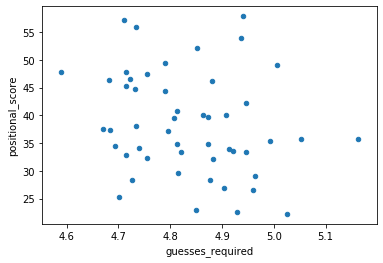

In [377]:
results.plot(kind='scatter', x='guesses_required', y='positional_score')

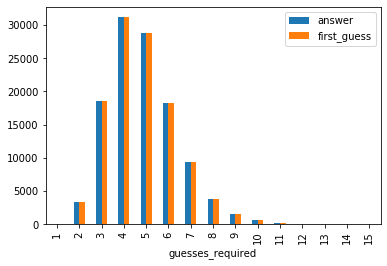

In [380]:
performance_df.pivot_table(index = 'guesses_required', aggfunc='count')

performance_df.pivot_table(index = 'guesses_required', aggfunc='count').plot(kind='bar')

guesses_required
count       2315.000000
mean           4.588337
std            1.467994
min            1.000000
25%            4.000000
50%            4.000000
75%            5.000000
max           11.000000

[Text(0, 0, 'brace'),
 Text(0, 0, 'shake'),
 Text(0, 0, 'alley'),
 Text(0, 0, 'mania'),
 Text(0, 0, 'bicep'),
 Text(0, 0, 'debug'),
 Text(0, 0, 'saner'),
 Text(0, 0, 'dealt'),
 Text(0, 0, 'cello'),
 Text(0, 0, 'clown'),
 Text(0, 0, 'dingo'),
 Text(0, 0, 'rouse'),
 Text(0, 0, 'hyena'),
 Text(0, 0, 'libel'),
 Text(0, 0, 'golem'),
 Text(0, 0, 'might'),
 Text(0, 0, 'flask'),
 Text(0, 0, 'silky'),
 Text(0, 0, 'livid'),
 Text(0, 0, 'abide'),
 Text(0, 0, 'album'),
 Text(0, 0, 'miser'),
 Text(0, 0, 'loamy'),
 Text(0, 0, 'burly'),
 Text(0, 0, 'funky'),
 Text(0, 0, 'hitch'),
 Text(0, 0, 'atone'),
 Text(0, 0, 'agony'),
 Text(0, 0, 'flick'),
 Text(0, 0, 'zesty'),
 Text(0, 0, 'aroma'),
 Text(0, 0, 'manly'),
 Text(0, 0, 'folio'),
 Text(0, 0, 'lunar'),
 Text(0, 0, 'thong'),
 Text(0, 0, 'singe'),
 Text(0, 0, 'imply'),
 Text(0, 0, 'avail'),
 Text(0, 0, 'lipid'),
 Text(0, 0, 'ovate'),
 Text(0, 0, 'tenth'),
 Text(0, 0, 'gauze'),
 Text(0, 0, 'sedan'),
 Text(0, 0, 'hunch'),
 Text(0, 0, 'lumpy'),
 Text(0, 0

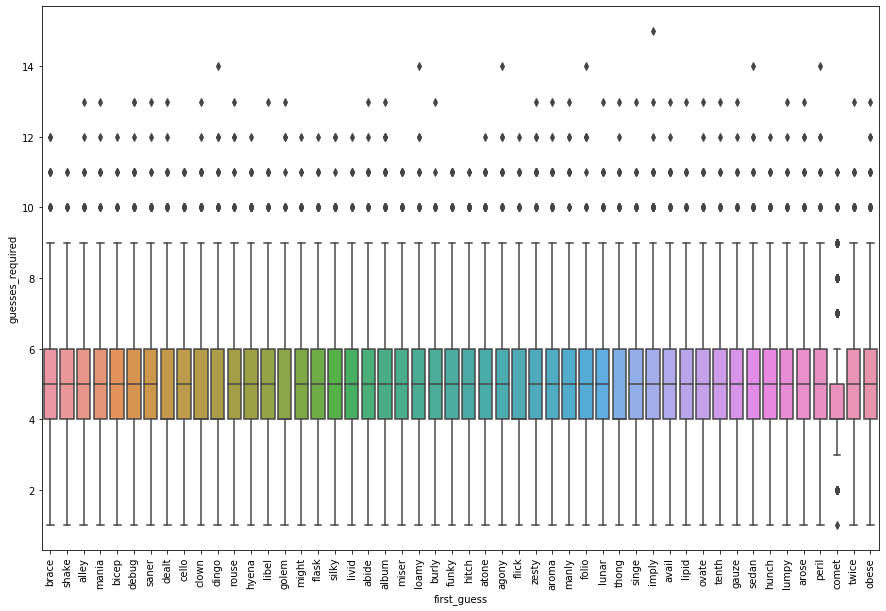

In [388]:
ax = sns.boxplot(x="first_guess", y="guesses_required", data=performance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [ ]:
performance_df[performance_df.first_guess=='comet'].describe()

In [397]:
performance_df[(performance_df.guesses_required>10)&(performance_df.first_guess=='comet')]

answer  guesses_required first_guess
109803  hover                11       comet
109863  joker                11       comet

In [402]:
answer = 'hover'
executor('comet', answer, printer=True)

Your guess of comet is incorrect. Attempt number 1. State is ['N', 'G', 'N', 'G', 'N']
Your guess of boney is incorrect. Attempt number 2. State is ['N', 'G', 'N', 'G', 'N']
Your guess of sober is incorrect. Attempt number 3. State is ['N', 'G', 'N', 'G', 'G']
Your guess of wooer is incorrect. Attempt number 4. State is ['N', 'G', 'N', 'G', 'G']
Your guess of poser is incorrect. Attempt number 5. State is ['N', 'G', 'N', 'G', 'G']
Your guess of tower is incorrect. Attempt number 6. State is ['N', 'G', 'N', 'G', 'G']
Your guess of roger is incorrect. Attempt number 7. State is ['N', 'G', 'N', 'G', 'G']
Your guess of foyer is incorrect. Attempt number 8. State is ['N', 'G', 'N', 'G', 'G']
Your guess of mover is incorrect. Attempt number 9. State is ['N', 'G', 'G', 'G', 'G']
Your guess of lover is incorrect. Attempt number 10. State is ['N', 'G', 'G', 'G', 'G']
Correct. Your guess of hover is right. Number of attempts: 11


11